In [398]:
from math import *
import numpy as np
import matplotlib.pyplot as plt

from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.initial_designs import RandomDesign
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.kernels import LinearMultiFidelityKernel
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel

from emukit.multi_fidelity.models.non_linear_multi_fidelity_model import make_non_linear_kernels, NonLinearMultiFidelityModel

import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

import matplotlib.pyplot as plt
from matplotlib import colors
import mlai.plot as plot

In [399]:
# Simulation presettings
write_images = False
wirte_output_txt = False
%run Missile_utils.ipynb
simulation_output = 'range'

In [400]:
custom_param_names = ['fuelmass', 'drymass']

In [401]:

# Low-fidelity simulator class
class simple_simulator_mod:
    def __init__(self,fuelmass,drymass,payload,missilediam,params=True):
        self.dMdt = 500
        self.v_ex = 5000
        
        if params is None:
            self.drymass = 0.8e6
            self.fuelmass = 2e6
            self.diam = 1.65
            
        else:
            self.drymass = drymass + payload
            self.fuelmass = fuelmass
            self.diam = missilediam
    
    def get_range(self):
        h=1e-5
        v=1e-5
        gamma = self.to_radians(90)
        thrust = self.v_ex * self.dMdt
        mass = self.drymass + self.fuelmass
        area = pi*(self.diam**2)/4
        G = 6.6743e-11
        M = 5.972e24
        R = 6.371e6
        g = G*M/(R**2)
        dm = self.dMdt
        t=0
        psi=0
        dt=1e-1
        tEND=1e8
        heights = []
        velocity = []
        gammas = []
        cnt=0
        while(h>0):
            if t>tEND:
                break
            try:
                dv = thrust/mass - g*sin(gamma)
            except:
                dv = 0
            dpsi = v*cos(gamma)/(R+h)
            dh = v*sin(gamma)
            if t<5:
                dgamma = -0.1
            else:
                dgamma = dpsi - g*cos(gamma)/v
#                 print(dgamma)
                
            if mass <= self.drymass:
                thrust=0
                mass = self.drymass
                dm=0
#                 if cnt==0:
#                     print("THRUST HAS BEEN PUT TO ZERO")
#                     cnt+=1
            else:
                mass = mass - dm*dt
    
            v = v + dt*dv
#             print(dh)
            h = h + dt*dh
            heights.append(h)

            gamma = gamma + dt*dgamma
            gammas.append(gamma)
            psi = psi + dt*dpsi
            g =  G*M/((R+h)**2)
            t= t+dt
            velocity.append(v)
            
#         plt.plot(velocity)
#         plt.show()
        #plt.plot(gammas)
        #plt.show()
        if psi<0:
            print("Rocket Failed (PSI)")
            return 0
        if t>tEND:
            print("Rocket Failed (tend)")
            return 0
        return psi*R/1000
        
        
    def eta(self,h,t):
        eta = 0.0
        return eta      
    
    def density(self,h):
        "Calculates air density at altitude"    
        rho0 = 1.225 #[kg/m^3] air density at sea level
        if h < 19200:
            rho = rho0 * exp(-h/8420)
        elif h > 19200 and h < 47000:
            rho = rho0 * (.857003 + h/57947)**-13.201
        else:
            #vacuum
            rho = 0.0
        return rho
        
    def temperature(self,h):
        "Calculates air temperature [Celsius] at altitude [m]"
        if h <= 11000:
            #troposphere
            t = 15.04 - .00649*h
        elif h <= 25000:
            #lower stratosphere
            t = -56.46
        elif h > 25000:
            t = -131.21 + .00299*h
        return t
    
    def pressure(self,h):
        "Calculates air pressure [Pa] at altitude [m]"  
        t = self.temperature(h)      
        if h <= 11000:
            #troposphere
            p = 101.29 * ((t+273.1)/288.08)**5.256
        elif h <= 25000:
            #lower stratosphere
            p = 22.65*exp(1.73-.000157*h)
        elif h > 25000:
            p = 2.488 * ((t+273.1)/288.08)**-11.388
        return p
        
    def Cdrag (self,v,h):
        t = self.temperature(h) + 273.15 #convert to kelvin
        a = sqrt(1.4*287*t) 
        mach = v/a
        
        if mach > 5:
            cd = 0.15
        elif mach > 1.8 and mach <= 5:
            cd = -0.03125*mach + 0.30625
        elif mach > 1.2 and mach <= 1.8:
            cd = -0.25*mach + 0.7
        elif mach > 0.8 and mach <= 1.2:
            cd = 0.625*mach - 0.35
        elif mach <= 0.8:
            cd = 0.15
        return cd
        
    def to_radians(self,degree):
        return degree * pi/180

In [402]:
# Low-fidelity simulation helper
def run_missile_low_sim(custom_params):
    """    
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'fuelmass':5600,
        'drymass':1200,
        'Isp0':226,
        'thrust0':9177.4
    }
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        # Row: different parameters -> different runs from the simulator
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            # For each custom variable
            param_name = custom_param_names[j]
            params_to_use[param_name] = custom_params[i,j]
        
            ## TEMP ## Better customise this
            #if j==0:
            #    print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            #print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_obj = simple_simulator_mod( 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"],
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],
        )
        Tm = 1.4e4*2000 / (params_to_use["fuelmass"]+params_to_use["drymass"])
        g = 6.6743e-11*5.972e24/(6.371e6**2)
        if Tm < g:
            print("Tm<g -> will fail")
        #print(f'Fuel {params_to_use["fuelmass"]}, dry {params_to_use["drymass"]}')
        
        y[i, 0] = sim_obj.get_range()
        if y[i, 0] ==0:
            print("FAILED")
    return y


In [403]:
# High-fidelity simulator helper
def run_missile_high_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }   
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
        
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y


# Actual code starting

In [404]:
basic_param_spaces = {
    'payload':  [10, 2410],
    'missilediam':  [0.1, 9.9],
    'rvdiam':  [0.1, 9.9],
    'estrange': [100, 4900], 
    'fuelmass': [500, 6000], # [500, 7000], 
    'drymass':  [1000, 3000],
    'Isp0':  [100, 800],# [100, 800],
    'thrust0':  [10000, 69000],
}

In [405]:
high_f = run_missile_high_sim
low_f = run_missile_low_sim

num_points = 101

x_dry = np.linspace(1000, 3000,num_points)[:, None]
x_fuel = np.linspace(500, 6000,num_points)[:, None]
x_fmesh, x_dmesh = np.meshgrid(x_fuel, x_dry)
x_plot = np.array([x_fmesh, x_dmesh]).T.reshape(-1,2)

y_plot_low = low_f(x_plot)
print(y_plot_low)

[[ 212.38444371]
 [ 207.42512151]
 [ 202.57373858]
 ...
 [2412.30249339]
 [2393.15084235]
 [2374.20058179]]


In [406]:
y_plot_high = high_f(x_plot)


New simulation 

fuelmass: 500.0
drymass: 1000.0


Stage 1 burnout
Velocity (km/s):  0.4755026409712568
Angle (deg h):  43.732284489193205
Range (km):  1.0582588623195328
Time (sec):  12.299999999999974
Final results: 
Range (km):  26.61990796407633
Apogee (km):  8.112255006544737
Time to target (sec):  86.79999999999934



New simulation 

fuelmass: 500.0
drymass: 1020.0


Stage 1 burnout
Velocity (km/s):  0.4701545526353664
Angle (deg h):  43.732284489193205
Range (km):  1.0459822915660328
Time (sec):  12.299999999999974
Final results: 
Range (km):  26.04945118086319
Apogee (km):  7.956754433447056
Time to target (sec):  85.99999999999939



New simulation 

fuelmass: 500.0
drymass: 1040.0


Stage 1 burnout
Velocity (km/s):  0.46491528701137946
Angle (deg h):  43.732284489193205
Range (km):  1.0339130955579316
Time (sec):  12.299999999999974
Final results: 
Range (km):  25.491038974434687
Apogee (km):  7.805710542891672
Time to target (sec):  85.19999999999943



New simulation 

fu

Final results: 
Range (km):  15.729885490042172
Apogee (km):  5.046667248206087
Time to target (sec):  69.9000000000003



New simulation 

fuelmass: 500.0
drymass: 1560.0


Stage 1 burnout
Velocity (km/s):  0.35582072545028204
Angle (deg h):  43.732284489193205
Range (km):  0.7755177771990072
Time (sec):  12.299999999999974
Final results: 
Range (km):  15.418840768504547
Apogee (km):  4.963606489968439
Time to target (sec):  69.30000000000034



New simulation 

fuelmass: 500.0
drymass: 1580.0


Stage 1 burnout
Velocity (km/s):  0.35228063232556217
Angle (deg h):  43.732284489193205
Range (km):  0.7673018704186805
Time (sec):  12.299999999999974
Final results: 
Range (km):  15.13798494281013
Apogee (km):  4.882139306447456
Time to target (sec):  68.80000000000037



New simulation 

fuelmass: 500.0
drymass: 1600.0


Stage 1 burnout
Velocity (km/s):  0.34877803384282496
Angle (deg h):  43.732284489193205
Range (km):  0.7591973076156225
Time (sec):  12.299999999999974
Final results: 
Ra

Final results: 
Range (km):  9.456521528907558
Apogee (km):  3.234240871979673
Time to target (sec):  57.300000000000544



New simulation 

fuelmass: 500.0
drymass: 2120.0


Stage 1 burnout
Velocity (km/s):  0.27025354802542456
Angle (deg h):  43.732284489193205
Range (km):  0.5829216560569502
Time (sec):  12.299999999999974
Final results: 
Range (km):  9.288173357797893
Apogee (km):  3.1859023031307534
Time to target (sec):  56.90000000000054



New simulation 

fuelmass: 500.0
drymass: 2140.0


Stage 1 burnout
Velocity (km/s):  0.26767957039321016
Angle (deg h):  43.732284489193205
Range (km):  0.5772957338569649
Time (sec):  12.299999999999974
Final results: 
Range (km):  9.141721825106913
Apogee (km):  3.138474256858446
Time to target (sec):  56.600000000000534



New simulation 

fuelmass: 500.0
drymass: 2160.0


Stage 1 burnout
Velocity (km/s):  0.26513927037041346
Angle (deg h):  43.732284489193205
Range (km):  0.5717433325804181
Time (sec):  12.299999999999974
Final results: 


Final results: 
Range (km):  6.1378253981976405
Apogee (km):  2.2341705818258792
Time to target (sec):  48.900000000000425



New simulation 

fuelmass: 500.0
drymass: 2640.0


Stage 1 burnout
Velocity (km/s):  0.212809203842013
Angle (deg h):  43.732284489193205
Range (km):  0.4573347451490997
Time (sec):  12.299999999999974
Final results: 
Range (km):  6.037519352611313
Apogee (km):  2.204386357015553
Time to target (sec):  48.60000000000042



New simulation 

fuelmass: 500.0
drymass: 2660.0


Stage 1 burnout
Velocity (km/s):  0.21093662436379676
Angle (deg h):  43.732284489193205
Range (km):  0.45323934616799516
Time (sec):  12.299999999999974
Final results: 
Range (km):  5.93863670769504
Apogee (km):  2.175100188533655
Time to target (sec):  48.300000000000416



New simulation 

fuelmass: 500.0
drymass: 2680.0


Stage 1 burnout
Velocity (km/s):  0.20908512330803514
Angle (deg h):  43.732284489193205
Range (km):  0.44918992579792827
Time (sec):  12.299999999999974
Final results: 


Final results: 
Range (km):  26.93077641873721
Apogee (km):  8.393017250553623
Time to target (sec):  88.89999999999922



New simulation 

fuelmass: 555.0
drymass: 1160.0


Stage 1 burnout
Velocity (km/s):  0.4700154356796656
Angle (deg h):  43.92422447418473
Range (km):  1.2257157728630579
Time (sec):  13.699999999999969
Final results: 
Range (km):  26.41068372243789
Apogee (km):  8.243493721001427
Time to target (sec):  88.19999999999926



New simulation 

fuelmass: 555.0
drymass: 1180.0


Stage 1 burnout
Velocity (km/s):  0.46509840622591603
Angle (deg h):  43.923305252329676
Range (km):  1.2124086032701262
Time (sec):  13.699999999999969
Final results: 
Range (km):  25.900803754793834
Apogee (km):  8.09793058782684
Time to target (sec):  87.4999999999993



New simulation 

fuelmass: 555.0
drymass: 1200.0


Stage 1 burnout
Velocity (km/s):  0.46027208687599913
Angle (deg h):  43.922383922517746
Range (km):  1.1993045968850002
Time (sec):  13.699999999999969
Final results: 
Range 

Final results: 
Range (km):  16.456402108471504
Apogee (km):  5.384878976491549
Time to target (sec):  72.80000000000014



New simulation 

fuelmass: 555.0
drymass: 1700.0


Stage 1 burnout
Velocity (km/s):  0.36141817204405713
Angle (deg h):  43.89807986578953
Range (km):  0.9236942114540501
Time (sec):  13.699999999999969
Final results: 
Range (km):  16.171429376583013
Apogee (km):  5.301663296245794
Time to target (sec):  72.30000000000017



New simulation 

fuelmass: 555.0
drymass: 1720.0


Stage 1 burnout
Velocity (km/s):  0.3580201181763848
Angle (deg h):  43.89700495794624
Range (km):  0.914380925678231
Time (sec):  13.699999999999969
Final results: 
Range (km):  15.890370702525278
Apogee (km):  5.219890091367719
Time to target (sec):  71.8000000000002



New simulation 

fuelmass: 555.0
drymass: 1740.0


Stage 1 burnout
Velocity (km/s):  0.3546543412261543
Angle (deg h):  43.895920033400195
Range (km):  0.9051840011468971
Time (sec):  13.699999999999969
Final results: 
Range 

Final results: 
Range (km):  10.529776367262132
Apogee (km):  3.638109716439908
Time to target (sec):  61.3000000000006



New simulation 

fuelmass: 555.0
drymass: 2220.0


Stage 1 burnout
Velocity (km/s):  0.28332214725055016
Angle (deg h):  43.86688604255093
Range (km):  0.7158676088073909
Time (sec):  13.699999999999969
Final results: 
Range (km):  10.351517874110792
Apogee (km):  3.5858204969597685
Time to target (sec):  60.900000000000595



New simulation 

fuelmass: 555.0
drymass: 2240.0


Stage 1 burnout
Velocity (km/s):  0.28072310782477755
Angle (deg h):  43.86555028027802
Range (km):  0.709145124899986
Time (sec):  13.699999999999969
Final results: 
Range (km):  10.175788750408335
Apogee (km):  3.5344606004793038
Time to target (sec):  60.50000000000059



New simulation 

fuelmass: 555.0
drymass: 2260.0


Stage 1 burnout
Velocity (km/s):  0.2781517451094648
Angle (deg h):  43.86420422175556
Range (km):  0.7025049849787274
Time (sec):  13.699999999999969
Final results: 
Ran

Stage 1 burnout
Velocity (km/s):  0.2225513282424313
Angle (deg h):  43.827522060641265
Range (km):  0.5597671013984667
Time (sec):  13.699999999999969
Final results: 
Range (km):  6.706688020199233
Apogee (km):  2.474757639764577
Time to target (sec):  52.00000000000047



New simulation 

fuelmass: 555.0
drymass: 2780.0


Stage 1 burnout
Velocity (km/s):  0.22063842025464117
Angle (deg h):  43.82593134087627
Range (km):  0.5548567512383801
Time (sec):  13.699999999999969
Final results: 
Range (km):  6.6014004741436905
Apogee (km):  2.442757305861889
Time to target (sec):  51.700000000000465



New simulation 

fuelmass: 555.0
drymass: 2800.0


Stage 1 burnout
Velocity (km/s):  0.21874609807947712
Angle (deg h):  43.824330371314495
Range (km):  0.5499990864732508
Time (sec):  13.699999999999969
Final results: 
Range (km):  6.497546885528142
Apogee (km):  2.411266531893893
Time to target (sec):  51.40000000000046



New simulation 

fuelmass: 555.0
drymass: 2820.0


Stage 1 burnout
Vel

Stage 1 burnout
Velocity (km/s):  0.46853325085503117
Angle (deg h):  43.664212484876735
Range (km):  1.3971600179476151
Time (sec):  15.099999999999964
Final results: 
Range (km):  26.64589283191889
Apogee (km):  8.398287145152056
Time to target (sec):  89.69999999999918



New simulation 

fuelmass: 610.0
drymass: 1320.0


Stage 1 burnout
Velocity (km/s):  0.46389684061255987
Angle (deg h):  43.66333772347097
Range (km):  1.382780605404984
Time (sec):  15.099999999999964
Final results: 
Range (km):  26.18163959046299
Apogee (km):  8.259690763223015
Time to target (sec):  89.09999999999921



New simulation 

fuelmass: 610.0
drymass: 1340.0


Stage 1 burnout
Velocity (km/s):  0.45933979390597834
Angle (deg h):  43.66246075954585
Range (km):  1.368604459708746
Time (sec):  15.099999999999964
Final results: 
Range (km):  25.692511733959467
Apogee (km):  8.124425063709683
Time to target (sec):  88.39999999999925



New simulation 

fuelmass: 610.0
drymass: 1360.0


Stage 1 burnout
Veloci

Final results: 
Range (km):  16.21104298663011
Apogee (km):  5.3863288742257796
Time to target (sec):  73.6000000000001



New simulation 

fuelmass: 610.0
drymass: 1900.0


Stage 1 burnout
Velocity (km/s):  0.35527827529641104
Angle (deg h):  43.63629382678346
Range (km):  1.0365538629805364
Time (sec):  15.099999999999964
Final results: 
Range (km):  15.962795571208305
Apogee (km):  5.3081854245993485
Time to target (sec):  73.20000000000012



New simulation 

fuelmass: 610.0
drymass: 1920.0


Stage 1 burnout
Velocity (km/s):  0.3520937624323029
Angle (deg h):  43.63524856612445
Range (km):  1.0266026641899193
Time (sec):  15.099999999999964
Final results: 
Range (km):  15.692197793099936
Apogee (km):  5.231325356938896
Time to target (sec):  72.70000000000014



New simulation 

fuelmass: 610.0
drymass: 1940.0


Stage 1 burnout
Velocity (km/s):  0.3489376389269229
Angle (deg h):  43.63419386443584
Range (km):  1.0167674430926625
Time (sec):  15.099999999999964
Final results: 
Range

Stage 1 burnout
Velocity (km/s):  0.2765475427320657
Angle (deg h):  43.60341520209911
Range (km):  0.7975921843530688
Time (sec):  15.099999999999964
Final results: 
Range (km):  10.104338079329137
Apogee (km):  3.573686913366395
Time to target (sec):  61.600000000000605



New simulation 

fuelmass: 610.0
drymass: 2480.0


Stage 1 burnout
Velocity (km/s):  0.2741147448728509
Angle (deg h):  43.6020991246764
Range (km):  0.7904120851433768
Time (sec):  15.099999999999964
Final results: 
Range (km):  9.956057054628126
Apogee (km):  3.5254595119422167
Time to target (sec):  61.3000000000006



New simulation 

fuelmass: 610.0
drymass: 2500.0


Stage 1 burnout
Velocity (km/s):  0.2717060376456079
Angle (deg h):  43.600772897565655
Range (km):  0.7833136183873107
Time (sec):  15.099999999999964
Final results: 
Range (km):  9.79002398813319
Apogee (km):  3.4780110003188036
Time to target (sec):  60.900000000000595



New simulation 

fuelmass: 610.0
drymass: 2520.0


Stage 1 burnout
Veloci

Final results: 
Range (km):  6.888440413591197
Apogee (km):  2.579139102845502
Time to target (sec):  53.800000000000495



New simulation 

fuelmass: 610.0
drymass: 2980.0


Stage 1 burnout
Velocity (km/s):  0.22106280355838828
Angle (deg h):  43.56622473078799
Range (km):  0.634438856979485
Time (sec):  15.099999999999964
Final results: 
Range (km):  6.782901288829335
Apogee (km):  2.5471042682318963
Time to target (sec):  53.50000000000049



New simulation 

fuelmass: 610.0
drymass: 3000.0


Stage 1 burnout
Velocity (km/s):  0.21921875437666885
Angle (deg h):  43.564665698741
Range (km):  0.6290158650403894
Time (sec):  15.099999999999964
Final results: 
Range (km):  6.678740894947776
Apogee (km):  2.5155780283845934
Time to target (sec):  53.200000000000486



New simulation 

fuelmass: 665.0
drymass: 1000.0


Stage 1 burnout
Velocity (km/s):  0.5821158521840272
Angle (deg h):  43.8913539680959
Range (km):  1.9206329247736769
Time (sec):  16.399999999999967
Final results: 
Range (

Final results: 
Range (km):  25.03988732725329
Apogee (km):  8.119088721579763
Time to target (sec):  89.09999999999921



New simulation 

fuelmass: 665.0
drymass: 1520.0


Stage 1 burnout
Velocity (km/s):  0.4459508379997042
Angle (deg h):  43.86992548785174
Range (km):  1.4677485308008589
Time (sec):  16.399999999999967
Final results: 
Range (km):  24.616597032835237
Apogee (km):  7.995583070597503
Time to target (sec):  88.49999999999925



New simulation 

fuelmass: 665.0
drymass: 1540.0


Stage 1 burnout
Velocity (km/s):  0.441866321503241
Angle (deg h):  43.869079149591684
Range (km):  1.4535053699710367
Time (sec):  16.399999999999967
Final results: 
Range (km):  24.20027668788493
Apogee (km):  7.874736964838722
Time to target (sec):  87.89999999999928



New simulation 

fuelmass: 665.0
drymass: 1560.0


Stage 1 burnout
Velocity (km/s):  0.43784324958753207
Angle (deg h):  43.86823013462642
Range (km):  1.4394384575829615
Time (sec):  16.399999999999967
Final results: 
Range (

Stage 1 burnout
Velocity (km/s):  0.3490189425368894
Angle (deg h):  43.844475856567705
Range (km):  1.1247936729645927
Time (sec):  16.399999999999967
Final results: 
Range (km):  15.661778990303645
Apogee (km):  5.351830960706349
Time to target (sec):  74.20000000000006



New simulation 

fuelmass: 665.0
drymass: 2100.0


Stage 1 burnout
Velocity (km/s):  0.34600147243597107
Angle (deg h):  43.843454458419906
Range (km):  1.1143973365607214
Time (sec):  16.399999999999967
Final results: 
Range (km):  15.426414651155337
Apogee (km):  5.27800592686065
Time to target (sec):  73.80000000000008



New simulation 

fuelmass: 665.0
drymass: 2120.0


Stage 1 burnout
Velocity (km/s):  0.3430095798273743
Angle (deg h):  43.84242403076393
Range (km):  1.1041153059657327
Time (sec):  16.399999999999967
Final results: 
Range (km):  15.193938772619136
Apogee (km):  5.205323093948691
Time to target (sec):  73.4000000000001



New simulation 

fuelmass: 665.0
drymass: 2140.0


Stage 1 burnout
Veloc

Final results: 
Range (km):  9.953511777008213
Apogee (km):  3.6191114257808623
Time to target (sec):  62.80000000000062



New simulation 

fuelmass: 665.0
drymass: 2680.0


Stage 1 burnout
Velocity (km/s):  0.26925474048020165
Angle (deg h):  43.80980260796683
Range (km):  0.8577612060761387
Time (sec):  16.399999999999967
Final results: 
Range (km):  9.810357064188846
Apogee (km):  3.5722944732158965
Time to target (sec):  62.50000000000062



New simulation 

fuelmass: 665.0
drymass: 2700.0


Stage 1 burnout
Velocity (km/s):  0.2669573420610325
Angle (deg h):  43.80849824399734
Range (km):  0.850279229566411
Time (sec):  16.399999999999967
Final results: 
Range (km):  9.668993017723349
Apogee (km):  3.5262076650939016
Time to target (sec):  62.200000000000614



New simulation 

fuelmass: 665.0
drymass: 2720.0


Stage 1 burnout
Velocity (km/s):  0.2646839449157388
Angle (deg h):  43.8071854025964
Range (km):  0.8428770642352118
Time (sec):  16.399999999999967
Final results: 
Range 

Stage 1 burnout
Velocity (km/s):  0.5473206963847504
Angle (deg h):  43.687739247190706
Range (km):  2.0072978489081614
Time (sec):  17.799999999999986
Final results: 
Range (km):  36.49153696227474
Apogee (km):  11.472483037795275
Time to target (sec):  105.0999999999983



New simulation 

fuelmass: 720.0
drymass: 1240.0


Stage 1 burnout
Velocity (km/s):  0.5416632939608872
Angle (deg h):  43.686957211087986
Range (km):  1.9868432573286599
Time (sec):  17.799999999999986
Final results: 
Range (km):  35.80357819638837
Apogee (km):  11.277372262955
Time to target (sec):  104.29999999999835



New simulation 

fuelmass: 720.0
drymass: 1260.0


Stage 1 burnout
Velocity (km/s):  0.5361178764391705
Angle (deg h):  43.68617467949331
Range (km):  1.9667162977041566
Time (sec):  17.799999999999986
Final results: 
Range (km):  35.12929161181874
Apogee (km):  11.087494241397463
Time to target (sec):  103.4999999999984



New simulation 

fuelmass: 720.0
drymass: 1280.0


Stage 1 burnout
Veloci

Final results: 
Range (km):  22.83650134689816
Apogee (km):  7.560926099680962
Time to target (sec):  87.19999999999932



New simulation 

fuelmass: 720.0
drymass: 1780.0


Stage 1 burnout
Velocity (km/s):  0.42099593294445964
Angle (deg h):  43.66528558301016
Range (km):  1.531352896838342
Time (sec):  17.799999999999986
Final results: 
Range (km):  22.48897979224406
Apogee (km):  7.455579147760418
Time to target (sec):  86.69999999999935



New simulation 

fuelmass: 720.0
drymass: 1800.0


Stage 1 burnout
Velocity (km/s):  0.4174168855435096
Angle (deg h):  43.66445187676707
Range (km):  1.51724452820806
Time (sec):  17.799999999999986
Final results: 
Range (km):  22.116376820972885
Apogee (km):  7.3522456145005926
Time to target (sec):  86.09999999999938



New simulation 

fuelmass: 720.0
drymass: 1820.0


Stage 1 burnout
Velocity (km/s):  0.41388895409326015
Angle (deg h):  43.6636159926604
Range (km):  1.5032907973207843
Time (sec):  17.799999999999986
Final results: 
Range (km

Velocity (km/s):  0.33871830413713033
Angle (deg h):  43.6416394508331
Range (km):  1.2083143359866553
Time (sec):  17.799999999999986
Final results: 
Range (km):  15.09521511128841
Apogee (km):  5.251340490830973
Time to target (sec):  74.50000000000004



New simulation 

fuelmass: 720.0
drymass: 2320.0


Stage 1 burnout
Velocity (km/s):  0.3358836668212071
Angle (deg h):  43.640618476186674
Range (km):  1.1975437978593662
Time (sec):  17.799999999999986
Final results: 
Range (km):  14.871482740198555
Apogee (km):  5.182376568865657
Time to target (sec):  74.10000000000007



New simulation 

fuelmass: 720.0
drymass: 2340.0


Stage 1 burnout
Velocity (km/s):  0.3330721215641496
Angle (deg h):  43.639588699255135
Range (km):  1.1868851294420557
Time (sec):  17.799999999999986
Final results: 
Range (km):  14.650421398505792
Apogee (km):  5.114427882237899
Time to target (sec):  73.70000000000009



New simulation 

fuelmass: 720.0
drymass: 2360.0


Stage 1 burnout
Velocity (km/s):  0.3

Final results: 
Range (km):  9.619529011698765
Apogee (km):  3.56981774352931
Time to target (sec):  63.40000000000063



New simulation 

fuelmass: 720.0
drymass: 2920.0


Stage 1 burnout
Velocity (km/s):  0.26115349483414907
Angle (deg h):  43.60573062889037
Range (km):  0.9213449218548124
Time (sec):  17.799999999999986
Final results: 
Range (km):  9.483157836782174
Apogee (km):  3.525707150648347
Time to target (sec):  63.10000000000063



New simulation 

fuelmass: 720.0
drymass: 2940.0


Stage 1 burnout
Velocity (km/s):  0.2589929206875137
Angle (deg h):  43.60442367615178
Range (km):  0.9135222615119747
Time (sec):  17.799999999999986
Final results: 
Range (km):  9.348517635304612
Apogee (km):  3.4822480291829416
Time to target (sec):  62.80000000000062



New simulation 

fuelmass: 720.0
drymass: 2960.0


Stage 1 burnout
Velocity (km/s):  0.256853896364144
Angle (deg h):  43.60310811196132
Range (km):  0.9057772843887686
Time (sec):  17.799999999999986
Final results: 
Range (km

Stage 1 burnout
Velocity (km/s):  0.5147003446213165
Angle (deg h):  43.8516360976082
Range (km):  2.046989241933792
Time (sec):  19.100000000000005
Final results: 
Range (km):  32.91069026964238
Apogee (km):  10.663952449774676
Time to target (sec):  102.39999999999846



New simulation 

fuelmass: 775.0
drymass: 1460.0


Stage 1 burnout
Velocity (km/s):  0.5098243745654949
Angle (deg h):  43.85087729058188
Range (km):  2.0274633754389173
Time (sec):  19.100000000000005
Final results: 
Range (km):  32.34318432418424
Apogee (km):  10.499527629915328
Time to target (sec):  101.6999999999985



New simulation 

fuelmass: 775.0
drymass: 1480.0


Stage 1 burnout
Velocity (km/s):  0.5050300642566811
Angle (deg h):  43.850116940248526
Range (km):  2.0082031484482235
Time (sec):  19.100000000000005
Final results: 
Range (km):  31.78559480315455
Apogee (km):  10.338874408610003
Time to target (sec):  100.99999999999854



New simulation 

fuelmass: 775.0
drymass: 1500.0


Stage 1 burnout
Veloc

Stage 1 burnout
Velocity (km/s):  0.4095376116009694
Angle (deg h):  43.83127304716202
Range (km):  1.6109666265946714
Time (sec):  19.100000000000005
Final results: 
Range (km):  21.64734100858419
Apogee (km):  7.35342247700851
Time to target (sec):  86.99999999999933



New simulation 

fuelmass: 775.0
drymass: 1980.0


Stage 1 burnout
Velocity (km/s):  0.4062084924995092
Angle (deg h):  43.83045660499599
Range (km):  1.596611382570593
Time (sec):  19.100000000000005
Final results: 
Range (km):  21.324368568796405
Apogee (km):  7.25675822796338
Time to target (sec):  86.49999999999936



New simulation 

fuelmass: 775.0
drymass: 2000.0


Stage 1 burnout
Velocity (km/s):  0.40292039832918686
Angle (deg h):  43.82963700219985
Range (km):  1.5823989866866706
Time (sec):  19.100000000000005
Final results: 
Range (km):  21.005888760455843
Apogee (km):  7.161780611928289
Time to target (sec):  85.99999999999939



New simulation 

fuelmass: 775.0
drymass: 2020.0


Stage 1 burnout
Velocity 

Final results: 
Range (km):  13.483180471490863
Apogee (km):  4.866782784330353
Time to target (sec):  73.00000000000013



New simulation 

fuelmass: 775.0
drymass: 2620.0


Stage 1 burnout
Velocity (km/s):  0.31301929152736285
Angle (deg h):  43.8005208247466
Range (km):  1.2043552042464745
Time (sec):  19.100000000000005
Final results: 
Range (km):  13.282361232252004
Apogee (km):  4.805686578034777
Time to target (sec):  72.60000000000015



New simulation 

fuelmass: 775.0
drymass: 2640.0


Stage 1 burnout
Velocity (km/s):  0.31045774484029504
Angle (deg h):  43.79944472292267
Range (km):  1.1939864864122705
Time (sec):  19.100000000000005
Final results: 
Range (km):  13.083921530694417
Apogee (km):  4.74545741722962
Time to target (sec):  72.20000000000017



New simulation 

fuelmass: 775.0
drymass: 2660.0


Stage 1 burnout
Velocity (km/s):  0.30791693429775185
Angle (deg h):  43.79835968200139
Range (km):  1.1837201199655518
Time (sec):  19.100000000000005
Final results: 
Range

Stage 1 burnout
Velocity (km/s):  0.6450950414541464
Angle (deg h):  43.70619257351697
Range (km):  2.7780472886704346
Time (sec):  20.500000000000025
Final results: 
Range (km):  50.54249912056641
Apogee (km):  15.733271393068739
Time to target (sec):  123.19999999999727



New simulation 

fuelmass: 830.0
drymass: 1120.0


Stage 1 burnout
Velocity (km/s):  0.6381573978587779
Angle (deg h):  43.70550060950259
Range (km):  2.7490646675903214
Time (sec):  20.500000000000025
Final results: 
Range (km):  49.54273378156827
Apogee (km):  15.45494736781874
Time to target (sec):  122.19999999999733



New simulation 

fuelmass: 830.0
drymass: 1140.0


Stage 1 burnout
Velocity (km/s):  0.6313340471368154
Angle (deg h):  43.70480529589746
Range (km):  2.7205632821915744
Time (sec):  20.500000000000025
Final results: 
Range (km):  48.561543602727404
Apogee (km):  15.18355238068071
Time to target (sec):  121.19999999999739



New simulation 

fuelmass: 830.0
drymass: 1160.0


Stage 1 burnout
Velo

Stage 1 burnout
Velocity (km/s):  0.4891237408930241
Angle (deg h):  43.68593827985633
Range (km):  2.1162287135009743
Time (sec):  20.500000000000025
Final results: 
Range (km):  30.366415475484406
Apogee (km):  10.029386051838115
Time to target (sec):  100.49999999999856



New simulation 

fuelmass: 830.0
drymass: 1680.0


Stage 1 burnout
Velocity (km/s):  0.4848047588482826
Angle (deg h):  43.68519295180206
Range (km):  2.0970735341100433
Time (sec):  20.500000000000025
Final results: 
Range (km):  29.888886592206806
Apogee (km):  9.88688872765899
Time to target (sec):  99.8999999999986



New simulation 

fuelmass: 830.0
drymass: 1700.0


Stage 1 burnout
Velocity (km/s):  0.4805508138481935
Angle (deg h):  43.68444578167321
Range (km):  2.078151314897998
Time (sec):  20.500000000000025
Final results: 
Range (km):  29.38420121193915
Apogee (km):  9.74733713399953
Time to target (sec):  99.19999999999864



New simulation 

fuelmass: 830.0
drymass: 1720.0


Stage 1 burnout
Velocity 

Final results: 
Range (km):  20.180879873695098
Apogee (km):  7.000308864145044
Time to target (sec):  85.99999999999939



New simulation 

fuelmass: 830.0
drymass: 2220.0


Stage 1 burnout
Velocity (km/s):  0.3881156061692388
Angle (deg h):  43.664171375210024
Range (km):  1.6526032811923141
Time (sec):  20.500000000000025
Final results: 
Range (km):  19.91050777059645
Apogee (km):  6.913117841851576
Time to target (sec):  85.59999999999941



New simulation 

fuelmass: 830.0
drymass: 2240.0


Stage 1 burnout
Velocity (km/s):  0.38508436847029
Angle (deg h):  43.663340542785114
Range (km):  1.63832559846681
Time (sec):  20.500000000000025
Final results: 
Range (km):  19.614993287990938
Apogee (km):  6.827021911148303
Time to target (sec):  85.09999999999944



New simulation 

fuelmass: 830.0
drymass: 2260.0


Stage 1 burnout
Velocity (km/s):  0.3820716648854496
Angle (deg h):  43.66250177530045
Range (km):  1.624179071142514
Time (sec):  20.500000000000025
Final results: 
Range (km)

Stage 1 burnout
Velocity (km/s):  0.310540961260731
Angle (deg h):  43.63782277664756
Range (km):  1.2993249162102019
Time (sec):  20.500000000000025
Final results: 
Range (km):  13.314277476147517
Apogee (km):  4.883461385552104
Time to target (sec):  74.00000000000007



New simulation 

fuelmass: 830.0
drymass: 2800.0


Stage 1 burnout
Velocity (km/s):  0.3080526842505583
Angle (deg h):  43.63675854906537
Range (km):  1.2883532395242716
Time (sec):  20.500000000000025
Final results: 
Range (km):  13.140545599193997
Apogee (km):  4.824145858502804
Time to target (sec):  73.70000000000009



New simulation 

fuelmass: 830.0
drymass: 2820.0


Stage 1 burnout
Velocity (km/s):  0.30558361104161913
Angle (deg h):  43.6356854372954
Range (km):  1.2774848498534144
Time (sec):  20.500000000000025
Final results: 
Range (km):  12.946595950661168
Apogee (km):  4.765625751878389
Time to target (sec):  73.30000000000011



New simulation 

fuelmass: 830.0
drymass: 2840.0


Stage 1 burnout
Velocit

Final results: 
Range (km):  45.42831207648875
Apogee (km):  14.532900795802778
Time to target (sec):  119.59999999999748



New simulation 

fuelmass: 885.0
drymass: 1320.0


Stage 1 burnout
Velocity (km/s):  0.5997571080466891
Angle (deg h):  43.84222306899963
Range (km):  2.768352474592411
Time (sec):  21.800000000000043
Final results: 
Range (km):  44.58504652253728
Apogee (km):  14.295748603407443
Time to target (sec):  118.69999999999753



New simulation 

fuelmass: 885.0
drymass: 1340.0


Stage 1 burnout
Velocity (km/s):  0.593737727316248
Angle (deg h):  43.841531416971826
Range (km):  2.7415021819029386
Time (sec):  21.800000000000043
Final results: 
Range (km):  43.75621205842374
Apogee (km):  14.063953567570508
Time to target (sec):  117.79999999999758



New simulation 

fuelmass: 885.0
drymass: 1360.0


Stage 1 burnout
Velocity (km/s):  0.5878116593759504
Angle (deg h):  43.84083671912835
Range (km):  2.715072203866599
Time (sec):  21.800000000000043
Final results: 
Range

Final results: 
Range (km):  29.160853042076518
Apogee (km):  9.846364607042494
Time to target (sec):  100.49999999999856



New simulation 

fuelmass: 885.0
drymass: 1840.0


Stage 1 burnout
Velocity (km/s):  0.4715871361053637
Angle (deg h):  43.823716524354836
Range (km):  2.1795733855034176
Time (sec):  21.800000000000043
Final results: 
Range (km):  28.710863911293053
Apogee (km):  9.713551955732285
Time to target (sec):  99.8999999999986



New simulation 

fuelmass: 885.0
drymass: 1860.0


Stage 1 burnout
Velocity (km/s):  0.4676225401374351
Angle (deg h):  43.82298290765024
Range (km):  2.160549175256283
Time (sec):  21.800000000000043
Final results: 
Range (km):  28.267593754308248
Apogee (km):  9.58326706532831
Time to target (sec):  99.29999999999863



New simulation 

fuelmass: 885.0
drymass: 1880.0


Stage 1 burnout
Velocity (km/s):  0.4637139629640972
Angle (deg h):  43.822247405249726
Range (km):  2.141738469979087
Time (sec):  21.800000000000043
Final results: 
Range (

Final results: 
Range (km):  19.70508712695759
Apogee (km):  6.977709261438283
Time to target (sec):  86.79999999999934



New simulation 

fuelmass: 885.0
drymass: 2380.0


Stage 1 burnout
Velocity (km/s):  0.380365527589326
Angle (deg h):  43.80296626704145
Range (km):  1.7283292072984837
Time (sec):  21.800000000000043
Final results: 
Range (km):  19.41597888155116
Apogee (km):  6.893187059848256
Time to target (sec):  86.29999999999937



New simulation 

fuelmass: 885.0
drymass: 2400.0


Stage 1 burnout
Velocity (km/s):  0.37744434264589344
Angle (deg h):  43.80213516997116
Range (km):  1.7137043921191608
Time (sec):  21.800000000000043
Final results: 
Range (km):  19.15717318472371
Apogee (km):  6.809704925754267
Time to target (sec):  85.8999999999994



New simulation 

fuelmass: 885.0
drymass: 2420.0


Stage 1 burnout
Velocity (km/s):  0.37454057232225957
Angle (deg h):  43.80129622159309
Range (km):  1.6992081880307262
Time (sec):  21.800000000000043
Final results: 
Range (km

Stage 1 burnout
Velocity (km/s):  0.3103208767947482
Angle (deg h):  43.77874134481231
Range (km):  1.3877822199466077
Time (sec):  21.800000000000043
Final results: 
Range (km):  13.500207139432236
Apogee (km):  5.033243025924413
Time to target (sec):  75.89999999999996



New simulation 

fuelmass: 885.0
drymass: 2920.0


Stage 1 burnout
Velocity (km/s):  0.30787368580854907
Angle (deg h):  43.77769619999966
Range (km):  1.3762192538175568
Time (sec):  21.800000000000043
Final results: 
Range (km):  13.30459484858532
Apogee (km):  4.973458559069803
Time to target (sec):  75.49999999999999



New simulation 

fuelmass: 885.0
drymass: 2940.0


Stage 1 burnout
Velocity (km/s):  0.30544411065924854
Angle (deg h):  43.7766420428008
Range (km):  1.36476009703903
Time (sec):  21.800000000000043
Final results: 
Range (km):  13.1111660885999
Apogee (km):  4.914446824467019
Time to target (sec):  75.10000000000001



New simulation 

fuelmass: 885.0
drymass: 2960.0


Stage 1 burnout
Velocity (

Final results: 
Range (km):  46.32219300360122
Apogee (km):  14.917680860156434
Time to target (sec):  121.79999999999735



New simulation 

fuelmass: 940.0
drymass: 1400.0


Stage 1 burnout
Velocity (km/s):  0.6030769936237023
Angle (deg h):  43.70673924026853
Range (km):  2.9900569488462723
Time (sec):  23.200000000000063
Final results: 
Range (km):  45.479620322630325
Apogee (km):  14.68273571820969
Time to target (sec):  120.8999999999974



New simulation 

fuelmass: 940.0
drymass: 1420.0


Stage 1 burnout
Velocity (km/s):  0.5971918472285633
Angle (deg h):  43.70606929126645
Range (km):  2.961829124270132
Time (sec):  23.200000000000063
Final results: 
Range (km):  44.694537064606465
Apogee (km):  14.453018783686295
Time to target (sec):  120.09999999999745



New simulation 

fuelmass: 940.0
drymass: 1440.0


Stage 1 burnout
Velocity (km/s):  0.5913904677438855
Angle (deg h):  43.70539589265024
Range (km):  2.934004552055767
Time (sec):  23.200000000000063
Final results: 
Range

Final results: 
Range (km):  29.615433266419227
Apogee (km):  10.088412611457304
Time to target (sec):  102.39999999999846



New simulation 

fuelmass: 940.0
drymass: 1940.0


Stage 1 burnout
Velocity (km/s):  0.47261308750044223
Angle (deg h):  43.68800721036355
Range (km):  2.3467850624119007
Time (sec):  23.200000000000063
Final results: 
Range (km):  29.16615367894456
Apogee (km):  9.956444063464973
Time to target (sec):  101.79999999999849



New simulation 

fuelmass: 940.0
drymass: 1960.0


Stage 1 burnout
Velocity (km/s):  0.4687267646701264
Angle (deg h):  43.687289889375336
Range (km):  2.3267610648185086
Time (sec):  23.200000000000063
Final results: 
Range (km):  28.75736355666676
Apogee (km):  9.826912071812298
Time to target (sec):  101.29999999999852



New simulation 

fuelmass: 940.0
drymass: 1980.0


Stage 1 burnout
Velocity (km/s):  0.46489196989000403
Angle (deg h):  43.686570350445635
Range (km):  2.3069500397069573
Time (sec):  23.200000000000063
Final results: 


Stage 1 burnout
Velocity (km/s):  0.3885880900463137
Angle (deg h):  43.66930498046494
Range (km):  1.9010974832376661
Time (sec):  23.200000000000063
Final results: 
Range (km):  20.48785515310418
Apogee (km):  7.302535151703205
Time to target (sec):  89.3999999999992



New simulation 

fuelmass: 940.0
drymass: 2460.0


Stage 1 burnout
Velocity (km/s):  0.3856782009142587
Angle (deg h):  43.668510299494315
Range (km):  1.8852889407036622
Time (sec):  23.200000000000063
Final results: 
Range (km):  20.194010113601955
Apogee (km):  7.2164582180844254
Time to target (sec):  88.89999999999922



New simulation 

fuelmass: 940.0
drymass: 2480.0


Stage 1 burnout
Velocity (km/s):  0.38278463424856707
Angle (deg h):  43.667708136129164
Range (km):  1.86961437886357
Time (sec):  23.200000000000063
Final results: 
Range (km):  19.93085871301706
Apogee (km):  7.131393063052901
Time to target (sec):  88.49999999999925



New simulation 

fuelmass: 940.0
drymass: 2500.0


Stage 1 burnout
Velocit

Final results: 
Range (km):  14.536972796556167
Apogee (km):  5.4345864818627545
Time to target (sec):  79.19999999999978



New simulation 

fuelmass: 940.0
drymass: 2960.0


Stage 1 burnout
Velocity (km/s):  0.31841568568537754
Angle (deg h):  43.64610620428386
Range (km):  1.5312116746756834
Time (sec):  23.200000000000063
Final results: 
Range (km):  14.331899656332192
Apogee (km):  5.371212622446739
Time to target (sec):  78.7999999999998



New simulation 

fuelmass: 940.0
drymass: 2980.0


Stage 1 burnout
Velocity (km/s):  0.3159482628599395
Angle (deg h):  43.64510342423831
Range (km):  1.5185847033340996
Time (sec):  23.200000000000063
Final results: 
Range (km):  14.151908033858946
Apogee (km):  5.308629438490344
Time to target (sec):  78.49999999999982



New simulation 

fuelmass: 940.0
drymass: 3000.0


Stage 1 burnout
Velocity (km/s):  0.31349799619947927
Angle (deg h):  43.64409202689311
Range (km):  1.5060674626859394
Time (sec):  23.200000000000063
Final results: 
Rang


fuelmass: 995.0
drymass: 1440.0


Stage 1 burnout
Velocity (km/s):  0.614074043883003
Angle (deg h):  43.656943139700516
Range (km):  3.22234521060853
Time (sec):  24.50000000000008
Final results: 
Range (km):  47.44902516799103
Apogee (km):  15.392265169241082
Time to target (sec):  124.29999999999721



New simulation 

fuelmass: 995.0
drymass: 1460.0


Stage 1 burnout
Velocity (km/s):  0.6081764000244883
Angle (deg h):  43.656943139700516
Range (km):  3.192376077790305
Time (sec):  24.50000000000008
Final results: 
Range (km):  46.64513878965698
Apogee (km):  15.156641650531066
Time to target (sec):  123.49999999999726



New simulation 

fuelmass: 995.0
drymass: 1480.0


Stage 1 burnout
Velocity (km/s):  0.6023640056762999
Angle (deg h):  43.656943139700516
Range (km):  3.1628358717129603
Time (sec):  24.50000000000008
Final results: 
Range (km):  45.81078033471954
Apogee (km):  14.92608042199008
Time to target (sec):  122.59999999999731



New simulation 

fuelmass: 995.0
drymass

Stage 1 burnout
Velocity (km/s):  0.47439326793072556
Angle (deg h):  43.656943139700516
Range (km):  2.494963420482214
Time (sec):  24.50000000000008
Final results: 
Range (km):  29.702818169140514
Apogee (km):  10.235464055667405
Time to target (sec):  103.89999999999837



New simulation 

fuelmass: 995.0
drymass: 2040.0


Stage 1 burnout
Velocity (km/s):  0.4705540967971449
Angle (deg h):  43.656943139700516
Range (km):  2.474045798296114
Time (sec):  24.50000000000008
Final results: 
Range (km):  29.258358079391712
Apogee (km):  10.105522109797061
Time to target (sec):  103.2999999999984



New simulation 

fuelmass: 995.0
drymass: 2060.0


Stage 1 burnout
Velocity (km/s):  0.466765624633728
Angle (deg h):  43.656943139700516
Range (km):  2.4533468203190987
Time (sec):  24.50000000000008
Final results: 
Range (km):  28.85406806479224
Apogee (km):  9.977901388208778
Time to target (sec):  102.79999999999843



New simulation 

fuelmass: 995.0
drymass: 2080.0


Stage 1 burnout
Veloc

Final results: 
Range (km):  20.40389607022456
Apogee (km):  7.385242094573853
Time to target (sec):  90.59999999999913



New simulation 

fuelmass: 995.0
drymass: 2580.0


Stage 1 burnout
Velocity (km/s):  0.3825283949593367
Angle (deg h):  43.656943139700516
Range (km):  1.9784424294458378
Time (sec):  24.50000000000008
Final results: 
Range (km):  20.141246979490774
Apogee (km):  7.300153896435366
Time to target (sec):  90.19999999999915



New simulation 

fuelmass: 995.0
drymass: 2600.0


Stage 1 burnout
Velocity (km/s):  0.3796971750055402
Angle (deg h):  43.656943139700516
Range (km):  1.9622241561627354
Time (sec):  24.50000000000008
Final results: 
Range (km):  19.881102893182682
Apogee (km):  7.216038265251675
Time to target (sec):  89.79999999999917



New simulation 

fuelmass: 995.0
drymass: 2620.0


Stage 1 burnout
Velocity (km/s):  0.3768813154373136
Angle (deg h):  43.656943139700516
Range (km):  1.9461376102178443
Time (sec):  24.50000000000008
Final results: 
Range (

Final results: 
Range (km):  73.49668081757353
Apogee (km):  22.905698527731726
Time to target (sec):  149.89999999999577



New simulation 

fuelmass: 1050.0
drymass: 1080.0


Stage 1 burnout
Velocity (km/s):  0.7670091065931993
Angle (deg h):  43.72497167777532
Range (km):  4.250184487529016
Time (sec):  25.9000000000001
Final results: 
Range (km):  72.05802449611986
Apogee (km):  22.505868055492833
Time to target (sec):  148.69999999999584



New simulation 

fuelmass: 1050.0
drymass: 1100.0


Stage 1 burnout
Velocity (km/s):  0.758887986252132
Angle (deg h):  43.72439821921017
Range (km):  4.206918634002513
Time (sec):  25.9000000000001
Final results: 
Range (km):  70.64663442249761
Apogee (km):  22.116306064097188
Time to target (sec):  147.4999999999959



New simulation 

fuelmass: 1050.0
drymass: 1120.0


Stage 1 burnout
Velocity (km/s):  0.7509066095595314
Angle (deg h):  43.72382264110807
Range (km):  4.164342991815689
Time (sec):  25.9000000000001
Final results: 
Range (km):

Final results: 
Range (km):  44.90874395877947
Apogee (km):  14.858376588084006
Time to target (sec):  123.19999999999727



New simulation 

fuelmass: 1050.0
drymass: 1620.0


Stage 1 burnout
Velocity (km/s):  0.5873624874353722
Angle (deg h):  43.70861189916658
Range (km):  3.283717368233404
Time (sec):  25.9000000000001
Final results: 
Range (km):  44.15896631808777
Apogee (km):  14.642509146927445
Time to target (sec):  122.39999999999732



New simulation 

fuelmass: 1050.0
drymass: 1640.0


Stage 1 burnout
Velocity (km/s):  0.581969344599646
Angle (deg h):  43.70796558866427
Range (km):  3.254528316363275
Time (sec):  25.9000000000001
Final results: 
Range (km):  43.462772671281805
Apogee (km):  14.430892487610796
Time to target (sec):  121.69999999999736



New simulation 

fuelmass: 1050.0
drymass: 1660.0


Stage 1 burnout
Velocity (km/s):  0.5766492343634524
Angle (deg h):  43.70731624238653
Range (km):  3.2257307048561765
Time (sec):  25.9000000000001
Final results: 
Range (k

Velocity (km/s):  0.47011714728031107
Angle (deg h):  43.69124699622196
Range (km):  2.6293794462783735
Time (sec):  25.9000000000001
Final results: 
Range (km):  29.542562495398712
Apogee (km):  10.326625170283366
Time to target (sec):  105.1999999999983



New simulation 

fuelmass: 1050.0
drymass: 2160.0


Stage 1 burnout
Velocity (km/s):  0.4664002007307016
Angle (deg h):  43.690554208787745
Range (km):  2.607766915433523
Time (sec):  25.9000000000001
Final results: 
Range (km):  29.140745393392827
Apogee (km):  10.199295691521472
Time to target (sec):  104.69999999999833



New simulation 

fuelmass: 1050.0
drymass: 2180.0


Stage 1 burnout
Velocity (km/s):  0.46273035024834497
Angle (deg h):  43.689859306036674
Range (km):  2.586369894277844
Time (sec):  25.9000000000001
Final results: 
Range (km):  28.71096214152129
Apogee (km):  10.074134331540094
Time to target (sec):  104.09999999999836



New simulation 

fuelmass: 1050.0
drymass: 2200.0


Stage 1 burnout
Velocity (km/s):  0

Final results: 
Range (km):  19.44881772857172
Apogee (km):  7.176404578419106
Time to target (sec):  90.59999999999913



New simulation 

fuelmass: 1050.0
drymass: 2780.0


Stage 1 burnout
Velocity (km/s):  0.3695898728327573
Angle (deg h):  43.667604262381936
Range (km):  2.025853412962166
Time (sec):  25.9000000000001
Final results: 
Range (km):  19.171341039655893
Apogee (km):  7.095229350285849
Time to target (sec):  90.09999999999916



New simulation 

fuelmass: 1050.0
drymass: 2800.0


Stage 1 burnout
Velocity (km/s):  0.36687069354154356
Angle (deg h):  43.66678426074051
Range (km):  2.009446475063712
Time (sec):  25.9000000000001
Final results: 
Range (km):  18.923211468847082
Apogee (km):  7.014967476980329
Time to target (sec):  89.69999999999918



New simulation 

fuelmass: 1050.0
drymass: 2820.0


Stage 1 burnout
Velocity (km/s):  0.3641663598104029
Angle (deg h):  43.66595662442375
Range (km):  1.9931689100881245
Time (sec):  25.9000000000001
Final results: 
Range (km)

Final results: 
Range (km):  63.74531984469746
Apogee (km):  20.372308132242498
Time to target (sec):  142.79999999999617



New simulation 

fuelmass: 1105.0
drymass: 1300.0


Stage 1 burnout
Velocity (km/s):  0.7077958093702655
Angle (deg h):  43.67461673135336
Range (km):  4.134865666434057
Time (sec):  27.20000000000012
Final results: 
Range (km):  62.60736034373666
Apogee (km):  20.047375059958092
Time to target (sec):  141.79999999999623



New simulation 

fuelmass: 1105.0
drymass: 1320.0


Stage 1 burnout
Velocity (km/s):  0.7008106024839074
Angle (deg h):  43.67461673135336
Range (km):  4.095475611859494
Time (sec):  27.20000000000012
Final results: 
Range (km):  61.48910895395984
Apogee (km):  19.72993258686272
Time to target (sec):  140.7999999999963



New simulation 

fuelmass: 1105.0
drymass: 1340.0


Stage 1 burnout
Velocity (km/s):  0.6939318448339189
Angle (deg h):  43.67461673135336
Range (km):  4.0566519031884445
Time (sec):  27.20000000000012
Final results: 
Range (

Final results: 
Range (km):  40.25259345374543
Apogee (km):  13.651436461251016
Time to target (sec):  119.49999999999748



New simulation 

fuelmass: 1105.0
drymass: 1840.0


Stage 1 burnout
Velocity (km/s):  0.5503742344005391
Angle (deg h):  43.67461673135336
Range (km):  3.2405148895311786
Time (sec):  27.20000000000012
Final results: 
Range (km):  39.62621967362037
Apogee (km):  13.466919408604676
Time to target (sec):  118.79999999999752



New simulation 

fuelmass: 1105.0
drymass: 1860.0


Stage 1 burnout
Velocity (km/s):  0.5456192329801777
Angle (deg h):  43.67461673135336
Range (km):  3.2130204468587684
Time (sec):  27.20000000000012
Final results: 
Range (km):  39.00985954068722
Apogee (km):  13.28616029700497
Time to target (sec):  118.09999999999756



New simulation 

fuelmass: 1105.0
drymass: 1880.0


Stage 1 burnout
Velocity (km/s):  0.5409348219281674
Angle (deg h):  43.67461673135336
Range (km):  3.1858457523767583
Time (sec):  27.20000000000012
Final results: 
Rang

Final results: 
Range (km):  26.781526660410314
Apogee (km):  9.594269403896918
Time to target (sec):  102.89999999999843



New simulation 

fuelmass: 1105.0
drymass: 2400.0


Stage 1 burnout
Velocity (km/s):  0.4390820692171239
Angle (deg h):  43.67461673135336
Range (km):  2.5724840538574263
Time (sec):  27.20000000000012
Final results: 
Range (km):  26.41998277947707
Apogee (km):  9.482186224616052
Time to target (sec):  102.39999999999846



New simulation 

fuelmass: 1105.0
drymass: 2420.0


Stage 1 burnout
Velocity (km/s):  0.43577822661553556
Angle (deg h):  43.67461673135336
Range (km):  2.5518409067478323
Time (sec):  27.20000000000012
Final results: 
Range (km):  26.062969810359757
Apogee (km):  9.371814507853376
Time to target (sec):  101.89999999999849



New simulation 

fuelmass: 1105.0
drymass: 2440.0


Stage 1 burnout
Velocity (km/s):  0.432512166209232
Angle (deg h):  43.67461673135336
Range (km):  2.531379650503671
Time (sec):  27.20000000000012
Final results: 
Range

Stage 1 burnout
Velocity (km/s):  0.3602783965667295
Angle (deg h):  43.67461673135336
Range (km):  2.070399320450308
Time (sec):  27.20000000000012
Final results: 
Range (km):  18.54830212484697
Apogee (km):  6.984476317880961
Time to target (sec):  90.49999999999913



New simulation 

fuelmass: 1105.0
drymass: 2960.0


Stage 1 burnout
Velocity (km/s):  0.3576388881593845
Angle (deg h):  43.67461673135336
Range (km):  2.0537615806775555
Time (sec):  27.20000000000012
Final results: 
Range (km):  18.30778651944832
Apogee (km):  6.906750745135002
Time to target (sec):  90.09999999999916



New simulation 

fuelmass: 1105.0
drymass: 2980.0


Stage 1 burnout
Velocity (km/s):  0.3550140222345591
Angle (deg h):  43.67461673135336
Range (km):  2.037252790585313
Time (sec):  27.20000000000012
Final results: 
Range (km):  18.069577815899297
Apogee (km):  6.829885894319987
Time to target (sec):  89.69999999999918



New simulation 

fuelmass: 1105.0
drymass: 3000.0


Stage 1 burnout
Velocity (

Final results: 
Range (km):  58.49219235405623
Apogee (km):  19.096090274254056
Time to target (sec):  139.59999999999636



New simulation 

fuelmass: 1160.0
drymass: 1480.0


Stage 1 burnout
Velocity (km/s):  0.6725553334650358
Angle (deg h):  43.72029461031333
Range (km):  4.155998046565066
Time (sec):  28.60000000000014
Final results: 
Range (km):  57.50834764194525
Apogee (km):  18.80999466847883
Time to target (sec):  138.6999999999964



New simulation 

fuelmass: 1160.0
drymass: 1500.0


Stage 1 burnout
Velocity (km/s):  0.6662347627877365
Angle (deg h):  43.71971617659009
Range (km):  4.118224118586941
Time (sec):  28.60000000000014
Final results: 
Range (km):  56.49217186156505
Apogee (km):  18.52994047829286
Time to target (sec):  137.69999999999646



New simulation 

fuelmass: 1160.0
drymass: 1520.0


Stage 1 burnout
Velocity (km/s):  0.660003832353884
Angle (deg h):  43.71913517029288
Range (km):  4.080958467426494
Time (sec):  28.60000000000014
Final results: 
Range (km)

Final results: 
Range (km):  36.13977742528954
Apogee (km):  12.583954663459338
Time to target (sec):  116.29999999999767



New simulation 

fuelmass: 1160.0
drymass: 2080.0


Stage 1 burnout
Velocity (km/s):  0.5157669102676391
Angle (deg h):  43.70179197082071
Range (km):  3.207960208526678
Time (sec):  28.60000000000014
Final results: 
Range (km):  35.622508601907235
Apogee (km):  12.425416462292706
Time to target (sec):  115.6999999999977



New simulation 

fuelmass: 1160.0
drymass: 2100.0


Stage 1 burnout
Velocity (km/s):  0.5115774758145587
Angle (deg h):  43.70114301083463
Range (km):  3.181758594398487
Time (sec):  28.60000000000014
Final results: 
Range (km):  35.07574761866306
Apogee (km):  12.269768396019932
Time to target (sec):  114.99999999999774



New simulation 

fuelmass: 1160.0
drymass: 2120.0


Stage 1 burnout
Velocity (km/s):  0.5074433550918387
Angle (deg h):  43.700492145179076
Range (km):  3.1558292438802344
Time (sec):  28.60000000000014
Final results: 
Rang

Final results: 
Range (km):  25.220034885639958
Apogee (km):  9.220801284098936
Time to target (sec):  102.19999999999847



New simulation 

fuelmass: 1160.0
drymass: 2600.0


Stage 1 burnout
Velocity (km/s):  0.42202735364962257
Angle (deg h):  43.68419905736688
Range (km):  2.6028294634176974
Time (sec):  28.60000000000014
Final results: 
Range (km):  24.882018622879915
Apogee (km):  9.116780981544034
Time to target (sec):  101.6999999999985



New simulation 

fuelmass: 1160.0
drymass: 2620.0


Stage 1 burnout
Velocity (km/s):  0.41894581500026373
Angle (deg h):  43.68348737439773
Range (km):  2.5822334610126214
Time (sec):  28.60000000000014
Final results: 
Range (km):  24.548084742990092
Apogee (km):  9.014247612781052
Time to target (sec):  101.19999999999852



New simulation 

fuelmass: 1160.0
drymass: 2640.0


Stage 1 burnout
Velocity (km/s):  0.415895470215491
Angle (deg h):  43.68277252830388
Range (km):  2.561802795502008
Time (sec):  28.60000000000014
Final results: 
Rang

Final results: 
Range (km):  89.1085266457447
Apogee (km):  27.831458764344934
Time to target (sec):  166.49999999999483



New simulation 

fuelmass: 1215.0
drymass: 1100.0


Stage 1 burnout
Velocity (km/s):  0.8416164446278734
Angle (deg h):  43.64068182163921
Range (km):  5.421444882854449
Time (sec):  30.00000000000016
Final results: 
Range (km):  87.38769789533002
Apogee (km):  27.352458012618843
Time to target (sec):  165.1999999999949



New simulation 

fuelmass: 1215.0
drymass: 1120.0


Stage 1 burnout
Velocity (km/s):  0.8327647609545681
Angle (deg h):  43.64016137554647
Range (km):  5.3674757549054215
Time (sec):  30.00000000000016
Final results: 
Range (km):  85.69947533146681
Apogee (km):  26.885773305481376
Time to target (sec):  163.89999999999498



New simulation 

fuelmass: 1215.0
drymass: 1140.0


Stage 1 burnout
Velocity (km/s):  0.8240698102979187
Angle (deg h):  43.63963936703657
Range (km):  5.314357100246709
Time (sec):  30.00000000000016
Final results: 
Range (

Stage 1 burnout
Velocity (km/s):  0.6464288608520193
Angle (deg h):  43.62593001388733
Range (km):  4.209348349801508
Time (sec):  30.00000000000016
Final results: 
Range (km):  53.94630809527866
Apogee (km):  17.93596902928725
Time to target (sec):  136.59999999999653



New simulation 

fuelmass: 1215.0
drymass: 1660.0


Stage 1 burnout
Velocity (km/s):  0.6405842049749183
Angle (deg h):  43.625350722973074
Range (km):  4.172478596652236
Time (sec):  30.00000000000016
Final results: 
Range (km):  53.092669463752706
Apogee (km):  17.682243781838707
Time to target (sec):  135.79999999999657



New simulation 

fuelmass: 1215.0
drymass: 1680.0


Stage 1 burnout
Velocity (km/s):  0.6348163787928962
Angle (deg h):  43.62476865000547
Range (km):  4.136069735001346
Time (sec):  30.00000000000016
Final results: 
Range (km):  52.20589849069821
Apogee (km):  17.433461031768143
Time to target (sec):  134.89999999999662



New simulation 

fuelmass: 1215.0
drymass: 1700.0


Stage 1 burnout
Veloc

Final results: 
Range (km):  36.08634543416331
Apogee (km):  12.679261990472616
Time to target (sec):  117.59999999999759



New simulation 

fuelmass: 1215.0
drymass: 2180.0


Stage 1 burnout
Velocity (km/s):  0.5124952244136403
Angle (deg h):  43.609362259645344
Range (km):  3.3541445375149097
Time (sec):  30.00000000000016
Final results: 
Range (km):  35.575783447663895
Apogee (km):  12.52347130466083
Time to target (sec):  116.99999999999763



New simulation 

fuelmass: 1215.0
drymass: 2200.0


Stage 1 burnout
Velocity (km/s):  0.5084054968642738
Angle (deg h):  43.60871984881576
Range (km):  3.327159942213818
Time (sec):  30.00000000000016
Final results: 
Range (km):  35.07240976990689
Apogee (km):  12.370395783266812
Time to target (sec):  116.39999999999766



New simulation 

fuelmass: 1215.0
drymass: 2220.0


Stage 1 burnout
Velocity (km/s):  0.5043675251919574
Angle (deg h):  43.60807537589034
Range (km):  3.30044379848925
Time (sec):  30.00000000000016
Final results: 
Range

Final results: 
Range (km):  25.33089413163788
Apogee (km):  9.351284771749672
Time to target (sec):  103.69999999999838



New simulation 

fuelmass: 1215.0
drymass: 2700.0


Stage 1 burnout
Velocity (km/s):  0.42055828169775517
Angle (deg h):  43.59191296707231
Range (km):  2.7283264710561186
Time (sec):  30.00000000000016
Final results: 
Range (km):  24.994340501541775
Apogee (km):  9.247580696533372
Time to target (sec):  103.19999999999841



New simulation 

fuelmass: 1215.0
drymass: 2720.0


Stage 1 burnout
Velocity (km/s):  0.41752099611244975
Angle (deg h):  43.59120567850085
Range (km):  2.706935371070524
Time (sec):  30.00000000000016
Final results: 
Range (km):  24.692019477130625
Apogee (km):  9.145297805267472
Time to target (sec):  102.79999999999843



New simulation 

fuelmass: 1215.0
drymass: 2740.0


Stage 1 burnout
Velocity (km/s):  0.4145147197017833
Angle (deg h):  43.5904954233911
Range (km):  2.6857116799901797
Time (sec):  30.00000000000016
Final results: 
Rang

Final results: 
Range (km):  85.80792309140274
Apogee (km):  27.19497408412292
Time to target (sec):  165.59999999999488



New simulation 

fuelmass: 1270.0
drymass: 1200.0


Stage 1 burnout
Velocity (km/s):  0.8220253225899636
Angle (deg h):  43.73365183478822
Range (km):  5.526178626687633
Time (sec):  31.30000000000018
Final results: 
Range (km):  84.1710452364411
Apogee (km):  26.746624760481335
Time to target (sec):  164.29999999999495



New simulation 

fuelmass: 1270.0
drymass: 1220.0


Stage 1 burnout
Velocity (km/s):  0.8136676634868736
Angle (deg h):  43.73313802907613
Range (km):  5.472911570766441
Time (sec):  31.30000000000018
Final results: 
Range (km):  82.62282916908975
Apogee (km):  26.30922512888739
Time to target (sec):  163.09999999999502



New simulation 

fuelmass: 1270.0
drymass: 1240.0


Stage 1 burnout
Velocity (km/s):  0.8054502360427325
Angle (deg h):  43.732622546700746
Range (km):  5.420440991759887
Time (sec):  31.30000000000018
Final results: 
Range (k

Final results: 
Range (km):  52.771513330789006
Apogee (km):  17.806252743931527
Time to target (sec):  136.9999999999965



New simulation 

fuelmass: 1270.0
drymass: 1760.0


Stage 1 burnout
Velocity (km/s):  0.6304199007861554
Angle (deg h):  43.718480713444556
Range (km):  4.282930110211026
Time (sec):  31.30000000000018
Final results: 
Range (km):  51.9454354455818
Apogee (km):  17.561900244525898
Time to target (sec):  136.19999999999655



New simulation 

fuelmass: 1270.0
drymass: 1780.0


Stage 1 burnout
Velocity (km/s):  0.6248696730008583
Angle (deg h):  43.7179036043347
Range (km):  4.246355715135818
Time (sec):  31.30000000000018
Final results: 
Range (km):  51.131438341702534
Apogee (km):  17.32211089938648
Time to target (sec):  135.3999999999966



New simulation 

fuelmass: 1270.0
drymass: 1800.0


Stage 1 burnout
Velocity (km/s):  0.6193906963573267
Angle (deg h):  43.71732381557379
Range (km):  4.2102276617764725
Time (sec):  31.30000000000018
Final results: 
Range (


fuelmass: 1270.0
drymass: 2280.0


Stage 1 burnout
Velocity (km/s):  0.5066547805351681
Angle (deg h):  43.70263128187437
Range (km):  3.4561876675073604
Time (sec):  31.30000000000018
Final results: 
Range (km):  35.151915876203496
Apogee (km):  12.5537436587477
Time to target (sec):  117.99999999999757



New simulation 

fuelmass: 1270.0
drymass: 2300.0


Stage 1 burnout
Velocity (km/s):  0.5026818081478152
Angle (deg h):  43.70199394444997
Range (km):  3.4287472646319217
Time (sec):  31.30000000000018
Final results: 
Range (km):  34.65943026890166
Apogee (km):  12.403771945684708
Time to target (sec):  117.3999999999976



New simulation 

fuelmass: 1270.0
drymass: 2320.0


Stage 1 burnout
Velocity (km/s):  0.4987573444585587
Angle (deg h):  43.701354448398256
Range (km):  3.4015690728415033
Time (sec):  31.30000000000018
Final results: 
Range (km):  34.17358639392647
Apogee (km):  12.256261476607525
Time to target (sec):  116.79999999999764



New simulation 

fuelmass: 1270.0
dr

Range (km):  2.817030728544199
Time (sec):  31.30000000000018
Final results: 
Range (km):  24.855107127458794
Apogee (km):  9.3224491868014
Time to target (sec):  104.49999999999834



New simulation 

fuelmass: 1270.0
drymass: 2820.0


Stage 1 burnout
Velocity (km/s):  0.4139194180994684
Angle (deg h):  43.684573642083485
Range (km):  2.795087619422916
Time (sec):  31.30000000000018
Final results: 
Range (km):  24.55672272440054
Apogee (km):  9.22083123070951
Time to target (sec):  104.09999999999836



New simulation 

fuelmass: 1270.0
drymass: 2840.0


Stage 1 burnout
Velocity (km/s):  0.4109688295415846
Angle (deg h):  43.68386563064484
Range (km):  2.773311739951477
Time (sec):  31.30000000000018
Final results: 
Range (km):  24.231998866303737
Apogee (km):  9.120575781215633
Time to target (sec):  103.59999999999839



New simulation 

fuelmass: 1270.0
drymass: 2860.0


Stage 1 burnout
Velocity (km/s):  0.4080469544374548
Angle (deg h):  43.68315443719469
Range (km):  2.7516972120

Final results: 
Range (km):  81.9421828578222
Apogee (km):  26.27232423187756
Time to target (sec):  163.89999999999498



New simulation 

fuelmass: 1325.0
drymass: 1320.0


Stage 1 burnout
Velocity (km/s):  0.7988386275779905
Angle (deg h):  43.64921502488879
Range (km):  5.6295601239002035
Time (sec):  32.700000000000195
Final results: 
Range (km):  80.45244077985942
Apogee (km):  25.859221882523048
Time to target (sec):  162.69999999999504



New simulation 

fuelmass: 1325.0
drymass: 1340.0


Stage 1 burnout
Velocity (km/s):  0.7910056783572431
Angle (deg h):  43.64870493407651
Range (km):  5.5770894502035215
Time (sec):  32.700000000000195
Final results: 
Range (km):  79.04563005291674
Apogee (km):  25.45551446738477
Time to target (sec):  161.5999999999951



New simulation 

fuelmass: 1325.0
drymass: 1360.0


Stage 1 burnout
Velocity (km/s):  0.7832978448444723
Angle (deg h):  43.6481931215623
Range (km):  5.52537062879191
Time (sec):  32.700000000000195
Final results: 
Range (

Final results: 
Range (km):  52.90011034896846
Apogee (km):  17.970819294403675
Time to target (sec):  138.49999999999642



New simulation 

fuelmass: 1325.0
drymass: 1840.0


Stage 1 burnout
Velocity (km/s):  0.6282888930236974
Angle (deg h):  43.63525784484094
Range (km):  4.468782057239314
Time (sec):  32.700000000000195
Final results: 
Range (km):  52.08132887415913
Apogee (km):  17.729929716189453
Time to target (sec):  137.69999999999646



New simulation 

fuelmass: 1325.0
drymass: 1860.0


Stage 1 burnout
Velocity (km/s):  0.6228500473322325
Angle (deg h):  43.63468787211729
Range (km):  4.431231175578904
Time (sec):  32.700000000000195
Final results: 
Range (km):  51.27440348887516
Apogee (km):  17.493472321134632
Time to target (sec):  136.8999999999965



New simulation 

fuelmass: 1325.0
drymass: 1880.0


Stage 1 burnout
Velocity (km/s):  0.6174778813132095
Angle (deg h):  43.63411508412689
Range (km):  4.394115708861541
Time (sec):  32.700000000000195
Final results: 
Rang

Stage 1 burnout
Velocity (km/s):  0.5025567491257844
Angle (deg h):  43.618950474493225
Range (km):  3.5877644321638433
Time (sec):  32.700000000000195
Final results: 
Range (km):  34.96228275466515
Apogee (km):  12.610238432225717
Time to target (sec):  119.09999999999751



New simulation 

fuelmass: 1325.0
drymass: 2400.0


Stage 1 burnout
Velocity (km/s):  0.498674239163217
Angle (deg h):  43.61831674451587
Range (km):  3.559603652361283
Time (sec):  32.700000000000195
Final results: 
Range (km):  34.51276117261542
Apogee (km):  12.462716562481889
Time to target (sec):  118.59999999999754



New simulation 

fuelmass: 1325.0
drymass: 2420.0


Stage 1 burnout
Velocity (km/s):  0.4948385439460601
Angle (deg h):  43.617680918203554
Range (km):  3.531706428102032
Time (sec):  32.700000000000195
Final results: 
Range (km):  34.03328506427131
Apogee (km):  12.3175626244282
Time to target (sec):  117.99999999999757



New simulation 

fuelmass: 1325.0
drymass: 2440.0


Stage 1 burnout
Vel

Final results: 
Range (km):  24.870121884898367
Apogee (km):  9.412561544672739
Time to target (sec):  105.89999999999826



New simulation 

fuelmass: 1325.0
drymass: 2920.0


Stage 1 burnout
Velocity (km/s):  0.4115438167496377
Angle (deg h):  43.60095825905401
Range (km):  2.906714430003432
Time (sec):  32.700000000000195
Final results: 
Range (km):  24.573588008286862
Apogee (km):  9.311353828783247
Time to target (sec):  105.49999999999828



New simulation 

fuelmass: 1325.0
drymass: 2940.0


Stage 1 burnout
Velocity (km/s):  0.408635103081095
Angle (deg h):  43.60025137408236
Range (km):  2.884192404201607
Time (sec):  32.700000000000195
Final results: 
Range (km):  24.25073227602902
Apogee (km):  9.21145482619507
Time to target (sec):  104.99999999999831



New simulation 

fuelmass: 1325.0
drymass: 2960.0


Stage 1 burnout
Velocity (km/s):  0.40575353591715124
Angle (deg h):  43.59954111080403
Range (km):  2.8618330800304808
Time (sec):  32.700000000000195
Final results: 
Rang

Stage 1 burnout
Velocity (km/s):  0.7591079244728327
Angle (deg h):  43.73134484246629
Range (km):  5.567016721051299
Time (sec):  34.00000000000021
Final results: 
Range (km):  73.75352376407423
Apogee (km):  24.217010654649695
Time to target (sec):  158.79999999999526



New simulation 

fuelmass: 1380.0
drymass: 1500.0


Stage 1 burnout
Velocity (km/s):  0.7519912690146175
Angle (deg h):  43.73083306643851
Range (km):  5.5171424776585445
Time (sec):  34.00000000000021
Final results: 
Range (km):  72.52821983339174
Apogee (km):  23.85981112257223
Time to target (sec):  157.79999999999532



New simulation 

fuelmass: 1380.0
drymass: 1520.0


Stage 1 burnout
Velocity (km/s):  0.7449785663551701
Angle (deg h):  43.73031927848229
Range (km):  5.467925311325716
Time (sec):  34.00000000000021
Final results: 
Range (km):  71.26877413295817
Apogee (km):  23.510187049243964
Time to target (sec):  156.69999999999538



New simulation 

fuelmass: 1380.0
drymass: 1540.0


Stage 1 burnout
Veloci

Final results: 
Range (km):  46.47195825541833
Apogee (km):  16.26451314769062
Time to target (sec):  133.4999999999967



New simulation 

fuelmass: 1380.0
drymass: 2080.0


Stage 1 burnout
Velocity (km/s):  0.5823683222986414
Angle (deg h):  43.71496286632194
Range (km):  4.309221217437335
Time (sec):  34.00000000000021
Final results: 
Range (km):  45.793898210312555
Apogee (km):  16.058741227110584
Time to target (sec):  132.79999999999674



New simulation 

fuelmass: 1380.0
drymass: 2100.0


Stage 1 burnout
Velocity (km/s):  0.5775332863736146
Angle (deg h):  43.71437467855275
Range (km):  4.274351234556634
Time (sec):  34.00000000000021
Final results: 
Range (km):  45.12499472680163
Apogee (km):  15.856431063484058
Time to target (sec):  132.09999999999678



New simulation 

fuelmass: 1380.0
drymass: 2120.0


Stage 1 burnout
Velocity (km/s):  0.5727528011094368
Angle (deg h):  43.71378340924079
Range (km):  4.23985631376102
Time (sec):  34.00000000000021
Final results: 
Range (k

Final results: 
Range (km):  32.25144432764728
Apogee (km):  11.899682309738893
Time to target (sec):  117.29999999999761



New simulation 

fuelmass: 1380.0
drymass: 2600.0


Stage 1 burnout
Velocity (km/s):  0.4740978499873919
Angle (deg h):  43.69893916728907
Range (km):  3.5080284370990324
Time (sec):  34.00000000000021
Final results: 
Range (km):  31.80517575075369
Apogee (km):  11.765690007720487
Time to target (sec):  116.69999999999764



New simulation 

fuelmass: 1380.0
drymass: 2620.0


Stage 1 burnout
Velocity (km/s):  0.4705688916741036
Angle (deg h):  43.69829327444225
Range (km):  3.4809164518192537
Time (sec):  34.00000000000021
Final results: 
Range (km):  31.398569815767882
Apogee (km):  11.633679057221414
Time to target (sec):  116.19999999999767



New simulation 

fuelmass: 1380.0
drymass: 2640.0


Stage 1 burnout
Velocity (km/s):  0.46707910433937583
Angle (deg h):  43.697644976915534
Range (km):  3.45403529005763
Time (sec):  34.00000000000021
Final results: 
Ra

Final results: 
Range (km):  113.21041479890805
Apogee (km):  35.42021866801768
Time to target (sec):  189.5999999999935



New simulation 

fuelmass: 1435.0
drymass: 1100.0


Stage 1 burnout
Velocity (km/s):  0.9458240855886164
Angle (deg h):  43.66639562403541
Range (km):  7.134471992782563
Time (sec):  35.40000000000023
Final results: 
Range (km):  110.99910464435072
Apogee (km):  34.80906558505641
Time to target (sec):  188.0999999999936



New simulation 

fuelmass: 1435.0
drymass: 1120.0


Stage 1 burnout
Velocity (km/s):  0.9357920062924219
Angle (deg h):  43.66592769781651
Range (km):  7.0644875481496685
Time (sec):  35.40000000000023
Final results: 
Range (km):  108.8299906999904
Apogee (km):  34.21381953597943
Time to target (sec):  186.59999999999368



New simulation 

fuelmass: 1435.0
drymass: 1140.0


Stage 1 burnout
Velocity (km/s):  0.9259429176655907
Angle (deg h):  43.6654585684265
Range (km):  6.99560074433948
Time (sec):  35.40000000000023
Final results: 
Range (km)

Stage 1 burnout
Velocity (km/s):  0.712829238480194
Angle (deg h):  43.65217187237943
Range (km):  5.463005785045453
Time (sec):  35.40000000000023
Final results: 
Range (km):  66.31311440442842
Apogee (km):  22.222971303331068
Time to target (sec):  153.79999999999555



New simulation 

fuelmass: 1435.0
drymass: 1700.0


Stage 1 burnout
Velocity (km/s):  0.7064579876747842
Angle (deg h):  43.651652403925716
Range (km):  5.4160421406581865
Time (sec):  35.40000000000023
Final results: 
Range (km):  65.26778703371623
Apogee (km):  21.914917227031868
Time to target (sec):  152.8999999999956



New simulation 

fuelmass: 1435.0
drymass: 1720.0


Stage 1 burnout
Velocity (km/s):  0.7001724848200999
Angle (deg h):  43.651130728802386
Range (km):  5.3696541100531805
Time (sec):  35.40000000000023
Final results: 
Range (km):  64.18754646384238
Apogee (km):  21.612876126056822
Time to target (sec):  151.89999999999566



New simulation 

fuelmass: 1435.0
drymass: 1740.0


Stage 1 burnout
Velo

Final results: 
Range (km):  43.28634379897128
Apogee (km):  15.418754414963654
Time to target (sec):  131.49999999999682



New simulation 

fuelmass: 1435.0
drymass: 2260.0


Stage 1 burnout
Velocity (km/s):  0.556839009690431
Angle (deg h):  43.63606047598934
Range (km):  4.298517588551937
Time (sec):  35.40000000000023
Final results: 
Range (km):  42.656375513638956
Apogee (km):  15.231021541093918
Time to target (sec):  130.79999999999686



New simulation 

fuelmass: 1435.0
drymass: 2280.0


Stage 1 burnout
Velocity (km/s):  0.5523461681041697
Angle (deg h):  43.63546273184069
Range (km):  4.264531423066023
Time (sec):  35.40000000000023
Final results: 
Range (km):  42.035248758153166
Apogee (km):  15.04652646971875
Time to target (sec):  130.0999999999969



New simulation 

fuelmass: 1435.0
drymass: 2300.0


Stage 1 burnout
Velocity (km/s):  0.5479125328892256
Angle (deg h):  43.634863289145336
Range (km):  4.230887578164787
Time (sec):  35.40000000000023
Final results: 
Range 

Final results: 
Range (km):  28.51381561043957
Apogee (km):  10.803353171839781
Time to target (sec):  113.79999999999781



New simulation 

fuelmass: 1435.0
drymass: 2880.0


Stage 1 burnout
Velocity (km/s):  0.43989859150491906
Angle (deg h):  43.616539302411255
Range (km):  3.378223968119644
Time (sec):  35.40000000000023
Final results: 
Range (km):  28.149027077355107
Apogee (km):  10.686746601365678
Time to target (sec):  113.29999999999784



New simulation 

fuelmass: 1435.0
drymass: 2900.0


Stage 1 burnout
Velocity (km/s):  0.43674586152365014
Angle (deg h):  43.61586869104908
Range (km):  3.3523380954388706
Time (sec):  35.40000000000023
Final results: 
Range (km):  27.78847478953561
Apogee (km):  10.571685899023603
Time to target (sec):  112.79999999999787



New simulation 

fuelmass: 1435.0
drymass: 2920.0


Stage 1 burnout
Velocity (km/s):  0.4336236757584065
Angle (deg h):  43.615194986515014
Range (km):  3.3266449399269247
Time (sec):  35.40000000000023
Final results: 

Final results: 
Range (km):  88.28861827090505
Apogee (km):  28.744909042724544
Time to target (sec):  173.29999999999444



New simulation 

fuelmass: 1490.0
drymass: 1420.0


Stage 1 burnout
Velocity (km/s):  0.8241061519391323
Angle (deg h):  43.73713666943719
Range (km):  6.489723329120269
Time (sec):  36.70000000000025
Final results: 
Range (km):  86.73947946069718
Apogee (km):  28.30935821471803
Time to target (sec):  172.0999999999945



New simulation 

fuelmass: 1490.0
drymass: 1440.0


Stage 1 burnout
Velocity (km/s):  0.8162308645972579
Angle (deg h):  43.73665546862526
Range (km):  6.431145043226354
Time (sec):  36.70000000000025
Final results: 
Range (km):  85.21621192155386
Apogee (km):  27.883414260648937
Time to target (sec):  170.89999999999458



New simulation 

fuelmass: 1490.0
drymass: 1460.0


Stage 1 burnout
Velocity (km/s):  0.8084748704239966
Angle (deg h):  43.736172482179356
Range (km):  6.3733483576205545
Time (sec):  36.70000000000025
Final results: 
Range 

Final results: 
Range (km):  55.97950588400745
Apogee (km):  19.399309185286537
Time to target (sec):  145.899999999996



New simulation 

fuelmass: 1490.0
drymass: 1980.0


Stage 1 burnout
Velocity (km/s):  0.6406911308199261
Angle (deg h):  43.72288847116003
Range (km):  5.0985227166921065
Time (sec):  36.70000000000025
Final results: 
Range (km):  55.094643357900544
Apogee (km):  19.149452026125488
Time to target (sec):  144.99999999999605



New simulation 

fuelmass: 1490.0
drymass: 2000.0


Stage 1 burnout
Velocity (km/s):  0.6352942307441488
Angle (deg h):  43.72234555121625
Range (km):  5.056816547332386
Time (sec):  36.70000000000025
Final results: 
Range (km):  54.268153506731466
Apogee (km):  18.9039241878391
Time to target (sec):  144.1999999999961



New simulation 

fuelmass: 1490.0
drymass: 2020.0


Stage 1 burnout
Velocity (km/s):  0.6299605521585505
Angle (deg h):  43.7217999035538
Range (km):  5.015561321893644
Time (sec):  36.70000000000025
Final results: 
Range (km

Stage 1 burnout
Velocity (km/s):  0.5146764359156553
Angle (deg h):  43.70726100230585
Range (km):  4.112203028525914
Time (sec):  36.70000000000025
Final results: 
Range (km):  37.41685807304989
Apogee (km):  13.767430019577365
Time to target (sec):  126.39999999999709



New simulation 

fuelmass: 1490.0
drymass: 2540.0


Stage 1 burnout
Velocity (km/s):  0.5107372008075762
Angle (deg h):  43.70664893398859
Range (km):  4.080451699238008
Time (sec):  36.70000000000025
Final results: 
Range (km):  36.91032571090332
Apogee (km):  13.610066699025927
Time to target (sec):  125.79999999999713



New simulation 

fuelmass: 1490.0
drymass: 2560.0


Stage 1 burnout
Velocity (km/s):  0.5068440269194227
Angle (deg h):  43.70603470302344
Range (km):  4.048986273540084
Time (sec):  36.70000000000025
Final results: 
Range (km):  36.410375146437715
Apogee (km):  13.455134765275938
Time to target (sec):  125.19999999999716



New simulation 

fuelmass: 1490.0
drymass: 2580.0


Stage 1 burnout
Veloc

Final results: 
Range (km):  128.5510110590647
Apogee (km):  40.131113907694555
Time to target (sec):  202.59999999999278



New simulation 

fuelmass: 1545.0
drymass: 1080.0


Stage 1 burnout
Velocity (km/s):  1.0074066884275843
Angle (deg h):  43.67672675639184
Range (km):  8.120667033686315
Time (sec):  38.10000000000027
Final results: 
Range (km):  125.95187705633657
Apogee (km):  39.42949559018875
Time to target (sec):  200.89999999999287



New simulation 

fuelmass: 1545.0
drymass: 1100.0


Stage 1 burnout
Velocity (km/s):  0.9965790426286626
Angle (deg h):  43.67628089599865
Range (km):  8.040975280757767
Time (sec):  38.10000000000027
Final results: 
Range (km):  123.47575389156107
Apogee (km):  38.746694005624924
Time to target (sec):  199.29999999999296



New simulation 

fuelmass: 1545.0
drymass: 1120.0


Stage 1 burnout
Velocity (km/s):  0.9859517553428845
Angle (deg h):  43.675833900691
Range (km):  7.962520570659346
Time (sec):  38.10000000000027
Final results: 
Range (

Final results: 
Range (km):  74.90027225194619
Apogee (km):  25.075998339544242
Time to target (sec):  163.99999999999497



New simulation 

fuelmass: 1545.0
drymass: 1680.0


Stage 1 burnout
Velocity (km/s):  0.7503177272897887
Angle (deg h):  43.66271571574204
Range (km):  6.165081903158412
Time (sec):  38.10000000000027
Final results: 
Range (km):  73.69321126123236
Apogee (km):  24.72679143269479
Time to target (sec):  162.99999999999503



New simulation 

fuelmass: 1545.0
drymass: 1700.0


Stage 1 burnout
Velocity (km/s):  0.7435988770683567
Angle (deg h):  43.66222105099747
Range (km):  6.112302709928638
Time (sec):  38.10000000000027
Final results: 
Range (km):  72.50452099105014
Apogee (km):  24.384423241131707
Time to target (sec):  161.99999999999508



New simulation 

fuelmass: 1545.0
drymass: 1720.0


Stage 1 burnout
Velocity (km/s):  0.7369706527098597
Angle (deg h):  43.66172429023422
Range (km):  6.060156820745105
Time (sec):  38.10000000000027
Final results: 
Range (

Final results: 
Range (km):  48.8277895135465
Apogee (km):  17.383995445012097
Time to target (sec):  140.19999999999632



New simulation 

fuelmass: 1545.0
drymass: 2240.0


Stage 1 burnout
Velocity (km/s):  0.5908992143770774
Angle (deg h):  43.6479695213146
Range (km):  4.893054231661733
Time (sec):  38.10000000000027
Final results: 
Range (km):  48.09313910340687
Apogee (km):  17.17236574445797
Time to target (sec):  139.39999999999637



New simulation 

fuelmass: 1545.0
drymass: 2260.0


Stage 1 burnout
Velocity (km/s):  0.586116531174558
Angle (deg h):  43.64740395349898
Range (km):  4.8543308642922645
Time (sec):  38.10000000000027
Final results: 
Range (km):  47.41060127682463
Apogee (km):  16.964064325989558
Time to target (sec):  138.6999999999964



New simulation 

fuelmass: 1545.0
drymass: 2280.0


Stage 1 burnout
Velocity (km/s):  0.5813852021318425
Angle (deg h):  43.64683534664619
Range (km):  4.815997273663638
Time (sec):  38.10000000000027
Final results: 
Range (km)


fuelmass: 1545.0
drymass: 2840.0


Stage 1 burnout
Velocity (km/s):  0.4685385770023579
Angle (deg h):  43.62989300899154
Range (km):  3.87696320460924
Time (sec):  38.10000000000027
Final results: 
Range (km):  32.00950846827631
Apogee (km):  12.14916442610138
Time to target (sec):  121.19999999999739



New simulation 

fuelmass: 1545.0
drymass: 2860.0


Stage 1 burnout
Velocity (km/s):  0.4651250344172561
Angle (deg h):  43.629252890152664
Range (km):  3.847435788868667
Time (sec):  38.10000000000027
Final results: 
Range (km):  31.60789730683674
Apogee (km):  12.01746632794963
Time to target (sec):  120.69999999999742



New simulation 

fuelmass: 1545.0
drymass: 2880.0


Stage 1 burnout
Velocity (km/s):  0.46174615948613273
Angle (deg h):  43.628609974415994
Range (km):  3.818137608518998
Time (sec):  38.10000000000027
Final results: 
Range (km):  31.21100179638886
Apogee (km):  11.887534000722729
Time to target (sec):  120.19999999999744



New simulation 

fuelmass: 1545.0
drym

Final results: 
Range (km):  99.52793737324713
Apogee (km):  32.287119176407096
Time to target (sec):  184.29999999999382



New simulation 

fuelmass: 1600.0
drymass: 1400.0


Stage 1 burnout
Velocity (km/s):  0.8746362205561782
Angle (deg h):  43.652338495464114
Range (km):  7.352019255643568
Time (sec):  39.40000000000029
Final results: 
Range (km):  97.75646013322182
Apogee (km):  31.794299017909147
Time to target (sec):  182.9999999999939



New simulation 

fuelmass: 1600.0
drymass: 1420.0


Stage 1 burnout
Velocity (km/s):  0.8662000823249024
Angle (deg h):  43.652338495464114
Range (km):  7.285660967743181
Time (sec):  39.40000000000029
Final results: 
Range (km):  96.07796314323964
Apogee (km):  31.31261951981758
Time to target (sec):  181.79999999999396



New simulation 

fuelmass: 1600.0
drymass: 1440.0


Stage 1 burnout
Velocity (km/s):  0.8578932301111443
Angle (deg h):  43.652338495464114
Range (km):  7.220175868485401
Time (sec):  39.40000000000029
Final results: 
Range

Final results: 
Range (km):  61.012501026012316
Apogee (km):  21.195467918364706
Time to target (sec):  153.29999999999558



New simulation 

fuelmass: 1600.0
drymass: 2000.0


Stage 1 burnout
Velocity (km/s):  0.6673608286977807
Angle (deg h):  43.652338495464114
Range (km):  5.682041222603717
Time (sec):  39.40000000000029
Final results: 
Range (km):  60.117366693635624
Apogee (km):  20.924569500489675
Time to target (sec):  152.49999999999562



New simulation 

fuelmass: 1600.0
drymass: 2020.0


Stage 1 burnout
Velocity (km/s):  0.6617558162938377
Angle (deg h):  43.652338495464114
Range (km):  5.635808925456804
Time (sec):  39.40000000000029
Final results: 
Range (km):  59.234703494557316
Apogee (km):  20.65841398490749
Time to target (sec):  151.69999999999567



New simulation 

fuelmass: 1600.0
drymass: 2040.0


Stage 1 burnout
Velocity (km/s):  0.6562165952368169
Angle (deg h):  43.652338495464114
Range (km):  5.590068495680551
Time (sec):  39.40000000000029
Final results: 
R

Final results: 
Range (km):  41.40152111697421
Apogee (km):  15.24704529242686
Time to target (sec):  133.6999999999967



New simulation 

fuelmass: 1600.0
drymass: 2540.0


Stage 1 burnout
Velocity (km/s):  0.5360751630322682
Angle (deg h):  43.652338495464114
Range (km):  4.586374314810606
Time (sec):  39.40000000000029
Final results: 
Range (km):  40.81042804346048
Apogee (km):  15.071941452535594
Time to target (sec):  132.99999999999673



New simulation 

fuelmass: 1600.0
drymass: 2560.0


Stage 1 burnout
Velocity (km/s):  0.5319305188868592
Angle (deg h):  43.652338495464114
Range (km):  4.551071010462373
Time (sec):  39.40000000000029
Final results: 
Range (km):  40.265713021593584
Apogee (km):  14.899575745089484
Time to target (sec):  132.39999999999677



New simulation 

fuelmass: 1600.0
drymass: 2580.0


Stage 1 burnout
Velocity (km/s):  0.5278349628088341
Angle (deg h):  43.652338495464114
Range (km):  4.516087196438839
Time (sec):  39.40000000000029
Final results: 
Rang

Final results: 
Range (km):  147.9139879031064
Apogee (km):  45.97487694393088
Time to target (sec):  217.39999999999193



New simulation 

fuelmass: 1655.0
drymass: 1040.0


Stage 1 burnout
Velocity (km/s):  1.0814776767785348
Angle (deg h):  43.68604130610805
Range (km):  9.247567989797924
Time (sec):  40.80000000000031
Final results: 
Range (km):  144.91060443178065
Apogee (km):  45.151137431420636
Time to target (sec):  215.59999999999204



New simulation 

fuelmass: 1655.0
drymass: 1060.0


Stage 1 burnout
Velocity (km/s):  1.0695914538194546
Angle (deg h):  43.68561567618227
Range (km):  9.156109822410544
Time (sec):  40.80000000000031
Final results: 
Range (km):  142.0446930218129
Apogee (km):  44.35019754243695
Time to target (sec):  213.89999999999213



New simulation 

fuelmass: 1655.0
drymass: 1080.0


Stage 1 burnout
Velocity (km/s):  1.0579338422900806
Angle (deg h):  43.685189097651524
Range (km):  9.066109678576137
Time (sec):  40.80000000000031
Final results: 
Range 

Final results: 
Range (km):  91.22789790062374
Apogee (km):  30.1690647606137
Time to target (sec):  179.69999999999408



New simulation 

fuelmass: 1655.0
drymass: 1560.0


Stage 1 burnout
Velocity (km/s):  0.8314679515573331
Angle (deg h):  43.674567469989555
Range (km):  7.258380225419384
Time (sec):  40.80000000000031
Final results: 
Range (km):  89.73276265412227
Apogee (km):  29.732658038686402
Time to target (sec):  178.59999999999414



New simulation 

fuelmass: 1655.0
drymass: 1580.0


Stage 1 burnout
Velocity (km/s):  0.8237789797882439
Angle (deg h):  43.67410563113585
Range (km):  7.195077648987138
Time (sec):  40.80000000000031
Final results: 
Range (km):  88.26154671129575
Apogee (km):  29.305429743657264
Time to target (sec):  177.4999999999942



New simulation 

fuelmass: 1655.0
drymass: 1600.0


Stage 1 burnout
Velocity (km/s):  0.816200277347568
Angle (deg h):  43.67364198378689
Range (km):  7.132563640491273
Time (sec):  40.80000000000031
Final results: 
Range (km

Stage 1 burnout
Velocity (km/s):  0.6401208806134913
Angle (deg h):  43.65980882979474
Range (km):  5.648826488609268
Time (sec):  40.80000000000031
Final results: 
Range (km):  56.20388919608143
Apogee (km):  19.920148311824097
Time to target (sec):  150.29999999999575



New simulation 

fuelmass: 1655.0
drymass: 2180.0


Stage 1 burnout
Velocity (km/s):  0.6348784547536984
Angle (deg h):  43.65928021827319
Range (km):  5.603786726803199
Time (sec):  40.80000000000031
Final results: 
Range (km):  55.38099696377869
Apogee (km):  19.67523270066205
Time to target (sec):  149.4999999999958



New simulation 

fuelmass: 1655.0
drymass: 2200.0


Stage 1 burnout
Velocity (km/s):  0.6296941341553348
Angle (deg h):  43.658748858754954
Range (km):  5.559200879563716
Time (sec):  40.80000000000031
Final results: 
Range (km):  54.6146277842696
Apogee (km):  19.43427780047572
Time to target (sec):  148.79999999999583



New simulation 

fuelmass: 1655.0
drymass: 2220.0


Stage 1 burnout
Velocity 

Final results: 
Range (km):  39.608685681468266
Apogee (km):  14.815722371548278
Time to target (sec):  133.09999999999673



New simulation 

fuelmass: 1655.0
drymass: 2680.0


Stage 1 burnout
Velocity (km/s):  0.5206286989439259
Angle (deg h):  43.64513318612303
Range (km):  4.60969796392418
Time (sec):  40.80000000000031
Final results: 
Range (km):  39.08299829808761
Apogee (km):  14.649553229849555
Time to target (sec):  132.49999999999676



New simulation 

fuelmass: 1655.0
drymass: 2700.0


Stage 1 burnout
Velocity (km/s):  0.5166834743173351
Angle (deg h):  43.64453360780297
Range (km):  4.5745121915861295
Time (sec):  40.80000000000031
Final results: 
Range (km):  38.601422562644075
Apogee (km):  14.485857320206843
Time to target (sec):  131.9999999999968



New simulation 

fuelmass: 1655.0
drymass: 2720.0


Stage 1 burnout
Velocity (km/s):  0.512782348898735
Angle (deg h):  43.643931688065884
Range (km):  4.539625209183561
Time (sec):  40.80000000000031
Final results: 
Range

Final results: 
Range (km):  134.36216643665517
Apogee (km):  42.46230390621296
Time to target (sec):  210.49999999999233



New simulation 

fuelmass: 1710.0
drymass: 1180.0


Stage 1 burnout
Velocity (km/s):  1.024284986073425
Angle (deg h):  43.66325277639398
Range (km):  9.060618994778507
Time (sec):  42.10000000000033
Final results: 
Range (km):  131.72468922283946
Apogee (km):  41.75066921375941
Time to target (sec):  208.79999999999242



New simulation 

fuelmass: 1710.0
drymass: 1200.0


Stage 1 burnout
Velocity (km/s):  1.0136045025050158
Angle (deg h):  43.66325277639398
Range (km):  8.974661928864135
Time (sec):  42.10000000000033
Final results: 
Range (km):  129.28352858817843
Apogee (km):  41.057102397684474
Time to target (sec):  207.2999999999925



New simulation 

fuelmass: 1710.0
drymass: 1220.0


Stage 1 burnout
Velocity (km/s):  1.0031139454445719
Angle (deg h):  43.66325277639398
Range (km):  8.88998824827587
Time (sec):  42.10000000000033
Final results: 
Range (k

Final results: 
Range (km):  83.43744979638355
Apogee (km):  28.11616505132646
Time to target (sec):  175.09999999999434



New simulation 

fuelmass: 1710.0
drymass: 1720.0


Stage 1 burnout
Velocity (km/s):  0.789112822039336
Angle (deg h):  43.66325277639398
Range (km):  7.109015530683824
Time (sec):  42.10000000000033
Final results: 
Range (km):  82.13123703024625
Apogee (km):  27.729494708118406
Time to target (sec):  174.0999999999944



New simulation 

fuelmass: 1710.0
drymass: 1740.0


Stage 1 burnout
Velocity (km/s):  0.7820859424473937
Angle (deg h):  43.66325277639398
Range (km):  7.048856929825475
Time (sec):  42.10000000000033
Final results: 
Range (km):  80.78818676693592
Apogee (km):  27.350431046707765
Time to target (sec):  172.99999999999446



New simulation 

fuelmass: 1710.0
drymass: 1760.0


Stage 1 burnout
Velocity (km/s):  0.775152718176027
Angle (deg h):  43.66325277639398
Range (km):  6.989399692559793
Time (sec):  42.10000000000033
Final results: 
Range (km)

Stage 1 burnout
Velocity (km/s):  0.6122098459881196
Angle (deg h):  43.66325277639398
Range (km):  5.565020293680806
Time (sec):  42.10000000000033
Final results: 
Range (km):  52.28877673174645
Apogee (km):  18.880996099926673
Time to target (sec):  147.89999999999588



New simulation 

fuelmass: 1710.0
drymass: 2340.0


Stage 1 burnout
Velocity (km/s):  0.6073048790561968
Angle (deg h):  43.66325277639398
Range (km):  5.521388329865605
Time (sec):  42.10000000000033
Final results: 
Range (km):  51.5659694918676
Apogee (km):  18.656193853604645
Time to target (sec):  147.19999999999592



New simulation 

fuelmass: 1710.0
drymass: 2360.0


Stage 1 burnout
Velocity (km/s):  0.6024517122835852
Angle (deg h):  43.66325277639398
Range (km):  5.4781779864818345
Time (sec):  42.10000000000033
Final results: 
Range (km):  50.85234131661885
Apogee (km):  18.434831585177406
Time to target (sec):  146.49999999999596



New simulation 

fuelmass: 1710.0
drymass: 2380.0


Stage 1 burnout
Veloci

Final results: 
Range (km):  35.31174875542919
Apogee (km):  13.556097891363095
Time to target (sec):  129.49999999999693



New simulation 

fuelmass: 1710.0
drymass: 2920.0


Stage 1 burnout
Velocity (km/s):  0.4854789040406134
Angle (deg h):  43.66325277639398
Range (km):  4.41586596085743
Time (sec):  42.10000000000033
Final results: 
Range (km):  34.876733156755066
Apogee (km):  13.409689715296572
Time to target (sec):  128.99999999999696



New simulation 

fuelmass: 1710.0
drymass: 2940.0


Stage 1 burnout
Velocity (km/s):  0.4819218174632012
Angle (deg h):  43.66325277639398
Range (km):  4.382396451074763
Time (sec):  42.10000000000033
Final results: 
Range (km):  34.41194443635384
Apogee (km):  13.265269867801896
Time to target (sec):  128.399999999997



New simulation 

fuelmass: 1710.0
drymass: 2960.0


Stage 1 burnout
Velocity (km/s):  0.478400801464509
Angle (deg h):  43.66325277639398
Range (km):  4.349183570086052
Time (sec):  42.10000000000033
Final results: 
Range (km

Final results: 
Range (km):  109.01267882496191
Apogee (km):  35.64004070282754
Time to target (sec):  195.39999999999318



New simulation 

fuelmass: 1765.0
drymass: 1460.0


Stage 1 burnout
Velocity (km/s):  0.9116747215244836
Angle (deg h):  43.684512988262945
Range (km):  8.406616135931898
Time (sec):  43.50000000000035
Final results: 
Range (km):  107.13015342874883
Apogee (km):  35.105181009651396
Time to target (sec):  194.09999999999326



New simulation 

fuelmass: 1765.0
drymass: 1480.0


Stage 1 burnout
Velocity (km/s):  0.9029727075406538
Angle (deg h):  43.68407733069389
Range (km):  8.332029065656714
Time (sec):  43.50000000000035
Final results: 
Range (km):  105.27907773049301
Apogee (km):  34.582182898871906
Time to target (sec):  192.79999999999333



New simulation 

fuelmass: 1765.0
drymass: 1500.0


Stage 1 burnout
Velocity (km/s):  0.8944032411430224
Angle (deg h):  43.68364012227169
Range (km):  8.258409018517709
Time (sec):  43.50000000000035
Final results: 
Ran

Final results: 
Range (km):  70.34765530404849
Apogee (km):  24.46869396864836
Time to target (sec):  165.89999999999486



New simulation 

fuelmass: 1765.0
drymass: 2000.0


Stage 1 burnout
Velocity (km/s):  0.715148645428945
Angle (deg h):  43.67212045178693
Range (km):  6.680915411032289
Time (sec):  43.50000000000035
Final results: 
Range (km):  69.29488576961432
Apogee (km):  24.155713587201145
Time to target (sec):  164.9999999999949



New simulation 

fuelmass: 1765.0
drymass: 2020.0


Stage 1 burnout
Velocity (km/s):  0.7091209485579458
Angle (deg h):  43.67163279461681
Range (km):  6.626678535399922
Time (sec):  43.50000000000035
Final results: 
Range (km):  68.25681331133563
Apogee (km):  23.848188865858283
Time to target (sec):  164.09999999999496



New simulation 

fuelmass: 1765.0
drymass: 2040.0


Stage 1 burnout
Velocity (km/s):  0.7031653909237034
Angle (deg h):  43.67114282156901
Range (km):  6.573020295947139
Time (sec):  43.50000000000035
Final results: 
Range (km

Final results: 
Range (km):  46.41954985509409
Apogee (km):  17.19901992540365
Time to target (sec):  143.39999999999614



New simulation 

fuelmass: 1765.0
drymass: 2580.0


Stage 1 burnout
Velocity (km/s):  0.5652050612391868
Angle (deg h):  43.656922905229784
Range (km):  5.310898460196992
Time (sec):  43.50000000000035
Final results: 
Range (km):  45.77426270193211
Apogee (km):  17.001897032273977
Time to target (sec):  142.69999999999618



New simulation 

fuelmass: 1765.0
drymass: 2600.0


Stage 1 burnout
Velocity (km/s):  0.5608061565545145
Angle (deg h):  43.65635503829488
Range (km):  5.270100214878816
Time (sec):  43.50000000000035
Final results: 
Range (km):  45.17748600831005
Apogee (km):  16.807596919554495
Time to target (sec):  142.09999999999621



New simulation 

fuelmass: 1765.0
drymass: 2620.0


Stage 1 burnout
Velocity (km/s):  0.5564499033773496
Angle (deg h):  43.655783867608285
Range (km):  5.229666733088396
Time (sec):  43.50000000000035
Final results: 
Range

Stage 1 burnout
Velocity (km/s):  1.1298847958887819
Angle (deg h):  43.672682084570894
Range (km):  10.495001765953596
Time (sec):  44.80000000000037
Final results: 
Range (km):  159.20692143436875
Apogee (km):  49.81623994410373
Time to target (sec):  228.29999999999131



New simulation 

fuelmass: 1820.0
drymass: 1100.0


Stage 1 burnout
Velocity (km/s):  1.117575367625932
Angle (deg h):  43.672682084570894
Range (km):  10.392957687848938
Time (sec):  44.80000000000037
Final results: 
Range (km):  155.9849446563273
Apogee (km):  48.945208149296455
Time to target (sec):  226.39999999999142



New simulation 

fuelmass: 1820.0
drymass: 1120.0


Stage 1 burnout
Velocity (km/s):  1.1054979331335297
Angle (deg h):  43.672682084570894
Range (km):  10.292494806641214
Time (sec):  44.80000000000037
Final results: 
Range (km):  152.9062408475356
Apogee (km):  48.09777930514886
Time to target (sec):  224.59999999999152



New simulation 

fuelmass: 1820.0
drymass: 1140.0


Stage 1 burnout
Ve

Final results: 
Range (km):  95.72552804754515
Apogee (km):  32.05381435563721
Time to target (sec):  187.29999999999364



New simulation 

fuelmass: 1820.0
drymass: 1660.0


Stage 1 burnout
Velocity (km/s):  0.8464971791623724
Angle (deg h):  43.672682084570894
Range (km):  8.054681457130423
Time (sec):  44.80000000000037
Final results: 
Range (km):  94.1950732920939
Apogee (km):  31.604255612933237
Time to target (sec):  186.1999999999937



New simulation 

fuelmass: 1820.0
drymass: 1680.0


Stage 1 burnout
Velocity (km/s):  0.8388231047104541
Angle (deg h):  43.672682084570894
Range (km):  7.985960871486224
Time (sec):  44.80000000000037
Final results: 
Range (km):  92.6274506279723
Apogee (km):  31.163735007575873
Time to target (sec):  184.99999999999378



New simulation 

fuelmass: 1820.0
drymass: 1700.0


Stage 1 burnout
Velocity (km/s):  0.8312550842021316
Angle (deg h):  43.672682084570894
Range (km):  7.918055368997479
Time (sec):  44.80000000000037
Final results: 
Range (

Final results: 
Range (km):  64.04770620235719
Apogee (km):  22.74594960333649
Time to target (sec):  161.7999999999951



New simulation 

fuelmass: 1820.0
drymass: 2180.0


Stage 1 burnout
Velocity (km/s):  0.6761829806984256
Angle (deg h):  43.672682084570894
Range (km):  6.498499789730925
Time (sec):  44.80000000000037
Final results: 
Range (km):  63.087118645247486
Apogee (km):  22.466648002182772
Time to target (sec):  160.89999999999515



New simulation 

fuelmass: 1820.0
drymass: 2200.0


Stage 1 burnout
Velocity (km/s):  0.670645128807138
Angle (deg h):  43.672682084570894
Range (km):  6.446856532194594
Time (sec):  44.80000000000037
Final results: 
Range (km):  62.18799486508979
Apogee (km):  22.19189984247981
Time to target (sec):  160.0999999999952



New simulation 

fuelmass: 1820.0
drymass: 2220.0


Stage 1 burnout
Velocity (km/s):  0.665169083679516
Angle (deg h):  43.672682084570894
Range (km):  6.395728807575175
Time (sec):  44.80000000000037
Final results: 
Range (k

Final results: 
Range (km):  44.52182897409635
Apogee (km):  16.73126790159016
Time to target (sec):  142.79999999999617



New simulation 

fuelmass: 1820.0
drymass: 2700.0


Stage 1 burnout
Velocity (km/s):  0.5497633653313172
Angle (deg h):  43.672682084570894
Range (km):  5.304579755508969
Time (sec):  44.80000000000037
Final results: 
Range (km):  43.90219778450567
Apogee (km):  16.54287667163341
Time to target (sec):  142.09999999999621



New simulation 

fuelmass: 1820.0
drymass: 2720.0


Stage 1 burnout
Velocity (km/s):  0.5455298634400144
Angle (deg h):  43.672682084570894
Range (km):  5.264089904936701
Time (sec):  44.80000000000037
Final results: 
Range (km):  43.3295360120002
Apogee (km):  16.35709392443826
Time to target (sec):  141.49999999999625



New simulation 

fuelmass: 1820.0
drymass: 2740.0


Stage 1 burnout
Velocity (km/s):  0.541343463639499
Angle (deg h):  43.672682084570894
Range (km):  5.223951214147341
Time (sec):  44.80000000000037
Final results: 
Range (k

Final results: 
Range (km):  148.13030101194823
Apogee (km):  47.06391309939923
Time to target (sec):  223.2999999999916



New simulation 

fuelmass: 1875.0
drymass: 1220.0


Stage 1 burnout
Velocity (km/s):  1.072639091949653
Angle (deg h):  43.69616437842107
Range (km):  10.32079941924054
Time (sec):  46.20000000000039
Final results: 
Range (km):  145.3071511597532
Apogee (km):  46.283031931295845
Time to target (sec):  221.5999999999917



New simulation 

fuelmass: 1875.0
drymass: 1240.0


Stage 1 burnout
Velocity (km/s):  1.0615229737390643
Angle (deg h):  43.69576026856088
Range (km):  10.224269911381574
Time (sec):  46.20000000000039
Final results: 
Range (km):  142.61319378699517
Apogee (km):  45.52188996707514
Time to target (sec):  219.9999999999918



New simulation 

fuelmass: 1875.0
drymass: 1260.0


Stage 1 burnout
Velocity (km/s):  1.0505989601049488
Angle (deg h):  43.69535494809846
Range (km):  10.129112619848334
Time (sec):  46.20000000000039
Final results: 
Range (k

Final results: 
Range (km):  89.43186969312957
Apogee (km):  30.43300121178159
Time to target (sec):  184.09999999999383



New simulation 

fuelmass: 1875.0
drymass: 1800.0


Stage 1 burnout
Velocity (km/s):  0.8127292828463127
Angle (deg h):  43.683870648556926
Range (km):  7.985027046841895
Time (sec):  46.20000000000039
Final results: 
Range (km):  88.00837557229762
Apogee (km):  30.0225917610439
Time to target (sec):  182.9999999999939



New simulation 

fuelmass: 1875.0
drymass: 1820.0


Stage 1 burnout
Velocity (km/s):  0.8055785814523676
Angle (deg h):  43.683421694622076
Range (km):  7.918455038936736
Time (sec):  46.20000000000039
Final results: 
Range (km):  86.664386715276
Apogee (km):  29.61993169050562
Time to target (sec):  181.99999999999395



New simulation 

fuelmass: 1875.0
drymass: 1840.0


Stage 1 burnout
Velocity (km/s):  0.7985213735095562
Angle (deg h):  43.68297080062952
Range (km):  7.85263555773442
Time (sec):  46.20000000000039
Final results: 
Range (km): 

Final results: 
Range (km):  58.00499031957455
Apogee (km):  21.064859750957527
Time to target (sec):  157.69999999999533



New simulation 

fuelmass: 1875.0
drymass: 2380.0


Stage 1 burnout
Velocity (km/s):  0.6371602327445776
Angle (deg h):  43.669961004344344
Range (km):  6.316804256773171
Time (sec):  46.20000000000039
Final results: 
Range (km):  57.22351296364104
Apogee (km):  20.815562231090148
Time to target (sec):  156.99999999999537



New simulation 

fuelmass: 1875.0
drymass: 2400.0


Stage 1 burnout
Velocity (km/s):  0.6320788043344008
Angle (deg h):  43.66944420872422
Range (km):  6.26752097474301
Time (sec):  46.20000000000039
Final results: 
Range (km):  56.40605900667088
Apogee (km):  20.570078359805912
Time to target (sec):  156.1999999999954



New simulation 

fuelmass: 1875.0
drymass: 2420.0


Stage 1 burnout
Velocity (km/s):  0.6270508577015248
Angle (deg h):  43.66892465442878
Range (km):  6.218703012307466
Time (sec):  46.20000000000039
Final results: 
Range (

Stage 1 burnout
Velocity (km/s):  0.5164834102700013
Angle (deg h):  43.65495807902292
Range (km):  5.130560654337306
Time (sec):  46.20000000000039
Final results: 
Range (km):  39.69528458653797
Apogee (km):  15.298801875329485
Time to target (sec):  138.8999999999964



New simulation 

fuelmass: 1875.0
drymass: 2940.0


Stage 1 burnout
Velocity (km/s):  0.5126262940933636
Angle (deg h):  43.65436274483865
Range (km):  5.091670499160398
Time (sec):  46.20000000000039
Final results: 
Range (km):  39.177459587054585
Apogee (km):  15.132463691105396
Time to target (sec):  138.29999999999643



New simulation 

fuelmass: 1875.0
drymass: 2960.0


Stage 1 burnout
Velocity (km/s):  0.5088097013190579
Angle (deg h):  43.653764808678744
Range (km):  5.053087397567011
Time (sec):  46.20000000000039
Final results: 
Range (km):  38.66590562185079
Apogee (km):  14.968403558319832
Time to target (sec):  137.69999999999646



New simulation 

fuelmass: 1875.0
drymass: 2980.0


Stage 1 burnout
Veloc

Final results: 
Range (km):  124.23908495656251
Apogee (km):  40.557432599953536
Time to target (sec):  209.79999999999237



New simulation 

fuelmass: 1930.0
drymass: 1460.0


Stage 1 burnout
Velocity (km/s):  0.9719104766170329
Angle (deg h):  43.639835455866695
Range (km):  9.709649989799281
Time (sec):  47.600000000000406
Final results: 
Range (km):  122.08012450750961
Apogee (km):  39.94569679001736
Time to target (sec):  208.39999999999245



New simulation 

fuelmass: 1930.0
drymass: 1480.0


Stage 1 burnout
Velocity (km/s):  0.9625641698214795
Angle (deg h):  43.63942279155575
Range (km):  9.623736483474625
Time (sec):  47.600000000000406
Final results: 
Range (km):  119.95740391381784
Apogee (km):  39.34762042705228
Time to target (sec):  206.99999999999253



New simulation 

fuelmass: 1930.0
drymass: 1500.0


Stage 1 burnout
Velocity (km/s):  0.9533614404998809
Angle (deg h):  43.63900866742494
Range (km):  9.538929025776078
Time (sec):  47.600000000000406
Final results: 
R

Stage 1 burnout
Velocity (km/s):  0.7612253850397144
Angle (deg h):  43.628105728348054
Range (km):  7.720053366198857
Time (sec):  47.600000000000406
Final results: 
Range (km):  78.77283771018743
Apogee (km):  27.452251188860703
Time to target (sec):  177.09999999999422



New simulation 

fuelmass: 1930.0
drymass: 2020.0


Stage 1 burnout
Velocity (km/s):  0.7547778442836054
Angle (deg h):  43.627644592137734
Range (km):  7.657444997311067
Time (sec):  47.600000000000406
Final results: 
Range (km):  77.62382844360484
Apogee (km):  27.102191365176672
Time to target (sec):  176.19999999999428



New simulation 

fuelmass: 1930.0
drymass: 2040.0


Stage 1 burnout
Velocity (km/s):  0.7484080912293879
Angle (deg h):  43.62718128086729
Range (km):  7.595494224529374
Time (sec):  47.600000000000406
Final results: 
Range (km):  76.43644534895353
Apogee (km):  26.758228288231265
Time to target (sec):  175.19999999999433



New simulation 

fuelmass: 1930.0
drymass: 2060.0


Stage 1 burnout
V

Final results: 
Range (km):  52.00447414778028
Apogee (km):  19.31674924450375
Time to target (sec):  153.29999999999558



New simulation 

fuelmass: 1930.0
drymass: 2600.0


Stage 1 burnout
Velocity (km/s):  0.5963758801438729
Angle (deg h):  43.61320930910377
Range (km):  6.089270581503467
Time (sec):  47.600000000000406
Final results: 
Range (km):  51.29997274623741
Apogee (km):  19.095986599721527
Time to target (sec):  152.59999999999562



New simulation 

fuelmass: 1930.0
drymass: 2620.0


Stage 1 burnout
Velocity (km/s):  0.5917311988581971
Angle (deg h):  43.61267014370514
Range (km):  6.042454672563126
Time (sec):  47.600000000000406
Final results: 
Range (km):  50.604011274212105
Apogee (km):  18.878361268935272
Time to target (sec):  151.89999999999566



New simulation 

fuelmass: 1930.0
drymass: 2640.0


Stage 1 burnout
Velocity (km/s):  0.587131706843758
Angle (deg h):  43.612127858440275
Range (km):  5.996050109420928
Time (sec):  47.600000000000406
Final results: 
Ran

Final results: 
Range (km):  174.02810787135456
Apogee (km):  54.71687786816534
Time to target (sec):  241.0999999999906



New simulation 

fuelmass: 1985.0
drymass: 1140.0


Stage 1 burnout
Velocity (km/s):  1.1653334497311554
Angle (deg h):  43.703492423578346
Range (km):  11.71483430002067
Time (sec):  48.900000000000425
Final results: 
Range (km):  170.59656774915064
Apogee (km):  53.76697459049344
Time to target (sec):  239.1999999999907



New simulation 

fuelmass: 1985.0
drymass: 1160.0


Stage 1 burnout
Velocity (km/s):  1.1527871028425227
Angle (deg h):  43.70310485654205
Range (km):  11.603154701761493
Time (sec):  48.900000000000425
Final results: 
Range (km):  167.23279654539988
Apogee (km):  52.843213821136544
Time to target (sec):  237.2999999999908



New simulation 

fuelmass: 1985.0
drymass: 1180.0


Stage 1 burnout
Velocity (km/s):  1.1404864638902867
Angle (deg h):  43.70271676536423
Range (km):  11.493156218894086
Time (sec):  48.900000000000425
Final results: 
Ra

Final results: 
Range (km):  108.54574690574115
Apogee (km):  36.356822835923076
Time to target (sec):  200.79999999999288



New simulation 

fuelmass: 1985.0
drymass: 1660.0


Stage 1 burnout
Velocity (km/s):  0.9001617160119495
Angle (deg h):  43.69304432481606
Range (km):  9.262146085437939
Time (sec):  48.900000000000425
Final results: 
Range (km):  106.7893172114113
Apogee (km):  35.84426360973158
Time to target (sec):  199.59999999999295



New simulation 

fuelmass: 1985.0
drymass: 1680.0


Stage 1 burnout
Velocity (km/s):  0.8919456662386052
Angle (deg h):  43.692622861961304
Range (km):  9.183262147105044
Time (sec):  48.900000000000425
Final results: 
Range (km):  105.0602205375516
Apogee (km):  35.34209112569471
Time to target (sec):  198.399999999993



New simulation 

fuelmass: 1985.0
drymass: 1700.0


Stage 1 burnout
Velocity (km/s):  0.8838453070715592
Angle (deg h):  43.69219975128352
Range (km):  9.10532231005803
Time (sec):  48.900000000000425
Final results: 
Range 

Stage 1 burnout
Velocity (km/s):  0.7240971728766149
Angle (deg h):  43.681943073631786
Range (km):  7.5342422288149455
Time (sec):  48.900000000000425
Final results: 
Range (km):  72.47442425367068
Apogee (km):  25.76489102678048
Time to target (sec):  173.39999999999444



New simulation 

fuelmass: 1985.0
drymass: 2180.0


Stage 1 burnout
Velocity (km/s):  0.718121541055128
Angle (deg h):  43.6814716712657
Range (km):  7.4742422935246715
Time (sec):  48.900000000000425
Final results: 
Range (km):  71.41692344686628
Apogee (km):  25.447701867092704
Time to target (sec):  172.4999999999945



New simulation 

fuelmass: 1985.0
drymass: 2200.0


Stage 1 burnout
Velocity (km/s):  0.7122137932005985
Angle (deg h):  43.68099790513482
Range (km):  7.414837957273313
Time (sec):  48.900000000000425
Final results: 
Range (km):  70.37355486496747
Apogee (km):  25.135715453014914
Time to target (sec):  171.59999999999454



New simulation 

fuelmass: 1985.0
drymass: 2220.0


Stage 1 burnout
Velo

Final results: 
Range (km):  47.701858756493415
Apogee (km):  18.102372576101104
Time to target (sec):  150.39999999999574



New simulation 

fuelmass: 1985.0
drymass: 2780.0


Stage 1 burnout
Velocity (km/s):  0.5656215131377944
Angle (deg h):  43.66609529124877
Range (km):  5.914889836151102
Time (sec):  48.900000000000425
Final results: 
Range (km):  47.05160495383841
Apogee (km):  17.900226896570313
Time to target (sec):  149.69999999999578



New simulation 

fuelmass: 1985.0
drymass: 2800.0


Stage 1 burnout
Velocity (km/s):  0.5612817103972808
Angle (deg h):  43.665536132670226
Range (km):  5.869759588185574
Time (sec):  48.900000000000425
Final results: 
Range (km):  46.44967467450198
Apogee (km):  17.700804455759886
Time to target (sec):  149.09999999999582



New simulation 

fuelmass: 1985.0
drymass: 2820.0


Stage 1 burnout
Velocity (km/s):  0.5569820832093714
Angle (deg h):  43.664973594748886
Range (km):  5.8250072336427765
Time (sec):  48.900000000000425
Final results: 

Final results: 
Range (km):  158.45502423910665
Apogee (km):  50.60546454894668
Time to target (sec):  233.599999999991



New simulation 

fuelmass: 2040.0
drymass: 1280.0


Stage 1 burnout
Velocity (km/s):  1.1051904255733507
Angle (deg h):  43.65223185322024
Range (km):  11.479341236732278
Time (sec):  50.300000000000445
Final results: 
Range (km):  155.50810295300732
Apogee (km):  49.781014821481854
Time to target (sec):  231.8999999999911



New simulation 

fuelmass: 2040.0
drymass: 1300.0


Stage 1 burnout
Velocity (km/s):  1.0938806960325265
Angle (deg h):  43.65184409216197
Range (km):  11.373799547591736
Time (sec):  50.300000000000445
Final results: 
Range (km):  152.6160315611875
Apogee (km):  48.977579571227295
Time to target (sec):  230.1999999999912



New simulation 

fuelmass: 2040.0
drymass: 1320.0


Stage 1 burnout
Velocity (km/s):  1.0827723992070537
Angle (deg h):  43.65145538060797
Range (km):  11.269734438808092
Time (sec):  50.300000000000445
Final results: 
Ran

Angle (deg h):  43.64212637533549
Range (km):  9.21461514814389
Time (sec):  50.300000000000445
Final results: 
Range (km):  100.95188014799135
Apogee (km):  34.32170475964256
Time to target (sec):  196.7999999999931



New simulation 

fuelmass: 2040.0
drymass: 1800.0


Stage 1 burnout
Velocity (km/s):  0.8622570394589724
Angle (deg h):  43.641701537401666
Range (km):  9.137645381743845
Time (sec):  50.300000000000445
Final results: 
Range (km):  99.38468260092876
Apogee (km):  33.857100286494074
Time to target (sec):  195.69999999999317



New simulation 

fuelmass: 2040.0
drymass: 1820.0


Stage 1 burnout
Velocity (km/s):  0.8546220573452327
Angle (deg h):  43.64127487981821
Range (km):  9.06154147917125
Time (sec):  50.300000000000445
Final results: 
Range (km):  97.77877852997936
Apogee (km):  33.40135226553683
Time to target (sec):  194.49999999999324



New simulation 

fuelmass: 2040.0
drymass: 1840.0


Stage 1 burnout
Velocity (km/s):  0.8470878383629559
Angle (deg h):  43.640

Final results: 
Range (km):  67.25910994765097
Apogee (km):  24.309297552203482
Time to target (sec):  170.2999999999946



New simulation 

fuelmass: 2040.0
drymass: 2340.0


Stage 1 burnout
Velocity (km/s):  0.6860832418980918
Angle (deg h):  43.62946351248264
Range (km):  7.34304239380645
Time (sec):  50.300000000000445
Final results: 
Range (km):  66.32538361857542
Apogee (km):  24.019041477446926
Time to target (sec):  169.49999999999466



New simulation 

fuelmass: 2040.0
drymass: 2360.0


Stage 1 burnout
Velocity (km/s):  0.6805589310977179
Angle (deg h):  43.628978165503064
Range (km):  7.285492562609652
Time (sec):  50.300000000000445
Final results: 
Range (km):  65.35426672782778
Apogee (km):  23.73330051832772
Time to target (sec):  168.5999999999947



New simulation 

fuelmass: 2040.0
drymass: 2380.0


Stage 1 burnout
Velocity (km/s):  0.6750934123477925
Angle (deg h):  43.62849021816768
Range (km):  7.228481964474821
Time (sec):  50.300000000000445
Final results: 
Range 

Final results: 
Range (km):  45.251560739871856
Apogee (km):  17.41458323135854
Time to target (sec):  149.1999999999958



New simulation 

fuelmass: 2040.0
drymass: 2920.0


Stage 1 burnout
Velocity (km/s):  0.5465751226802232
Angle (deg h):  43.61422186768695
Range (km):  5.867591705975848
Time (sec):  50.300000000000445
Final results: 
Range (km):  44.63215500776246
Apogee (km):  17.22298343520436
Time to target (sec):  148.49999999999585



New simulation 

fuelmass: 2040.0
drymass: 2940.0


Stage 1 burnout
Velocity (km/s):  0.5424185027592338
Angle (deg h):  43.613648089397714
Range (km):  5.822951157853234
Time (sec):  50.300000000000445
Final results: 
Range (km):  44.05926079795336
Apogee (km):  17.033870484416333
Time to target (sec):  147.89999999999588



New simulation 

fuelmass: 2040.0
drymass: 2960.0


Stage 1 burnout
Velocity (km/s):  0.5383007482594159
Angle (deg h):  43.613071205423104
Range (km):  5.778669724038985
Time (sec):  50.300000000000445
Final results: 
Ran

Final results: 
Range (km):  141.54772171620994
Apogee (km):  46.1679040389094
Time to target (sec):  225.0999999999915



New simulation 

fuelmass: 2095.0
drymass: 1440.0


Stage 1 burnout
Velocity (km/s):  1.0369593571714555
Angle (deg h):  43.70285255392571
Range (km):  11.081823274159198
Time (sec):  51.60000000000046
Final results: 
Range (km):  138.99832834221542
Apogee (km):  45.463074054311505
Time to target (sec):  223.4999999999916



New simulation 

fuelmass: 2095.0
drymass: 1460.0


Stage 1 burnout
Velocity (km/s):  1.0268686470438237
Angle (deg h):  43.70246083552635
Range (km):  10.983589624690188
Time (sec):  51.60000000000046
Final results: 
Range (km):  136.56670825320515
Apogee (km):  44.77422046966583
Time to target (sec):  221.99999999999167



New simulation 

fuelmass: 2095.0
drymass: 1480.0


Stage 1 burnout
Velocity (km/s):  1.016934147806223
Angle (deg h):  43.70206770352329
Range (km):  10.886611138137095
Time (sec):  51.60000000000046
Final results: 
Range 

Stage 1 burnout
Velocity (km/s):  0.8241506492790062
Angle (deg h):  43.69259043783078
Range (km):  8.952590478026966
Time (sec):  51.60000000000046
Final results: 
Range (km):  92.08606356382576
Apogee (km):  31.948329064228908
Time to target (sec):  191.7999999999934



New simulation 

fuelmass: 2095.0
drymass: 1960.0


Stage 1 burnout
Velocity (km/s):  0.8170516693601253
Angle (deg h):  43.6921570998336
Range (km):  8.87946837082005
Time (sec):  51.60000000000046
Final results: 
Range (km):  90.71582444680011
Apogee (km):  31.533657567083296
Time to target (sec):  190.79999999999345



New simulation 

fuelmass: 2095.0
drymass: 1980.0


Stage 1 burnout
Velocity (km/s):  0.8100410161139378
Angle (deg h):  43.6917217708832
Range (km):  8.807122334538542
Time (sec):  51.60000000000046
Final results: 
Range (km):  89.30626666489643
Apogee (km):  31.126416699835826
Time to target (sec):  189.6999999999935



New simulation 

fuelmass: 2095.0
drymass: 2000.0


Stage 1 burnout
Velocity (k

Final results: 
Range (km):  62.126990628386714
Apogee (km):  22.89529457165388
Time to target (sec):  167.1999999999948



New simulation 

fuelmass: 2095.0
drymass: 2500.0


Stage 1 burnout
Velocity (km/s):  0.6537976752542012
Angle (deg h):  43.67961989701992
Range (km):  7.16110596565688
Time (sec):  51.60000000000046
Final results: 
Range (km):  61.261730422589174
Apogee (km):  22.629094741490892
Time to target (sec):  166.39999999999483



New simulation 

fuelmass: 2095.0
drymass: 2520.0


Stage 1 burnout
Velocity (km/s):  0.6486293151792465
Angle (deg h):  43.67912070349203
Range (km):  7.105582191959618
Time (sec):  51.60000000000046
Final results: 
Range (km):  60.407254106916994
Apogee (km):  22.36681977822203
Time to target (sec):  165.59999999999488



New simulation 

fuelmass: 2095.0
drymass: 2540.0


Stage 1 burnout
Velocity (km/s):  0.6435129599717817
Angle (deg h):  43.678618681743075
Range (km):  7.050552794594436
Time (sec):  51.60000000000046
Final results: 
Range 

Final results: 
Range (km):  217.92443083309956
Apogee (km):  67.4530088406754
Time to target (sec):  268.39999999999253



New simulation 

fuelmass: 2150.0
drymass: 1040.0


Stage 1 burnout
Velocity (km/s):  1.3079959542657886
Angle (deg h):  43.66450743923437
Range (km):  13.951065890042846
Time (sec):  53.00000000000048
Final results: 
Range (km):  213.33957967285204
Apogee (km):  66.20179824695403
Time to target (sec):  266.099999999992



New simulation 

fuelmass: 2150.0
drymass: 1060.0


Stage 1 burnout
Velocity (km/s):  1.2930907063227755
Angle (deg h):  43.66413961236712
Range (km):  13.814230049591172
Time (sec):  53.00000000000048
Final results: 
Range (km):  208.848479318761
Apogee (km):  64.98691901525117
Time to target (sec):  263.7999999999915



New simulation 

fuelmass: 2150.0
drymass: 1080.0


Stage 1 burnout
Velocity (km/s):  1.2784804604051077
Angle (deg h):  43.66377094836514
Range (km):  13.679545770327884
Time (sec):  53.00000000000048
Final results: 
Range (km

Final results: 
Range (km):  125.91442408744622
Apogee (km):  41.917244459757015
Time to target (sec):  216.59999999999198



New simulation 

fuelmass: 2150.0
drymass: 1620.0


Stage 1 burnout
Velocity (km/s):  0.970059252729359
Angle (deg h):  43.65345884067354
Range (km):  10.690644697185997
Time (sec):  53.00000000000048
Final results: 
Range (km):  123.85464191393439
Apogee (km):  41.31561667591518
Time to target (sec):  215.29999999999205



New simulation 

fuelmass: 2150.0
drymass: 1640.0


Stage 1 burnout
Velocity (km/s):  0.9610543839927209
Angle (deg h):  43.65306004396032
Range (km):  10.599039892730604
Time (sec):  53.00000000000048
Final results: 
Range (km):  121.75766758569524
Apogee (km):  40.72648878150019
Time to target (sec):  213.89999999999213



New simulation 

fuelmass: 2150.0
drymass: 1660.0


Stage 1 burnout
Velocity (km/s):  0.952178610797115
Angle (deg h):  43.65265968199221
Range (km):  10.508532590419644
Time (sec):  53.00000000000048
Final results: 
Rang

Stage 1 burnout
Velocity (km/s):  0.758519345576348
Angle (deg h):  43.64162228425686
Range (km):  8.479793621902532
Time (sec):  53.00000000000048
Final results: 
Range (km):  79.96930278229897
Apogee (km):  28.46486447674244
Time to target (sec):  183.79999999999384



New simulation 

fuelmass: 2150.0
drymass: 2200.0


Stage 1 burnout
Velocity (km/s):  0.7522437506492219
Angle (deg h):  43.64117052810496
Range (km):  8.412323969976002
Time (sec):  53.00000000000048
Final results: 
Range (km):  78.77290487901965
Apogee (km):  28.114806231020005
Time to target (sec):  182.7999999999939



New simulation 

fuelmass: 2150.0
drymass: 2220.0


Stage 1 burnout
Velocity (km/s):  0.7460392796984877
Angle (deg h):  43.640716480706516
Range (km):  8.34551354314829
Time (sec):  53.00000000000048
Final results: 
Range (km):  77.64666933255266
Apogee (km):  27.77045124952444
Time to target (sec):  181.89999999999395



New simulation 

fuelmass: 2150.0
drymass: 2240.0


Stage 1 burnout
Velocity (

Final results: 
Range (km):  55.51324392382679
Apogee (km):  20.928726727523983
Time to target (sec):  162.39999999999506



New simulation 

fuelmass: 2150.0
drymass: 2720.0


Stage 1 burnout
Velocity (km/s):  0.6107863812283971
Angle (deg h):  43.62854431423258
Range (km):  6.863504139097523
Time (sec):  53.00000000000048
Final results: 
Range (km):  54.73252525430232
Apogee (km):  20.692679635035788
Time to target (sec):  161.5999999999951



New simulation 

fuelmass: 2150.0
drymass: 2740.0


Stage 1 burnout
Velocity (km/s):  0.606055554633146
Angle (deg h):  43.628020846793376
Range (km):  6.810807602549064
Time (sec):  53.00000000000048
Final results: 
Range (km):  54.00516749863088
Apogee (km):  20.459908806285647
Time to target (sec):  160.89999999999515



New simulation 

fuelmass: 2150.0
drymass: 2760.0


Stage 1 burnout
Velocity (km/s):  0.6013695646627847
Angle (deg h):  43.62749426275556
Range (km):  6.758555039710149
Time (sec):  53.00000000000048
Final results: 
Range (

Final results: 
Range (km):  176.54295682370272
Apogee (km):  56.44591574877551
Time to target (sec):  248.19999999999018



New simulation 

fuelmass: 2205.0
drymass: 1280.0


Stage 1 burnout
Velocity (km/s):  1.1654433021230457
Angle (deg h):  43.71060319290502
Range (km):  12.884470855618625
Time (sec):  54.3000000000005
Final results: 
Range (km):  173.23869130636427
Apogee (km):  55.51460150813003
Time to target (sec):  246.39999999999029



New simulation 

fuelmass: 2205.0
drymass: 1300.0


Stage 1 burnout
Velocity (km/s):  1.1533367744075516
Angle (deg h):  43.710229490315626
Range (km):  12.766159146724064
Time (sec):  54.3000000000005
Final results: 
Range (km):  169.91171792682817
Apogee (km):  54.60691619341657
Time to target (sec):  244.4999999999904



New simulation 

fuelmass: 2205.0
drymass: 1320.0


Stage 1 burnout
Velocity (km/s):  1.141443762003903
Angle (deg h):  43.709854812079925
Range (km):  12.64949512572842
Time (sec):  54.3000000000005
Final results: 
Range (

Stage 1 burnout
Velocity (km/s):  0.899187435173932
Angle (deg h):  43.700105686708426
Range (km):  10.173505547896962
Time (sec):  54.3000000000005
Final results: 
Range (km):  108.54192066119712
Apogee (km):  37.14394268572254
Time to target (sec):  206.49999999999255



New simulation 

fuelmass: 2205.0
drymass: 1840.0


Stage 1 burnout
Velocity (km/s):  0.8912139724584388
Angle (deg h):  43.69969600917992
Range (km):  10.089042712705211
Time (sec):  54.3000000000005
Final results: 
Range (km):  106.82569534594505
Apogee (km):  36.64477132933994
Time to target (sec):  205.29999999999262



New simulation 

fuelmass: 2205.0
drymass: 1860.0


Stage 1 burnout
Velocity (km/s):  0.8833453255931073
Angle (deg h):  43.69928454967027
Range (km):  10.005514860900178
Time (sec):  54.3000000000005
Final results: 
Range (km):  105.13488689631149
Apogee (km):  36.15503159541508
Time to target (sec):  204.0999999999927



New simulation 

fuelmass: 2205.0
drymass: 1880.0


Stage 1 burnout
Velocit

Final results: 
Range (km):  74.52791284332386
Apogee (km):  27.002660305660662
Time to target (sec):  180.79999999999401



New simulation 

fuelmass: 2205.0
drymass: 2340.0


Stage 1 burnout
Velocity (km/s):  0.72096810712095
Angle (deg h):  43.68881116435468
Range (km):  8.242840905596493
Time (sec):  54.3000000000005
Final results: 
Range (km):  73.46185996562538
Apogee (km):  26.679236741478583
Time to target (sec):  179.89999999999407



New simulation 

fuelmass: 2205.0
drymass: 2360.0


Stage 1 burnout
Velocity (km/s):  0.7151326467561157
Angle (deg h):  43.68834704033087
Range (km):  8.178114549882507
Time (sec):  54.3000000000005
Final results: 
Range (km):  72.40962110244325
Apogee (km):  26.3608698704855
Time to target (sec):  178.99999999999412



New simulation 

fuelmass: 2205.0
drymass: 2380.0


Stage 1 burnout
Velocity (km/s):  0.7093596491515505
Angle (deg h):  43.687880424863074
Range (km):  8.113988469814993
Time (sec):  54.3000000000005
Final results: 
Range (km): 

Stage 1 burnout
Velocity (km/s):  0.5871257837897397
Angle (deg h):  43.67586182772112
Range (km):  6.734956303143319
Time (sec):  54.3000000000005
Final results: 
Range (km):  51.408668354078046
Apogee (km):  19.75960381802409
Time to target (sec):  159.7999999999952



New simulation 

fuelmass: 2205.0
drymass: 2880.0


Stage 1 burnout
Velocity (km/s):  0.5826214384190713
Angle (deg h):  43.675323153284225
Range (km):  6.683387251935057
Time (sec):  54.3000000000005
Final results: 
Range (km):  50.722176526291044
Apogee (km):  19.540587538148685
Time to target (sec):  159.09999999999525



New simulation 

fuelmass: 2205.0
drymass: 2900.0


Stage 1 burnout
Velocity (km/s):  0.5781578799659711
Angle (deg h):  43.67478111553484
Range (km):  6.632235041794485
Time (sec):  54.3000000000005
Final results: 
Range (km):  50.0436251774178
Apogee (km):  19.324449683237773
Time to target (sec):  158.3999999999953



New simulation 

fuelmass: 2205.0
drymass: 2920.0


Stage 1 burnout
Velocity (

Stage 1 burnout
Velocity (km/s):  1.1168056713705634
Angle (deg h):  43.66481601056594
Range (km):  12.702568374202784
Time (sec):  55.70000000000052
Final results: 
Range (km):  160.9731693506018
Apogee (km):  52.27136627809968
Time to target (sec):  240.7999999999906



New simulation 

fuelmass: 2260.0
drymass: 1420.0


Stage 1 burnout
Velocity (km/s):  1.105632640745778
Angle (deg h):  43.66444090630097
Range (km):  12.589041962587064
Time (sec):  55.70000000000052
Final results: 
Range (km):  158.0506324234301
Apogee (km):  51.45660849664187
Time to target (sec):  239.0999999999907



New simulation 

fuelmass: 2260.0
drymass: 1440.0


Stage 1 burnout
Velocity (km/s):  1.0946452164819396
Angle (deg h):  43.66406470094706
Range (km):  12.477009468214922
Time (sec):  55.70000000000052
Final results: 
Range (km):  155.17937604281894
Apogee (km):  50.66113814108793
Time to target (sec):  237.3999999999908



New simulation 

fuelmass: 2260.0
drymass: 1460.0


Stage 1 burnout
Velocity 

Final results: 
Range (km):  104.06859226137918
Apogee (km):  35.99169364745392
Time to target (sec):  204.69999999999266



New simulation 

fuelmass: 2260.0
drymass: 1940.0


Stage 1 burnout
Velocity (km/s):  0.8683363915196229
Angle (deg h):  43.65423423865737
Range (km):  10.07967035423566
Time (sec):  55.70000000000052
Final results: 
Range (km):  102.48920502705532
Apogee (km):  35.52004314314024
Time to target (sec):  203.59999999999272



New simulation 

fuelmass: 2260.0
drymass: 1960.0


Stage 1 burnout
Velocity (km/s):  0.8608081400854798
Angle (deg h):  43.65381957211443
Range (km):  9.99727079972605
Time (sec):  55.70000000000052
Final results: 
Range (km):  100.93248556014758
Apogee (km):  35.05696677909228
Time to target (sec):  202.49999999999278



New simulation 

fuelmass: 2260.0
drymass: 1980.0


Stage 1 burnout
Velocity (km/s):  0.8533738605358171
Angle (deg h):  43.65340297854477
Range (km):  9.915738598944138
Time (sec):  55.70000000000052
Final results: 
Range (

Final results: 
Range (km):  69.01166410018932
Apogee (km):  25.421506490049417
Time to target (sec):  177.4999999999942



New simulation 

fuelmass: 2260.0
drymass: 2500.0


Stage 1 burnout
Velocity (km/s):  0.6878755462577855
Angle (deg h):  43.64182178175777
Range (km):  8.05925539941766
Time (sec):  55.70000000000052
Final results: 
Range (km):  68.02019297109084
Apogee (km):  25.124900381271473
Time to target (sec):  176.59999999999425



New simulation 

fuelmass: 2260.0
drymass: 2520.0


Stage 1 burnout
Velocity (km/s):  0.6824074979585195
Angle (deg h):  43.64134406895109
Range (km):  7.996570192155517
Time (sec):  55.70000000000052
Final results: 
Range (km):  67.09070806550395
Apogee (km):  24.832685164616457
Time to target (sec):  175.7999999999943



New simulation 

fuelmass: 2260.0
drymass: 2540.0


Stage 1 burnout
Velocity (km/s):  0.6769952874012256
Angle (deg h):  43.640863685157626
Range (km):  7.93444110962701
Time (sec):  55.70000000000052
Final results: 
Range (km

Final results: 
Range (km):  48.56554860290907
Apogee (km):  18.926777375644594
Time to target (sec):  158.2999999999953



New simulation 

fuelmass: 2315.0
drymass: 1000.0


Stage 1 burnout
Velocity (km/s):  1.409197555419174
Angle (deg h):  43.658399543393685
Range (km):  15.863164520569491
Time (sec):  57.00000000000054
Final results: 
Range (km):  247.12889235668993
Apogee (km):  76.23837601207099
Time to target (sec):  286.7999999999967



New simulation 

fuelmass: 2315.0
drymass: 1020.0


Stage 1 burnout
Velocity (km/s):  1.3928362651410104
Angle (deg h):  43.658399543393685
Range (km):  15.705915211551911
Time (sec):  57.00000000000054
Final results: 
Range (km):  241.86132356957134
Apogee (km):  74.80423134605984
Time to target (sec):  284.29999999999615



New simulation 

fuelmass: 2315.0
drymass: 1040.0


Stage 1 burnout
Velocity (km/s):  1.37679638606746
Angle (deg h):  43.658399543393685
Range (km):  15.551186213776877
Time (sec):  57.00000000000054
Final results: 
Range

Final results: 
Range (km):  146.45699535429384
Apogee (km):  48.412217329635446
Time to target (sec):  233.599999999991



New simulation 

fuelmass: 2315.0
drymass: 1560.0


Stage 1 burnout
Velocity (km/s):  1.0477767192832326
Angle (deg h):  43.658399543393685
Range (km):  12.232303762716468
Time (sec):  57.00000000000054
Final results: 
Range (km):  143.95179541029566
Apogee (km):  47.69676651543099
Time to target (sec):  232.0999999999911



New simulation 

fuelmass: 2315.0
drymass: 1580.0


Stage 1 burnout
Velocity (km/s):  1.0377842188726805
Angle (deg h):  43.658399543393685
Range (km):  12.126420421939168
Time (sec):  57.00000000000054
Final results: 
Range (km):  141.48850927834573
Apogee (km):  46.99723869343726
Time to target (sec):  230.59999999999118



New simulation 

fuelmass: 2315.0
drymass: 1600.0


Stage 1 burnout
Velocity (km/s):  1.0279461869897912
Angle (deg h):  43.658399543393685
Range (km):  12.021829796420725
Time (sec):  57.00000000000054
Final results: 
Ra

Final results: 
Range (km):  94.90116772464873
Apogee (km):  33.443250796835834
Time to target (sec):  199.49999999999295



New simulation 

fuelmass: 2315.0
drymass: 2100.0


Stage 1 burnout
Velocity (km/s):  0.8222818368165589
Angle (deg h):  43.658399543393685
Range (km):  9.761520021058125
Time (sec):  57.00000000000054
Final results: 
Range (km):  93.45706443809631
Apogee (km):  33.02156598185475
Time to target (sec):  198.399999999993



New simulation 

fuelmass: 2315.0
drymass: 2120.0


Stage 1 burnout
Velocity (km/s):  0.8153480068112074
Angle (deg h):  43.658399543393685
Range (km):  9.683111366788129
Time (sec):  57.00000000000054
Final results: 
Range (km):  92.09209918077002
Apogee (km):  32.60708437361996
Time to target (sec):  197.39999999999307



New simulation 

fuelmass: 2315.0
drymass: 2140.0


Stage 1 burnout
Velocity (km/s):  0.8084961601805364
Angle (deg h):  43.658399543393685
Range (km):  9.605490102620307
Time (sec):  57.00000000000054
Final results: 
Range (

Final results: 
Range (km):  62.718673902663724
Apogee (km):  23.602450094934998
Time to target (sec):  173.29999999999444



New simulation 

fuelmass: 2315.0
drymass: 2680.0


Stage 1 burnout
Velocity (km/s):  0.6495151368175082
Angle (deg h):  43.658399543393685
Range (km):  7.765412794217282
Time (sec):  57.00000000000054
Final results: 
Range (km):  61.856113082268514
Apogee (km):  23.334095620126828
Time to target (sec):  172.4999999999945



New simulation 

fuelmass: 2315.0
drymass: 2700.0


Stage 1 burnout
Velocity (km/s):  0.6444393429499091
Angle (deg h):  43.658399543393685
Range (km):  7.705443612010424
Time (sec):  57.00000000000054
Final results: 
Range (km):  61.05069399862007
Apogee (km):  23.06948876896231
Time to target (sec):  171.79999999999453



New simulation 

fuelmass: 2315.0
drymass: 2720.0


Stage 1 burnout
Velocity (km/s):  0.6394127095988845
Angle (deg h):  43.658399543393685
Range (km):  7.645980461075411
Time (sec):  57.00000000000054
Final results: 
Ran

Final results: 
Range (km):  212.57937037929304
Apogee (km):  67.11402340990682
Time to target (sec):  271.3999999999932



New simulation 

fuelmass: 2370.0
drymass: 1200.0


Stage 1 burnout
Velocity (km/s):  1.2822449957206012
Angle (deg h):  43.6747881791311
Range (km):  14.958304531232276
Time (sec):  58.40000000000056
Final results: 
Range (km):  208.4120446015432
Apogee (km):  65.95579158630409
Time to target (sec):  269.29999999999274



New simulation 

fuelmass: 2370.0
drymass: 1220.0


Stage 1 burnout
Velocity (km/s):  1.2684307113088038
Angle (deg h):  43.674434098216565
Range (km):  14.818087030958731
Time (sec):  58.40000000000056
Final results: 
Range (km):  204.32311072645757
Apogee (km):  64.82798457084807
Time to target (sec):  267.19999999999226



New simulation 

fuelmass: 2370.0
drymass: 1240.0


Stage 1 burnout
Velocity (km/s):  1.2548639420966308
Angle (deg h):  43.67407895471394
Range (km):  14.6799121188916
Time (sec):  58.40000000000056
Final results: 
Range (

Stage 1 burnout
Velocity (km/s):  0.9622077578886064
Angle (deg h):  43.664036495577434
Range (km):  11.567753039548117
Time (sec):  58.40000000000056
Final results: 
Range (km):  124.06818126122111
Apogee (km):  42.20606608057272
Time to target (sec):  221.09999999999172



New simulation 

fuelmass: 2370.0
drymass: 1800.0


Stage 1 burnout
Velocity (km/s):  0.9535456786004165
Angle (deg h):  43.66364691031978
Range (km):  11.47109357227404
Time (sec):  58.40000000000056
Final results: 
Range (km):  122.0800448019616
Apogee (km):  41.62956122562036
Time to target (sec):  219.7999999999918



New simulation 

fuelmass: 2370.0
drymass: 1820.0


Stage 1 burnout
Velocity (km/s):  0.9449996266965462
Angle (deg h):  43.66325563143585
Range (km):  11.37550914558241
Time (sec):  58.40000000000056
Final results: 
Range (km):  120.12176618096798
Apogee (km):  41.06417728125301
Time to target (sec):  218.49999999999187



New simulation 

fuelmass: 2370.0
drymass: 1840.0


Stage 1 burnout
Veloci

Final results: 
Range (km):  84.72740704055678
Apogee (km):  30.542627772885012
Time to target (sec):  193.1999999999933



New simulation 

fuelmass: 2370.0
drymass: 2300.0


Stage 1 burnout
Velocity (km/s):  0.7691587521866269
Angle (deg h):  43.65329963128594
Range (km):  9.360300035873362
Time (sec):  58.40000000000056
Final results: 
Range (km):  83.48539597360569
Apogee (km):  30.172400894940502
Time to target (sec):  192.19999999999337



New simulation 

fuelmass: 2370.0
drymass: 2320.0


Stage 1 burnout
Velocity (km/s):  0.7628589240013409
Angle (deg h):  43.652858654499724
Range (km):  9.28636194290395
Time (sec):  58.40000000000056
Final results: 
Range (km):  82.31509320356538
Apogee (km):  29.808085750723905
Time to target (sec):  191.29999999999342



New simulation 

fuelmass: 2370.0
drymass: 2340.0


Stage 1 burnout
Velocity (km/s):  0.7566281794483636
Angle (deg h):  43.652415350381105
Range (km):  9.213116728615688
Time (sec):  58.40000000000056
Final results: 
Range 

Final results: 
Range (km):  57.42277274761758
Apogee (km):  22.029181444554627
Time to target (sec):  169.79999999999464



New simulation 

fuelmass: 2370.0
drymass: 2860.0


Stage 1 burnout
Velocity (km/s):  0.6154143814728541
Angle (deg h):  43.63998062261278
Range (km):  7.521479150886621
Time (sec):  58.40000000000056
Final results: 
Range (km):  56.671024829109015
Apogee (km):  21.783472113495225
Time to target (sec):  169.09999999999468



New simulation 

fuelmass: 2370.0
drymass: 2880.0


Stage 1 burnout
Velocity (km/s):  0.6106670923659795
Angle (deg h):  43.639463324826615
Range (km):  7.463572828895777
Time (sec):  58.40000000000056
Final results: 
Range (km):  55.92797762205949
Apogee (km):  21.54099721895823
Time to target (sec):  168.39999999999472



New simulation 

fuelmass: 2370.0
drymass: 2900.0


Stage 1 burnout
Velocity (km/s):  0.6059629000099477
Angle (deg h):  43.63894276920091
Range (km):  7.406129156836629
Time (sec):  58.40000000000056
Final results: 
Range

Stage 1 burnout
Velocity (km/s):  1.1709916371507068
Angle (deg h):  43.66550168303506
Range (km):  14.073671460912408
Time (sec):  59.70000000000058
Final results: 
Range (km):  177.20646991687528
Apogee (km):  57.53553415758782
Time to target (sec):  254.09999999998985



New simulation 

fuelmass: 2425.0
drymass: 1420.0


Stage 1 burnout
Velocity (km/s):  1.1591795778482723
Angle (deg h):  43.66550168303506
Range (km):  13.947817478893235
Time (sec):  59.70000000000058
Final results: 
Range (km):  174.0503587870699
Apogee (km):  56.632192438485426
Time to target (sec):  252.39999999998994



New simulation 

fuelmass: 2425.0
drymass: 1440.0


Stage 1 burnout
Velocity (km/s):  1.1475605103054238
Angle (deg h):  43.66550168303506
Range (km):  13.823627290767858
Time (sec):  59.70000000000058
Final results: 
Range (km):  170.8657843072716
Apogee (km):  55.75018228799787
Time to target (sec):  250.59999999999005



New simulation 

fuelmass: 2425.0
drymass: 1460.0


Stage 1 burnout
Velo

Final results: 
Range (km):  114.15464393542676
Apogee (km):  39.50512164059242
Time to target (sec):  215.89999999999202



New simulation 

fuelmass: 2425.0
drymass: 1940.0


Stage 1 burnout
Velocity (km/s):  0.908222723120146
Angle (deg h):  43.66550168303506
Range (km):  11.165903225112682
Time (sec):  59.70000000000058
Final results: 
Range (km):  112.38730800287746
Apogee (km):  38.98559441302429
Time to target (sec):  214.6999999999921



New simulation 

fuelmass: 2425.0
drymass: 1960.0


Stage 1 burnout
Velocity (km/s):  0.9003041141561563
Angle (deg h):  43.66550168303506
Range (km):  11.07450863024011
Time (sec):  59.70000000000058
Final results: 
Range (km):  110.64544620206057
Apogee (km):  38.47553436045479
Time to target (sec):  213.49999999999216



New simulation 

fuelmass: 2425.0
drymass: 1980.0


Stage 1 burnout
Velocity (km/s):  0.8924852353052044
Angle (deg h):  43.66550168303506
Range (km):  10.984078838990985
Time (sec):  59.70000000000058
Final results: 
Range 

Final results: 
Range (km):  76.60157610393401
Apogee (km):  28.19977632747622
Time to target (sec):  188.0999999999936



New simulation 

fuelmass: 2425.0
drymass: 2480.0


Stage 1 burnout
Velocity (km/s):  0.7242924060288023
Angle (deg h):  43.66550168303506
Range (km):  8.99319038221527
Time (sec):  59.70000000000058
Final results: 
Range (km):  75.52212146885618
Apogee (km):  27.86851457309253
Time to target (sec):  187.19999999999365



New simulation 

fuelmass: 2425.0
drymass: 2500.0


Stage 1 burnout
Velocity (km/s):  0.7184871888897277
Angle (deg h):  43.66550168303506
Range (km):  8.922902876941029
Time (sec):  59.70000000000058
Final results: 
Range (km):  74.45628057489009
Apogee (km):  27.542194258764866
Time to target (sec):  186.2999999999937



New simulation 

fuelmass: 2425.0
drymass: 2520.0


Stage 1 burnout
Velocity (km/s):  0.7127421906792096
Angle (deg h):  43.66550168303506
Range (km):  8.853239805052901
Time (sec):  59.70000000000058
Final results: 
Range (km):

Final results: 
Range (km):  273.6302422494975
Apogee (km):  84.35249656055818
Time to target (sec):  303.5000000000005



New simulation 

fuelmass: 2480.0
drymass: 1020.0


Stage 1 burnout
Velocity (km/s):  1.4643299754616015
Angle (deg h):  43.683515732109726
Range (km):  17.45666835063289
Time (sec):  61.1000000000006
Final results: 
Range (km):  267.74489878720874
Apogee (km):  82.76134049928807
Time to target (sec):  300.7999999999999



New simulation 

fuelmass: 2480.0
drymass: 1040.0


Stage 1 burnout
Velocity (km/s):  1.4474807566213272
Angle (deg h):  43.68318198351818
Range (km):  17.28493246950568
Time (sec):  61.1000000000006
Final results: 
Range (km):  262.0825667091688
Apogee (km):  81.21603028248794
Time to target (sec):  298.1999999999993



New simulation 

fuelmass: 2480.0
drymass: 1060.0


Stage 1 burnout
Velocity (km/s):  1.4309524109742577
Angle (deg h):  43.682847189997304
Range (km):  17.11587694173365
Time (sec):  61.1000000000006
Final results: 
Range (km): 

Final results: 
Range (km):  156.1747117018088
Apogee (km):  51.827564008517626
Time to target (sec):  243.69999999999044



New simulation 

fuelmass: 2480.0
drymass: 1600.0


Stage 1 burnout
Velocity (km/s):  1.0790218452293767
Angle (deg h):  43.6733576690647
Range (km):  13.359907069959517
Time (sec):  61.1000000000006
Final results: 
Range (km):  153.47110877076324
Apogee (km):  51.064492402962955
Time to target (sec):  242.09999999999053



New simulation 

fuelmass: 2480.0
drymass: 1620.0


Stage 1 burnout
Velocity (km/s):  1.06872990232964
Angle (deg h):  43.67298821932652
Range (km):  13.244889270421412
Time (sec):  61.1000000000006
Final results: 
Range (km):  150.88951404301935
Apogee (km):  50.31801300021973
Time to target (sec):  240.59999999999062



New simulation 

fuelmass: 2480.0
drymass: 1640.0


Stage 1 burnout
Velocity (km/s):  1.0585916066306087
Angle (deg h):  43.672617379761384
Range (km):  13.131255655135643
Time (sec):  61.1000000000006
Final results: 
Range (

Stage 1 burnout
Velocity (km/s):  0.8324920233226375
Angle (deg h):  43.66203772147917
Range (km):  10.499923122683398
Time (sec):  61.1000000000006
Final results: 
Range (km):  96.83166962225535
Apogee (km):  34.51185824412865
Time to target (sec):  205.19999999999263



New simulation 

fuelmass: 2480.0
drymass: 2200.0


Stage 1 burnout
Velocity (km/s):  0.8255197118236911
Angle (deg h):  43.66162048374171
Range (km):  10.415995883516173
Time (sec):  61.1000000000006
Final results: 
Range (km):  95.37783487912259
Apogee (km):  34.08364225507705
Time to target (sec):  204.0999999999927



New simulation 

fuelmass: 2480.0
drymass: 2220.0


Stage 1 burnout
Velocity (km/s):  0.8186278234052635
Angle (deg h):  43.66120114206471
Range (km):  10.332885165462487
Time (sec):  61.1000000000006
Final results: 
Range (km):  94.003077619746
Apogee (km):  33.6625104778868
Time to target (sec):  203.09999999999275



New simulation 

fuelmass: 2480.0
drymass: 2240.0


Stage 1 burnout
Velocity (km/

Final results: 
Range (km):  65.14561046506515
Apogee (km):  24.734540881465332
Time to target (sec):  179.69999999999408



New simulation 

fuelmass: 2480.0
drymass: 2760.0


Stage 1 burnout
Velocity (km/s):  0.658178411578282
Angle (deg h):  43.64897997103765
Range (km):  8.355125228675812
Time (sec):  61.1000000000006
Final results: 
Range (km):  64.26010122764104
Apogee (km):  24.45453204531848
Time to target (sec):  178.89999999999412



New simulation 

fuelmass: 2480.0
drymass: 2780.0


Stage 1 burnout
Velocity (km/s):  0.6530394487821629
Angle (deg h):  43.64849003993035
Range (km):  8.290419932620079
Time (sec):  61.1000000000006
Final results: 
Range (km):  63.38511326456242
Apogee (km):  24.178330086039022
Time to target (sec):  178.09999999999417



New simulation 

fuelmass: 2480.0
drymass: 2800.0


Stage 1 burnout
Velocity (km/s):  0.6479495001510837
Angle (deg h):  43.64799716665963
Range (km):  8.226247666044218
Time (sec):  61.1000000000006
Final results: 
Range (km):

Final results: 
Range (km):  221.08523766999744
Apogee (km):  70.16043155885936
Time to target (sec):  279.89999999999515



New simulation 

fuelmass: 2535.0
drymass: 1260.0


Stage 1 burnout
Velocity (km/s):  1.3030984728623078
Angle (deg h):  43.6417736806371
Range (km):  16.11673054316791
Time (sec):  62.50000000000062
Final results: 
Range (km):  216.74743128268528
Apogee (km):  68.97723050687492
Time to target (sec):  277.69999999999465



New simulation 

fuelmass: 2535.0
drymass: 1280.0


Stage 1 burnout
Velocity (km/s):  1.2893136735647068
Angle (deg h):  43.641431197133564
Range (km):  15.967840947590826
Time (sec):  62.50000000000062
Final results: 
Range (km):  212.58235726316056
Apogee (km):  67.82389407308244
Time to target (sec):  275.59999999999417



New simulation 

fuelmass: 2535.0
drymass: 1300.0


Stage 1 burnout
Velocity (km/s):  1.2757616786340695
Angle (deg h):  43.6410874599159
Range (km):  15.821014715830405
Time (sec):  62.50000000000062
Final results: 
Range

Stage 1 burnout
Velocity (km/s):  1.0171428466069725
Angle (deg h):  43.63281460943922
Range (km):  12.922635513623021
Time (sec):  62.50000000000062
Final results: 
Range (km):  138.61341082550155
Apogee (km):  46.96597877260835
Time to target (sec):  234.49999999999096



New simulation 

fuelmass: 2535.0
drymass: 1780.0


Stage 1 burnout
Velocity (km/s):  1.0078087573267727
Angle (deg h):  43.632438141604794
Range (km):  12.814114112187623
Time (sec):  62.50000000000062
Final results: 
Range (km):  136.3530142776844
Apogee (km):  46.312998762054704
Time to target (sec):  233.09999999999104



New simulation 

fuelmass: 2535.0
drymass: 1800.0


Stage 1 burnout
Velocity (km/s):  0.9986071511707502
Angle (deg h):  43.63206023128391
Range (km):  12.706814284278776
Time (sec):  62.50000000000062
Final results: 
Range (km):  134.12773964758517
Apogee (km):  45.67316206073945
Time to target (sec):  231.69999999999112



New simulation 

fuelmass: 2535.0
drymass: 1820.0


Stage 1 burnout
Ve

Final results: 
Range (km):  90.19282915974117
Apogee (km):  32.63271876913807
Time to target (sec):  201.59999999999283



New simulation 

fuelmass: 2535.0
drymass: 2340.0


Stage 1 burnout
Velocity (km/s):  0.7909132906678497
Angle (deg h):  43.62122366449895
Range (km):  10.199805034870298
Time (sec):  62.50000000000062
Final results: 
Range (km):  88.89057355778684
Apogee (km):  32.23814786284112
Time to target (sec):  200.5999999999929



New simulation 

fuelmass: 2535.0
drymass: 2360.0


Stage 1 burnout
Velocity (km/s):  0.7844295424804901
Angle (deg h):  43.62079401377879
Range (km):  10.119177901283537
Time (sec):  62.50000000000062
Final results: 
Range (km):  87.60531457162573
Apogee (km):  31.84977738791058
Time to target (sec):  199.59999999999295



New simulation 

fuelmass: 2535.0
drymass: 2380.0


Stage 1 burnout
Velocity (km/s):  0.7780163357143092
Angle (deg h):  43.62036205456105
Range (km):  10.039292883852587
Time (sec):  62.50000000000062
Final results: 
Range (

Final results: 
Range (km):  61.95606667805278
Apogee (km):  23.808350196689474
Time to target (sec):  178.19999999999416



New simulation 

fuelmass: 2535.0
drymass: 2880.0


Stage 1 burnout
Velocity (km/s):  0.6374488088959511
Angle (deg h):  43.60872977513743
Range (km):  8.254397682499592
Time (sec):  62.50000000000062
Final results: 
Range (km):  61.109903244858494
Apogee (km):  23.541908385565062
Time to target (sec):  177.3999999999942



New simulation 

fuelmass: 2535.0
drymass: 2900.0


Stage 1 burnout
Velocity (km/s):  0.6325073900158176
Angle (deg h):  43.60822743901764
Range (km):  8.190473047903088
Time (sec):  62.50000000000062
Final results: 
Range (km):  60.31954508681207
Apogee (km):  23.278975131071846
Time to target (sec):  176.69999999999425



New simulation 

fuelmass: 2535.0
drymass: 2920.0


Stage 1 burnout
Velocity (km/s):  0.6276111635825583
Angle (deg h):  43.607721938351574
Range (km):  8.12705330502431
Time (sec):  62.50000000000062
Final results: 
Range 

Final results: 
Range (km):  198.5482536790358
Apogee (km):  64.22704218584725
Time to target (sec):  269.8999999999929



New simulation 

fuelmass: 2590.0
drymass: 1400.0


Stage 1 burnout
Velocity (km/s):  1.2271342202553885
Angle (deg h):  43.68224042466379
Range (km):  15.554641215683123
Time (sec):  63.80000000000064
Final results: 
Range (km):  194.91013776366023
Apogee (km):  63.20418168130788
Time to target (sec):  267.99999999999244



New simulation 

fuelmass: 2590.0
drymass: 1420.0


Stage 1 burnout
Velocity (km/s):  1.214700803568265
Angle (deg h):  43.68189345753845
Range (km):  15.415368048566656
Time (sec):  63.80000000000064
Final results: 
Range (km):  191.3349051435983
Apogee (km):  62.20543511419097
Time to target (sec):  266.099999999992



New simulation 

fuelmass: 2590.0
drymass: 1440.0


Stage 1 burnout
Velocity (km/s):  1.2024648596728256
Angle (deg h):  43.68154514822462
Range (km):  15.27790532694954
Time (sec):  63.80000000000064
Final results: 
Range (km)

Stage 1 burnout
Velocity (km/s):  0.9494503370472234
Angle (deg h):  43.6723735237722
Range (km):  12.33456521220874
Time (sec):  63.80000000000064
Final results: 
Range (km):  123.05868966891538
Apogee (km):  42.667339891322094
Time to target (sec):  226.09999999999144



New simulation 

fuelmass: 2590.0
drymass: 1960.0


Stage 1 burnout
Velocity (km/s):  0.9410800973882434
Angle (deg h):  43.671987233738754
Range (km):  12.233360722318235
Time (sec):  63.80000000000064
Final results: 
Range (km):  121.18183668231974
Apogee (km):  42.10371806904748
Time to target (sec):  224.8999999999915



New simulation 

fuelmass: 2590.0
drymass: 1980.0


Stage 1 burnout
Velocity (km/s):  0.9328209973784858
Angle (deg h):  43.6715993661542
Range (km):  12.133223504317384
Time (sec):  63.80000000000064
Final results: 
Range (km):  119.26486035501952
Apogee (km):  41.55062902280121
Time to target (sec):  223.59999999999158



New simulation 

fuelmass: 2590.0
drymass: 2000.0


Stage 1 burnout
Veloc

Final results: 
Range (km):  84.83385095455924
Apogee (km):  31.16594238485112
Time to target (sec):  198.89999999999299



New simulation 

fuelmass: 2590.0
drymass: 2460.0


Stage 1 burnout
Velocity (km/s):  0.7621122156357114
Angle (deg h):  43.66172199346424
Range (km):  10.005940841767526
Time (sec):  63.80000000000064
Final results: 
Range (km):  83.65988711013391
Apogee (km):  30.79633648771397
Time to target (sec):  197.99999999999304



New simulation 

fuelmass: 2590.0
drymass: 2480.0


Stage 1 burnout
Velocity (km/s):  0.755948981701104
Angle (deg h):  43.66128277054714
Range (km):  9.927306227703971
Time (sec):  63.80000000000064
Final results: 
Range (km):  82.44594373397582
Apogee (km):  30.432343624472736
Time to target (sec):  196.9999999999931



New simulation 

fuelmass: 2590.0
drymass: 2500.0


Stage 1 burnout
Velocity (km/s):  0.7498500607593005
Angle (deg h):  43.66084108088503
Range (km):  9.849366995878203
Time (sec):  63.80000000000064
Final results: 
Range (km

Final results: 
Range (km):  59.35527646892755
Apogee (km):  23.098395935588755
Time to target (sec):  177.19999999999422



New simulation 

fuelmass: 2590.0
drymass: 2980.0


Stage 1 burnout
Velocity (km/s):  0.6203028287144129
Angle (deg h):  43.64942374422887
Range (km):  8.164311375611806
Time (sec):  63.80000000000064
Final results: 
Range (km):  58.585791035025885
Apogee (km):  22.841795067222545
Time to target (sec):  176.49999999999426



New simulation 

fuelmass: 2590.0
drymass: 3000.0


Stage 1 burnout
Velocity (km/s):  0.6155155698123791
Angle (deg h):  43.648910341190025
Range (km):  8.100963614678955
Time (sec):  63.80000000000064
Final results: 
Range (km):  57.82509288351164
Apogee (km):  22.588503502035163
Time to target (sec):  175.7999999999943



New simulation 

fuelmass: 2645.0
drymass: 1000.0


Stage 1 burnout
Velocity (km/s):  1.5502514459414856
Angle (deg h):  43.65277158031512
Range (km):  19.429590855337523
Time (sec):  65.20000000000057
Final results: 
Rang

Final results: 
Range (km):  183.66647157442722
Apogee (km):  60.236003338299966
Time to target (sec):  263.29999999999137



New simulation 

fuelmass: 2645.0
drymass: 1520.0


Stage 1 burnout
Velocity (km/s):  1.1737188938765108
Angle (deg h):  43.64411714261807
Range (km):  15.246308831155078
Time (sec):  65.20000000000057
Final results: 
Range (km):  180.47096293035403
Apogee (km):  59.317359084545906
Time to target (sec):  261.599999999991



New simulation 

fuelmass: 2645.0
drymass: 1540.0


Stage 1 burnout
Velocity (km/s):  1.1622040056018124
Angle (deg h):  43.64376644988543
Range (km):  15.112855486829215
Time (sec):  65.20000000000057
Final results: 
Range (km):  177.24401693897735
Apogee (km):  58.419220705917766
Time to target (sec):  259.7999999999906



New simulation 

fuelmass: 2645.0
drymass: 1560.0


Stage 1 burnout
Velocity (km/s):  1.1508626603357772
Angle (deg h):  43.64341431930203
Range (km):  14.981054851506773
Time (sec):  65.20000000000057
Final results: 
Ran

Final results: 
Range (km):  117.38297350365221
Apogee (km):  41.135357818719086
Time to target (sec):  223.69999999999158



New simulation 

fuelmass: 2645.0
drymass: 2060.0


Stage 1 burnout
Velocity (km/s):  0.9143779358063479
Angle (deg h):  43.63412048432189
Range (km):  12.138605267143332
Time (sec):  65.20000000000057
Final results: 
Range (km):  115.59374663758537
Apogee (km):  40.60450635235572
Time to target (sec):  222.49999999999164



New simulation 

fuelmass: 2645.0
drymass: 2080.0


Stage 1 burnout
Velocity (km/s):  0.9064906301316011
Angle (deg h):  43.63372822806122
Range (km):  12.040182390223666
Time (sec):  65.20000000000057
Final results: 
Range (km):  113.89618486786507
Apogee (km):  40.083266405055255
Time to target (sec):  221.3999999999917



New simulation 

fuelmass: 2645.0
drymass: 2100.0


Stage 1 burnout
Velocity (km/s):  0.8987039176583466
Angle (deg h):  43.63333430160097
Range (km):  11.942746399963074
Time (sec):  65.20000000000057
Final results: 
Ra

Final results: 
Range (km):  80.31300490563918
Apogee (km):  29.867575529785864
Time to target (sec):  196.6999999999931



New simulation 

fuelmass: 2645.0
drymass: 2580.0


Stage 1 burnout
Velocity (km/s):  0.7365533335894539
Angle (deg h):  43.62325882578926
Range (km):  9.862974715460924
Time (sec):  65.20000000000057
Final results: 
Range (km):  79.1979625105234
Apogee (km):  29.51924168487197
Time to target (sec):  195.79999999999316



New simulation 

fuelmass: 2645.0
drymass: 2600.0


Stage 1 burnout
Velocity (km/s):  0.7306635355861021
Angle (deg h):  43.62280946496103
Range (km):  9.785743204872162
Time (sec):  65.20000000000057
Final results: 
Range (km):  78.09672430663714
Apogee (km):  29.175970400177157
Time to target (sec):  194.8999999999932



New simulation 

fuelmass: 2645.0
drymass: 2620.0


Stage 1 burnout
Velocity (km/s):  0.7248329801203215
Angle (deg h):  43.62235748521581
Range (km):  9.709170292183058
Time (sec):  65.20000000000057
Final results: 
Range (km)

Stage 1 burnout
Velocity (km/s):  1.5155170750164404
Angle (deg h):  43.692592478823784
Range (km):  19.37793160059149
Time (sec):  66.5000000000005
Final results: 
Range (km):  288.56053332542524
Apogee (km):  89.60853200052902
Time to target (sec):  315.90000000000333



New simulation 

fuelmass: 2700.0
drymass: 1080.0


Stage 1 burnout
Velocity (km/s):  1.498420219933822
Angle (deg h):  43.692275763901925
Range (km):  19.190112410841028
Time (sec):  66.5000000000005
Final results: 
Range (km):  282.53669524833805
Apogee (km):  87.96947344145714
Time to target (sec):  313.2000000000027



New simulation 

fuelmass: 2700.0
drymass: 1100.0


Stage 1 burnout
Velocity (km/s):  1.4816330905210204
Angle (deg h):  43.69195790861063
Range (km):  19.005074779036047
Time (sec):  66.5000000000005
Final results: 
Range (km):  276.73591094892066
Apogee (km):  86.37543926921823
Time to target (sec):  310.6000000000021



New simulation 

fuelmass: 2700.0
drymass: 1120.0


Stage 1 burnout
Velocity

Final results: 
Range (km):  169.47744817151977
Apogee (km):  56.46761333797032
Time to target (sec):  256.99999999998994



New simulation 

fuelmass: 2700.0
drymass: 1640.0


Stage 1 burnout
Velocity (km/s):  1.1206834631176685
Angle (deg h):  43.68289392067013
Range (km):  14.866233540481613
Time (sec):  66.5000000000005
Final results: 
Range (km):  166.52812764052072
Apogee (km):  55.64067388137562
Time to target (sec):  255.29999999998978



New simulation 

fuelmass: 2700.0
drymass: 1660.0


Stage 1 burnout
Velocity (km/s):  1.1100160443830218
Angle (deg h):  43.682538532564394
Range (km):  14.738741363753736
Time (sec):  66.5000000000005
Final results: 
Range (km):  163.70680251741618
Apogee (km):  54.83123872925678
Time to target (sec):  253.69999999998987



New simulation 

fuelmass: 2700.0
drymass: 1680.0


Stage 1 burnout
Velocity (km/s):  1.0995017825776607
Angle (deg h):  43.682181621101456
Range (km):  14.61274862402271
Time (sec):  66.5000000000005
Final results: 
Range

Final results: 
Range (km):  111.47016379239977
Apogee (km):  39.55799942079851
Time to target (sec):  221.19999999999172



New simulation 

fuelmass: 2700.0
drymass: 2160.0


Stage 1 burnout
Velocity (km/s):  0.8860829924049629
Angle (deg h):  43.673138571884444
Range (km):  11.973391150243602
Time (sec):  66.5000000000005
Final results: 
Range (km):  109.77060075457143
Apogee (km):  39.05870068371123
Time to target (sec):  219.9999999999918



New simulation 

fuelmass: 2700.0
drymass: 2180.0


Stage 1 burnout
Velocity (km/s):  0.8785653366457649
Angle (deg h):  43.672741056573834
Range (km):  11.877098434627461
Time (sec):  66.5000000000005
Final results: 
Range (km):  108.15872131623986
Apogee (km):  38.56808786197296
Time to target (sec):  218.89999999999185



New simulation 

fuelmass: 2700.0
drymass: 2200.0


Stage 1 burnout
Velocity (km/s):  0.8711416921699562
Angle (deg h):  43.672341855069305
Range (km):  11.781737005741537
Time (sec):  66.5000000000005
Final results: 
Rang

Stage 1 burnout
Velocity (km/s):  0.7155772826224034
Angle (deg h):  43.662089951545084
Range (km):  9.738353835623165
Time (sec):  66.5000000000005
Final results: 
Range (km):  75.62390492527886
Apogee (km):  28.543715538914963
Time to target (sec):  194.29999999999325



New simulation 

fuelmass: 2700.0
drymass: 2700.0


Stage 1 burnout
Velocity (km/s):  0.7098996256181477
Angle (deg h):  43.66163154333937
Range (km):  9.662185962366198
Time (sec):  66.5000000000005
Final results: 
Range (km):  74.56858490327885
Apogee (km):  28.21556547038002
Time to target (sec):  193.3999999999933



New simulation 

fuelmass: 2700.0
drymass: 2720.0


Stage 1 burnout
Velocity (km/s):  0.7042778432815345
Angle (deg h):  43.66117041559573
Range (km):  9.586655196605257
Time (sec):  66.5000000000005
Final results: 
Range (km):  73.57721892889809
Apogee (km):  27.892021797913074
Time to target (sec):  192.59999999999334



New simulation 

fuelmass: 2700.0
drymass: 2740.0


Stage 1 burnout
Velocity (

Final results: 
Range (km):  262.9175892894493
Apogee (km):  82.78745408414503
Time to target (sec):  305.600000000001



New simulation 

fuelmass: 2755.0
drymass: 1200.0


Stage 1 burnout
Velocity (km/s):  1.4231967645190102
Angle (deg h):  43.65571037302037
Range (km):  18.70512511424092
Time (sec):  67.90000000000042
Final results: 
Range (km):  257.7257449040164
Apogee (km):  81.35307986197594
Time to target (sec):  303.20000000000044



New simulation 

fuelmass: 2755.0
drymass: 1220.0


Stage 1 burnout
Velocity (km/s):  1.4078834372484819
Angle (deg h):  43.65538993254266
Range (km):  18.530096113369737
Time (sec):  67.90000000000042
Final results: 
Range (km):  252.73121876547108
Apogee (km):  79.95572975222377
Time to target (sec):  300.8999999999999



New simulation 

fuelmass: 2755.0
drymass: 1240.0


Stage 1 burnout
Velocity (km/s):  1.3928287264243902
Angle (deg h):  43.65506823492287
Range (km):  18.35750159156211
Time (sec):  67.90000000000042
Final results: 
Range (km)

Stage 1 burnout
Velocity (km/s):  1.0847234929938983
Angle (deg h):  43.64657876807859
Range (km):  14.70156587657079
Time (sec):  67.90000000000042
Final results: 
Range (km):  157.68501934173528
Apogee (km):  53.25095350542236
Time to target (sec):  251.59999999999



New simulation 

fuelmass: 2755.0
drymass: 1760.0


Stage 1 burnout
Velocity (km/s):  1.0746213503068562
Angle (deg h):  43.646219804626824
Range (km):  14.577269202022787
Time (sec):  67.90000000000042
Final results: 
Range (km):  155.01444672056653
Apogee (km):  52.49874202086126
Time to target (sec):  249.99999999999008



New simulation 

fuelmass: 2755.0
drymass: 1780.0


Stage 1 burnout
Velocity (km/s):  1.0646595966667964
Angle (deg h):  43.64585927193416
Range (km):  14.45437944285969
Time (sec):  67.90000000000042
Final results: 
Range (km):  152.46271276357962
Apogee (km):  51.76166768168095
Time to target (sec):  248.49999999999017



New simulation 

fuelmass: 2755.0
drymass: 1800.0


Stage 1 burnout
Velocit

Final results: 
Range (km):  104.84103480350515
Apogee (km):  37.7040290672833
Time to target (sec):  217.8999999999919



New simulation 

fuelmass: 2755.0
drymass: 2280.0


Stage 1 burnout
Velocity (km/s):  0.8540882555698702
Angle (deg h):  43.63630314617316
Range (km):  11.772454206807529
Time (sec):  67.90000000000042
Final results: 
Range (km):  103.36238639824046
Apogee (km):  37.23941704407705
Time to target (sec):  216.89999999999196



New simulation 

fuelmass: 2755.0
drymass: 2300.0


Stage 1 burnout
Velocity (km/s):  0.8469697757087993
Angle (deg h):  43.63589807183942
Range (km):  11.67850069577937
Time (sec):  67.90000000000042
Final results: 
Range (km):  101.84208721790242
Apogee (km):  36.78246101424103
Time to target (sec):  215.79999999999202



New simulation 

fuelmass: 2755.0
drymass: 2320.0


Stage 1 burnout
Velocity (km/s):  0.8399297377359478
Angle (deg h):  43.63549079106684
Range (km):  11.585417203370135
Time (sec):  67.90000000000042
Final results: 
Range 

Stage 1 burnout
Velocity (km/s):  0.6970137159256493
Angle (deg h):  43.62546182366074
Range (km):  9.658151848488377
Time (sec):  67.90000000000042
Final results: 
Range (km):  72.57731631252908
Apogee (km):  27.675992264323128
Time to target (sec):  193.09999999999332



New simulation 

fuelmass: 2755.0
drymass: 2800.0


Stage 1 burnout
Velocity (km/s):  0.691518274746101
Angle (deg h):  43.62499410060135
Range (km):  9.582589914849283
Time (sec):  67.90000000000042
Final results: 
Range (km):  71.61063542928031
Apogee (km):  27.360883919506257
Time to target (sec):  192.29999999999336



New simulation 

fuelmass: 2755.0
drymass: 2820.0


Stage 1 burnout
Velocity (km/s):  0.6860751100431627
Angle (deg h):  43.62452348990454
Range (km):  9.507639653880826
Time (sec):  67.90000000000042
Final results: 
Range (km):  70.6056008766049
Apogee (km):  27.05005592801455
Time to target (sec):  191.3999999999934



New simulation 

fuelmass: 2755.0
drymass: 2840.0


Stage 1 burnout
Velocity (

Final results: 
Range (km):  243.90204231588848
Apogee (km):  77.8615135798201
Time to target (sec):  298.1999999999993



New simulation 

fuelmass: 2810.0
drymass: 1300.0


Stage 1 burnout
Velocity (km/s):  1.3645633966525303
Angle (deg h):  43.69307225158644
Range (km):  18.31692359887296
Time (sec):  69.20000000000034
Final results: 
Range (km):  239.28022159990638
Apogee (km):  76.5686435752383
Time to target (sec):  295.9999999999988



New simulation 

fuelmass: 2810.0
drymass: 1320.0


Stage 1 burnout
Velocity (km/s):  1.3503377969747508
Angle (deg h):  43.69274951961255
Range (km):  18.149427714568834
Time (sec):  69.20000000000034
Final results: 
Range (km):  234.73976935209532
Apogee (km):  75.30744325983265
Time to target (sec):  293.7999999999983



New simulation 

fuelmass: 2810.0
drymass: 1340.0


Stage 1 burnout
Velocity (km/s):  1.336340943610823
Angle (deg h):  43.69242545037501
Range (km):  17.98415817326608
Time (sec):  69.20000000000034
Final results: 
Range (km):

Final results: 
Range (km):  146.1460182510671
Apogee (km):  50.161164663836445
Time to target (sec):  246.1999999999903



New simulation 

fuelmass: 2810.0
drymass: 1880.0


Stage 1 burnout
Velocity (km/s):  1.028407534024423
Angle (deg h):  43.683122398662945
Range (km):  14.218693720744469
Time (sec):  69.20000000000034
Final results: 
Range (km):  143.81335164796323
Apogee (km):  49.47604729469258
Time to target (sec):  244.79999999999038



New simulation 

fuelmass: 2810.0
drymass: 1900.0


Stage 1 burnout
Velocity (km/s):  1.019106832239005
Angle (deg h):  43.682755692893735
Range (km):  14.10061872578697
Time (sec):  69.20000000000034
Final results: 
Range (km):  141.51540169069426
Apogee (km):  48.804011379808706
Time to target (sec):  243.39999999999046



New simulation 

fuelmass: 2810.0
drymass: 1920.0


Stage 1 burnout
Velocity (km/s):  1.0099293430706306
Angle (deg h):  43.68238732517391
Range (km):  13.983811192586082
Time (sec):  69.20000000000034
Final results: 
Rang

Time to target (sec):  214.5999999999921



New simulation 

fuelmass: 2810.0
drymass: 2400.0


Stage 1 burnout
Velocity (km/s):  0.8212436959217143
Angle (deg h):  43.673016022441516
Range (km):  11.508683299836417
Time (sec):  69.20000000000034
Final results: 
Range (km):  96.83352435301613
Apogee (km):  35.42502949234831
Time to target (sec):  213.59999999999215



New simulation 

fuelmass: 2810.0
drymass: 2420.0


Stage 1 burnout
Velocity (km/s):  0.8144952266850781
Angle (deg h):  43.672601325639135
Range (km):  11.417353841388802
Time (sec):  69.20000000000034
Final results: 
Range (km):  95.46178758934482
Apogee (km):  34.99883377497271
Time to target (sec):  212.5999999999922



New simulation 

fuelmass: 2810.0
drymass: 2440.0


Stage 1 burnout
Velocity (km/s):  0.8078188848987178
Angle (deg h):  43.67218430743217
Range (km):  11.326842282317282
Time (sec):  69.20000000000034
Final results: 
Range (km):  94.10761639377866
Apogee (km):  34.57917435643941
Time to target (sec): 

Stage 1 burnout
Velocity (km/s):  0.6716423511606188
Angle (deg h):  43.661885973581015
Range (km):  9.445638165672628
Time (sec):  69.20000000000034
Final results: 
Range (km):  68.35679066978051
Apogee (km):  26.44481152133461
Time to target (sec):  190.89999999999344



New simulation 

fuelmass: 2810.0
drymass: 2920.0


Stage 1 burnout
Velocity (km/s):  0.6663822214217413
Angle (deg h):  43.66140438304716
Range (km):  9.371613225642337
Time (sec):  69.20000000000034
Final results: 
Range (km):  67.44047010008971
Apogee (km):  26.146699769391525
Time to target (sec):  190.09999999999349



New simulation 

fuelmass: 2810.0
drymass: 2940.0


Stage 1 burnout
Velocity (km/s):  0.6611702608914775
Angle (deg h):  43.66091969129202
Range (km):  9.298164886614986
Time (sec):  69.20000000000034
Final results: 
Range (km):  66.53480834118729
Apogee (km):  25.852481967745877
Time to target (sec):  189.29999999999353



New simulation 

fuelmass: 2810.0
drymass: 2960.0


Stage 1 burnout
Veloci

Final results: 
Range (km):  215.92335733175878
Apogee (km):  70.2422565447948
Time to target (sec):  285.7999999999965



New simulation 

fuelmass: 2865.0
drymass: 1460.0


Stage 1 burnout
Velocity (km/s):  1.2747739422678845
Angle (deg h):  43.65720822173121
Range (km):  17.559671000107468
Time (sec):  70.60000000000026
Final results: 
Range (km):  212.08652500146772
Apogee (km):  69.14399850632785
Time to target (sec):  283.89999999999606



New simulation 

fuelmass: 2865.0
drymass: 1480.0


Stage 1 burnout
Velocity (km/s):  1.2620521677319594
Angle (deg h):  43.656878605395576
Range (km):  17.404020540250475
Time (sec):  70.60000000000026
Final results: 
Range (km):  208.22161285010864
Apogee (km):  68.07054885199317
Time to target (sec):  281.8999999999956



New simulation 

fuelmass: 2865.0
drymass: 1500.0


Stage 1 burnout
Velocity (km/s):  1.2495218865250528
Angle (deg h):  43.65654754289765
Range (km):  17.250311898389914
Time (sec):  70.60000000000026
Final results: 
Range

Final results: 
Range (km):  138.7765457066298
Apogee (km):  48.13004569416978
Time to target (sec):  243.09999999999047



New simulation 

fuelmass: 2865.0
drymass: 1980.0


Stage 1 burnout
Velocity (km/s):  0.996747990826586
Angle (deg h):  43.648132023640294
Range (km):  14.055883231344076
Time (sec):  70.60000000000026
Final results: 
Range (km):  136.56028129057492
Apogee (km):  47.488559013298264
Time to target (sec):  241.69999999999055



New simulation 

fuelmass: 2865.0
drymass: 2000.0


Stage 1 burnout
Velocity (km/s):  0.9878925897016247
Angle (deg h):  43.64776053619088
Range (km):  13.940331399902046
Time (sec):  70.60000000000026
Final results: 
Range (km):  134.4482573844697
Apogee (km):  46.858946488218216
Time to target (sec):  240.39999999999063



New simulation 

fuelmass: 2865.0
drymass: 2020.0


Stage 1 burnout
Velocity (km/s):  0.9791492020826373
Angle (deg h):  43.647387249390285
Range (km):  13.825970892043353
Time (sec):  70.60000000000026
Final results: 
Ra

Final results: 
Range (km):  91.26784650211431
Apogee (km):  33.81742585213405
Time to target (sec):  210.7999999999923



New simulation 

fuelmass: 2865.0
drymass: 2540.0


Stage 1 burnout
Velocity (km/s):  0.7855858603391174
Angle (deg h):  43.63702430343034
Range (km):  11.212835751582594
Time (sec):  70.60000000000026
Final results: 
Range (km):  89.96908034016225
Apogee (km):  33.41736902300178
Time to target (sec):  209.79999999999237



New simulation 

fuelmass: 2865.0
drymass: 2560.0


Stage 1 burnout
Velocity (km/s):  0.7792200603764068
Angle (deg h):  43.636596956646876
Range (km):  11.12422110421655
Time (sec):  70.60000000000026
Final results: 
Range (km):  88.74319133156659
Apogee (km):  33.023215954275294
Time to target (sec):  208.89999999999242



New simulation 

fuelmass: 2865.0
drymass: 2580.0


Stage 1 burnout
Velocity (km/s):  0.7729195525188556
Angle (deg h):  43.63616712121649
Range (km):  11.03636997291113
Time (sec):  70.60000000000026
Final results: 
Range (


fuelmass: 2920.0
drymass: 1060.0


Stage 1 burnout
Velocity (km/s):  1.5939547325461807
Angle (deg h):  43.65570770089892
Range (km):  21.66630279411871
Time (sec):  71.90000000000019
Final results: 
Range (km):  320.14138491733553
Apogee (km):  99.31227466346282
Time to target (sec):  335.1000000000077



New simulation 

fuelmass: 2920.0
drymass: 1080.0


Stage 1 burnout
Velocity (km/s):  1.5760873711801742
Angle (deg h):  43.65570770089892
Range (km):  21.45721863819848
Time (sec):  71.90000000000019
Final results: 
Range (km):  313.54681747617855
Apogee (km):  97.50135401546791
Time to target (sec):  332.30000000000706



New simulation 

fuelmass: 2920.0
drymass: 1100.0


Stage 1 burnout
Velocity (km/s):  1.5585366692176654
Angle (deg h):  43.65570770089892
Range (km):  21.251172784355834
Time (sec):  71.90000000000019
Final results: 
Range (km):  307.07608142082313
Apogee (km):  95.7396441289961
Time to target (sec):  329.5000000000064



New simulation 

fuelmass: 2920.0
drymas

Final results: 
Range (km):  191.38849893266547
Apogee (km):  63.518176632259696
Time to target (sec):  274.4999999999939



New simulation 

fuelmass: 2920.0
drymass: 1620.0


Stage 1 burnout
Velocity (km/s):  1.1908434558643308
Angle (deg h):  43.65570770089892
Range (km):  16.769224248051216
Time (sec):  71.90000000000019
Final results: 
Range (km):  188.05384498425565
Apogee (km):  62.57810592698645
Time to target (sec):  272.6999999999935



New simulation 

fuelmass: 2920.0
drymass: 1640.0


Stage 1 burnout
Velocity (km/s):  1.1794176951839088
Angle (deg h):  43.65570770089892
Range (km):  16.624532851970276
Time (sec):  71.90000000000019
Final results: 
Range (km):  184.8580235740399
Apogee (km):  61.657873485344574
Time to target (sec):  270.9999999999931



New simulation 

fuelmass: 2920.0
drymass: 1660.0


Stage 1 burnout
Velocity (km/s):  1.168152326157439
Angle (deg h):  43.65570770089892
Range (km):  16.481523147076622
Time (sec):  71.90000000000019
Final results: 
Range 


fuelmass: 2920.0
drymass: 2160.0


Stage 1 burnout
Velocity (km/s):  0.93059445418983
Angle (deg h):  43.65570770089892
Range (km):  13.375341666642013
Time (sec):  71.90000000000019
Final results: 
Range (km):  121.40325516647847
Apogee (km):  43.157815514557484
Time to target (sec):  233.39999999999102



New simulation 

fuelmass: 2920.0
drymass: 2180.0


Stage 1 burnout
Velocity (km/s):  0.9225806532118161
Angle (deg h):  43.65570770089892
Range (km):  13.26710770716777
Time (sec):  71.90000000000019
Final results: 
Range (km):  119.57915976288984
Apogee (km):  42.609206134152195
Time to target (sec):  232.1999999999911



New simulation 

fuelmass: 2920.0
drymass: 2200.0


Stage 1 burnout
Velocity (km/s):  0.914663791443886
Angle (deg h):  43.65570770089892
Range (km):  13.159919480617917
Time (sec):  71.90000000000019
Final results: 
Range (km):  117.78041434168482
Apogee (km):  42.07000611272541
Time to target (sec):  230.99999999999116



New simulation 

fuelmass: 2920.0
drym

Final results: 
Range (km):  82.12440150062369
Apogee (km):  31.08065744062776
Time to target (sec):  205.09999999999263



New simulation 

fuelmass: 2920.0
drymass: 2720.0


Stage 1 burnout
Velocity (km/s):  0.7377259765604283
Angle (deg h):  43.65570770089892
Range (km):  10.691655311341473
Time (sec):  71.90000000000019
Final results: 
Range (km):  80.99506209774309
Apogee (km):  30.721270928992507
Time to target (sec):  204.19999999999268



New simulation 

fuelmass: 2920.0
drymass: 2740.0


Stage 1 burnout
Velocity (km/s):  0.7318390925163024
Angle (deg h):  43.65570770089892
Range (km):  10.607348213102073
Time (sec):  71.90000000000019
Final results: 
Range (km):  79.87936306203737
Apogee (km):  30.366864898955306
Time to target (sec):  203.29999999999274



New simulation 

fuelmass: 2920.0
drymass: 2760.0


Stage 1 burnout
Velocity (km/s):  0.7260094932038207
Angle (deg h):  43.65570770089892
Range (km):  10.523732443046361
Time (sec):  71.90000000000019
Final results: 
Rang

Final results: 
Range (km):  285.1785852781923
Apogee (km):  90.0094012594373
Time to target (sec):  321.4000000000046



New simulation 

fuelmass: 2975.0
drymass: 1220.0


Stage 1 burnout
Velocity (km/s):  1.4790605332462372
Angle (deg h):  43.666270976857646
Range (km):  20.661662555677626
Time (sec):  73.30000000000011
Final results: 
Range (km):  279.5937586307617
Apogee (km):  88.46500404019385
Time to target (sec):  318.900000000004



New simulation 

fuelmass: 2975.0
drymass: 1240.0


Stage 1 burnout
Velocity (km/s):  1.4633132528842547
Angle (deg h):  43.665965269606794
Range (km):  20.469644898750527
Time (sec):  73.30000000000011
Final results: 
Range (km):  274.2151708572366
Apogee (km):  86.95967516704991
Time to target (sec):  316.50000000000347



New simulation 

fuelmass: 2975.0
drymass: 1260.0


Stage 1 burnout
Velocity (km/s):  1.4478251169556808
Angle (deg h):  43.66565830912503
Range (km):  20.28022471150203
Time (sec):  73.30000000000011
Final results: 
Range (km

Apogee (km):  58.86612121516335
Time to target (sec):  266.69999999999214



New simulation 

fuelmass: 2975.0
drymass: 1760.0


Stage 1 burnout
Velocity (km/s):  1.1290526369084293
Angle (deg h):  43.6575272665323
Range (km):  16.25027253845486
Time (sec):  73.30000000000011
Final results: 
Range (km):  171.49637362368998
Apogee (km):  58.02962145243592
Time to target (sec):  265.0999999999918



New simulation 

fuelmass: 2975.0
drymass: 1780.0


Stage 1 burnout
Velocity (km/s):  1.1185362871938997
Angle (deg h):  43.657181922422694
Range (km):  16.112722982523547
Time (sec):  73.30000000000011
Final results: 
Range (km):  168.65307325846138
Apogee (km):  57.20982554640201
Time to target (sec):  263.4999999999914



New simulation 

fuelmass: 2975.0
drymass: 1800.0


Stage 1 burnout
Velocity (km/s):  1.1081602296276631
Angle (deg h):  43.65683487904668
Range (km):  15.97669284759594
Time (sec):  73.30000000000011
Final results: 
Range (km):  165.8528807559827
Apogee (km):  56.4061854

Final results: 
Range (km):  112.15407016933209
Apogee (km):  40.51425319928958
Time to target (sec):  228.5999999999913



New simulation 

fuelmass: 2975.0
drymass: 2320.0


Stage 1 burnout
Velocity (km/s):  0.8801975918507832
Angle (deg h):  43.64718275157501
Range (km):  12.897592683230403
Time (sec):  73.30000000000011
Final results: 
Range (km):  110.52581728055998
Apogee (km):  40.0125871352151
Time to target (sec):  227.49999999999136



New simulation 

fuelmass: 2975.0
drymass: 2340.0


Stage 1 burnout
Velocity (km/s):  0.872792963194566
Angle (deg h):  43.64678587521904
Range (km):  12.79419954568484
Time (sec):  73.30000000000011
Final results: 
Range (km):  108.9194332824435
Apogee (km):  39.51910513296773
Time to target (sec):  226.39999999999142



New simulation 

fuelmass: 2975.0
drymass: 2360.0


Stage 1 burnout
Velocity (km/s):  0.8654736884410702
Angle (deg h):  43.646386973243416
Range (km):  12.691755137080584
Time (sec):  73.30000000000011
Final results: 
Range (

Final results: 
Range (km):  77.52351914635805
Apogee (km):  29.702740619707317
Time to target (sec):  202.79999999999276



New simulation 

fuelmass: 2975.0
drymass: 2840.0


Stage 1 burnout
Velocity (km/s):  0.7117413469895735
Angle (deg h):  43.63613184203534
Range (km):  10.483511939951844
Time (sec):  73.30000000000011
Final results: 
Range (km):  76.45114812296659
Apogee (km):  29.362714717579554
Time to target (sec):  201.89999999999281



New simulation 

fuelmass: 2975.0
drymass: 2860.0


Stage 1 burnout
Velocity (km/s):  0.7061020612951437
Angle (deg h):  43.6356714598179
Range (km):  10.40070902713355
Time (sec):  73.30000000000011
Final results: 
Range (km):  75.39159688609404
Apogee (km):  29.02727612497661
Time to target (sec):  200.99999999999287



New simulation 

fuelmass: 2975.0
drymass: 2880.0


Stage 1 burnout
Velocity (km/s):  0.7005151363291456
Angle (deg h):  43.635208093654796
Range (km):  10.318553495769475
Time (sec):  73.30000000000011
Final results: 
Range

Final results: 
Range (km):  249.503666674348
Apogee (km):  80.34229016675015
Time to target (sec):  306.40000000000117



New simulation 

fuelmass: 3030.0
drymass: 1380.0


Stage 1 burnout
Velocity (km/s):  1.3736340005811758
Angle (deg h):  43.66139464840652
Range (km):  19.642935432090933
Time (sec):  74.60000000000004
Final results: 
Range (km):  244.87281460822973
Apogee (km):  79.0497124934078
Time to target (sec):  304.20000000000067



New simulation 

fuelmass: 3030.0
drymass: 1400.0


Stage 1 burnout
Velocity (km/s):  1.3596660157635447
Angle (deg h):  43.66139464840652
Range (km):  19.466268587465063
Time (sec):  74.60000000000004
Final results: 
Range (km):  240.3202943316192
Apogee (km):  77.78725040661872
Time to target (sec):  302.00000000000017



New simulation 

fuelmass: 3030.0
drymass: 1420.0


Stage 1 burnout
Velocity (km/s):  1.3459118769195166
Angle (deg h):  43.66139464840652
Range (km):  19.291835758269748
Time (sec):  74.60000000000004
Final results: 
Range (

Stage 1 burnout
Velocity (km/s):  1.078799963694865
Angle (deg h):  43.66139464840652
Range (km):  15.806469130466134
Time (sec):  74.60000000000004
Final results: 
Range (km):  158.582205305587
Apogee (km):  54.48469465409927
Time to target (sec):  259.0999999999904



New simulation 

fuelmass: 3030.0
drymass: 1900.0


Stage 1 burnout
Velocity (km/s):  1.0689827611453027
Angle (deg h):  43.66139464840652
Range (km):  15.674537445314906
Time (sec):  74.60000000000004
Final results: 
Range (km):  156.0192399648643
Apogee (km):  53.739732672286735
Time to target (sec):  257.5999999999901



New simulation 

fuelmass: 3030.0
drymass: 1920.0


Stage 1 burnout
Velocity (km/s):  1.0592909294033241
Angle (deg h):  43.66139464840652
Range (km):  15.543999160635158
Time (sec):  74.60000000000004
Final results: 
Range (km):  153.57087096959322
Apogee (km):  53.00876109494135
Time to target (sec):  256.19999999998976



New simulation 

fuelmass: 3030.0
drymass: 1940.0


Stage 1 burnout
Velocity

Final results: 
Range (km):  107.85817510852925
Apogee (km):  39.361852917630905
Time to target (sec):  226.9999999999914



New simulation 

fuelmass: 3030.0
drymass: 2400.0


Stage 1 burnout
Velocity (km/s):  0.8592784931712384
Angle (deg h):  43.66139464840652
Range (km):  12.775701650208203
Time (sec):  74.60000000000004
Final results: 
Range (km):  106.28880579532552
Apogee (km):  38.880979294320255
Time to target (sec):  225.89999999999145



New simulation 

fuelmass: 3030.0
drymass: 2420.0


Stage 1 burnout
Velocity (km/s):  0.8521165269565468
Angle (deg h):  43.66139464840652
Range (km):  12.673532886852863
Time (sec):  74.60000000000004
Final results: 
Range (km):  104.74034896530671
Apogee (km):  38.40777932681286
Time to target (sec):  224.7999999999915



New simulation 

fuelmass: 3030.0
drymass: 2440.0


Stage 1 burnout
Velocity (km/s):  0.845035793744742
Angle (deg h):  43.66139464840652
Range (km):  12.572280080908605
Time (sec):  74.60000000000004
Final results: 
Rang

Stage 1 burnout
Velocity (km/s):  0.6902402423772194
Angle (deg h):  43.66139464840652
Range (km):  10.301402155125285
Time (sec):  74.60000000000004
Final results: 
Range (km):  72.76933145618041
Apogee (km):  28.290342169226246
Time to target (sec):  200.1999999999929



New simulation 

fuelmass: 3030.0
drymass: 2960.0


Stage 1 burnout
Velocity (km/s):  0.6847944193302847
Angle (deg h):  43.66139464840652
Range (km):  10.219752485942545
Time (sec):  74.60000000000004
Final results: 
Range (km):  71.80340310616417
Apogee (km):  27.96942794906214
Time to target (sec):  199.39999999999296



New simulation 

fuelmass: 3030.0
drymass: 2980.0


Stage 1 burnout
Velocity (km/s):  0.6793983250466434
Angle (deg h):  43.66139464840652
Range (km):  10.138730860258372
Time (sec):  74.60000000000004
Final results: 
Range (km):  70.79938343183676
Apogee (km):  27.65268132764696
Time to target (sec):  198.499999999993



New simulation 

fuelmass: 3030.0
drymass: 3000.0


Stage 1 burnout
Velocity

Final results: 
Range (km):  229.2219488016198
Apogee (km):  74.89767413453619
Time to target (sec):  298.0999999999993



New simulation 

fuelmass: 3085.0
drymass: 1500.0


Stage 1 burnout
Velocity (km/s):  1.3094345682642041
Angle (deg h):  43.666786317306425
Range (km):  19.13354584081335
Time (sec):  75.99999999999996
Final results: 
Range (km):  225.1433053760038
Apogee (km):  73.74135228556486
Time to target (sec):  296.09999999999883



New simulation 

fuelmass: 3085.0
drymass: 1520.0


Stage 1 burnout
Velocity (km/s):  1.2965135333746975
Angle (deg h):  43.666468709638245
Range (km):  18.96497963501511
Time (sec):  75.99999999999996
Final results: 
Range (km):  221.13104949857296
Apogee (km):  72.61057093606823
Time to target (sec):  294.0999999999984



New simulation 

fuelmass: 3085.0
drymass: 1540.0


Stage 1 burnout
Velocity (km/s):  1.2837791817752098
Angle (deg h):  43.6661495889188
Range (km):  18.798428710865036
Time (sec):  75.99999999999996
Final results: 
Range (k

Stage 1 burnout
Velocity (km/s):  1.0162449648580703
Angle (deg h):  43.65764066928046
Range (km):  15.196213388162775
Time (sec):  75.99999999999996
Final results: 
Range (km):  143.17006628392147
Apogee (km):  50.112637467527506
Time to target (sec):  251.39999999999



New simulation 

fuelmass: 3085.0
drymass: 2060.0


Stage 1 burnout
Velocity (km/s):  1.0072446424634038
Angle (deg h):  43.65727730800402
Range (km):  15.071262527785121
Time (sec):  75.99999999999996
Final results: 
Range (km):  140.91435151756713
Apogee (km):  49.45236768237341
Time to target (sec):  249.99999999999008



New simulation 

fuelmass: 3085.0
drymass: 2080.0


Stage 1 burnout
Velocity (km/s):  0.998354758133481
Angle (deg h):  43.65691206890474
Range (km):  14.947566150747768
Time (sec):  75.99999999999996
Final results: 
Range (km):  138.7632621378361
Apogee (km):  48.803861444367875
Time to target (sec):  248.69999999999015



New simulation 

fuelmass: 3085.0
drymass: 2100.0


Stage 1 burnout
Veloci

Final results: 
Range (km):  98.43918343820664
Apogee (km):  36.56412941838877
Time to target (sec):  221.6999999999917



New simulation 

fuelmass: 3085.0
drymass: 2560.0


Stage 1 burnout
Velocity (km/s):  0.8136758677941687
Angle (deg h):  43.64754562373348
Range (km):  12.307572551257094
Time (sec):  75.99999999999996
Final results: 
Range (km):  97.05605918299345
Apogee (km):  36.12809618808002
Time to target (sec):  220.69999999999175



New simulation 

fuelmass: 3085.0
drymass: 2580.0


Stage 1 burnout
Velocity (km/s):  0.807022028797302
Angle (deg h):  43.64712907871036
Range (km):  12.209518079917137
Time (sec):  75.99999999999996
Final results: 
Range (km):  95.69073507752623
Apogee (km):  35.69867208360274
Time to target (sec):  219.6999999999918



New simulation 

fuelmass: 3085.0
drymass: 2600.0


Stage 1 burnout
Velocity (km/s):  0.8004412501613171
Angle (deg h):  43.64671035928736
Range (km):  12.112300722912824
Time (sec):  75.99999999999996
Final results: 
Range (km

Final results: 
Range (km):  353.1593587290326
Apogee (km):  109.47488053296281
Time to target (sec):  354.5000000000121



New simulation 

fuelmass: 3140.0
drymass: 1080.0


Stage 1 burnout
Velocity (km/s):  1.6531195227851596
Angle (deg h):  43.64337600110766
Range (km):  23.852830585947988
Time (sec):  77.39999999999988
Final results: 
Range (km):  345.97909438203243
Apogee (km):  107.48093874517618
Time to target (sec):  351.60000000001145



New simulation 

fuelmass: 3140.0
drymass: 1100.0


Stage 1 burnout
Velocity (km/s):  1.6348138427096819
Angle (deg h):  43.64308907554332
Range (km):  23.624665638390212
Time (sec):  77.39999999999988
Final results: 
Range (km):  338.81249294472747
Apogee (km):  105.54093986864106
Time to target (sec):  348.60000000001077



New simulation 

fuelmass: 3140.0
drymass: 1120.0


Stage 1 burnout
Velocity (km/s):  1.6168258578437305
Angle (deg h):  43.64280104540404
Range (km):  23.39972267519808
Time (sec):  77.39999999999988
Final results: 
Ran

Stage 1 burnout
Velocity (km/s):  1.27448181411751
Angle (deg h):  43.63582815223024
Range (km):  18.972102178898716
Time (sec):  77.39999999999988
Final results: 
Range (km):  214.94884648593177
Apogee (km):  71.04265702457623
Time to target (sec):  292.29999999999797



New simulation 

fuelmass: 3140.0
drymass: 1600.0


Stage 1 burnout
Velocity (km/s):  1.2621326597687499
Angle (deg h):  43.63550803514177
Range (km):  18.806935057808417
Time (sec):  77.39999999999988
Final results: 
Range (km):  211.20693684682553
Apogee (km):  69.98019573830545
Time to target (sec):  290.39999999999753



New simulation 

fuelmass: 3140.0
drymass: 1620.0


Stage 1 burnout
Velocity (km/s):  1.2499577347762132
Angle (deg h):  43.63518638644322
Range (km):  18.643704688782847
Time (sec):  77.39999999999988
Final results: 
Range (km):  207.61513193168827
Apogee (km):  68.94021180560694
Time to target (sec):  288.5999999999971



New simulation 

fuelmass: 3140.0
drymass: 1640.0


Stage 1 burnout
Veloci

Final results: 
Range (km):  137.8661992236556
Apogee (km):  48.662160354232505
Time to target (sec):  249.4999999999901



New simulation 

fuelmass: 3140.0
drymass: 2140.0


Stage 1 burnout
Velocity (km/s):  0.9841158948008495
Angle (deg h):  43.626224179015566
Range (km):  14.974236951161538
Time (sec):  77.39999999999988
Final results: 
Range (km):  135.69095363769762
Apogee (km):  48.031099416511914
Time to target (sec):  248.0999999999902



New simulation 

fuelmass: 3140.0
drymass: 2160.0


Stage 1 burnout
Velocity (km/s):  0.9755252040757234
Angle (deg h):  43.62585453932794
Range (km):  14.85192628958072
Time (sec):  77.39999999999988
Final results: 
Range (km):  133.617113920964
Apogee (km):  47.410935234560604
Time to target (sec):  246.79999999999026



New simulation 

fuelmass: 3140.0
drymass: 2180.0


Stage 1 burnout
Velocity (km/s):  0.9670363334198131
Angle (deg h):  43.625482918907466
Range (km):  14.730803831116079
Time (sec):  77.39999999999988
Final results: 
Rang

Final results: 
Range (km):  92.54630149750965
Apogee (km):  34.809711760512556
Time to target (sec):  218.69999999999186



New simulation 

fuelmass: 3140.0
drymass: 2680.0


Stage 1 burnout
Velocity (km/s):  0.783593475590371
Angle (deg h):  43.61551182917235
Range (km):  12.039417411049076
Time (sec):  77.39999999999988
Final results: 
Range (km):  91.23927553151569
Apogee (km):  34.40074290718011
Time to target (sec):  217.69999999999192



New simulation 

fuelmass: 3140.0
drymass: 2700.0


Stage 1 burnout
Velocity (km/s):  0.7772584281872564
Angle (deg h):  43.6150842587651
Range (km):  11.943490378724606
Time (sec):  77.39999999999988
Final results: 
Range (km):  90.00517946301608
Apogee (km):  33.99771793144829
Time to target (sec):  216.79999999999197



New simulation 

fuelmass: 3140.0
drymass: 2720.0


Stage 1 burnout
Velocity (km/s):  0.7709852482715309
Angle (deg h):  43.61465399332285
Range (km):  11.848340678631503
Time (sec):  77.39999999999988
Final results: 
Range (

Final results: 
Range (km):  312.0144019730868
Apogee (km):  98.51642967147319
Time to target (sec):  338.80000000000854



New simulation 

fuelmass: 3195.0
drymass: 1220.0


Stage 1 burnout
Velocity (km/s):  1.5450480639797226
Angle (deg h):  43.67554474772785
Range (km):  22.800213243306043
Time (sec):  78.6999999999998
Final results: 
Range (km):  305.95386582824
Apogee (km):  96.82934012303308
Time to target (sec):  336.20000000000795



New simulation 

fuelmass: 3195.0
drymass: 1240.0


Stage 1 burnout
Velocity (km/s):  1.5286806828546633
Angle (deg h):  43.675252804662996
Range (km):  22.588893911799175
Time (sec):  78.6999999999998
Final results: 
Range (km):  299.999951190277
Apogee (km):  95.1845433125565
Time to target (sec):  333.60000000000736



New simulation 

fuelmass: 3195.0
drymass: 1260.0


Stage 1 burnout
Velocity (km/s):  1.5125786783450843
Angle (deg h):  43.67495963884462
Range (km):  22.380374748245583
Time (sec):  78.6999999999998
Final results: 
Range (km): 

Final results: 
Range (km):  194.12343115899753
Apogee (km):  65.34896967332581
Time to target (sec):  282.99999999999585



New simulation 

fuelmass: 3195.0
drymass: 1740.0


Stage 1 burnout
Velocity (km/s):  1.1912143909943653
Angle (deg h):  43.66750603149333
Range (km):  18.08385109364296
Time (sec):  78.6999999999998
Final results: 
Range (km):  190.89412151704516
Apogee (km):  64.41151932851304
Time to target (sec):  281.29999999999546



New simulation 

fuelmass: 3195.0
drymass: 1760.0


Stage 1 burnout
Velocity (km/s):  1.1800543428401626
Angle (deg h):  43.66717614560973
Range (km):  17.929784965281993
Time (sec):  78.6999999999998
Final results: 
Range (km):  187.71361925509714
Apogee (km):  63.492632558816744
Time to target (sec):  279.5999999999951



New simulation 

fuelmass: 3195.0
drymass: 1780.0


Stage 1 burnout
Velocity (km/s):  1.169042340045836
Angle (deg h):  43.66684458775729
Range (km):  17.777421366485495
Time (sec):  78.6999999999998
Final results: 
Range (k

Stage 1 burnout
Velocity (km/s):  0.9506601596133897
Angle (deg h):  43.6587143317992
Range (km):  14.67968756524768
Time (sec):  78.6999999999998
Final results: 
Range (km):  128.0643966090276
Apogee (km):  45.92469596483507
Time to target (sec):  244.69999999999038



New simulation 

fuelmass: 3195.0
drymass: 2260.0


Stage 1 burnout
Velocity (km/s):  0.942473290386207
Angle (deg h):  43.658337441494226
Range (km):  14.56042335317207
Time (sec):  78.6999999999998
Final results: 
Range (km):  126.16831446369251
Apogee (km):  45.3428041793685
Time to target (sec):  243.49999999999045



New simulation 

fuelmass: 3195.0
drymass: 2280.0


Stage 1 burnout
Velocity (km/s):  0.9343805838783715
Angle (deg h):  43.65795847866652
Range (km):  14.442278470559945
Time (sec):  78.6999999999998
Final results: 
Range (km):  124.2978531474206
Apogee (km):  44.77055196851557
Time to target (sec):  242.29999999999052



New simulation 

fuelmass: 3195.0
drymass: 2300.0


Stage 1 burnout
Velocity (km

Final results: 
Range (km):  85.38963132027838
Apogee (km):  32.66753773408841
Time to target (sec):  214.5999999999921



New simulation 

fuelmass: 3195.0
drymass: 2820.0


Stage 1 burnout
Velocity (km/s):  0.7466811111189752
Angle (deg h):  43.64689282237064
Range (km):  11.619290990049992
Time (sec):  78.6999999999998
Final results: 
Range (km):  84.22602068582965
Apogee (km):  32.28884490204709
Time to target (sec):  213.69999999999214



New simulation 

fuelmass: 3195.0
drymass: 2840.0


Stage 1 burnout
Velocity (km/s):  0.7406980054873846
Angle (deg h):  43.646448714527565
Range (km):  11.526495565216855
Time (sec):  78.6999999999998
Final results: 
Range (km):  83.0762477027479
Apogee (km):  31.91528352788019
Time to target (sec):  212.7999999999922



New simulation 

fuelmass: 3195.0
drymass: 2860.0


Stage 1 burnout
Velocity (km/s):  0.7347710735554227
Angle (deg h):  43.64600169989771
Range (km):  11.434427143499258
Time (sec):  78.6999999999998
Final results: 
Range (km):

Final results: 
Range (km):  284.51141755437084
Apogee (km):  91.05588716622239
Time to target (sec):  328.1000000000061



New simulation 

fuelmass: 3250.0
drymass: 1340.0


Stage 1 burnout
Velocity (km/s):  1.4677099963268314
Angle (deg h):  43.64504376486724
Range (km):  22.131901677513536
Time (sec):  80.09999999999972
Final results: 
Range (km):  279.1686285546084
Apogee (km):  89.56753564638858
Time to target (sec):  325.70000000000556



New simulation 

fuelmass: 3250.0
drymass: 1360.0


Stage 1 burnout
Velocity (km/s):  1.4526706971801915
Angle (deg h):  43.644747438646185
Range (km):  21.93145160066123
Time (sec):  80.09999999999972
Final results: 
Range (km):  274.0218553535533
Apogee (km):  88.11428675292693
Time to target (sec):  323.40000000000504



New simulation 

fuelmass: 3250.0
drymass: 1380.0


Stage 1 burnout
Velocity (km/s):  1.4378618234452825
Angle (deg h):  43.644449781147536
Range (km):  21.733523389958897
Time (sec):  80.09999999999972
Final results: 
Range

Final results: 
Range (km):  174.06593222127307
Apogee (km):  59.669939158242364
Time to target (sec):  273.4999999999937



New simulation 

fuelmass: 3250.0
drymass: 1900.0


Stage 1 burnout
Velocity (km/s):  1.118841582642926
Angle (deg h):  43.636181630048675
Range (km):  17.331583360159485
Time (sec):  80.09999999999972
Final results: 
Range (km):  171.2280817502953
Apogee (km):  58.84857010396697
Time to target (sec):  271.8999999999933



New simulation 

fuelmass: 3250.0
drymass: 1920.0


Stage 1 burnout
Velocity (km/s):  1.1086558504267592
Angle (deg h):  43.635841072393205
Range (km):  17.186405110658686
Time (sec):  80.09999999999972
Final results: 
Range (km):  168.51228914405976
Apogee (km):  58.04254405454892
Time to target (sec):  270.399999999993



New simulation 

fuelmass: 3250.0
drymass: 1940.0


Stage 1 burnout
Velocity (km/s):  1.0985973202380308
Angle (deg h):  43.63549868157526
Range (km):  17.0427387058732
Time (sec):  80.09999999999972
Final results: 
Range (k

Stage 1 burnout
Velocity (km/s):  0.8752375188758865
Angle (deg h):  43.625903392717554
Range (km):  13.765199500476733
Time (sec):  80.09999999999972
Final results: 
Range (km):  111.25060903104719
Apogee (km):  40.893711387387874
Time to target (sec):  234.89999999999094



New simulation 

fuelmass: 3250.0
drymass: 2480.0


Stage 1 burnout
Velocity (km/s):  0.867905172696504
Angle (deg h):  43.625505833258806
Range (km):  13.654351725264005
Time (sec):  80.09999999999972
Final results: 
Range (km):  109.64499126922827
Apogee (km):  40.39458288857378
Time to target (sec):  233.799999999991



New simulation 

fuelmass: 3250.0
drymass: 2500.0


Stage 1 burnout
Velocity (km/s):  0.8606528535864393
Angle (deg h):  43.625106021517865
Range (km):  13.544473527974692
Time (sec):  80.09999999999972
Final results: 
Range (km):  108.06026132093896
Apogee (km):  39.90315615817951
Time to target (sec):  232.69999999999106



New simulation 

fuelmass: 3250.0
drymass: 2520.0


Stage 1 burnout
Ve

Stage 1 burnout
Velocity (km/s):  0.7020516004338376
Angle (deg h):  43.61431800857639
Range (km):  11.075345811989136
Time (sec):  80.09999999999972
Final results: 
Range (km):  76.01761480163813
Apogee (km):  29.70327014964709
Time to target (sec):  208.39999999999245



New simulation 

fuelmass: 3305.0
drymass: 1000.0


Stage 1 burnout
Velocity (km/s):  1.7792102130610574
Angle (deg h):  43.682754055187786
Range (km):  26.507558963762097
Time (sec):  81.39999999999965
Final results: 
Range (km):  399.2276026769107
Apogee (km):  123.0688933623607
Time to target (sec):  377.20000000001727



New simulation 

fuelmass: 3305.0
drymass: 1020.0


Stage 1 burnout
Velocity (km/s):  1.759094835997805
Angle (deg h):  43.682480328741214
Range (km):  26.250350294024333
Time (sec):  81.39999999999965
Final results: 
Range (km):  390.80362805029114
Apogee (km):  120.77151365133139
Time to target (sec):  373.9000000000165



New simulation 

fuelmass: 3305.0
drymass: 1040.0


Stage 1 burnout
Velo

Final results: 
Range (km):  249.71929059210544
Apogee (km):  81.59697997277262
Time to target (sec):  313.6000000000028



New simulation 

fuelmass: 3305.0
drymass: 1500.0


Stage 1 burnout
Velocity (km/s):  1.365139368973661
Angle (deg h):  43.67556565224353
Range (km):  21.017991274756962
Time (sec):  81.39999999999965
Final results: 
Range (km):  245.27819758519783
Apogee (km):  80.33656139481693
Time to target (sec):  311.50000000000233



New simulation 

fuelmass: 3305.0
drymass: 1520.0


Stage 1 burnout
Velocity (km/s):  1.3516971425141016
Angle (deg h):  43.675261049940474
Range (km):  20.83266721140509
Time (sec):  81.39999999999965
Final results: 
Range (km):  240.90843933793195
Apogee (km):  79.1037220730494
Time to target (sec):  309.40000000000185



New simulation 

fuelmass: 3305.0
drymass: 1540.0


Stage 1 burnout
Velocity (km/s):  1.3384462809914996
Angle (deg h):  43.674954954807184
Range (km):  20.649523756476984
Time (sec):  81.39999999999965
Final results: 
Range

Final results: 
Range (km):  155.7976029116472
Apogee (km):  54.51862976006087
Time to target (sec):  264.49999999999164



New simulation 

fuelmass: 3305.0
drymass: 2060.0


Stage 1 burnout
Velocity (km/s):  1.0497417269190532
Angle (deg h):  43.66641741323649
Range (km):  16.5400927665013
Time (sec):  81.39999999999965
Final results: 
Range (km):  153.38526443788646
Apogee (km):  53.79527836699604
Time to target (sec):  263.0999999999913



New simulation 

fuelmass: 3305.0
drymass: 2080.0


Stage 1 burnout
Velocity (km/s):  1.0404247486223532
Angle (deg h):  43.66606456946722
Range (km):  16.403388979217674
Time (sec):  81.39999999999965
Final results: 
Range (km):  151.0066670066614
Apogee (km):  53.084646489760054
Time to target (sec):  261.699999999991



New simulation 

fuelmass: 3305.0
drymass: 2100.0


Stage 1 burnout
Velocity (km/s):  1.0312187629228764
Angle (deg h):  43.66570976526275
Range (km):  16.2680346971419
Time (sec):  81.39999999999965
Final results: 
Range (km):

Final results: 
Range (km):  102.25064840758037
Apogee (km):  38.236223715626615
Time to target (sec):  229.99999999999122



New simulation 

fuelmass: 3305.0
drymass: 2620.0


Stage 1 burnout
Velocity (km/s):  0.8254000211984179
Angle (deg h):  43.655742737276604
Range (km):  13.160180565424175
Time (sec):  81.39999999999965
Final results: 
Range (km):  100.76297939419716
Apogee (km):  37.77828030767358
Time to target (sec):  228.89999999999128



New simulation 

fuelmass: 3305.0
drymass: 2640.0


Stage 1 burnout
Velocity (km/s):  0.8186006438436805
Angle (deg h):  43.655328985843575
Range (km):  13.05438722112504
Time (sec):  81.39999999999965
Final results: 
Range (km):  99.35381206641173
Apogee (km):  37.32713436619667
Time to target (sec):  227.89999999999134



New simulation 

fuelmass: 3305.0
drymass: 2660.0


Stage 1 burnout
Velocity (km/s):  0.8118725846282181
Angle (deg h):  43.6549128179184
Range (km):  12.949471630750113
Time (sec):  81.39999999999965
Final results: 
Ran

Stage 1 burnout
Velocity (km/s):  1.7006777202375438
Angle (deg h):  43.65353615970616
Range (km):  25.880957957754244
Time (sec):  82.79999999999957
Final results: 
Range (km):  367.8153622997906
Apogee (km):  114.66263919152351
Time to target (sec):  366.10000000001475



New simulation 

fuelmass: 3360.0
drymass: 1120.0


Stage 1 burnout
Velocity (km/s):  1.6820785317447038
Angle (deg h):  43.65326018785942
Range (km):  25.635615151919257
Time (sec):  82.79999999999957
Final results: 
Range (km):  360.50109850107606
Apogee (km):  112.61714509539183
Time to target (sec):  363.2000000000141



New simulation 

fuelmass: 3360.0
drymass: 1140.0


Stage 1 burnout
Velocity (km/s):  1.6637948683109351
Angle (deg h):  43.65298312874505
Range (km):  25.393630358449133
Time (sec):  82.79999999999957
Final results: 
Range (km):  353.1970161029521
Apogee (km):  110.62543471718051
Time to target (sec):  360.2000000000134



New simulation 

fuelmass: 3360.0
drymass: 1160.0


Stage 1 burnout
Velo

Final results: 
Range (km):  221.79422272320983
Apogee (km):  73.8162512491828
Time to target (sec):  301.40000000000003



New simulation 

fuelmass: 3360.0
drymass: 1660.0


Stage 1 burnout
Velocity (km/s):  1.276842868292712
Angle (deg h):  43.64533270680738
Range (km):  20.07781919055423
Time (sec):  82.79999999999957
Final results: 
Range (km):  217.99761034652616
Apogee (km):  72.73029432047694
Time to target (sec):  299.4999999999996



New simulation 

fuelmass: 3360.0
drymass: 1680.0


Stage 1 burnout
Velocity (km/s):  1.264688118679231
Angle (deg h):  43.64501886914732
Range (km):  19.904574148108615
Time (sec):  82.79999999999957
Final results: 
Range (km):  214.25938014355458
Apogee (km):  71.66650408077602
Time to target (sec):  297.59999999999917



New simulation 

fuelmass: 3360.0
drymass: 1700.0


Stage 1 burnout
Velocity (km/s):  1.2526960781792964
Angle (deg h):  43.64470340306512
Range (km):  19.73325692857251
Time (sec):  82.79999999999957
Final results: 
Range (km

Final results: 
Range (km):  145.01088590871555
Apogee (km):  51.43493789886207
Time to target (sec):  259.3999999999905



New simulation 

fuelmass: 3360.0
drymass: 2180.0


Stage 1 burnout
Velocity (km/s):  1.006372736994953
Angle (deg h):  43.63659818368778
Range (km):  16.12252224477241
Time (sec):  82.79999999999957
Final results: 
Range (km):  142.82582865303132
Apogee (km):  50.76824227580945
Time to target (sec):  258.0999999999902



New simulation 

fuelmass: 3360.0
drymass: 2200.0


Stage 1 burnout
Velocity (km/s):  0.9975830270873647
Angle (deg h):  43.636236338464684
Range (km):  15.990183206633635
Time (sec):  82.79999999999957
Final results: 
Range (km):  140.67068648184323
Apogee (km):  50.11287504421366
Time to target (sec):  256.7999999999899



New simulation 

fuelmass: 3360.0
drymass: 2220.0


Stage 1 burnout
Velocity (km/s):  0.9888935448588729
Angle (deg h):  43.63587238766667
Range (km):  15.859090551366997
Time (sec):  82.79999999999957
Final results: 
Range (

Final results: 
Range (km):  98.61271786745334
Apogee (km):  37.18472752101821
Time to target (sec):  228.6999999999913



New simulation 

fuelmass: 3360.0
drymass: 2700.0


Stage 1 burnout
Velocity (km/s):  0.8068911458784541
Angle (deg h):  43.626473289615596
Range (km):  13.044970605095106
Time (sec):  82.79999999999957
Final results: 
Range (km):  97.23091267793487
Apogee (km):  36.742728601733155
Time to target (sec):  227.69999999999135



New simulation 

fuelmass: 3360.0
drymass: 2720.0


Stage 1 burnout
Velocity (km/s):  0.8002797943624578
Angle (deg h):  43.62605230500922
Range (km):  12.939883524852355
Time (sec):  82.79999999999957
Final results: 
Range (km):  95.8664327321157
Apogee (km):  36.307133175362864
Time to target (sec):  226.6999999999914



New simulation 

fuelmass: 3360.0
drymass: 2740.0


Stage 1 burnout
Velocity (km/s):  0.7937373378915717
Angle (deg h):  43.625628866382364
Range (km):  12.83565662328026
Time (sec):  82.79999999999957
Final results: 
Range 

Final results: 
Range (km):  331.62790404647103
Apogee (km):  104.99547542978765
Time to target (sec):  352.8000000000117



New simulation 

fuelmass: 3415.0
drymass: 1240.0


Stage 1 burnout
Velocity (km/s):  1.5891925762544041
Angle (deg h):  43.68325881504329
Range (km):  24.70178596709655
Time (sec):  84.0999999999995
Final results: 
Range (km):  325.215863678377
Apogee (km):  103.21535842032037
Time to target (sec):  350.1000000000111



New simulation 

fuelmass: 3415.0
drymass: 1260.0


Stage 1 burnout
Velocity (km/s):  1.5725328283046576
Angle (deg h):  43.6829774597031
Range (km):  24.474337809151635
Time (sec):  84.0999999999995
Final results: 
Range (km):  318.91455368521224
Apogee (km):  101.47907399758203
Time to target (sec):  347.4000000000105



New simulation 

fuelmass: 3415.0
drymass: 1280.0


Stage 1 burnout
Velocity (km/s):  1.5561364964918298
Angle (deg h):  43.68269488085188
Range (km):  24.249809468381944
Time (sec):  84.0999999999995
Final results: 
Range (km)

Stage 1 burnout
Velocity (km/s):  1.23914722324951
Angle (deg h):  43.67581332875373
Range (km):  19.773306870691112
Time (sec):  84.0999999999995
Final results: 
Range (km):  207.07159389161464
Apogee (km):  69.8367035767824
Time to target (sec):  295.39999999999867



New simulation 

fuelmass: 3415.0
drymass: 1760.0


Stage 1 burnout
Velocity (km/s):  1.2275337185095772
Angle (deg h):  43.675495587329046
Range (km):  19.604221725842446
Time (sec):  84.0999999999995
Final results: 
Range (km):  203.60029734857832
Apogee (km):  68.83740368999084
Time to target (sec):  293.59999999999826



New simulation 

fuelmass: 3415.0
drymass: 1780.0


Stage 1 burnout
Velocity (km/s):  1.2160717094969176
Angle (deg h):  43.67517617053417
Range (km):  19.436974924820763
Time (sec):  84.0999999999995
Final results: 
Range (km):  200.18104622147516
Apogee (km):  67.8577029812708
Time to target (sec):  291.79999999999785



New simulation 

fuelmass: 3415.0
drymass: 1800.0


Stage 1 burnout
Velocity 

Final results: 
Range (km):  136.60267746419333
Apogee (km):  49.061313766582394
Time to target (sec):  255.69999999998976



New simulation 

fuelmass: 3415.0
drymass: 2280.0


Stage 1 burnout
Velocity (km/s):  0.9710985877370092
Angle (deg h):  43.666585324511146
Range (km):  15.7688477494768
Time (sec):  84.0999999999995
Final results: 
Range (km):  134.53511641014603
Apogee (km):  48.43647411011744
Time to target (sec):  254.39999999998983



New simulation 

fuelmass: 3415.0
drymass: 2300.0


Stage 1 burnout
Velocity (km/s):  0.9627181431731341
Angle (deg h):  43.66621540697991
Range (km):  15.639910966576032
Time (sec):  84.0999999999995
Final results: 
Range (km):  132.49534984191314
Apogee (km):  47.821846353002876
Time to target (sec):  253.0999999999899



New simulation 

fuelmass: 3415.0
drymass: 2320.0


Stage 1 burnout
Velocity (km/s):  0.9544307885097337
Angle (deg h):  43.66584329576816
Range (km):  15.512151417202817
Time (sec):  84.0999999999995
Final results: 
Range 

Final results: 
Range (km):  90.71501683310885
Apogee (km):  34.79051190490578
Time to target (sec):  224.19999999999155



New simulation 

fuelmass: 3415.0
drymass: 2840.0


Stage 1 burnout
Velocity (km/s):  0.767625877008498
Angle (deg h):  43.65535169203343
Range (km):  12.554713670207827
Time (sec):  84.0999999999995
Final results: 
Range (km):  89.48764065989306
Apogee (km):  34.38258996027999
Time to target (sec):  223.2999999999916



New simulation 

fuelmass: 3415.0
drymass: 2860.0


Stage 1 burnout
Velocity (km/s):  0.7614068739665881
Angle (deg h):  43.65491478231816
Range (km):  12.453203169299144
Time (sec):  84.0999999999995
Final results: 
Range (km):  88.21999640196675
Apogee (km):  33.98032889070216
Time to target (sec):  222.29999999999166



New simulation 

fuelmass: 3415.0
drymass: 2880.0


Stage 1 burnout
Velocity (km/s):  0.7552510249868344
Angle (deg h):  43.65447528120016
Range (km):  12.35248632059808
Time (sec):  84.0999999999995
Final results: 
Range (km): 

Final results: 
Range (km):  301.93058793105087
Apogee (km):  96.92485945743637
Time to target (sec):  341.40000000000913



New simulation 

fuelmass: 3470.0
drymass: 1360.0


Stage 1 burnout
Velocity (km/s):  1.5088367973088823
Angle (deg h):  43.65462121171517
Range (km):  23.932254079411596
Time (sec):  85.49999999999942
Final results: 
Range (km):  296.3797161023198
Apogee (km):  95.35374589819138
Time to target (sec):  339.0000000000086



New simulation 

fuelmass: 3470.0
drymass: 1380.0


Stage 1 burnout
Velocity (km/s):  1.493511592125875
Angle (deg h):  43.6543350655318
Range (km):  23.716476162700122
Time (sec):  85.49999999999942
Final results: 
Range (km):  290.92057877081106
Apogee (km):  93.81898516393647
Time to target (sec):  336.60000000000804



New simulation 

fuelmass: 3470.0
drymass: 1400.0


Stage 1 burnout
Velocity (km/s):  1.4784158095553548
Angle (deg h):  43.65404759027545
Range (km):  23.503340200948056
Time (sec):  85.49999999999942
Final results: 
Range (

Final results: 
Range (km):  191.3895187103591
Apogee (km):  65.4428827035255
Time to target (sec):  288.4999999999971



New simulation 

fuelmass: 3470.0
drymass: 1880.0


Stage 1 burnout
Velocity (km/s):  1.1731836410228873
Angle (deg h):  43.646697914582326
Range (km):  19.063919195590433
Time (sec):  85.49999999999942
Final results: 
Range (km):  188.24548770185822
Apogee (km):  64.53371267758486
Time to target (sec):  286.7999999999967



New simulation 

fuelmass: 3470.0
drymass: 1900.0


Stage 1 burnout
Velocity (km/s):  1.1624473275457743
Angle (deg h):  43.64637087621844
Range (km):  18.903070397424468
Time (sec):  85.49999999999942
Final results: 
Range (km):  185.23178943882894
Apogee (km):  63.64155942386789
Time to target (sec):  285.19999999999635



New simulation 

fuelmass: 3470.0
drymass: 1920.0


Stage 1 burnout
Velocity (km/s):  1.1518431529053255
Angle (deg h):  43.64604199581849
Range (km):  18.74386837454736
Time (sec):  85.49999999999942
Final results: 
Range (

Final results: 
Range (km):  127.39736276056178
Apogee (km):  46.36510128876506
Time to target (sec):  251.19999999999



New simulation 

fuelmass: 3470.0
drymass: 2400.0


Stage 1 burnout
Velocity (km/s):  0.9316383091299696
Angle (deg h):  43.637553048129924
Range (km):  15.357905718732324
Time (sec):  85.49999999999942
Final results: 
Range (km):  125.52324047992303
Apogee (km):  45.785379635812575
Time to target (sec):  249.99999999999008



New simulation 

fuelmass: 3470.0
drymass: 2420.0


Stage 1 burnout
Velocity (km/s):  0.9236990296060601
Angle (deg h):  43.63717255722072
Range (km):  15.232681370327738
Time (sec):  85.49999999999942
Final results: 
Range (km):  123.67371058832397
Apogee (km):  45.21479371831256
Time to target (sec):  248.79999999999015



New simulation 

fuelmass: 3470.0
drymass: 2440.0


Stage 1 burnout
Velocity (km/s):  0.9158455344765717
Angle (deg h):  43.63678976709161
Range (km):  15.108565292199755
Time (sec):  85.49999999999942
Final results: 
Rang

Final results: 
Range (km):  87.49786288276695
Apogee (km):  33.81605749729904
Time to target (sec):  223.0999999999916



New simulation 

fuelmass: 3470.0
drymass: 2920.0


Stage 1 burnout
Velocity (km/s):  0.7502014417799125
Angle (deg h):  43.626871251818606
Range (km):  12.424895028411823
Time (sec):  85.49999999999942
Final results: 
Range (km):  86.30885565218708
Apogee (km):  33.42130147047463
Time to target (sec):  222.19999999999166



New simulation 

fuelmass: 3470.0
drymass: 2940.0


Stage 1 burnout
Velocity (km/s):  0.7441456910570899
Angle (deg h):  43.626425784807644
Range (km):  12.323945949518416
Time (sec):  85.49999999999942
Final results: 
Range (km):  85.08024847071229
Apogee (km):  33.03191348125016
Time to target (sec):  221.19999999999172



New simulation 

fuelmass: 3470.0
drymass: 2960.0


Stage 1 burnout
Velocity (km/s):  0.7381502623242796
Angle (deg h):  43.625977610644625
Range (km):  12.223761525369289
Time (sec):  85.49999999999942
Final results: 
Rang

Final results: 
Range (km):  290.10967469353795
Apogee (km):  93.82095710560893
Time to target (sec):  337.60000000000827



New simulation 

fuelmass: 3525.0
drymass: 1420.0


Stage 1 burnout
Velocity (km/s):  1.4744881223654411
Angle (deg h):  43.6539963425932
Range (km):  23.724013113971342
Time (sec):  86.79999999999934
Final results: 
Range (km):  284.7696830610315
Apogee (km):  92.33349496483441
Time to target (sec):  335.2000000000077



New simulation 

fuelmass: 3525.0
drymass: 1440.0


Stage 1 burnout
Velocity (km/s):  1.4597417177623937
Angle (deg h):  43.6539963425932
Range (km):  23.512196002921296
Time (sec):  86.79999999999934
Final results: 
Range (km):  279.6227938054761
Apogee (km):  90.87938816691532
Time to target (sec):  332.9000000000072



New simulation 

fuelmass: 3525.0
drymass: 1460.0


Stage 1 burnout
Velocity (km/s):  1.4452096339713072
Angle (deg h):  43.6539963425932
Range (km):  23.302902883499204
Time (sec):  86.79999999999934
Final results: 
Range (km)

Stage 1 burnout
Velocity (km/s):  1.1500518467064873
Angle (deg h):  43.6539963425932
Range (km):  18.92826206459952
Time (sec):  86.79999999999934
Final results: 
Range (km):  182.16908262658905
Apogee (km):  62.926532963606526
Time to target (sec):  284.8999999999963



New simulation 

fuelmass: 3525.0
drymass: 1960.0


Stage 1 burnout
Velocity (km/s):  1.1396248773244104
Angle (deg h):  43.6539963425932
Range (km):  18.76922027719692
Time (sec):  86.79999999999934
Final results: 
Range (km):  179.24780426095987
Apogee (km):  62.06855548556835
Time to target (sec):  283.2999999999959



New simulation 

fuelmass: 3525.0
drymass: 1980.0


Stage 1 burnout
Velocity (km/s):  1.1293240053646727
Angle (deg h):  43.6539963425932
Range (km):  18.611785319855326
Time (sec):  86.79999999999934
Final results: 
Range (km):  176.36812434086002
Apogee (km):  61.22610158259057
Time to target (sec):  281.69999999999555



New simulation 

fuelmass: 3525.0
drymass: 2000.0


Stage 1 burnout
Velocity 

Final results: 
Range (km):  120.10209277978309
Apogee (km):  44.25766570604832
Time to target (sec):  247.7999999999902



New simulation 

fuelmass: 3525.0
drymass: 2500.0


Stage 1 burnout
Velocity (km/s):  0.8993391962393105
Angle (deg h):  43.6539963425932
Range (km):  15.006950094370465
Time (sec):  86.79999999999934
Final results: 
Range (km):  118.32404181408347
Apogee (km):  43.71198366719124
Time to target (sec):  246.59999999999027



New simulation 

fuelmass: 3525.0
drymass: 2520.0


Stage 1 burnout
Velocity (km/s):  0.8917455833728675
Angle (deg h):  43.6539963425932
Range (km):  14.884641476911373
Time (sec):  86.79999999999934
Final results: 
Range (km):  116.63379220400292
Apogee (km):  43.174608069053775
Time to target (sec):  245.49999999999034



New simulation 

fuelmass: 3525.0
drymass: 2540.0


Stage 1 burnout
Velocity (km/s):  0.8842319550632483
Angle (deg h):  43.6539963425932
Range (km):  14.763381813406445
Time (sec):  86.79999999999934
Final results: 
Range 

Final results: 
Range (km):  430.14510496392097
Apogee (km):  132.94239668625755
Time to target (sec):  396.00000000002154



New simulation 

fuelmass: 3580.0
drymass: 1040.0


Stage 1 burnout
Velocity (km/s):  1.8210795668909063
Angle (deg h):  43.66340481918757
Range (km):  28.93843510679406
Time (sec):  88.19999999999926
Final results: 
Range (km):  421.19488318060786
Apogee (km):  130.49077736510185
Time to target (sec):  392.60000000002077



New simulation 

fuelmass: 3580.0
drymass: 1060.0


Stage 1 burnout
Velocity (km/s):  1.8008988762932832
Angle (deg h):  43.66314212479689
Range (km):  28.661856474399976
Time (sec):  88.19999999999926
Final results: 
Range (km):  412.53970330621587
Apogee (km):  128.10630645678467
Time to target (sec):  389.30000000002



New simulation 

fuelmass: 3580.0
drymass: 1080.0


Stage 1 burnout
Velocity (km/s):  1.7810679416169104
Angle (deg h):  43.66287845258944
Range (km):  28.38907661589396
Time (sec):  88.19999999999926
Final results: 
Range

Stage 1 burnout
Velocity (km/s):  1.375971975645236
Angle (deg h):  43.65590426184234
Range (km):  22.59594662646706
Time (sec):  88.19999999999926
Final results: 
Range (km):  251.7729948532351
Apogee (km):  83.2138902905948
Time to target (sec):  321.5000000000046



New simulation 

fuelmass: 3580.0
drymass: 1600.0


Stage 1 burnout
Velocity (km/s):  1.3626795485029708
Angle (deg h):  43.65560760757264
Range (km):  22.398523030402277
Time (sec):  88.19999999999926
Final results: 
Range (km):  247.3701259785748
Apogee (km):  81.96616288758752
Time to target (sec):  319.4000000000041



New simulation 

fuelmass: 3580.0
drymass: 1620.0


Stage 1 burnout
Velocity (km/s):  1.3495686074960889
Angle (deg h):  43.65530943290674
Range (km):  22.20332603201168
Time (sec):  88.19999999999926
Final results: 
Range (km):  243.1336573135194
Apogee (km):  80.74438213431273
Time to target (sec):  317.4000000000037



New simulation 

fuelmass: 3580.0
drymass: 1640.0


Stage 1 burnout
Velocity (km/

Stage 1 burnout
Velocity (km/s):  1.0711124065968343
Angle (deg h):  43.647298179097035
Range (km):  17.942774645529223
Time (sec):  88.19999999999926
Final results: 
Range (km):  161.0954816026383
Apogee (km):  56.8269420597013
Time to target (sec):  274.4999999999939



New simulation 

fuelmass: 3580.0
drymass: 2140.0


Stage 1 burnout
Velocity (km/s):  1.0616374833635238
Angle (deg h):  43.64695318461157
Range (km):  17.793729074963125
Time (sec):  88.19999999999926
Final results: 
Range (km):  158.5563576492883
Apogee (km):  56.07936648837804
Time to target (sec):  272.9999999999936



New simulation 

fuelmass: 3580.0
drymass: 2160.0


Stage 1 burnout
Velocity (km/s):  1.052271361539999
Angle (deg h):  43.64660614512567
Range (km):  17.64610957498886
Time (sec):  88.19999999999926
Final results: 
Range (km):  156.12871884486268
Apogee (km):  55.34452264382912
Time to target (sec):  271.59999999999326



New simulation 

fuelmass: 3580.0
drymass: 2180.0


Stage 1 burnout
Velocity 

Final results: 
Range (km):  110.5293973872055
Apogee (km):  41.36300145855186
Time to target (sec):  242.6999999999905



New simulation 

fuelmass: 3580.0
drymass: 2640.0


Stage 1 burnout
Velocity (km/s):  0.8558858210266956
Angle (deg h):  43.63760821687875
Range (km):  14.47933116795887
Time (sec):  88.19999999999926
Final results: 
Range (km):  108.93930951948954
Apogee (km):  40.86094101512779
Time to target (sec):  241.59999999999056



New simulation 

fuelmass: 3580.0
drymass: 2660.0


Stage 1 burnout
Velocity (km/s):  0.8487418814803853
Angle (deg h):  43.63720341430669
Range (km):  14.361212217400391
Time (sec):  88.19999999999926
Final results: 
Range (km):  107.36931266405966
Apogee (km):  40.36623595353792
Time to target (sec):  240.49999999999062



New simulation 

fuelmass: 3580.0
drymass: 2680.0


Stage 1 burnout
Velocity (km/s):  0.8416709746395944
Angle (deg h):  43.63679605287952
Range (km):  14.24406595253521
Time (sec):  88.19999999999926
Final results: 
Range (

Final results: 
Range (km):  378.09826889344384
Apogee (km):  118.86666163701999
Time to target (sec):  377.20000000001727



New simulation 

fuelmass: 3635.0
drymass: 1180.0


Stage 1 burnout
Velocity (km/s):  1.6983595115469239
Angle (deg h):  43.65873562355769
Range (km):  27.55424337132065
Time (sec):  89.49999999999919
Final results: 
Range (km):  370.7420733075833
Apogee (km):  116.80733668098144
Time to target (sec):  374.3000000000166



New simulation 

fuelmass: 3635.0
drymass: 1200.0


Stage 1 burnout
Velocity (km/s):  1.6803407260438015
Angle (deg h):  43.65873562355769
Range (km):  27.298394095929932
Time (sec):  89.49999999999919
Final results: 
Range (km):  363.5133497346288
Apogee (km):  114.7999293872533
Time to target (sec):  371.40000000001595



New simulation 

fuelmass: 3635.0
drymass: 1220.0


Stage 1 burnout
Velocity (km/s):  1.6626116291605242
Angle (deg h):  43.65873562355769
Range (km):  27.045840837390305
Time (sec):  89.49999999999919
Final results: 
Range

Stage 1 burnout
Velocity (km/s):  1.3206069398601032
Angle (deg h):  43.65873562355769
Range (km):  22.011276358855653
Time (sec):  89.49999999999919
Final results: 
Range (km):  234.3219910476953
Apogee (km):  78.42568763002954
Time to target (sec):  314.500000000003



New simulation 

fuelmass: 3635.0
drymass: 1700.0


Stage 1 burnout
Velocity (km/s):  1.3080995336063357
Angle (deg h):  43.65873562355769
Range (km):  21.821150678066143
Time (sec):  89.49999999999919
Final results: 
Range (km):  230.38875213495191
Apogee (km):  77.28324922199405
Time to target (sec):  312.6000000000026



New simulation 

fuelmass: 3635.0
drymass: 1720.0


Stage 1 burnout
Velocity (km/s):  1.2957549650212168
Angle (deg h):  43.65873562355769
Range (km):  21.633074628103937
Time (sec):  89.49999999999919
Final results: 
Range (km):  226.51437155583164
Apogee (km):  76.16344608652916
Time to target (sec):  310.70000000000215



New simulation 

fuelmass: 3635.0
drymass: 1740.0


Stage 1 burnout
Velocit

Stage 1 burnout
Velocity (km/s):  1.032048633078443
Angle (deg h):  43.65873562355769
Range (km):  17.509182770024974
Time (sec):  89.49999999999919
Final results: 
Range (km):  151.2630409840539
Apogee (km):  54.03473706792784
Time to target (sec):  270.0999999999929



New simulation 

fuelmass: 3635.0
drymass: 2240.0


Stage 1 burnout
Velocity (km/s):  1.023026075503762
Angle (deg h):  43.65873562355769
Range (km):  17.3642738419558
Time (sec):  89.49999999999919
Final results: 
Range (km):  148.93669992372514
Apogee (km):  53.336480740821
Time to target (sec):  268.6999999999926



New simulation 

fuelmass: 3635.0
drymass: 2260.0


Stage 1 burnout
Velocity (km/s):  1.0141030017057675
Angle (deg h):  43.65873562355769
Range (km):  17.220694605276147
Time (sec):  89.49999999999919
Final results: 
Range (km):  146.71526148179893
Apogee (km):  52.64963161271931
Time to target (sec):  267.3999999999923



New simulation 

fuelmass: 3635.0
drymass: 2280.0


Stage 1 burnout
Velocity (km/

Final results: 
Range (km):  102.77143101898804
Apogee (km):  39.02839501938854
Time to target (sec):  238.59999999999073



New simulation 

fuelmass: 3635.0
drymass: 2760.0


Stage 1 burnout
Velocity (km/s):  0.8195003415600007
Angle (deg h):  43.65873562355769
Range (km):  14.01478987080856
Time (sec):  89.49999999999919
Final results: 
Range (km):  101.33818318721295
Apogee (km):  38.56020534618962
Time to target (sec):  237.59999999999079



New simulation 

fuelmass: 3635.0
drymass: 2780.0


Stage 1 burnout
Velocity (km/s):  0.8127166264805408
Angle (deg h):  43.65873562355769
Range (km):  13.900062395937905
Time (sec):  89.49999999999919
Final results: 
Range (km):  99.86362333973584
Apogee (km):  38.09863290851873
Time to target (sec):  236.49999999999085



New simulation 

fuelmass: 3635.0
drymass: 2800.0


Stage 1 burnout
Velocity (km/s):  0.8060007465782524
Angle (deg h):  43.65873562355769
Range (km):  13.786248414097969
Time (sec):  89.49999999999919
Final results: 
Range

Final results: 
Range (km):  349.6295646608455
Apogee (km):  111.2153170403345
Time to target (sec):  367.200000000015



New simulation 

fuelmass: 3690.0
drymass: 1280.0


Stage 1 burnout
Velocity (km/s):  1.6264395587168061
Angle (deg h):  43.6643304151803
Range (km):  26.875963391991355
Time (sec):  90.89999999999911
Final results: 
Range (km):  343.0262756551141
Apogee (km):  109.36066948061818
Time to target (sec):  364.5000000000144



New simulation 

fuelmass: 3690.0
drymass: 1300.0


Stage 1 burnout
Velocity (km/s):  1.609646476439942
Angle (deg h):  43.664059152768004
Range (km):  26.63074911750181
Time (sec):  90.89999999999911
Final results: 
Range (km):  336.5337895442963
Apogee (km):  107.5504594077061
Time to target (sec):  361.80000000001377



New simulation 

fuelmass: 3690.0
drymass: 1320.0


Stage 1 burnout
Velocity (km/s):  1.5931105134386654
Angle (deg h):  43.66378666329201
Range (km):  26.388555138002214
Time (sec):  90.89999999999911
Final results: 
Range (km)


fuelmass: 3690.0
drymass: 1820.0


Stage 1 burnout
Velocity (km/s):  1.248187871373622
Angle (deg h):  43.6565167521553
Range (km):  21.167274086402053
Time (sec):  90.89999999999911
Final results: 
Range (km):  212.33893989155825
Apogee (km):  72.23807906982509
Time to target (sec):  305.00000000000085



New simulation 

fuelmass: 3690.0
drymass: 1840.0


Stage 1 burnout
Velocity (km/s):  1.2366436970162338
Angle (deg h):  43.656205291446305
Range (km):  20.986783213562678
Time (sec):  90.89999999999911
Final results: 
Range (km):  208.83274074408925
Apogee (km):  71.22114875551037
Time to target (sec):  303.20000000000044



New simulation 

fuelmass: 3690.0
drymass: 1860.0


Stage 1 burnout
Velocity (km/s):  1.2252430422471028
Angle (deg h):  43.65589207020897
Range (km):  20.808157126841085
Time (sec):  90.89999999999911
Final results: 
Range (km):  205.37752675351044
Apogee (km):  70.22334654003784
Time to target (sec):  301.40000000000003



New simulation 

fuelmass: 3690.0
dr

Final results: 
Range (km):  136.48336018138005
Apogee (km):  49.64297781966233
Time to target (sec):  262.4999999999912



New simulation 

fuelmass: 3690.0
drymass: 2400.0


Stage 1 burnout
Velocity (km/s):  0.9631811021692687
Angle (deg h):  43.646692308814956
Range (km):  16.592282454784833
Time (sec):  90.89999999999911
Final results: 
Range (km):  134.4291258009135
Apogee (km):  49.01643002556607
Time to target (sec):  261.1999999999909



New simulation 

fuelmass: 3690.0
drymass: 2420.0


Stage 1 burnout
Velocity (km/s):  0.9549135912251703
Angle (deg h):  43.64632129927202
Range (km):  16.455568974187724
Time (sec):  90.89999999999911
Final results: 
Range (km):  132.4017752237355
Apogee (km):  48.39966099885156
Time to target (sec):  259.8999999999906



New simulation 

fuelmass: 3690.0
drymass: 2440.0


Stage 1 burnout
Velocity (km/s):  0.9467333949197433
Angle (deg h):  43.64594791420003
Range (km):  16.320049468700777
Time (sec):  90.89999999999911
Final results: 
Range (

Final results: 
Range (km):  93.3803759353096
Apogee (km):  36.06271539627578
Time to target (sec):  233.09999999999104



New simulation 

fuelmass: 3690.0
drymass: 2920.0


Stage 1 burnout
Velocity (km/s):  0.7737437652547383
Angle (deg h):  43.63622667222288
Range (km):  13.3876427260442
Time (sec):  90.89999999999911
Final results: 
Range (km):  92.0622178803275
Apogee (km):  35.63497843855279
Time to target (sec):  232.0999999999911



New simulation 

fuelmass: 3690.0
drymass: 2940.0


Stage 1 burnout
Velocity (km/s):  0.7674014801311447
Angle (deg h):  43.6357878351137
Range (km):  13.277297258271943
Time (sec):  90.89999999999911
Final results: 
Range (km):  90.76014989140694
Apogee (km):  35.213057548537094
Time to target (sec):  231.09999999999116



New simulation 

fuelmass: 3690.0
drymass: 2960.0


Stage 1 burnout
Velocity (km/s):  0.7611210048524557
Angle (deg h):  43.635346127435874
Range (km):  13.167789831768882
Time (sec):  90.89999999999911
Final results: 
Range (km)

Final results: 
Range (km):  306.62608882729273
Apogee (km):  99.34050282600232
Time to target (sec):  350.4000000000112



New simulation 

fuelmass: 3745.0
drymass: 1440.0


Stage 1 burnout
Velocity (km/s):  1.512928399764371
Angle (deg h):  43.63757617917241
Range (km):  25.523508846970973
Time (sec):  92.29999999999903
Final results: 
Range (km):  301.0876202732397
Apogee (km):  97.77363476145419
Time to target (sec):  348.00000000001063



New simulation 

fuelmass: 3745.0
drymass: 1460.0


Stage 1 burnout
Velocity (km/s):  1.4978947150063042
Angle (deg h):  43.63729692476316
Range (km):  25.296121426847357
Time (sec):  92.29999999999903
Final results: 
Range (km):  295.63769671946153
Apogee (km):  96.24147287331382
Time to target (sec):  345.6000000000101



New simulation 

fuelmass: 3745.0
drymass: 1480.0


Stage 1 burnout
Velocity (km/s):  1.4830754864334794
Angle (deg h):  43.63701629176979
Range (km):  25.07136843194177
Time (sec):  92.29999999999903
Final results: 
Range (k

Stage 1 burnout
Velocity (km/s):  1.1919858609951464
Angle (deg h):  43.63013393067659
Range (km):  20.531989650644036
Time (sec):  92.29999999999903
Final results: 
Range (km):  196.07321489660464
Apogee (km):  67.61395182542799
Time to target (sec):  297.89999999999924



New simulation 

fuelmass: 3745.0
drymass: 1960.0


Stage 1 burnout
Velocity (km/s):  1.1811557480413613
Angle (deg h):  43.62981407051686
Range (km):  20.35839108385141
Time (sec):  92.29999999999903
Final results: 
Range (km):  192.8951597529572
Apogee (km):  66.68679272277974
Time to target (sec):  296.19999999999885



New simulation 

fuelmass: 3745.0
drymass: 1980.0


Stage 1 burnout
Velocity (km/s):  1.17045490569905
Angle (deg h):  43.629492331812024
Range (km):  20.186516878026772
Time (sec):  92.29999999999903
Final results: 
Range (km):  189.84727982886045
Apogee (km):  65.7763265324454
Time to target (sec):  294.5999999999985



New simulation 

fuelmass: 3745.0
drymass: 2000.0


Stage 1 burnout
Velocity

Final results: 
Range (km):  127.02320413692051
Apogee (km):  46.8228327204053
Time to target (sec):  257.7999999999901



New simulation 

fuelmass: 3745.0
drymass: 2520.0


Stage 1 burnout
Velocity (km/s):  0.9230537152401868
Angle (deg h):  43.62001492516549
Range (km):  16.110503478110132
Time (sec):  92.29999999999903
Final results: 
Range (km):  125.16087031589507
Apogee (km):  46.24040867416718
Time to target (sec):  256.59999999998985



New simulation 

fuelmass: 3745.0
drymass: 2540.0


Stage 1 burnout
Velocity (km/s):  0.9152063419225845
Angle (deg h):  43.61963176150147
Range (km):  15.977697839522486
Time (sec):  92.29999999999903
Final results: 
Range (km):  123.32234105955094
Apogee (km):  45.66674656695543
Time to target (sec):  255.39999999998977



New simulation 

fuelmass: 3745.0
drymass: 2560.0


Stage 1 burnout
Velocity (km/s):  0.9074398611295861
Angle (deg h):  43.61924610174741
Range (km):  15.846019311830045
Time (sec):  92.29999999999903
Final results: 
Range

Stage 1 burnout
Velocity (km/s):  1.9217837468155543
Angle (deg h):  43.67184597169342
Range (km):  31.81651174418182
Time (sec):  93.59999999999896
Final results: 
Range (km):  469.35672060230735
Apogee (km):  144.8667330797312
Time to target (sec):  416.20000000002614



New simulation 

fuelmass: 3800.0
drymass: 1020.0


Stage 1 burnout
Velocity (km/s):  1.9002697085844351
Angle (deg h):  43.67159319967354
Range (km):  31.511217048694615
Time (sec):  93.59999999999896
Final results: 
Range (km):  459.5429791491587
Apogee (km):  142.17122184625185
Time to target (sec):  412.6000000000253



New simulation 

fuelmass: 3800.0
drymass: 1040.0


Stage 1 burnout
Velocity (km/s):  1.8791453717064184
Angle (deg h):  43.6713396614302
Range (km):  31.210115871015816
Time (sec):  93.59999999999896
Final results: 
Range (km):  450.04749780646375
Apogee (km):  139.55138934147448
Time to target (sec):  409.1000000000245



New simulation 

fuelmass: 3800.0
drymass: 1060.0


Stage 1 burnout
Veloci

Stage 1 burnout
Velocity (km/s):  1.4633606025484458
Angle (deg h):  43.66493398658562
Range (km):  25.032065123804326
Time (sec):  93.59999999999896
Final results: 
Range (km):  283.96178681616806
Apogee (km):  93.19279528002683
Time to target (sec):  341.90000000000924



New simulation 

fuelmass: 3800.0
drymass: 1540.0


Stage 1 burnout
Velocity (km/s):  1.4490759884020374
Angle (deg h):  43.66465113692571
Range (km):  24.811341671100823
Time (sec):  93.59999999999896
Final results: 
Range (km):  278.90434265987113
Apogee (km):  91.7688026807959
Time to target (sec):  339.6000000000087



New simulation 

fuelmass: 3800.0
drymass: 1560.0


Stage 1 burnout
Velocity (km/s):  1.4349886575610797
Angle (deg h):  43.664366845240785
Range (km):  24.59311225695086
Time (sec):  93.59999999999896
Final results: 
Range (km):  274.03026987281726
Apogee (km):  90.37500242425827
Time to target (sec):  337.4000000000082



New simulation 

fuelmass: 3800.0
drymass: 1580.0


Stage 1 burnout
Veloci

Final results: 
Range (km):  180.45552506554404
Apogee (km):  63.19894388422547
Time to target (sec):  290.89999999999765



New simulation 

fuelmass: 3800.0
drymass: 2080.0


Stage 1 burnout
Velocity (km/s):  1.1260227253547788
Angle (deg h):  43.65639579632727
Range (km):  19.663803087594292
Time (sec):  93.59999999999896
Final results: 
Range (km):  177.6673442195968
Apogee (km):  62.352684167248896
Time to target (sec):  289.3999999999973



New simulation 

fuelmass: 3800.0
drymass: 2100.0


Stage 1 burnout
Velocity (km/s):  1.1159798499862938
Angle (deg h):  43.6560643447428
Range (km):  19.498812707404632
Time (sec):  93.59999999999896
Final results: 
Range (km):  174.83628574251412
Apogee (km):  61.521033600959164
Time to target (sec):  287.79999999999694



New simulation 

fuelmass: 3800.0
drymass: 2120.0


Stage 1 burnout
Velocity (km/s):  1.106051087536725
Angle (deg h):  43.655730848811636
Range (km):  19.335385427033184
Time (sec):  93.59999999999896
Final results: 
Rang

Stage 1 burnout
Velocity (km/s):  0.8825500033307807
Angle (deg h):  43.64627304844276
Range (km):  15.568122736314447
Time (sec):  93.59999999999896
Final results: 
Range (km):  116.09293093971955
Apogee (km):  43.516423469056974
Time to target (sec):  251.99999999998997



New simulation 

fuelmass: 3800.0
drymass: 2660.0


Stage 1 burnout
Velocity (km/s):  0.8751099489103494
Angle (deg h):  43.64587628030302
Range (km):  15.439473449262064
Time (sec):  93.59999999999896
Final results: 
Range (km):  114.37079383771655
Apogee (km):  42.98300306561284
Time to target (sec):  250.79999999999004



New simulation 

fuelmass: 3800.0
drymass: 2680.0


Stage 1 burnout
Velocity (km/s):  0.8677449857769196
Angle (deg h):  43.64547688873169
Range (km):  15.311881271166419
Time (sec):  93.59999999999896
Final results: 
Range (km):  112.73351352992066
Apogee (km):  42.45730251422671
Time to target (sec):  249.6999999999901



New simulation 

fuelmass: 3800.0
drymass: 2700.0


Stage 1 burnout
Vel

Stage 1 burnout
Velocity (km/s):  1.794539588732719
Angle (deg h):  43.64615615327107
Range (km):  30.365904426936858
Time (sec):  94.99999999999888
Final results: 
Range (km):  413.7290427088807
Apogee (km):  129.72713405846247
Time to target (sec):  396.7000000000217



New simulation 

fuelmass: 3855.0
drymass: 1160.0


Stage 1 burnout
Velocity (km/s):  1.7753433738440239
Angle (deg h):  43.64589920875569
Range (km):  30.082497273518698
Time (sec):  94.99999999999888
Final results: 
Range (km):  405.60949319992613
Apogee (km):  127.46013585903906
Time to target (sec):  393.600000000021



New simulation 

fuelmass: 3855.0
drymass: 1180.0


Stage 1 burnout
Velocity (km/s):  1.7564597310999934
Angle (deg h):  43.645641213841515
Range (km):  29.802727482450038
Time (sec):  94.99999999999888
Final results: 
Range (km):  397.6303204526869
Apogee (km):  125.25082791969612
Time to target (sec):  390.5000000000203



New simulation 

fuelmass: 3855.0
drymass: 1200.0


Stage 1 burnout
Veloci

Stage 1 burnout
Velocity (km/s):  1.366378242504419
Angle (deg h):  43.63878663537076
Range (km):  23.803415152954575
Time (sec):  94.99999999999888
Final results: 
Range (km):  251.35137057708155
Apogee (km):  84.0349605920564
Time to target (sec):  328.2000000000061



New simulation 

fuelmass: 3855.0
drymass: 1700.0


Stage 1 burnout
Velocity (km/s):  1.3534383623468857
Angle (deg h):  43.63849385032646
Range (km):  23.597066442157995
Time (sec):  94.99999999999888
Final results: 
Range (km):  247.1078869400796
Apogee (km):  82.80654702433947
Time to target (sec):  326.2000000000057



New simulation 

fuelmass: 3855.0
drymass: 1720.0


Stage 1 burnout
Velocity (km/s):  1.3406655583054323
Angle (deg h):  43.638199449112776
Range (km):  23.392910685722825
Time (sec):  94.99999999999888
Final results: 
Range (km):  242.927555585941
Apogee (km):  81.60240241436527
Time to target (sec):  324.2000000000052



New simulation 

fuelmass: 3855.0
drymass: 1740.0


Stage 1 burnout
Velocity (

Final results: 
Range (km):  167.21457185143632
Apogee (km):  59.320308600647046
Time to target (sec):  284.8999999999963



New simulation 

fuelmass: 3855.0
drymass: 2200.0


Stage 1 burnout
Velocity (km/s):  1.0767628021469562
Angle (deg h):  43.63059418421642
Range (km):  19.066549360483286
Time (sec):  94.99999999999888
Final results: 
Range (km):  164.60963624399184
Apogee (km):  58.541990751402665
Time to target (sec):  283.39999999999594



New simulation 

fuelmass: 3855.0
drymass: 2220.0


Stage 1 burnout
Velocity (km/s):  1.0672846088545316
Angle (deg h):  43.630252514769346
Range (km):  18.907161214034534
Time (sec):  94.99999999999888
Final results: 
Range (km):  162.03982803461332
Apogee (km):  57.776536586765275
Time to target (sec):  281.8999999999956



New simulation 

fuelmass: 3855.0
drymass: 2240.0


Stage 1 burnout
Velocity (km/s):  1.057910339854671
Angle (deg h):  43.629908668539365
Range (km):  18.74923067810551
Time (sec):  94.99999999999888
Final results: 
Ra

Stage 1 burnout
Velocity (km/s):  0.8531062045779174
Angle (deg h):  43.6205408189759
Range (km):  15.22044366256725
Time (sec):  94.99999999999888
Final results: 
Range (km):  109.76444415734927
Apogee (km):  41.57805236074461
Time to target (sec):  248.99999999999014



New simulation 

fuelmass: 3855.0
drymass: 2760.0


Stage 1 burnout
Velocity (km/s):  0.8459516906147799
Angle (deg h):  43.62013262317977
Range (km):  15.094119325316019
Time (sec):  94.99999999999888
Final results: 
Range (km):  108.18400026964704
Apogee (km):  41.072034107870024
Time to target (sec):  247.8999999999902



New simulation 

fuelmass: 3855.0
drymass: 2780.0


Stage 1 burnout
Velocity (km/s):  0.8388676254750924
Angle (deg h):  43.619721656247684
Range (km):  14.968802943539703
Time (sec):  94.99999999999888
Final results: 
Range (km):  106.62314971756584
Apogee (km):  40.57314184306597
Time to target (sec):  246.79999999999026



New simulation 

fuelmass: 3855.0
drymass: 2800.0


Stage 1 burnout
Velo

Final results: 
Range (km):  379.64952723725264
Apogee (km):  120.58569935867025
Time to target (sec):  384.900000000019



New simulation 

fuelmass: 3910.0
drymass: 1260.0


Stage 1 burnout
Velocity (km/s):  1.693763110467192
Angle (deg h):  43.67214118053458
Range (km):  29.164716870459962
Time (sec):  96.2999999999988
Final results: 
Range (km):  372.3854057349307
Apogee (km):  118.56119937547305
Time to target (sec):  382.00000000001836



New simulation 

fuelmass: 3910.0
drymass: 1280.0


Stage 1 burnout
Velocity (km/s):  1.6762429413382316
Angle (deg h):  43.671879431326566
Range (km):  28.898106444729606
Time (sec):  96.2999999999988
Final results: 
Range (km):  365.3649840712708
Apogee (km):  116.58544449899186
Time to target (sec):  379.2000000000177



New simulation 

fuelmass: 3910.0
drymass: 1300.0


Stage 1 burnout
Velocity (km/s):  1.658990710892569
Angle (deg h):  43.671616499689165
Range (km):  28.634746588798272
Time (sec):  96.2999999999988
Final results: 
Range (k

Final results: 
Range (km):  237.86528867072602
Apogee (km):  80.36325636073667
Time to target (sec):  323.200000000005



New simulation 

fuelmass: 3910.0
drymass: 1780.0


Stage 1 burnout
Velocity (km/s):  1.3112101182022824
Angle (deg h):  43.664898492507405
Range (km):  23.146406565499433
Time (sec):  96.2999999999988
Final results: 
Range (km):  233.92588540950334
Apogee (km):  79.21181437355929
Time to target (sec):  321.30000000000456



New simulation 

fuelmass: 3910.0
drymass: 1800.0


Stage 1 burnout
Velocity (km/s):  1.2990017198031352
Angle (deg h):  43.66459933082546
Range (km):  22.947425338934206
Time (sec):  96.2999999999988
Final results: 
Range (km):  230.0438171188835
Apogee (km):  78.08232371123881
Time to target (sec):  319.4000000000041



New simulation 

fuelmass: 3910.0
drymass: 1820.0


Stage 1 burnout
Velocity (km/s):  1.2869449251697402
Angle (deg h):  43.664298449031804
Range (km):  22.750488853287543
Time (sec):  96.2999999999988
Final results: 
Range (k

Final results: 
Range (km):  151.93981526849143
Apogee (km):  54.860198178937566
Time to target (sec):  277.3999999999946



New simulation 

fuelmass: 3910.0
drymass: 2340.0


Stage 1 burnout
Velocity (km/s):  1.0185698447526292
Angle (deg h):  43.655801031798894
Range (km):  18.251823487466886
Time (sec):  96.2999999999988
Final results: 
Range (km):  149.61731755583224
Apogee (km):  54.15533583189253
Time to target (sec):  275.99999999999426



New simulation 

fuelmass: 3910.0
drymass: 2360.0


Stage 1 burnout
Velocity (km/s):  1.0097233619734993
Angle (deg h):  43.65544546629613
Range (km):  18.09958234461407
Time (sec):  96.2999999999988
Final results: 
Range (km):  147.39869045824804
Apogee (km):  53.46158068596615
Time to target (sec):  274.69999999999396



New simulation 

fuelmass: 3910.0
drymass: 2380.0


Stage 1 burnout
Velocity (km/s):  1.0009705246396532
Angle (deg h):  43.65508756987608
Range (km):  17.94868264088017
Time (sec):  96.2999999999988
Final results: 
Range (

Stage 1 burnout
Velocity (km/s):  0.8156987524316271
Angle (deg h):  43.64573584317022
Range (km):  14.685324271625085
Time (sec):  96.2999999999988
Final results: 
Range (km):  101.79567223983204
Apogee (km):  39.129943773106824
Time to target (sec):  244.69999999999038



New simulation 

fuelmass: 3910.0
drymass: 2880.0


Stage 1 burnout
Velocity (km/s):  0.8088970456242903
Angle (deg h):  43.64531194018853
Range (km):  14.562638962511132
Time (sec):  96.2999999999988
Final results: 
Range (km):  100.37201472392725
Apogee (km):  38.65710875668895
Time to target (sec):  243.69999999999044



New simulation 

fuelmass: 3910.0
drymass: 2900.0


Stage 1 burnout
Velocity (km/s):  0.8021607787991444
Angle (deg h):  43.64488509576242
Range (km):  14.4408984150151
Time (sec):  96.2999999999988
Final results: 
Range (km):  98.90736059833173
Apogee (km):  38.19070733629736
Time to target (sec):  242.5999999999905



New simulation 

fuelmass: 3910.0
drymass: 2920.0


Stage 1 burnout
Velocity 

Final results: 
Range (km):  344.7377203539867
Apogee (km):  110.96905464429554
Time to target (sec):  372.1000000000161



New simulation 

fuelmass: 3965.0
drymass: 1380.0


Stage 1 burnout
Velocity (km/s):  1.605989532182309
Angle (deg h):  43.6473194865588
Range (km):  28.147731481201646
Time (sec):  97.69999999999872
Final results: 
Range (km):  338.42541179881215
Apogee (km):  109.18300149080143
Time to target (sec):  369.5000000000155



New simulation 

fuelmass: 3965.0
drymass: 1400.0


Stage 1 burnout
Velocity (km/s):  1.5898529048445507
Angle (deg h):  43.6470523923843
Range (km):  27.894818797888448
Time (sec):  97.69999999999872
Final results: 
Range (km):  332.21493042825284
Apogee (km):  107.4375358417194
Time to target (sec):  366.9000000000149



New simulation 

fuelmass: 3965.0
drymass: 1420.0


Stage 1 burnout
Velocity (km/s):  1.5739494107890468
Angle (deg h):  43.64678399199882
Range (km):  27.644829921170036
Time (sec):  97.69999999999872
Final results: 
Range (k

Stage 1 burnout
Velocity (km/s):  1.2506131351381498
Angle (deg h):  43.639899242439014
Range (km):  22.403790639026333
Time (sec):  97.69999999999872
Final results: 
Range (km):  215.4888653510695
Apogee (km):  73.93829509032649
Time to target (sec):  313.5000000000028



New simulation 

fuelmass: 3965.0
drymass: 1920.0


Stage 1 burnout
Velocity (km/s):  1.2391708903910792
Angle (deg h):  43.63959162482478
Range (km):  22.212677118625408
Time (sec):  97.69999999999872
Final results: 
Range (km):  211.97041405168784
Apogee (km):  72.91118474201909
Time to target (sec):  311.7000000000024



New simulation 

fuelmass: 3965.0
drymass: 1940.0


Stage 1 burnout
Velocity (km/s):  1.2278643680726828
Angle (deg h):  43.639282148943465
Range (km):  22.023441514197906
Time (sec):  97.69999999999872
Final results: 
Range (km):  208.50172136861786
Apogee (km):  71.90262150753657
Time to target (sec):  309.90000000000197



New simulation 

fuelmass: 3965.0
drymass: 1960.0


Stage 1 burnout
Velo

Final results: 
Range (km):  143.2093901006447
Apogee (km):  52.253969615503294
Time to target (sec):  273.4999999999937



New simulation 

fuelmass: 3965.0
drymass: 2440.0


Stage 1 burnout
Velocity (km/s):  0.9832182892389253
Angle (deg h):  43.63088040303086
Range (km):  17.830019777154444
Time (sec):  97.69999999999872
Final results: 
Range (km):  141.00308128421608
Apogee (km):  51.59042977366401
Time to target (sec):  272.0999999999934



New simulation 

fuelmass: 3965.0
drymass: 2460.0


Stage 1 burnout
Velocity (km/s):  0.9747426365876053
Angle (deg h):  43.63051504212061
Range (km):  17.68114506066352
Time (sec):  97.69999999999872
Final results: 
Range (km):  138.89636532282424
Apogee (km):  50.937038910779755
Time to target (sec):  270.7999999999931



New simulation 

fuelmass: 3965.0
drymass: 2480.0


Stage 1 burnout
Velocity (km/s):  0.9663540974522509
Angle (deg h):  43.6301472119417
Range (km):  17.533542305689366
Time (sec):  97.69999999999872
Final results: 
Range (

Final results: 
Range (km):  97.62415647193428
Apogee (km):  37.82286101781245
Time to target (sec):  242.99999999999048



New simulation 

fuelmass: 3965.0
drymass: 2960.0


Stage 1 burnout
Velocity (km/s):  0.788296272674943
Angle (deg h):  43.62051748151904
Range (km):  14.33251171494939
Time (sec):  97.69999999999872
Final results: 
Range (km):  96.24951143942005
Apogee (km):  37.36665724728057
Time to target (sec):  241.99999999999054



New simulation 

fuelmass: 3965.0
drymass: 2980.0


Stage 1 burnout
Velocity (km/s):  0.7817433492314769
Angle (deg h):  43.62008029072504
Range (km):  14.21183000833683
Time (sec):  97.69999999999872
Final results: 
Range (km):  94.89144342026857
Apogee (km):  36.916527202112775
Time to target (sec):  240.9999999999906



New simulation 

fuelmass: 3965.0
drymass: 3000.0


Stage 1 burnout
Velocity (km/s):  0.7752524774327082
Angle (deg h):  43.61964001612883
Range (km):  14.092052128317608
Time (sec):  97.69999999999872
Final results: 
Range (km

Stage 1 burnout
Velocity (km/s):  1.566984420586297
Angle (deg h):  43.673215441884544
Range (km):  27.803934841743132
Time (sec):  98.99999999999865
Final results: 
Range (km):  324.0586406319355
Apogee (km):  105.42492420673956
Time to target (sec):  364.9000000000145



New simulation 

fuelmass: 4020.0
drymass: 1460.0


Stage 1 burnout
Velocity (km/s):  1.551458698778737
Angle (deg h):  43.67294612889132
Range (km):  27.55602869693251
Time (sec):  98.99999999999865
Final results: 
Range (km):  318.20604249369535
Apogee (km):  103.77247112328259
Time to target (sec):  362.4000000000139



New simulation 

fuelmass: 4020.0
drymass: 1480.0


Stage 1 burnout
Velocity (km/s):  1.5361514758092358
Angle (deg h):  43.672675459992384
Range (km):  27.310930566793626
Time (sec):  98.99999999999865
Final results: 
Range (km):  312.5574793578102
Apogee (km):  102.15603900561284
Time to target (sec):  360.00000000001336



New simulation 

fuelmass: 4020.0
drymass: 1500.0


Stage 1 burnout
Veloc

Final results: 
Range (km):  204.3345187354251
Apogee (km):  70.84704221752975
Time to target (sec):  309.2000000000018



New simulation 

fuelmass: 4020.0
drymass: 2000.0


Stage 1 burnout
Velocity (km/s):  1.2015121676243847
Angle (deg h):  43.665092880397
Range (km):  21.780628658686346
Time (sec):  98.99999999999865
Final results: 
Range (km):  200.97932945234314
Apogee (km):  69.87823148690248
Time to target (sec):  307.4000000000014



New simulation 

fuelmass: 4020.0
drymass: 2020.0


Stage 1 burnout
Velocity (km/s):  1.190662009522245
Angle (deg h):  43.66477756120217
Range (km):  21.595687278976612
Time (sec):  98.99999999999865
Final results: 
Range (km):  197.8442191751738
Apogee (km):  68.92639990271634
Time to target (sec):  305.80000000000103



New simulation 

fuelmass: 4020.0
drymass: 2040.0


Stage 1 burnout
Velocity (km/s):  1.1799369543755813
Angle (deg h):  43.66446029480621
Range (km):  21.412518342253684
Time (sec):  98.99999999999865
Final results: 
Range (km)

Final results: 
Range (km):  136.34991855997313
Apogee (km):  50.27555840620217
Time to target (sec):  270.59999999999303



New simulation 

fuelmass: 4020.0
drymass: 2520.0


Stage 1 burnout
Velocity (km/s):  0.9550202915989779
Angle (deg h):  43.656198001073456
Range (km):  17.485061844703434
Time (sec):  98.99999999999865
Final results: 
Range (km):  134.3731311469772
Apogee (km):  49.642065053603616
Time to target (sec):  269.39999999999276



New simulation 

fuelmass: 4020.0
drymass: 2540.0


Stage 1 burnout
Velocity (km/s):  0.9468281845923969
Angle (deg h):  43.65582416206076
Range (km):  17.3386970072251
Time (sec):  98.99999999999865
Final results: 
Range (km):  132.3524933758174
Apogee (km):  49.01802886745091
Time to target (sec):  268.09999999999246



New simulation 

fuelmass: 4020.0
drymass: 2560.0


Stage 1 burnout
Velocity (km/s):  0.9387185696857602
Angle (deg h):  43.655447743303526
Range (km):  17.193555736263434
Time (sec):  98.99999999999865
Final results: 
Rang

Stage 1 burnout
Velocity (km/s):  1.9924445914011668
Angle (deg h):  43.6561874490162
Range (km):  34.72343844197431
Time (sec):  100.39999999999857
Final results: 
Range (km):  506.5450340405609
Apogee (km):  156.42541393532528
Time to target (sec):  436.50000000003075



New simulation 

fuelmass: 4075.0
drymass: 1020.0


Stage 1 burnout
Velocity (km/s):  1.970257528529595
Angle (deg h):  43.65594396432997
Range (km):  34.39170378404951
Time (sec):  100.39999999999857
Final results: 
Range (km):  495.9348490476312
Apogee (km):  153.51925366088744
Time to target (sec):  432.7000000000299



New simulation 

fuelmass: 4075.0
drymass: 1040.0


Stage 1 burnout
Velocity (km/s):  1.9484671745988487
Angle (deg h):  43.65569972941546
Range (km):  34.064438645238724
Time (sec):  100.39999999999857
Final results: 
Range (km):  485.8021147230966
Apogee (km):  150.69424461797195
Time to target (sec):  429.10000000002907



New simulation 

fuelmass: 4075.0
drymass: 1060.0


Stage 1 burnout
Veloc

Final results: 
Range (km):  301.19237790576335
Apogee (km):  99.06297365049299
Time to target (sec):  356.40000000001254



New simulation 

fuelmass: 4075.0
drymass: 1560.0


Stage 1 burnout
Velocity (km/s):  1.4889141715594851
Angle (deg h):  43.648972627894885
Range (km):  26.846095867691485
Time (sec):  100.39999999999857
Final results: 
Range (km):  295.9284542374641
Apogee (km):  97.55509961906047
Time to target (sec):  354.100000000012



New simulation 

fuelmass: 4075.0
drymass: 1580.0


Stage 1 burnout
Velocity (km/s):  1.4745129569269657
Angle (deg h):  43.64869681737545
Range (km):  26.609810647507587
Time (sec):  100.39999999999857
Final results: 
Range (km):  290.74503640920483
Apogee (km):  96.07865861226067
Time to target (sec):  351.8000000000115



New simulation 

fuelmass: 4075.0
drymass: 1600.0


Stage 1 burnout
Velocity (km/s):  1.4603039869237235
Angle (deg h):  43.64841952307503
Range (km):  26.37607710278679
Time (sec):  100.39999999999857
Final results: 
Rang

Stage 1 burnout
Velocity (km/s):  1.1576138725949205
Angle (deg h):  43.64094460824498
Range (km):  21.252878078405356
Time (sec):  100.39999999999857
Final results: 
Range (km):  188.6130105745826
Apogee (km):  66.2859279889504
Time to target (sec):  302.2000000000002



New simulation 

fuelmass: 4075.0
drymass: 2120.0


Stage 1 burnout
Velocity (km/s):  1.1472756420279793
Angle (deg h):  43.64062132310626
Range (km):  21.07291780272147
Time (sec):  100.39999999999857
Final results: 
Range (km):  185.64962619669376
Apogee (km):  65.39817018725768
Time to target (sec):  300.59999999999985



New simulation 

fuelmass: 4075.0
drymass: 2140.0


Stage 1 burnout
Velocity (km/s):  1.1370524199104544
Angle (deg h):  43.6402959628483
Range (km):  20.894623807903077
Time (sec):  100.39999999999857
Final results: 
Range (km):  182.72641274614423
Apogee (km):  64.52536085599915
Time to target (sec):  298.9999999999995



New simulation 

fuelmass: 4075.0
drymass: 2160.0


Stage 1 burnout
Veloci

Stage 1 burnout
Velocity (km/s):  0.9061837816233901
Angle (deg h):  43.63102982901135
Range (km):  16.774045330930512
Time (sec):  100.39999999999857
Final results: 
Range (km):  122.9767985257936
Apogee (km):  46.120197638974396
Time to target (sec):  263.3999999999914



New simulation 

fuelmass: 4075.0
drymass: 2680.0


Stage 1 burnout
Velocity (km/s):  0.8984709739397695
Angle (deg h):  43.630639268452924
Range (km):  16.632999014211723
Time (sec):  100.39999999999857
Final results: 
Range (km):  121.16718108005519
Apogee (km):  45.547182842866434
Time to target (sec):  262.1999999999911



New simulation 

fuelmass: 4075.0
drymass: 2700.0


Stage 1 burnout
Velocity (km/s):  0.8908334855931872
Angle (deg h):  43.63024593442219
Range (km):  16.49308921184459
Time (sec):  100.39999999999857
Final results: 
Range (km):  119.38014536598432
Apogee (km):  44.98234090810271
Time to target (sec):  260.99999999999085



New simulation 

fuelmass: 4075.0
drymass: 2720.0


Stage 1 burnout
V

Stage 1 burnout
Velocity (km/s):  1.8150860242449538
Angle (deg h):  43.65281229891438
Range (km):  32.33933374521258
Time (sec):  101.6999999999985
Final results: 
Range (km):  426.2096730894679
Apogee (km):  134.45689155675473
Time to target (sec):  408.40000000002436



New simulation 

fuelmass: 4130.0
drymass: 1200.0


Stage 1 burnout
Velocity (km/s):  1.7959332186793822
Angle (deg h):  43.65281229891438
Range (km):  32.040296537663664
Time (sec):  101.6999999999985
Final results: 
Range (km):  417.98286112023874
Apogee (km):  132.1454697993022
Time to target (sec):  405.30000000002366



New simulation 

fuelmass: 4130.0
drymass: 1220.0


Stage 1 burnout
Velocity (km/s):  1.7770912836806299
Angle (deg h):  43.65281229891438
Range (km):  31.74494702693316
Time (sec):  101.6999999999985
Final results: 
Range (km):  409.8965278804485
Apogee (km):  129.89209983547315
Time to target (sec):  402.20000000002295



New simulation 

fuelmass: 4130.0
drymass: 1240.0


Stage 1 burnout
Veloc

Final results: 
Range (km):  265.01202527281197
Apogee (km):  88.87907659614739
Time to target (sec):  341.50000000000915



New simulation 

fuelmass: 4130.0
drymass: 1720.0


Stage 1 burnout
Velocity (km/s):  1.3861943485603025
Angle (deg h):  43.65281229891438
Range (km):  25.376982304371396
Time (sec):  101.6999999999985
Final results: 
Range (km):  260.50836846889007
Apogee (km):  87.58348881020599
Time to target (sec):  339.4000000000087



New simulation 

fuelmass: 4130.0
drymass: 1740.0


Stage 1 burnout
Velocity (km/s):  1.3731607527924006
Angle (deg h):  43.65281229891438
Range (km):  25.156746638221406
Time (sec):  101.6999999999985
Final results: 
Range (km):  256.1709539891782
Apogee (km):  86.31307052444991
Time to target (sec):  337.4000000000082



New simulation 

fuelmass: 4130.0
drymass: 1760.0


Stage 1 burnout
Velocity (km/s):  1.360290698409711
Angle (deg h):  43.65281229891438
Range (km):  24.93877225662468
Time (sec):  101.6999999999985
Final results: 
Range (k


fuelmass: 4130.0
drymass: 2240.0


Stage 1 burnout
Velocity (km/s):  1.0932956371436762
Angle (deg h):  43.65281229891438
Range (km):  20.301468387962657
Time (sec):  101.6999999999985
Final results: 
Range (km):  170.87388631969338
Apogee (km):  61.08433184454588
Time to target (sec):  293.7999999999983



New simulation 

fuelmass: 4130.0
drymass: 2260.0


Stage 1 burnout
Velocity (km/s):  1.0836656169150691
Angle (deg h):  43.65281229891438
Range (km):  20.129971768720168
Time (sec):  101.6999999999985
Final results: 
Range (km):  168.230975972116
Apogee (km):  60.28398557604171
Time to target (sec):  292.29999999999797



New simulation 

fuelmass: 4130.0
drymass: 2280.0


Stage 1 burnout
Velocity (km/s):  1.0741382742388053
Angle (deg h):  43.65281229891438
Range (km):  19.959999295592006
Time (sec):  101.6999999999985
Final results: 
Range (km):  165.70112321529422
Apogee (km):  59.49647734530619
Time to target (sec):  290.89999999999765



New simulation 

fuelmass: 4130.0
drym

Stage 1 burnout
Velocity (km/s):  0.8726157675973125
Angle (deg h):  43.65281229891438
Range (km):  16.288953478617923
Time (sec):  101.6999999999985
Final results: 
Range (km):  115.42330480360926
Apogee (km):  43.816958034687694
Time to target (sec):  259.69999999999055



New simulation 

fuelmass: 4130.0
drymass: 2780.0


Stage 1 burnout
Velocity (km/s):  0.8652177859742625
Angle (deg h):  43.65281229891438
Range (km):  16.151160026322902
Time (sec):  101.6999999999985
Final results: 
Range (km):  113.7068519525277
Apogee (km):  43.275842896221754
Time to target (sec):  258.4999999999903



New simulation 

fuelmass: 4130.0
drymass: 2800.0


Stage 1 burnout
Velocity (km/s):  0.8578904691062419
Angle (deg h):  43.65281229891438
Range (km):  16.0144442436634
Time (sec):  101.6999999999985
Final results: 
Range (km):  112.07399851748008
Apogee (km):  42.742202356657074
Time to target (sec):  257.39999999999003



New simulation 

fuelmass: 4130.0
drymass: 2820.0


Stage 1 burnout
Velo


fuelmass: 4185.0
drymass: 1280.0


Stage 1 burnout
Velocity (km/s):  1.7355718470902075
Angle (deg h):  43.65652022559024
Range (km):  31.43106143445841
Time (sec):  103.09999999999842
Final results: 
Range (km):  393.0480724925091
Apogee (km):  125.42360507872223
Time to target (sec):  397.1000000000218



New simulation 

fuelmass: 4185.0
drymass: 1300.0


Stage 1 burnout
Velocity (km/s):  1.7177278691228246
Angle (deg h):  43.65626576552913
Range (km):  31.144695814277785
Time (sec):  103.09999999999842
Final results: 
Range (km):  385.65113467631306
Apogee (km):  123.34471044509749
Time to target (sec):  394.20000000002113



New simulation 

fuelmass: 4185.0
drymass: 1320.0


Stage 1 burnout
Velocity (km/s):  1.700140737928355
Angle (deg h):  43.65600996183893
Range (km):  30.86172588309475
Time (sec):  103.09999999999842
Final results: 
Range (km):  378.37308008856155
Apogee (km):  121.3136863132811
Time to target (sec):  391.3000000000205



New simulation 

fuelmass: 4185.0
dr

Final results: 
Range (km):  251.53777084790624
Apogee (km):  85.13270289327463
Time to target (sec):  336.60000000000804



New simulation 

fuelmass: 4185.0
drymass: 1800.0


Stage 1 burnout
Velocity (km/s):  1.3452435520349852
Angle (deg h):  43.649477277933826
Range (km):  24.94183517861914
Time (sec):  103.09999999999842
Final results: 
Range (km):  247.43670112421532
Apogee (km):  83.91324787158513
Time to target (sec):  334.7000000000076



New simulation 

fuelmass: 4185.0
drymass: 1820.0


Stage 1 burnout
Velocity (km/s):  1.3327446511116
Angle (deg h):  43.64918583016224
Range (km):  24.72637289387078
Time (sec):  103.09999999999842
Final results: 
Range (km):  243.29729242998116
Apogee (km):  82.71670852940031
Time to target (sec):  332.70000000000715



New simulation 

fuelmass: 4185.0
drymass: 1840.0


Stage 1 burnout
Velocity (km/s):  1.3203983428364543
Angle (deg h):  43.648892661390036
Range (km):  24.513069439093936
Time (sec):  103.09999999999842
Final results: 
Rang

Stage 1 burnout
Velocity (km/s):  1.0632496497861474
Angle (deg h):  43.641277484613575
Range (km):  19.9613362256663
Time (sec):  103.09999999999842
Final results: 
Range (km):  163.05116211759824
Apogee (km):  58.79962346367754
Time to target (sec):  290.6999999999976



New simulation 

fuelmass: 4185.0
drymass: 2340.0


Stage 1 burnout
Velocity (km/s):  1.0539397736516425
Angle (deg h):  43.64093347018598
Range (km):  19.792506211014242
Time (sec):  103.09999999999842
Final results: 
Range (km):  160.59051730296738
Apogee (km):  58.03590262313513
Time to target (sec):  289.2999999999973



New simulation 

fuelmass: 4185.0
drymass: 2360.0


Stage 1 burnout
Velocity (km/s):  1.0447270796849832
Angle (deg h):  43.64058710739467
Range (km):  19.62514716099234
Time (sec):  103.09999999999842
Final results: 
Range (km):  158.16183247139153
Apogee (km):  57.28414201681783
Time to target (sec):  287.89999999999696



New simulation 

fuelmass: 4185.0
drymass: 2380.0


Stage 1 burnout
Velo

Final results: 
Range (km):  112.02857023667553
Apogee (km):  42.780109976311834
Time to target (sec):  258.6999999999903



New simulation 

fuelmass: 4185.0
drymass: 2840.0


Stage 1 burnout
Velocity (km/s):  0.8493582461288012
Angle (deg h):  43.63150035238015
Range (km):  16.00225062024654
Time (sec):  103.09999999999842
Final results: 
Range (km):  110.41562221412644
Apogee (km):  42.251886871100766
Time to target (sec):  257.5999999999901



New simulation 

fuelmass: 4185.0
drymass: 2860.0


Stage 1 burnout
Velocity (km/s):  0.8421696252149535
Angle (deg h):  43.63108659462339
Range (km):  15.865954631808764
Time (sec):  103.09999999999842
Final results: 
Range (km):  108.82237624284859
Apogee (km):  41.73087919614539
Time to target (sec):  256.4999999999898



New simulation 

fuelmass: 4185.0
drymass: 2880.0


Stage 1 burnout
Velocity (km/s):  0.835048730019541
Angle (deg h):  43.63066978202514
Range (km):  15.73070348259829
Time (sec):  103.09999999999842
Final results: 
Rang

Stage 1 burnout
Velocity (km/s):  1.691060233537369
Angle (deg h):  43.656873589495156
Range (km):  30.993800596399122
Time (sec):  104.39999999999834
Final results: 
Range (km):  375.258073221071
Apogee (km):  120.66041606749677
Time to target (sec):  391.4000000000205



New simulation 

fuelmass: 4240.0
drymass: 1360.0


Stage 1 burnout
Velocity (km/s):  1.6739305669673306
Angle (deg h):  43.656873589495156
Range (km):  30.713716663742282
Time (sec):  104.39999999999834
Final results: 
Range (km):  368.2866223856489
Apogee (km):  118.70326140680109
Time to target (sec):  388.60000000001986



New simulation 

fuelmass: 4240.0
drymass: 1380.0


Stage 1 burnout
Velocity (km/s):  1.657068904754325
Angle (deg h):  43.656873589495156
Range (km):  30.43685735746025
Time (sec):  104.39999999999834
Final results: 
Range (km):  361.5514753291064
Apogee (km):  116.79225417205967
Time to target (sec):  385.90000000001925



New simulation 

fuelmass: 4240.0
drymass: 1400.0


Stage 1 burnout
Ve

Final results: 
Range (km):  233.92445667897638
Apogee (km):  80.15010047303893
Time to target (sec):  329.5000000000064



New simulation 

fuelmass: 4240.0
drymass: 1900.0


Stage 1 burnout
Velocity (km/s):  1.2906216168219815
Angle (deg h):  43.656873589495156
Range (km):  24.203047437682542
Time (sec):  104.39999999999834
Final results: 
Range (km):  230.1715625279776
Apogee (km):  79.02672443671337
Time to target (sec):  327.700000000006



New simulation 

fuelmass: 4240.0
drymass: 1920.0


Stage 1 burnout
Velocity (km/s):  1.2787952566384801
Angle (deg h):  43.656873589495156
Range (km):  23.99497611477565
Time (sec):  104.39999999999834
Final results: 
Range (km):  226.37817503682385
Apogee (km):  77.92365227138056
Time to target (sec):  325.8000000000056



New simulation 

fuelmass: 4240.0
drymass: 1940.0


Stage 1 burnout
Velocity (km/s):  1.267107591893394
Angle (deg h):  43.656873589495156
Range (km):  23.78891380733987
Time (sec):  104.39999999999834
Final results: 
Range

Stage 1 burnout
Velocity (km/s):  1.0136510250680897
Angle (deg h):  43.656873589495156
Range (km):  19.211940345577904
Time (sec):  104.39999999999834
Final results: 
Range (km):  150.29932778678702
Apogee (km):  54.981972145719034
Time to target (sec):  284.5999999999962



New simulation 

fuelmass: 4240.0
drymass: 2460.0


Stage 1 burnout
Velocity (km/s):  1.0048481545499734
Angle (deg h):  43.656873589495156
Range (km):  19.049091052963878
Time (sec):  104.39999999999834
Final results: 
Range (km):  148.00347803925408
Apogee (km):  54.2774017134212
Time to target (sec):  283.1999999999959



New simulation 

fuelmass: 4240.0
drymass: 2480.0


Stage 1 burnout
Velocity (km/s):  0.9961344618618867
Angle (deg h):  43.656873589495156
Range (km):  18.887616176560922
Time (sec):  104.39999999999834
Final results: 
Range (km):  145.80957816415196
Apogee (km):  53.58346839268566
Time to target (sec):  281.8999999999956



New simulation 

fuelmass: 4240.0
drymass: 2500.0


Stage 1 burnout


Stage 1 burnout
Velocity (km/s):  0.817629943883338
Angle (deg h):  43.656873589495156
Range (km):  15.514212579658668
Time (sec):  104.39999999999834
Final results: 
Range (km):  103.57088837409746
Apogee (km):  40.1140560503088
Time to target (sec):  254.09999999998985



New simulation 

fuelmass: 4240.0
drymass: 2960.0


Stage 1 burnout
Velocity (km/s):  0.8107239424138205
Angle (deg h):  43.656873589495156
Range (km):  15.380861752782243
Time (sec):  104.39999999999834
Final results: 
Range (km):  102.11784887345605
Apogee (km):  39.6205701904804
Time to target (sec):  253.0999999999899



New simulation 

fuelmass: 4240.0
drymass: 2980.0


Stage 1 burnout
Velocity (km/s):  0.8038819757655711
Angle (deg h):  43.656873589495156
Range (km):  15.2485071844625
Time (sec):  104.39999999999834
Final results: 
Range (km):  100.62379655966414
Apogee (km):  39.133607838829306
Time to target (sec):  251.99999999998997



New simulation 

fuelmass: 4240.0
drymass: 3000.0


Stage 1 burnout
Ve


fuelmass: 4295.0
drymass: 1460.0


Stage 1 burnout
Velocity (km/s):  1.6037288821268763
Angle (deg h):  43.65783562391413
Range (km):  29.861749920611036
Time (sec):  105.79999999999826
Final results: 
Range (km):  341.192381833651
Apogee (km):  111.2140165247442
Time to target (sec):  379.0000000000177



New simulation 

fuelmass: 4295.0
drymass: 1480.0


Stage 1 burnout
Velocity (km/s):  1.5879233024631039
Angle (deg h):  43.657573380033305
Range (km):  29.595504268242205
Time (sec):  105.79999999999826
Final results: 
Range (km):  335.02028993226565
Apogee (km):  109.47783269400827
Time to target (sec):  376.4000000000171



New simulation 

fuelmass: 4295.0
drymass: 1500.0


Stage 1 burnout
Velocity (km/s):  1.5723360939735975
Angle (deg h):  43.657309780834495
Range (km):  29.33218605565142
Time (sec):  105.79999999999826
Final results: 
Range (km):  329.05876252238073
Apogee (km):  107.778940809909
Time to target (sec):  373.9000000000165



New simulation 

fuelmass: 4295.0
dr

Final results: 
Range (km):  222.37929914546484
Apogee (km):  76.86547230460813
Time to target (sec):  325.20000000000545



New simulation 

fuelmass: 4295.0
drymass: 1980.0


Stage 1 burnout
Velocity (km/s):  1.2531462372686544
Angle (deg h):  43.6505204712362
Range (km):  23.774673100507034
Time (sec):  105.79999999999826
Final results: 
Range (km):  218.7923388969236
Apogee (km):  75.80303350788228
Time to target (sec):  323.40000000000504



New simulation 

fuelmass: 4295.0
drymass: 2000.0


Stage 1 burnout
Velocity (km/s):  1.2417697132171988
Angle (deg h):  43.650215865350354
Range (km):  23.570698641453916
Time (sec):  105.79999999999826
Final results: 
Range (km):  215.2550357935904
Apogee (km):  74.75925348589325
Time to target (sec):  321.6000000000046



New simulation 

fuelmass: 4295.0
drymass: 2020.0


Stage 1 burnout
Velocity (km/s):  1.230523149739276
Angle (deg h):  43.64990932528639
Range (km):  23.36864891041596
Time (sec):  105.79999999999826
Final results: 
Range

Stage 1 burnout
Velocity (km/s):  0.9772409723495863
Angle (deg h):  43.641177510381375
Range (km):  18.7077770417794
Time (sec):  105.79999999999826
Final results: 
Range (km):  141.3193919608276
Apogee (km):  52.24868892539964
Time to target (sec):  280.4999999999953



New simulation 

fuelmass: 4295.0
drymass: 2560.0


Stage 1 burnout
Velocity (km/s):  0.9687969199200694
Angle (deg h):  43.64080910121459
Range (km):  18.54855045176028
Time (sec):  105.79999999999826
Final results: 
Range (km):  139.21044114003962
Apogee (km):  51.58408521861115
Time to target (sec):  279.199999999995



New simulation 

fuelmass: 4295.0
drymass: 2580.0


Stage 1 burnout
Velocity (km/s):  0.9604358005137187
Angle (deg h):  43.64043801303767
Range (km):  18.39062663571167
Time (sec):  105.79999999999826
Final results: 
Range (km):  137.12803984398158
Apogee (km):  50.929195852043385
Time to target (sec):  277.8999999999947



New simulation 

fuelmass: 4295.0
drymass: 2600.0


Stage 1 burnout
Velocit

Final results: 
Range (km):  530.6667806137907
Apogee (km):  164.3249940581242
Time to target (sec):  451.90000000003425



New simulation 

fuelmass: 4350.0
drymass: 1040.0


Stage 1 burnout
Velocity (km/s):  2.0115216758448766
Angle (deg h):  43.64212335884318
Range (km):  36.84637934246132
Time (sec):  107.19999999999818
Final results: 
Range (km):  519.6243929248176
Apogee (km):  161.30130187279534
Time to target (sec):  448.00000000003337



New simulation 

fuelmass: 4350.0
drymass: 1060.0


Stage 1 burnout
Velocity (km/s):  1.9894792247949913
Angle (deg h):  43.641885770187606
Range (km):  36.49798155126665
Time (sec):  107.19999999999818
Final results: 
Range (km):  509.0653304136997
Apogee (km):  158.3584863736579
Time to target (sec):  444.3000000000325



New simulation 

fuelmass: 4350.0
drymass: 1080.0


Stage 1 burnout
Velocity (km/s):  1.9678186041324983
Angle (deg h):  43.64164739805125
Range (km):  36.154104555349434
Time (sec):  107.19999999999818
Final results: 
Rang

Final results: 
Range (km):  311.11197471634506
Apogee (km):  102.76311559874331
Time to target (sec):  367.6000000000151



New simulation 

fuelmass: 4350.0
drymass: 1600.0


Stage 1 burnout
Velocity (km/s):  1.5082221580227666
Angle (deg h):  43.63506318048514
Range (km):  28.5248398891828
Time (sec):  107.19999999999818
Final results: 
Range (km):  305.63821629252766
Apogee (km):  101.21145457128814
Time to target (sec):  365.20000000001454



New simulation 

fuelmass: 4350.0
drymass: 1620.0


Stage 1 burnout
Velocity (km/s):  1.4937422488996224
Angle (deg h):  43.63479263354864
Range (km):  28.273685396025694
Time (sec):  107.19999999999818
Final results: 
Range (km):  300.355824091883
Apogee (km):  99.69135385259712
Time to target (sec):  362.900000000014



New simulation 

fuelmass: 4350.0
drymass: 1640.0


Stage 1 burnout
Velocity (km/s):  1.4794511043907461
Angle (deg h):  43.634520585786824
Range (km):  28.025162828540907
Time (sec):  107.19999999999818
Final results: 
Rang

Final results: 
Range (km):  198.344492574673
Apogee (km):  69.79495473450206
Time to target (sec):  314.20000000000294



New simulation 

fuelmass: 4350.0
drymass: 2140.0


Stage 1 burnout
Velocity (km/s):  1.1737993568550604
Angle (deg h):  43.627165620252086
Range (km):  22.555409644493373
Time (sec):  107.19999999999818
Final results: 
Range (km):  195.26324174322772
Apogee (km):  68.8553746639089
Time to target (sec):  312.6000000000026



New simulation 

fuelmass: 4350.0
drymass: 2160.0


Stage 1 burnout
Velocity (km/s):  1.1633173412691944
Angle (deg h):  43.62684652995624
Range (km):  22.362509723650398
Time (sec):  107.19999999999818
Final results: 
Range (km):  192.13853768889652
Apogee (km):  67.93140324737661
Time to target (sec):  310.9000000000022



New simulation 

fuelmass: 4350.0
drymass: 2180.0


Stage 1 burnout
Velocity (km/s):  1.1529490195264198
Angle (deg h):  43.62652530337835
Range (km):  22.171346339422954
Time (sec):  107.19999999999818
Final results: 
Rang

Final results: 
Range (km):  128.92975015364829
Apogee (km):  48.39367707449872
Time to target (sec):  273.9999999999938



New simulation 

fuelmass: 4350.0
drymass: 2700.0


Stage 1 burnout
Velocity (km/s):  0.9179817984746055
Angle (deg h):  43.61733705333948
Range (km):  17.739744552083344
Time (sec):  107.19999999999818
Final results: 
Range (km):  127.04252643774757
Apogee (km):  47.78365758543153
Time to target (sec):  272.79999999999353



New simulation 

fuelmass: 4350.0
drymass: 2720.0


Stage 1 burnout
Velocity (km/s):  0.9101033260519801
Angle (deg h):  43.61694799386015
Range (km):  17.58761318294085
Time (sec):  107.19999999999818
Final results: 
Range (km):  125.17860796837044
Apogee (km):  47.182236017330354
Time to target (sec):  271.59999999999326



New simulation 

fuelmass: 4350.0
drymass: 2740.0


Stage 1 burnout
Velocity (km/s):  0.9022997860595454
Angle (deg h):  43.616556016030906
Range (km):  17.4366793161084
Time (sec):  107.19999999999818
Final results: 
Ra

Final results: 
Range (km):  455.3125372341749
Apogee (km):  143.77357469112232
Time to target (sec):  426.30000000002843



New simulation 

fuelmass: 4405.0
drymass: 1200.0


Stage 1 burnout
Velocity (km/s):  1.8531337684095972
Angle (deg h):  43.66455209131596
Range (km):  34.6071069279593
Time (sec):  108.49999999999811
Final results: 
Range (km):  446.5716548546593
Apogee (km):  141.2993368537711
Time to target (sec):  423.1000000000277



New simulation 

fuelmass: 4405.0
drymass: 1220.0


Stage 1 burnout
Velocity (km/s):  1.8337441611019
Angle (deg h):  43.664308118530414
Range (km):  34.28823201938388
Time (sec):  108.49999999999811
Final results: 
Range (km):  437.8445710987604
Apogee (km):  138.8871022391592
Time to target (sec):  419.80000000002696



New simulation 

fuelmass: 4405.0
drymass: 1240.0


Stage 1 burnout
Velocity (km/s):  1.814644606061123
Angle (deg h):  43.664062940278114
Range (km):  33.97314121056782
Time (sec):  108.49999999999811
Final results: 
Range (km

Final results: 
Range (km):  282.98408305098167
Apogee (km):  94.90903886984312
Time to target (sec):  356.6000000000126



New simulation 

fuelmass: 4405.0
drymass: 1720.0


Stage 1 burnout
Velocity (km/s):  1.430480907571608
Angle (deg h):  43.65780569708534
Range (km):  27.3922855649661
Time (sec):  108.49999999999811
Final results: 
Range (km):  278.255626279787
Apogee (km):  93.51862139940066
Time to target (sec):  354.5000000000121



New simulation 

fuelmass: 4405.0
drymass: 1740.0


Stage 1 burnout
Velocity (km/s):  1.417017739540544
Angle (deg h):  43.657527113579924
Range (km):  27.153081173854257
Time (sec):  108.49999999999811
Final results: 
Range (km):  273.5958524604534
Apogee (km):  92.15507894644799
Time to target (sec):  352.40000000001163



New simulation 

fuelmass: 4405.0
drymass: 1760.0


Stage 1 burnout
Velocity (km/s):  1.403721831210069
Angle (deg h):  43.65724689657398
Range (km):  26.916284838798212
Time (sec):  108.49999999999811
Final results: 
Range (km

Stage 1 burnout
Velocity (km/s):  1.1174469221816183
Angle (deg h):  43.64964145412592
Range (km):  21.67985743481174
Time (sec):  108.49999999999811
Final results: 
Range (km):  179.36293206426768
Apogee (km):  64.18044869575466
Time to target (sec):  305.40000000000094



New simulation 

fuelmass: 4405.0
drymass: 2280.0


Stage 1 burnout
Velocity (km/s):  1.1075676392891298
Angle (deg h):  43.64931037028552
Range (km):  21.49434504734661
Time (sec):  108.49999999999811
Final results: 
Range (km):  176.53597052922487
Apogee (km):  63.33275442962372
Time to target (sec):  303.8000000000006



New simulation 

fuelmass: 4405.0
drymass: 2300.0


Stage 1 burnout
Velocity (km/s):  1.0977914449603325
Angle (deg h):  43.64897697817443
Range (km):  21.310443969073482
Time (sec):  108.49999999999811
Final results: 
Range (km):  173.82610358589343
Apogee (km):  62.49845696857119
Time to target (sec):  302.30000000000024



New simulation 

fuelmass: 4405.0
drymass: 2320.0


Stage 1 burnout
Vel

Stage 1 burnout
Velocity (km/s):  0.8904790783464795
Angle (deg h):  43.64021318232959
Range (km):  17.330132683827173
Time (sec):  108.49999999999811
Final results: 
Range (km):  120.72754111095325
Apogee (km):  45.84900193230758
Time to target (sec):  269.9999999999929



New simulation 

fuelmass: 4405.0
drymass: 2800.0


Stage 1 burnout
Velocity (km/s):  0.8828475268190151
Angle (deg h):  43.6398131086078
Range (km):  17.180435256610423
Time (sec):  108.49999999999811
Final results: 
Range (km):  118.94021262116642
Apogee (km):  45.273025470765084
Time to target (sec):  268.7999999999926



New simulation 

fuelmass: 4405.0
drymass: 2820.0


Stage 1 burnout
Velocity (km/s):  0.8752872707604559
Angle (deg h):  43.63940996950771
Range (km):  17.03189216386351
Time (sec):  108.49999999999811
Final results: 
Range (km):  117.1748267642964
Apogee (km):  44.70491943090201
Time to target (sec):  267.59999999999235



New simulation 

fuelmass: 4405.0
drymass: 2840.0


Stage 1 burnout
Velo

Final results: 
Range (km):  419.2532882978572
Apogee (km):  133.80442533091156
Time to target (sec):  414.10000000002566



New simulation 

fuelmass: 4460.0
drymass: 1300.0


Stage 1 burnout
Velocity (km/s):  1.7711918860696623
Angle (deg h):  43.64288551502839
Range (km):  33.581538310884376
Time (sec):  109.89999999999803
Final results: 
Range (km):  411.38406692401105
Apogee (km):  131.58290942487918
Time to target (sec):  411.100000000025



New simulation 

fuelmass: 4460.0
drymass: 1320.0


Stage 1 burnout
Velocity (km/s):  1.7530952295951403
Angle (deg h):  43.6426372467333
Range (km):  33.27604815577802
Time (sec):  109.89999999999803
Final results: 
Range (km):  403.6421205897997
Apogee (km):  129.41332872324517
Time to target (sec):  408.1000000000243



New simulation 

fuelmass: 4460.0
drymass: 1340.0


Stage 1 burnout
Velocity (km/s):  1.7352746637548664
Angle (deg h):  43.642387923903435
Range (km):  32.97411170613709
Time (sec):  109.89999999999803
Final results: 
Rang

Final results: 
Range (km):  259.2959169604285
Apogee (km):  88.10442057473095
Time to target (sec):  347.1000000000104



New simulation 

fuelmass: 4460.0
drymass: 1840.0


Stage 1 burnout
Velocity (km/s):  1.3612984823900858
Angle (deg h):  43.635713802674424
Range (km):  26.403332420030548
Time (sec):  109.89999999999803
Final results: 
Range (km):  255.0137199743348
Apogee (km):  86.84653557634502
Time to target (sec):  345.10000000000997



New simulation 

fuelmass: 4460.0
drymass: 1860.0


Stage 1 burnout
Velocity (km/s):  1.3486984279642242
Angle (deg h):  43.63542662072699
Range (km):  26.174044107142482
Time (sec):  109.89999999999803
Final results: 
Range (km):  250.7923221698249
Apogee (km):  85.6118580721111
Time to target (sec):  343.1000000000095



New simulation 

fuelmass: 4460.0
drymass: 1880.0


Stage 1 burnout
Velocity (km/s):  1.3362480216358368
Angle (deg h):  43.63513766780139
Range (km):  25.94697487458971
Time (sec):  109.89999999999803
Final results: 
Range 

Final results: 
Range (km):  168.13096570428337
Apogee (km):  60.82224686177924
Time to target (sec):  300.3999999999998



New simulation 

fuelmass: 4460.0
drymass: 2380.0


Stage 1 burnout
Velocity (km/s):  1.0665974639300504
Angle (deg h):  43.627266435576274
Range (km):  20.90425293760487
Time (sec):  109.89999999999803
Final results: 
Range (km):  165.6081493246448
Apogee (km):  60.02699792061788
Time to target (sec):  298.9999999999995



New simulation 

fuelmass: 4460.0
drymass: 2400.0


Stage 1 burnout
Velocity (km/s):  1.057240122646401
Angle (deg h):  43.626922660301
Range (km):  20.724864000162615
Time (sec):  109.89999999999803
Final results: 
Range (km):  163.04072122871915
Apogee (km):  59.24395694168318
Time to target (sec):  297.49999999999915



New simulation 

fuelmass: 4460.0
drymass: 2420.0


Stage 1 burnout
Velocity (km/s):  1.0479774051474502
Angle (deg h):  43.62657641161694
Range (km):  20.5469864289845
Time (sec):  109.89999999999803
Final results: 
Range (k

Final results: 
Range (km):  110.21408512094541
Apogee (km):  42.44977486204818
Time to target (sec):  264.1999999999916



New simulation 

fuelmass: 4460.0
drymass: 2940.0


Stage 1 burnout
Velocity (km/s):  0.8363742724023596
Angle (deg h):  43.61661029963009
Range (km):  16.39499801221822
Time (sec):  109.89999999999803
Final results: 
Range (km):  108.5545269131477
Apogee (km):  41.917948282732915
Time to target (sec):  262.9999999999913



New simulation 

fuelmass: 4460.0
drymass: 2960.0


Stage 1 burnout
Velocity (km/s):  0.829228934032993
Angle (deg h):  43.61618608463304
Range (km):  16.251491679160782
Time (sec):  109.89999999999803
Final results: 
Range (km):  106.9756024545669
Apogee (km):  41.39319269636116
Time to target (sec):  261.89999999999105



New simulation 

fuelmass: 4460.0
drymass: 2980.0


Stage 1 burnout
Velocity (km/s):  0.8221486655307276
Angle (deg h):  43.61575852983598
Range (km):  16.10904660376559
Time (sec):  109.89999999999803
Final results: 
Range 

Final results: 
Range (km):  357.7693607539913
Apogee (km):  116.7145970075111
Time to target (sec):  391.3000000000205



New simulation 

fuelmass: 4515.0
drymass: 1480.0


Stage 1 burnout
Velocity (km/s):  1.6241941400906912
Angle (deg h):  43.66430626081257
Range (km):  31.322125595139518
Time (sec):  111.19999999999796
Final results: 
Range (km):  351.3778777676408
Apogee (km):  114.8858516236557
Time to target (sec):  388.7000000000199



New simulation 

fuelmass: 4515.0
drymass: 1500.0


Stage 1 burnout
Velocity (km/s):  1.608222064683814
Angle (deg h):  43.66404767215066
Range (km):  31.042654261309085
Time (sec):  111.19999999999796
Final results: 
Range (km):  345.08459106809624
Apogee (km):  113.09615991231679
Time to target (sec):  386.1000000000193



New simulation 

fuelmass: 4515.0
drymass: 1520.0


Stage 1 burnout
Velocity (km/s):  1.5924921972482065
Angle (deg h):  43.66378819029186
Range (km):  30.766195894314198
Time (sec):  111.19999999999796
Final results: 
Range

Final results: 
Range (km):  225.60740709190108
Apogee (km):  78.33176426824173
Time to target (sec):  332.30000000000706



New simulation 

fuelmass: 4515.0
drymass: 2020.0


Stage 1 burnout
Velocity (km/s):  1.2582581775736155
Angle (deg h):  43.65679418581026
Range (km):  24.699824745511165
Time (sec):  111.19999999999796
Final results: 
Range (km):  221.98901487431377
Apogee (km):  77.25062983216425
Time to target (sec):  330.50000000000665



New simulation 

fuelmass: 4515.0
drymass: 2040.0


Stage 1 burnout
Velocity (km/s):  1.2468571702645046
Angle (deg h):  43.656491348393764
Range (km):  24.48647378844645
Time (sec):  111.19999999999796
Final results: 
Range (km):  218.4200793681351
Apogee (km):  76.18810655842191
Time to target (sec):  328.70000000000624



New simulation 

fuelmass: 4515.0
drymass: 2060.0


Stage 1 burnout
Velocity (km/s):  1.2355833958068043
Angle (deg h):  43.65618651706586
Range (km):  24.27508161612297
Time (sec):  111.19999999999796
Final results: 
Ra

Stage 1 burnout
Velocity (km/s):  0.9981938370867527
Angle (deg h):  43.64820352673871
Range (km):  19.72400413440638
Time (sec):  111.19999999999796
Final results: 
Range (km):  147.70189036410645
Apogee (km):  54.574784461516195
Time to target (sec):  289.7999999999974



New simulation 

fuelmass: 4515.0
drymass: 2560.0


Stage 1 burnout
Velocity (km/s):  0.9895084209686615
Angle (deg h):  43.64784008343145
Range (km):  19.553740177645555
Time (sec):  111.19999999999796
Final results: 
Range (km):  145.5106577480474
Apogee (km):  53.87238835741273
Time to target (sec):  288.4999999999971



New simulation 

fuelmass: 4515.0
drymass: 2580.0


Stage 1 burnout
Velocity (km/s):  0.9809076767385129
Angle (deg h):  43.64747392926956
Range (km):  19.384856796847856
Time (sec):  111.19999999999796
Final results: 
Range (km):  143.27554843881282
Apogee (km):  53.18023663497212
Time to target (sec):  287.0999999999968



New simulation 

fuelmass: 4515.0
drymass: 2600.0


Stage 1 burnout
Velo

Final results: 
Range (km):  555.7167090173373
Apogee (km):  172.3086519451391
Time to target (sec):  466.1000000000375



New simulation 

fuelmass: 4570.0
drymass: 1040.0


Stage 1 burnout
Velocity (km/s):  2.0556167888357355
Angle (deg h):  43.64970820188778
Range (km):  38.95072960378946
Time (sec):  112.59999999999788
Final results: 
Range (km):  544.3345898112806
Apogee (km):  169.13741191117649
Time to target (sec):  462.2000000000366



New simulation 

fuelmass: 4570.0
drymass: 1060.0


Stage 1 burnout
Velocity (km/s):  2.033142543138698
Angle (deg h):  43.64947570661152
Range (km):  38.582978978298314
Time (sec):  112.59999999999788
Final results: 
Range (km):  533.1490668319018
Apogee (km):  166.0509847669356
Time to target (sec):  458.3000000000357



New simulation 

fuelmass: 4570.0
drymass: 1080.0


Stage 1 burnout
Velocity (km/s):  2.0110541877876824
Angle (deg h):  43.64924243022176
Range (km):  38.21991270269122
Time (sec):  112.59999999999788
Final results: 
Range (k

Stage 1 burnout
Velocity (km/s):  1.5872817421617962
Angle (deg h):  43.643580603903104
Range (km):  30.960637835029257
Time (sec):  112.59999999999788
Final results: 
Range (km):  337.5333392053888
Apogee (km):  111.04506888661753
Time to target (sec):  384.3000000000189



New simulation 

fuelmass: 4570.0
drymass: 1560.0


Stage 1 burnout
Velocity (km/s):  1.5718744203314625
Angle (deg h):  43.6433197890134
Range (km):  30.68558303338187
Time (sec):  112.59999999999788
Final results: 
Range (km):  331.58216267785355
Apogee (km):  109.34507692150714
Time to target (sec):  381.8000000000183



New simulation 

fuelmass: 4570.0
drymass: 1580.0


Stage 1 burnout
Velocity (km/s):  1.5566713763488074
Angle (deg h):  43.64305754848243
Range (km):  30.41341831033516
Time (sec):  112.59999999999788
Final results: 
Range (km):  325.83435400954033
Apogee (km):  107.68017099613427
Time to target (sec):  379.40000000001777



New simulation 

fuelmass: 4570.0
drymass: 1600.0


Stage 1 burnout
Ve

Final results: 
Range (km):  221.31666449636842
Apogee (km):  77.12536789493521
Time to target (sec):  331.5000000000069



New simulation 

fuelmass: 4570.0
drymass: 2060.0


Stage 1 burnout
Velocity (km/s):  1.243451443750253
Angle (deg h):  43.63627666971486
Range (km):  24.63784889807895
Time (sec):  112.59999999999788
Final results: 
Range (km):  217.75890752099443
Apogee (km):  76.06608646115353
Time to target (sec):  329.70000000000647



New simulation 

fuelmass: 4570.0
drymass: 2080.0


Stage 1 burnout
Velocity (km/s):  1.23222056433148
Angle (deg h):  43.635971259453726
Range (km):  24.424745799734776
Time (sec):  112.59999999999788
Final results: 
Range (km):  214.24950596704147
Apogee (km):  75.02476911294926
Time to target (sec):  327.90000000000606



New simulation 

fuelmass: 4570.0
drymass: 2100.0


Stage 1 burnout
Velocity (km/s):  1.221113273356702
Angle (deg h):  43.63566380425951
Range (km):  24.213573394569675
Time (sec):  112.59999999999788
Final results: 
Range

Stage 1 burnout
Velocity (km/s):  0.9782467684176349
Angle (deg h):  43.627232842260284
Range (km):  19.490430252240213
Time (sec):  112.59999999999788
Final results: 
Range (km):  142.8792765627785
Apogee (km):  53.09263188698206
Time to target (sec):  288.19999999999703



New simulation 

fuelmass: 4570.0
drymass: 2620.0


Stage 1 burnout
Velocity (km/s):  0.9697438387780593
Angle (deg h):  43.6268624459697
Range (km):  19.321246440435146
Time (sec):  112.59999999999788
Final results: 
Range (km):  140.7467880306652
Apogee (km):  52.41041940134945
Time to target (sec):  286.89999999999674



New simulation 

fuelmass: 4570.0
drymass: 2640.0


Stage 1 burnout
Velocity (km/s):  0.9613224473910046
Angle (deg h):  43.62648922961446
Range (km):  19.153415792180844
Time (sec):  112.59999999999788
Final results: 
Range (km):  138.64087458642902
Apogee (km):  51.73798551450776
Time to target (sec):  285.59999999999644



New simulation 

fuelmass: 4570.0
drymass: 2660.0


Stage 1 burnout
Ve

Final results: 
Range (km):  516.109614948152
Apogee (km):  161.6368320324945
Time to target (sec):  453.8000000000347



New simulation 

fuelmass: 4625.0
drymass: 1120.0


Stage 1 burnout
Velocity (km/s):  1.9754095887276004
Angle (deg h):  43.67181441628077
Range (km):  37.933656125694455
Time (sec):  113.8999999999978
Final results: 
Range (km):  505.869902158424
Apogee (km):  158.76314556679142
Time to target (sec):  450.20000000003387



New simulation 

fuelmass: 4625.0
drymass: 1140.0


Stage 1 burnout
Velocity (km/s):  1.9543314370774547
Angle (deg h):  43.671579482732255
Range (km):  37.58009494000083
Time (sec):  113.8999999999978
Final results: 
Range (km):  495.8059225554646
Apogee (km):  155.9645088423452
Time to target (sec):  446.60000000003305



New simulation 

fuelmass: 4625.0
drymass: 1160.0


Stage 1 burnout
Velocity (km/s):  1.9335822566173448
Angle (deg h):  43.67134348041359
Range (km):  37.23078096331201
Time (sec):  113.8999999999978
Final results: 
Range (km

Final results: 
Range (km):  306.4462011776558
Apogee (km):  102.30798345005049
Time to target (sec):  372.5000000000162



New simulation 

fuelmass: 4625.0
drymass: 1680.0


Stage 1 burnout
Velocity (km/s):  1.4893629211443078
Angle (deg h):  43.66479581735591
Range (km):  29.42158210094922
Time (sec):  113.8999999999978
Final results: 
Range (km):  301.18919708389853
Apogee (km):  100.78880281981995
Time to target (sec):  370.2000000000157



New simulation 

fuelmass: 4625.0
drymass: 1700.0


Stage 1 burnout
Velocity (km/s):  1.475243413890295
Angle (deg h):  43.664525633323024
Range (km):  29.162585845429664
Time (sec):  113.8999999999978
Final results: 
Range (km):  296.00926591914475
Apogee (km):  99.29935774783071
Time to target (sec):  367.90000000001515



New simulation 

fuelmass: 4625.0
drymass: 1720.0


Stage 1 burnout
Velocity (km/s):  1.4613001545502993
Angle (deg h):  43.66425385620373
Range (km):  28.90617488353771
Time (sec):  113.8999999999978
Final results: 
Range 

Stage 1 burnout
Velocity (km/s):  1.1823551840168272
Angle (deg h):  43.657510663140044
Range (km):  23.640815656348714
Time (sec):  113.8999999999978
Final results: 
Range (km):  199.42479028034342
Apogee (km):  70.70384792541789
Time to target (sec):  321.6000000000046



New simulation 

fuelmass: 4625.0
drymass: 2200.0


Stage 1 burnout
Velocity (km/s):  1.1717855452844632
Angle (deg h):  43.6571935621728
Range (km):  23.436171154957236
Time (sec):  113.8999999999978
Final results: 
Range (km):  196.33666758180692
Apogee (km):  69.75163553073895
Time to target (sec):  320.00000000000426



New simulation 

fuelmass: 4625.0
drymass: 2220.0


Stage 1 burnout
Velocity (km/s):  1.1613280718122363
Angle (deg h):  43.65687425697684
Range (km):  23.233322595772893
Time (sec):  113.8999999999978
Final results: 
Range (km):  193.28924092739396
Apogee (km):  68.81483597607964
Time to target (sec):  318.4000000000039



New simulation 

fuelmass: 4625.0
drymass: 2240.0


Stage 1 burnout
Veloc

Final results: 
Range (km):  131.46617052950597
Apogee (km):  49.53734125926777
Time to target (sec):  282.3999999999957



New simulation 

fuelmass: 4625.0
drymass: 2740.0


Stage 1 burnout
Velocity (km/s):  0.9235544199074597
Angle (deg h):  43.64770021945471
Range (km):  18.516755602050058
Time (sec):  113.8999999999978
Final results: 
Range (km):  129.5414380147048
Apogee (km):  48.90364137965514
Time to target (sec):  281.19999999999544



New simulation 

fuelmass: 4625.0
drymass: 2760.0


Stage 1 burnout
Velocity (km/s):  0.915555033536423
Angle (deg h):  43.64730997828962
Range (km):  18.354385951285465
Time (sec):  113.8999999999978
Final results: 
Range (km):  127.57371166904967
Apogee (km):  48.27871894914659
Time to target (sec):  279.89999999999515



New simulation 

fuelmass: 4625.0
drymass: 2780.0


Stage 1 burnout
Velocity (km/s):  0.9076296853363746
Angle (deg h):  43.64691664603349
Range (km):  18.193262416438316
Time (sec):  113.8999999999978
Final results: 
Range 

Stage 1 burnout
Velocity (km/s):  1.8851065145472732
Angle (deg h):  43.651113345437835
Range (km):  36.74567926406867
Time (sec):  115.29999999999772
Final results: 
Range (km):  464.30919421353894
Apogee (km):  147.28607897313174
Time to target (sec):  436.50000000003075



New simulation 

fuelmass: 4680.0
drymass: 1240.0


Stage 1 burnout
Velocity (km/s):  1.8654977200953473
Angle (deg h):  43.650874471817716
Range (km):  36.40763763498161
Time (sec):  115.29999999999772
Final results: 
Range (km):  455.37058832329586
Apogee (km):  144.784411028811
Time to target (sec):  433.20000000003



New simulation 

fuelmass: 4680.0
drymass: 1260.0


Stage 1 burnout
Velocity (km/s):  1.8461875582766927
Angle (deg h):  43.6506345185694
Range (km):  36.07353902117066
Time (sec):  115.29999999999772
Final results: 
Range (km):  446.71320246154426
Apogee (km):  142.3430083453923
Time to target (sec):  430.0000000000293



New simulation 

fuelmass: 4680.0
drymass: 1280.0


Stage 1 burnout
Veloci

Stage 1 burnout
Velocity (km/s):  1.429264125575079
Angle (deg h):  43.64394786836446
Range (km):  28.56215338372144
Time (sec):  115.29999999999772
Final results: 
Range (km):  280.1633203193434
Apogee (km):  94.74773560025349
Time to target (sec):  362.20000000001386



New simulation 

fuelmass: 4680.0
drymass: 1800.0


Stage 1 burnout
Velocity (km/s):  1.4159022505816883
Angle (deg h):  43.64367084182932
Range (km):  28.311690861625543
Time (sec):  115.29999999999772
Final results: 
Range (km):  275.39933668296936
Apogee (km):  93.37674688092457
Time to target (sec):  360.00000000001336



New simulation 

fuelmass: 4680.0
drymass: 1820.0


Stage 1 burnout
Velocity (km/s):  1.4027011961067717
Angle (deg h):  43.64339211410202
Range (km):  28.063655857928154
Time (sec):  115.29999999999772
Final results: 
Range (km):  270.8057769120517
Apogee (km):  92.03128294404883
Time to target (sec):  357.9000000000129



New simulation 

fuelmass: 4680.0
drymass: 1840.0


Stage 1 burnout
Veloc

Stage 1 burnout
Velocity (km/s):  1.1272231968433757
Angle (deg h):  43.63612763185076
Range (km):  22.75361777361607
Time (sec):  115.29999999999772
Final results: 
Range (km):  183.67349116816413
Apogee (km):  65.9492689466328
Time to target (sec):  314.500000000003



New simulation 

fuelmass: 4680.0
drymass: 2320.0


Stage 1 burnout
Velocity (km/s):  1.1172256831682335
Angle (deg h):  43.63579812883678
Range (km):  22.556033717411427
Time (sec):  115.29999999999772
Final results: 
Range (km):  180.87295354273894
Apogee (km):  65.07238050618724
Time to target (sec):  313.0000000000027



New simulation 

fuelmass: 4680.0
drymass: 2340.0


Stage 1 burnout
Velocity (km/s):  1.107330127490212
Angle (deg h):  43.63546623131855
Range (km):  22.36012152919067
Time (sec):  115.29999999999772
Final results: 
Range (km):  178.02793206713994
Apogee (km):  64.20910790016067
Time to target (sec):  311.4000000000023



New simulation 

fuelmass: 4680.0
drymass: 2360.0


Stage 1 burnout
Velocity

Final results: 
Range (km):  123.35858831594933
Apogee (km):  46.92526248888777
Time to target (sec):  278.4999999999948



New simulation 

fuelmass: 4680.0
drymass: 2840.0


Stage 1 burnout
Velocity (km/s):  0.8891264495881792
Angle (deg h):  43.62630283419999
Range (km):  17.949107176841252
Time (sec):  115.29999999999772
Final results: 
Range (km):  121.4657727047028
Apogee (km):  46.32535656236658
Time to target (sec):  277.19999999999453



New simulation 

fuelmass: 4680.0
drymass: 2860.0


Stage 1 burnout
Velocity (km/s):  0.881428695780218
Angle (deg h):  43.62589786598186
Range (km):  17.790074466795225
Time (sec):  115.29999999999772
Final results: 
Range (km):  119.66042410166634
Apogee (km):  45.73354357502758
Time to target (sec):  275.99999999999426



New simulation 

fuelmass: 4680.0
drymass: 2880.0


Stage 1 burnout
Velocity (km/s):  0.8738013230909567
Angle (deg h):  43.62548964000834
Range (km):  17.632241120614413
Time (sec):  115.29999999999772
Final results: 
Ran

Final results: 
Range (km):  425.3159822475555
Apogee (km):  136.5134003482667
Time to target (sec):  423.30000000002775



New simulation 

fuelmass: 4735.0
drymass: 1340.0


Stage 1 burnout
Velocity (km/s):  1.7782099698661267
Angle (deg h):  43.65194438617434
Range (km):  35.15186901452581
Time (sec):  116.59999999999765
Final results: 
Range (km):  417.28729342977255
Apogee (km):  134.27538102374265
Time to target (sec):  420.20000000002705



New simulation 

fuelmass: 4735.0
drymass: 1360.0


Stage 1 burnout
Velocity (km/s):  1.7602299511346247
Angle (deg h):  43.65194438617434
Range (km):  34.832855690455176
Time (sec):  116.59999999999765
Final results: 
Range (km):  409.6435088055833
Apogee (km):  132.08841885185043
Time to target (sec):  417.3000000000264



New simulation 

fuelmass: 4735.0
drymass: 1380.0


Stage 1 burnout
Velocity (km/s):  1.742507631611946
Angle (deg h):  43.65194438617434
Range (km):  34.51738911477129
Time (sec):  116.59999999999765
Final results: 
Rang

Final results: 
Range (km):  268.4677139561828
Apogee (km):  91.47999676589221
Time to target (sec):  358.20000000001295



New simulation 

fuelmass: 4735.0
drymass: 1860.0


Stage 1 burnout
Velocity (km/s):  1.3817454663275257
Angle (deg h):  43.65194438617434
Range (km):  27.866142664671262
Time (sec):  116.59999999999765
Final results: 
Range (km):  263.9751198519024
Apogee (km):  90.17181204759748
Time to target (sec):  356.10000000001247



New simulation 

fuelmass: 4735.0
drymass: 1880.0


Stage 1 burnout
Velocity (km/s):  1.3689575697733567
Angle (deg h):  43.65194438617434
Range (km):  27.622173916506345
Time (sec):  116.59999999999765
Final results: 
Range (km):  259.64559945912606
Apogee (km):  88.88739187935825
Time to target (sec):  354.100000000012



New simulation 

fuelmass: 4735.0
drymass: 1900.0


Stage 1 burnout
Velocity (km/s):  1.3563191483994328
Angle (deg h):  43.65194438617434
Range (km):  27.380514714689685
Time (sec):  116.59999999999765
Final results: 
Rang

Final results: 
Range (km):  171.15707322156445
Apogee (km):  62.18966490821038
Time to target (sec):  308.90000000000174



New simulation 

fuelmass: 4735.0
drymass: 2420.0


Stage 1 burnout
Velocity (km/s):  1.0723577731665022
Angle (deg h):  43.65194438617434
Range (km):  21.80695574236758
Time (sec):  116.59999999999765
Final results: 
Range (km):  168.51573929649075
Apogee (km):  61.36985646274444
Time to target (sec):  307.4000000000014



New simulation 

fuelmass: 4735.0
drymass: 2440.0


Stage 1 burnout
Velocity (km/s):  1.0629046260050012
Angle (deg h):  43.65194438617434
Range (km):  21.61658333167552
Time (sec):  116.59999999999765
Final results: 
Range (km):  165.98556226175415
Apogee (km):  60.5624048118625
Time to target (sec):  306.0000000000011



New simulation 

fuelmass: 4735.0
drymass: 2460.0


Stage 1 burnout
Velocity (km/s):  1.0535447234405224
Angle (deg h):  43.65194438617434
Range (km):  21.42777519627703
Time (sec):  116.59999999999765
Final results: 
Range 

Final results: 
Range (km):  115.13935110291263
Apogee (km):  44.310708940054965
Time to target (sec):  274.2999999999939



New simulation 

fuelmass: 4735.0
drymass: 2940.0


Stage 1 burnout
Velocity (km/s):  0.853813100176159
Angle (deg h):  43.65194438617434
Range (km):  17.31909978977028
Time (sec):  116.59999999999765
Final results: 
Range (km):  113.40845016296005
Apogee (km):  43.743682737409415
Time to target (sec):  273.0999999999936



New simulation 

fuelmass: 4735.0
drymass: 2960.0


Stage 1 burnout
Velocity (km/s):  0.8464171846623739
Angle (deg h):  43.65194438617434
Range (km):  17.16376207132424
Time (sec):  116.59999999999765
Final results: 
Range (km):  111.76011928930511
Apogee (km):  43.184096470066635
Time to target (sec):  271.99999999999335



New simulation 

fuelmass: 4735.0
drymass: 2980.0


Stage 1 burnout
Velocity (km/s):  0.8390878750117394
Angle (deg h):  43.65194438617434
Range (km):  17.00956808222214
Time (sec):  116.59999999999765
Final results: 
Ran

Final results: 
Range (km):  392.3804564308994
Apogee (km):  127.36220726763048
Time to target (sec):  412.0000000000252



New simulation 

fuelmass: 4790.0
drymass: 1440.0


Stage 1 burnout
Velocity (km/s):  1.7009863708894561
Angle (deg h):  43.65180548431968
Range (km):  34.068249998755554
Time (sec):  117.99999999999757
Final results: 
Range (km):  385.26415034570135
Apogee (km):  125.33565365464338
Time to target (sec):  409.20000000002454



New simulation 

fuelmass: 4790.0
drymass: 1460.0


Stage 1 burnout
Velocity (km/s):  1.6841296923488036
Angle (deg h):  43.65155567831168
Range (km):  33.76173855070902
Time (sec):  117.99999999999757
Final results: 
Range (km):  378.2579078418361
Apogee (km):  123.35316790269242
Time to target (sec):  406.4000000000239



New simulation 

fuelmass: 4790.0
drymass: 1480.0


Stage 1 burnout
Velocity (km/s):  1.6675117594398843
Angle (deg h):  43.651304662586156
Range (km):  33.4585283260589
Time (sec):  117.99999999999757
Final results: 
Ran

Final results: 
Range (km):  250.09759443142738
Apogee (km):  86.14673802523312
Time to target (sec):  351.0000000000113



New simulation 

fuelmass: 4790.0
drymass: 1960.0


Stage 1 burnout
Velocity (km/s):  1.326941863868924
Angle (deg h):  43.64482973397406
Range (km):  27.036794666060224
Time (sec):  117.99999999999757
Final results: 
Range (km):  245.96549722741705
Apogee (km):  84.934940584101
Time to target (sec):  349.00000000001086



New simulation 

fuelmass: 4790.0
drymass: 1980.0


Stage 1 burnout
Velocity (km/s):  1.3147914343639295
Angle (deg h):  43.64453867426524
Range (km):  26.80025213072884
Time (sec):  117.99999999999757
Final results: 
Range (km):  241.98626783240098
Apogee (km):  83.74430142513471
Time to target (sec):  347.1000000000104



New simulation 

fuelmass: 4790.0
drymass: 2000.0


Stage 1 burnout
Velocity (km/s):  1.3027779038882963
Angle (deg h):  43.64424568720802
Range (km):  26.565876815805847
Time (sec):  117.99999999999757
Final results: 
Range 

Final results: 
Range (km):  162.69127649522594
Apogee (km):  59.59411563120059
Time to target (sec):  305.40000000000094



New simulation 

fuelmass: 4790.0
drymass: 2500.0


Stage 1 burnout
Velocity (km/s):  1.0407738601472156
Angle (deg h):  43.63621407699743
Range (km):  21.32987240391994
Time (sec):  117.99999999999757
Final results: 
Range (km):  160.2336812617458
Apogee (km):  58.81133104335951
Time to target (sec):  304.0000000000006



New simulation 

fuelmass: 4790.0
drymass: 2520.0


Stage 1 burnout
Velocity (km/s):  1.0316198866700241
Angle (deg h):  43.63586111697255
Range (km):  21.142536477247713
Time (sec):  117.99999999999757
Final results: 
Range (km):  157.80707172970605
Apogee (km):  58.0400840983187
Time to target (sec):  302.6000000000003



New simulation 

fuelmass: 4790.0
drymass: 2540.0


Stage 1 burnout
Velocity (km/s):  1.0225543696367105
Angle (deg h):  43.635505433753124
Range (km):  20.956707935177604
Time (sec):  117.99999999999757
Final results: 
Rang

Final results: 
Range (km):  596.2143312491688
Apogee (km):  184.7296155982199
Time to target (sec):  486.70000000004217



New simulation 

fuelmass: 4845.0
drymass: 1020.0


Stage 1 burnout
Velocity (km/s):  2.126489872705711
Angle (deg h):  43.65549692392677
Range (km):  41.809278478305245
Time (sec):  119.2999999999975
Final results: 
Range (km):  583.9325467245718
Apogee (km):  181.29803099390588
Time to target (sec):  482.60000000004123



New simulation 

fuelmass: 4845.0
drymass: 1040.0


Stage 1 burnout
Velocity (km/s):  2.103154827551141
Angle (deg h):  43.65549692392677
Range (km):  41.41364533922066
Time (sec):  119.2999999999975
Final results: 
Range (km):  571.864077753893
Apogee (km):  177.96015622938518
Time to target (sec):  478.5000000000403



New simulation 

fuelmass: 4845.0
drymass: 1060.0


Stage 1 burnout
Velocity (km/s):  2.0802220396201268
Angle (deg h):  43.65549692392677
Range (km):  41.02302763075898
Time (sec):  119.2999999999975
Final results: 
Range (km)

Final results: 
Range (km):  354.6180261927333
Apogee (km):  116.76838641766467
Time to target (sec):  398.20000000002204



New simulation 

fuelmass: 4845.0
drymass: 1560.0


Stage 1 burnout
Velocity (km/s):  1.6086634649693565
Angle (deg h):  43.65549692392677
Range (km):  32.607635513244524
Time (sec):  119.2999999999975
Final results: 
Range (km):  348.32516724809443
Apogee (km):  114.97222916922948
Time to target (sec):  395.60000000002145



New simulation 

fuelmass: 4845.0
drymass: 1580.0


Stage 1 burnout
Velocity (km/s):  1.5930649522290399
Angle (deg h):  43.65549692392677
Range (km):  32.31672675506028
Time (sec):  119.2999999999975
Final results: 
Range (km):  342.24286346203206
Apogee (km):  113.21290541806586
Time to target (sec):  393.1000000000209



New simulation 

fuelmass: 4845.0
drymass: 1600.0


Stage 1 burnout
Velocity (km/s):  1.5776685641757278
Angle (deg h):  43.65549692392677
Range (km):  32.02880503838167
Time (sec):  119.2999999999975
Final results: 
Rang

Stage 1 burnout
Velocity (km/s):  1.271708315259291
Angle (deg h):  43.65549692392677
Range (km):  26.129753947491892
Time (sec):  119.2999999999975
Final results: 
Range (km):  228.37374775857515
Apogee (km):  79.7994987837622
Time to target (sec):  341.8000000000092



New simulation 

fuelmass: 4845.0
drymass: 2080.0


Stage 1 burnout
Velocity (km/s):  1.2601712132219263
Angle (deg h):  43.65549692392677
Range (km):  25.90094345534657
Time (sec):  119.2999999999975
Final results: 
Range (km):  224.72714754350778
Apogee (km):  78.69749693607189
Time to target (sec):  340.0000000000088



New simulation 

fuelmass: 4845.0
drymass: 2100.0


Stage 1 burnout
Velocity (km/s):  1.24875977645401
Angle (deg h):  43.65549692392677
Range (km):  25.67416981816334
Time (sec):  119.2999999999975
Final results: 
Range (km):  221.1296040878781
Apogee (km):  77.61395131209673
Time to target (sec):  338.2000000000084



New simulation 

fuelmass: 4845.0
drymass: 2120.0


Stage 1 burnout
Velocity (km/

Final results: 
Range (km):  154.0157623369467
Apogee (km):  56.93275977174212
Time to target (sec):  301.7000000000001



New simulation 

fuelmass: 4845.0
drymass: 2580.0


Stage 1 burnout
Velocity (km/s):  1.0076829122888664
Angle (deg h):  43.65549692392677
Range (km):  20.776269545724993
Time (sec):  119.2999999999975
Final results: 
Range (km):  151.66497936561316
Apogee (km):  56.187343662200135
Time to target (sec):  300.2999999999998



New simulation 

fuelmass: 4845.0
drymass: 2600.0


Stage 1 burnout
Velocity (km/s):  0.998832720594228
Angle (deg h):  43.65549692392677
Range (km):  20.592463793244967
Time (sec):  119.2999999999975
Final results: 
Range (km):  149.34367273358782
Apogee (km):  55.45262250749993
Time to target (sec):  298.89999999999947



New simulation 

fuelmass: 4845.0
drymass: 2620.0


Stage 1 burnout
Velocity (km/s):  0.9900665683736382
Angle (deg h):  43.65549692392677
Range (km):  20.410112033538624
Time (sec):  119.2999999999975
Final results: 
Range 

Stage 1 burnout
Velocity (km/s):  2.0923286979355833
Angle (deg h):  43.65951292164245
Range (km):  41.58737447660537
Time (sec):  120.69999999999742
Final results: 
Range (km):  567.0493611127439
Apogee (km):  176.84994391279244
Time to target (sec):  478.30000000004026



New simulation 

fuelmass: 4900.0
drymass: 1080.0


Stage 1 burnout
Velocity (km/s):  2.0696393993073996
Angle (deg h):  43.659285946700635
Range (km):  41.196141454127456
Time (sec):  120.69999999999742
Final results: 
Range (km):  555.6010540077035
Apogee (km):  173.6460637543074
Time to target (sec):  474.40000000003937



New simulation 

fuelmass: 4900.0
drymass: 1100.0


Stage 1 burnout
Velocity (km/s):  2.0473156708864177
Angle (deg h):  43.65905801004809
Range (km):  40.809623160872725
Time (sec):  120.69999999999742
Final results: 
Range (km):  544.3458423605887
Apogee (km):  170.5255981009688
Time to target (sec):  470.5000000000385



New simulation 

fuelmass: 4900.0
drymass: 1120.0


Stage 1 burnout
Vel

Final results: 
Range (km):  352.46636964326257
Apogee (km):  116.29646696444371
Time to target (sec):  398.70000000002216



New simulation 

fuelmass: 4900.0
drymass: 1580.0


Stage 1 burnout
Velocity (km/s):  1.6021557272622018
Angle (deg h):  43.65326324283246
Range (km):  32.75410823721073
Time (sec):  120.69999999999742
Final results: 
Range (km):  346.33099114911914
Apogee (km):  114.5135817619712
Time to target (sec):  396.2000000000216



New simulation 

fuelmass: 4900.0
drymass: 1600.0


Stage 1 burnout
Velocity (km/s):  1.5866631139433733
Angle (deg h):  43.65300567669437
Range (km):  32.4618367088717
Time (sec):  120.69999999999742
Final results: 
Range (km):  340.2867115509549
Apogee (km):  112.76694043471196
Time to target (sec):  393.700000000021



New simulation 

fuelmass: 4900.0
drymass: 1620.0


Stage 1 burnout
Velocity (km/s):  1.5713694780545018
Angle (deg h):  43.65274661389857
Range (km):  32.172538177603094
Time (sec):  120.69999999999742
Final results: 
Range

Stage 1 burnout
Velocity (km/s):  1.2555809766371104
Angle (deg h):  43.646035885
Range (km):  26.008871112171803
Time (sec):  120.69999999999742
Final results: 
Range (km):  223.61538607677775
Apogee (km):  78.43464348162966
Time to target (sec):  340.800000000009



New simulation 

fuelmass: 4900.0
drymass: 2120.0


Stage 1 burnout
Velocity (km/s):  1.2442173731144361
Angle (deg h):  43.64573265675278
Range (km):  25.780539758103256
Time (sec):  120.69999999999742
Final results: 
Range (km):  220.03428455046242
Apogee (km):  77.35480998174474
Time to target (sec):  339.0000000000086



New simulation 

fuelmass: 4900.0
drymass: 2140.0


Stage 1 burnout
Velocity (km/s):  1.232975499240217
Angle (deg h):  43.6454272977586
Range (km):  25.554208900385802
Time (sec):  120.69999999999742
Final results: 
Range (km):  216.50106022126545
Apogee (km):  76.29278228754693
Time to target (sec):  337.2000000000082



New simulation 

fuelmass: 4900.0
drymass: 2160.0


Stage 1 burnout
Velocity (k

Final results: 
Range (km):  144.076478731006
Apogee (km):  53.80361874397295
Time to target (sec):  296.99999999999903



New simulation 

fuelmass: 4900.0
drymass: 2680.0


Stage 1 burnout
Velocity (km/s):  0.9691042025646672
Angle (deg h):  43.6362689467274
Range (km):  20.112238554236427
Time (sec):  120.69999999999742
Final results: 
Range (km):  141.9192388603061
Apogee (km):  53.10021822974848
Time to target (sec):  295.69999999999874



New simulation 

fuelmass: 4900.0
drymass: 2700.0


Stage 1 burnout
Velocity (km/s):  0.9606009382263697
Angle (deg h):  43.63589154114595
Range (km):  19.932589200197214
Time (sec):  120.69999999999742
Final results: 
Range (km):  139.71876246542473
Apogee (km):  52.40665204495444
Time to target (sec):  294.2999999999984



New simulation 

fuelmass: 4900.0
drymass: 2720.0


Stage 1 burnout
Velocity (km/s):  0.9521765753709612
Angle (deg h):  43.63551107714063
Range (km):  19.754326461467283
Time (sec):  120.69999999999742
Final results: 
Range

Final results: 
Range (km):  518.7515631040917
Apogee (km):  163.47311695807107
Time to target (sec):  462.90000000003675



New simulation 

fuelmass: 4955.0
drymass: 1180.0


Stage 1 burnout
Velocity (km/s):  1.972700933933264
Angle (deg h):  43.63989590156507
Range (km):  39.83824485259327
Time (sec):  122.09999999999734
Final results: 
Range (km):  508.57129447476007
Apogee (km):  160.62469564832912
Time to target (sec):  459.30000000003594



New simulation 

fuelmass: 4955.0
drymass: 1200.0


Stage 1 burnout
Velocity (km/s):  1.9519857913740806
Angle (deg h):  43.63966431376734
Range (km):  39.46917885855346
Time (sec):  122.09999999999734
Final results: 
Range (km):  498.7038724253815
Apogee (km):  157.84803679773754
Time to target (sec):  455.80000000003514



New simulation 

fuelmass: 4955.0
drymass: 1220.0


Stage 1 burnout
Velocity (km/s):  1.9315828539339432
Angle (deg h):  43.639431618275886
Range (km):  39.10434380933822
Time (sec):  122.09999999999734
Final results: 
Ra

Final results: 
Range (km):  315.44101468545176
Apogee (km):  105.66413094095871
Time to target (sec):  384.50000000001893



New simulation 

fuelmass: 4955.0
drymass: 1720.0


Stage 1 burnout
Velocity (km/s):  1.50605670295113
Angle (deg h):  43.63321598096316
Range (km):  31.173056002746907
Time (sec):  122.09999999999734
Final results: 
Range (km):  310.0827158493506
Apogee (km):  104.09739791481725
Time to target (sec):  382.2000000000184



New simulation 

fuelmass: 4955.0
drymass: 1740.0


Stage 1 burnout
Velocity (km/s):  1.4918166395491643
Angle (deg h):  43.632949130591946
Range (km):  30.89650073896395
Time (sec):  122.09999999999734
Final results: 
Range (km):  304.80173937201965
Apogee (km):  102.56073752928644
Time to target (sec):  379.9000000000179



New simulation 

fuelmass: 4955.0
drymass: 1760.0


Stage 1 burnout
Velocity (km/s):  1.477750297264358
Angle (deg h):  43.63268064495994
Range (km):  30.622620091856277
Time (sec):  122.09999999999734
Final results: 
Ran

Final results: 
Range (km):  198.8580157418533
Apogee (km):  70.9636461052315
Time to target (sec):  329.4000000000064



New simulation 

fuelmass: 4955.0
drymass: 2280.0


Stage 1 burnout
Velocity (km/s):  1.1635598031068377
Angle (deg h):  43.62504388450196
Range (km):  24.323750259812364
Time (sec):  122.09999999999734
Final results: 
Range (km):  195.77700251503578
Apogee (km):  70.0035523352094
Time to target (sec):  327.80000000000604



New simulation 

fuelmass: 4955.0
drymass: 2300.0


Stage 1 burnout
Velocity (km/s):  1.1531538796846217
Angle (deg h):  43.624721478146
Range (km):  24.109163619092435
Time (sec):  122.09999999999734
Final results: 
Range (km):  192.65193340684226
Apogee (km):  69.05846745992267
Time to target (sec):  326.10000000000565



New simulation 

fuelmass: 4955.0
drymass: 2320.0


Stage 1 burnout
Velocity (km/s):  1.1428540358301542
Angle (deg h):  43.624396685883184
Range (km):  23.89638278617958
Time (sec):  122.09999999999734
Final results: 
Range 

Final results: 
Range (km):  132.71140330222033
Apogee (km):  50.15548679922004
Time to target (sec):  291.1999999999977



New simulation 

fuelmass: 4955.0
drymass: 2800.0


Stage 1 burnout
Velocity (km/s):  0.9236121692289165
Angle (deg h):  43.615796762542594
Range (km):  19.274640524991092
Time (sec):  122.09999999999734
Final results: 
Range (km):  130.7582147225342
Apogee (km):  49.49994828829553
Time to target (sec):  289.99999999999744



New simulation 

fuelmass: 4955.0
drymass: 2820.0


Stage 1 burnout
Velocity (km/s):  0.9155081224998742
Angle (deg h):  43.61540110387454
Range (km):  19.100244233758175
Time (sec):  122.09999999999734
Final results: 
Range (km):  128.7620751248492
Apogee (km):  48.85327233869121
Time to target (sec):  288.69999999999715



New simulation 

fuelmass: 4955.0
drymass: 2840.0


Stage 1 burnout
Velocity (km/s):  0.9074778442576169
Angle (deg h):  43.61500215861197
Range (km):  18.927161978478942
Time (sec):  122.09999999999734
Final results: 
Ra

Final results: 
Range (km):  455.77825343708014
Apogee (km):  146.05234618825588
Time to target (sec):  441.6000000000319



New simulation 

fuelmass: 5010.0
drymass: 1320.0


Stage 1 burnout
Velocity (km/s):  1.8396477254496209
Angle (deg h):  43.65954513755256
Range (km):  37.69944054426108
Time (sec):  123.39999999999726
Final results: 
Range (km):  447.325142860184
Apogee (km):  143.6317814865272
Time to target (sec):  438.5000000000312



New simulation 

fuelmass: 5010.0
drymass: 1340.0


Stage 1 burnout
Velocity (km/s):  1.820955447748315
Angle (deg h):  43.65930665769561
Range (km):  37.35522668742165
Time (sec):  123.39999999999726
Final results: 
Range (km):  438.87291070513095
Apogee (km):  141.2669441180057
Time to target (sec):  435.3000000000305



New simulation 

fuelmass: 5010.0
drymass: 1360.0


Stage 1 burnout
Velocity (km/s):  1.80253244906893
Angle (deg h):  43.659066997411664
Range (km):  37.0148005449844
Time (sec):  123.39999999999726
Final results: 
Range (km)

Stage 1 burnout
Velocity (km/s):  1.427398795078593
Angle (deg h):  43.652902465279084
Range (km):  29.82662967671528
Time (sec):  123.39999999999726
Final results: 
Range (km):  281.849407883012
Apogee (km):  96.00332915411558
Time to target (sec):  371.1000000000159



New simulation 

fuelmass: 5010.0
drymass: 1860.0


Stage 1 burnout
Velocity (km/s):  1.4141060426353054
Angle (deg h):  43.65262616918062
Range (km):  29.562586528922917
Time (sec):  123.39999999999726
Final results: 
Range (km):  277.183674811551
Apogee (km):  94.61869682548176
Time to target (sec):  369.0000000000154



New simulation 

fuelmass: 5010.0
drymass: 1880.0


Stage 1 burnout
Velocity (km/s):  1.400968109692288
Angle (deg h):  43.65234808465643
Range (km):  29.30100198907106
Time (sec):  123.39999999999726
Final results: 
Range (km):  272.58313899737647
Apogee (km):  93.25910363587133
Time to target (sec):  366.9000000000149



New simulation 

fuelmass: 5010.0
drymass: 1900.0


Stage 1 burnout
Velocity (

Final results: 
Range (km):  184.90387403087567
Apogee (km):  66.75101093049898
Time to target (sec):  323.300000000005



New simulation 

fuelmass: 5010.0
drymass: 2380.0


Stage 1 burnout
Velocity (km/s):  1.1156069181363224
Angle (deg h):  43.6447365939052
Range (km):  23.467994149380193
Time (sec):  123.39999999999726
Final results: 
Range (km):  182.00213858944022
Apogee (km):  65.85448629642353
Time to target (sec):  321.70000000000465



New simulation 

fuelmass: 5010.0
drymass: 2400.0


Stage 1 burnout
Velocity (km/s):  1.1056714327110042
Angle (deg h):  43.64440235727198
Range (km):  23.259658054206167
Time (sec):  123.39999999999726
Final results: 
Range (km):  179.13777691899116
Apogee (km):  64.97157098289885
Time to target (sec):  320.1000000000043



New simulation 

fuelmass: 5010.0
drymass: 2420.0


Stage 1 burnout
Velocity (km/s):  1.0958336628449752
Angle (deg h):  43.644065539771645
Range (km):  23.053017895806423
Time (sec):  123.39999999999726
Final results: 
Ran

Stage 1 burnout
Velocity (km/s):  0.8857977545383952
Angle (deg h):  43.635119843014124
Range (km):  18.554004198363124
Time (sec):  123.39999999999726
Final results: 
Range (km):  121.7314281036397
Apogee (km):  46.59876814258546
Time to target (sec):  285.3999999999964



New simulation 

fuelmass: 5010.0
drymass: 2920.0


Stage 1 burnout
Velocity (km/s):  0.8780135675505476
Angle (deg h):  43.63470717253213
Range (km):  18.383840285287718
Time (sec):  123.39999999999726
Final results: 
Range (km):  119.907873704403
Apogee (km):  45.98803293836817
Time to target (sec):  284.1999999999961



New simulation 

fuelmass: 5010.0
drymass: 2940.0


Stage 1 burnout
Velocity (km/s):  0.8702987513552284
Angle (deg h):  43.6342909748832
Range (km):  18.214925669008966
Time (sec):  123.39999999999726
Final results: 
Range (km):  118.04314474765026
Apogee (km):  45.38533151026089
Time to target (sec):  282.8999999999958



New simulation 

fuelmass: 5010.0
drymass: 2960.0


Stage 1 burnout
Veloci

Final results: 
Range (km):  419.7508764744734
Apogee (km):  135.9117431591355
Time to target (sec):  429.40000000002914



New simulation 

fuelmass: 5065.0
drymass: 1420.0


Stage 1 burnout
Velocity (km/s):  1.7582202203177195
Angle (deg h):  43.64048825287227
Range (km):  36.47705746729833
Time (sec):  124.79999999999718
Final results: 
Range (km):  412.00225220449005
Apogee (km):  133.72622628480715
Time to target (sec):  426.40000000002846



New simulation 

fuelmass: 5065.0
drymass: 1440.0


Stage 1 burnout
Velocity (km/s):  1.7407081515002965
Angle (deg h):  43.64024460303274
Range (km):  36.14649109705178
Time (sec):  124.79999999999718
Final results: 
Range (km):  404.5007481670588
Apogee (km):  131.58855588319832
Time to target (sec):  423.5000000000278



New simulation 

fuelmass: 5065.0
drymass: 1460.0


Stage 1 burnout
Velocity (km/s):  1.7234367656376042
Angle (deg h):  43.63999965734345
Range (km):  35.81942611656651
Time (sec):  124.79999999999718
Final results: 
Rang

Stage 1 burnout
Velocity (km/s):  1.3822368205280926
Angle (deg h):  43.633957881258596
Range (km):  29.141571267618165
Time (sec):  124.79999999999718
Final results: 
Range (km):  266.46183939464305
Apogee (km):  91.50628976872174
Time to target (sec):  365.4000000000146



New simulation 

fuelmass: 5065.0
drymass: 1940.0


Stage 1 burnout
Velocity (km/s):  1.3694674913588871
Angle (deg h):  43.63367525969238
Range (km):  28.883374942281886
Time (sec):  124.79999999999718
Final results: 
Range (km):  262.11171848004017
Apogee (km):  90.202626433682
Time to target (sec):  363.40000000001413



New simulation 

fuelmass: 5065.0
drymass: 1960.0


Stage 1 burnout
Velocity (km/s):  1.356842820272526
Angle (deg h):  43.63339074890078
Range (km):  28.627531591143025
Time (sec):  124.79999999999718
Final results: 
Range (km):  257.8214151209352
Apogee (km):  88.92185090062058
Time to target (sec):  361.4000000000137



New simulation 

fuelmass: 5065.0
drymass: 1980.0


Stage 1 burnout
Veloc

Final results: 
Range (km):  178.142825045578
Apogee (km):  64.67420235131499
Time to target (sec):  320.90000000000447



New simulation 

fuelmass: 5065.0
drymass: 2440.0


Stage 1 burnout
Velocity (km/s):  1.0913210166077287
Angle (deg h):  43.62592143546464
Range (km):  23.1141187880638
Time (sec):  124.79999999999718
Final results: 
Range (km):  175.32637346356103
Apogee (km):  63.80710333428704
Time to target (sec):  319.3000000000041



New simulation 

fuelmass: 5065.0
drymass: 2460.0


Stage 1 burnout
Velocity (km/s):  1.081610454470471
Angle (deg h):  43.6255802032515
Range (km):  22.907652661614833
Time (sec):  124.79999999999718
Final results: 
Range (km):  172.62470218204462
Apogee (km):  62.95287569541388
Time to target (sec):  317.80000000000376



New simulation 

fuelmass: 5065.0
drymass: 2480.0


Stage 1 burnout
Velocity (km/s):  1.071994379602884
Angle (deg h):  43.625236300246016
Range (km):  22.70285318859029
Time (sec):  124.79999999999718
Final results: 
Range (k

Final results: 
Range (km):  117.27146586212695
Apogee (km):  45.12329982492308
Time to target (sec):  283.699999999996



New simulation 

fuelmass: 5065.0
drymass: 2980.0


Stage 1 burnout
Velocity (km/s):  0.8586989876547915
Angle (deg h):  43.61566006529379
Range (km):  18.068284522662754
Time (sec):  124.79999999999718
Final results: 
Range (km):  115.49843218176382
Apogee (km):  44.52884328353872
Time to target (sec):  282.49999999999574



New simulation 

fuelmass: 5065.0
drymass: 3000.0


Stage 1 burnout
Velocity (km/s):  0.8511330089569434
Angle (deg h):  43.615233365538685
Range (km):  17.900379786032918
Time (sec):  124.79999999999718
Final results: 
Range (km):  113.74686384832279
Apogee (km):  43.942075080398745
Time to target (sec):  281.29999999999546



New simulation 

fuelmass: 5120.0
drymass: 1000.0


Stage 1 burnout
Velocity (km/s):  2.1994477313741485
Angle (deg h):  43.66611150367007
Range (km):  44.75948689991648
Time (sec):  126.09999999999711
Final results: 
R

Stage 1 burnout
Velocity (km/s):  1.6943450750631215
Angle (deg h):  43.66028860101878
Range (km):  35.49308351034193
Time (sec):  126.09999999999711
Final results: 
Range (km):  385.4992826605883
Apogee (km):  126.34343859368819
Time to target (sec):  417.50000000002643



New simulation 

fuelmass: 5120.0
drymass: 1520.0


Stage 1 burnout
Velocity (km/s):  1.677716318582781
Angle (deg h):  43.66004033446966
Range (km):  35.172896824710854
Time (sec):  126.09999999999711
Final results: 
Range (km):  378.53535229321244
Apogee (km):  124.3675303621187
Time to target (sec):  414.7000000000258



New simulation 

fuelmass: 5120.0
drymass: 1540.0


Stage 1 burnout
Velocity (km/s):  1.6613075577097276
Angle (deg h):  43.659790672556355
Range (km):  34.855998063106874
Time (sec):  126.09999999999711
Final results: 
Range (km):  371.9189669337667
Apogee (km):  122.43278095164024
Time to target (sec):  412.1000000000252



New simulation 

fuelmass: 5120.0
drymass: 1560.0


Stage 1 burnout
Vel

Final results: 
Range (km):  250.91990654462938
Apogee (km):  87.00353485774576
Time to target (sec):  359.50000000001324



New simulation 

fuelmass: 5120.0
drymass: 2020.0


Stage 1 burnout
Velocity (km/s):  1.3233461807686808
Angle (deg h):  43.65332475552572
Range (km):  28.112432855882762
Time (sec):  126.09999999999711
Final results: 
Range (km):  246.88024893590895
Apogee (km):  85.77769406279937
Time to target (sec):  357.6000000000128



New simulation 

fuelmass: 5120.0
drymass: 2040.0


Stage 1 burnout
Velocity (km/s):  1.3112306353984526
Angle (deg h):  43.653032965936056
Range (km):  27.86287048640788
Time (sec):  126.09999999999711
Final results: 
Range (km):  242.79970838985372
Apogee (km):  84.57272964251734
Time to target (sec):  355.60000000001236



New simulation 

fuelmass: 5120.0
drymass: 2060.0


Stage 1 burnout
Velocity (km/s):  1.2992475317991141
Angle (deg h):  43.65273914310938
Range (km):  27.615513946376186
Time (sec):  126.09999999999711
Final results: 
R

Final results: 
Range (km):  165.55481519675666
Apogee (km):  60.81244044223586
Time to target (sec):  315.10000000000315



New simulation 

fuelmass: 5120.0
drymass: 2540.0


Stage 1 burnout
Velocity (km/s):  1.046144706322164
Angle (deg h):  43.64499802607916
Range (km):  22.269408753753485
Time (sec):  126.09999999999711
Final results: 
Range (km):  163.0509167020752
Apogee (km):  59.99984355124209
Time to target (sec):  313.70000000000283



New simulation 

fuelmass: 5120.0
drymass: 2560.0


Stage 1 burnout
Velocity (km/s):  1.0368519530044142
Angle (deg h):  43.64464325231065
Range (km):  22.068653969145377
Time (sec):  126.09999999999711
Final results: 
Range (km):  160.50282068266944
Apogee (km):  59.19898390372194
Time to target (sec):  312.2000000000025



New simulation 

fuelmass: 5120.0
drymass: 2580.0


Stage 1 burnout
Velocity (km/s):  1.0276469072799008
Angle (deg h):  43.64428559755743
Range (km):  21.869473310352753
Time (sec):  126.09999999999711
Final results: 
Ran

Stage 1 burnout
Velocity (km/s):  2.162624138646762
Angle (deg h):  43.64816063022777
Range (km):  44.462388409635324
Time (sec):  127.49999999999703
Final results: 
Range (km):  607.0294404348189
Apogee (km):  188.92954870081505
Time to target (sec):  498.6000000000449



New simulation 

fuelmass: 5175.0
drymass: 1060.0


Stage 1 burnout
Velocity (km/s):  2.139032929394636
Angle (deg h):  43.64793876469579
Range (km):  44.04227715403584
Time (sec):  127.49999999999703
Final results: 
Range (km):  594.5272341841404
Apogee (km):  185.4656935405264
Time to target (sec):  494.4000000000439



New simulation 

fuelmass: 5175.0
drymass: 1080.0


Stage 1 burnout
Velocity (km/s):  2.115825213228581
Angle (deg h):  43.64771598170867
Range (km):  43.62717531153899
Time (sec):  127.49999999999703
Final results: 
Range (km):  582.5457858464205
Apogee (km):  182.0932092422011
Time to target (sec):  490.400000000043



New simulation 

fuelmass: 5175.0
drymass: 1100.0


Stage 1 burnout
Velocity (k

Final results: 
Range (km):  375.87151956536167
Apogee (km):  123.64592301215322
Time to target (sec):  415.00000000002586



New simulation 

fuelmass: 5175.0
drymass: 1560.0


Stage 1 burnout
Velocity (km/s):  1.6534826036011734
Angle (deg h):  43.642054417218674
Range (km):  34.96370663114262
Time (sec):  127.49999999999703
Final results: 
Range (km):  369.1792799802986
Apogee (km):  121.72923261675982
Time to target (sec):  412.30000000002525



New simulation 

fuelmass: 5175.0
drymass: 1580.0


Stage 1 burnout
Velocity (km/s):  1.637406157133712
Angle (deg h):  43.64180279986844
Range (km):  34.6488847481667
Time (sec):  127.49999999999703
Final results: 
Range (km):  362.7063903305385
Apogee (km):  119.851754252793
Time to target (sec):  409.70000000002466



New simulation 

fuelmass: 5175.0
drymass: 1600.0


Stage 1 burnout
Velocity (km/s):  1.6215370689125364
Angle (deg h):  43.64154971859149
Range (km):  34.3372316638418
Time (sec):  127.49999999999703
Final results: 
Range 

Stage 1 burnout
Velocity (km/s):  1.293590069996217
Angle (deg h):  43.63498069519482
Range (km):  27.68899435229803
Time (sec):  127.49999999999703
Final results: 
Range (km):  237.36409674356122
Apogee (km):  82.96867992939468
Time to target (sec):  354.30000000001206



New simulation 

fuelmass: 5175.0
drymass: 2100.0


Stage 1 burnout
Velocity (km/s):  1.2817922635364354
Angle (deg h):  43.63468356641142
Range (km):  27.442387248498797
Time (sec):  127.49999999999703
Final results: 
Range (km):  233.50643624991764
Apogee (km):  81.81002009210414
Time to target (sec):  352.40000000001163



New simulation 

fuelmass: 5175.0
drymass: 2120.0


Stage 1 burnout
Velocity (km/s):  1.270120331678498
Angle (deg h):  43.63438430201373
Range (km):  27.197912070474104
Time (sec):  127.49999999999703
Final results: 
Range (km):  229.79298501119163
Apogee (km):  80.67048873966111
Time to target (sec):  350.6000000000112



New simulation 

fuelmass: 5175.0
drymass: 2140.0


Stage 1 burnout
Velo

Stage 1 burnout
Velocity (km/s):  1.013915397129534
Angle (deg h):  43.62611925947087
Range (km):  21.70602526016806
Time (sec):  127.49999999999703
Final results: 
Range (km):  154.5422747177325
Apogee (km):  57.311214892116084
Time to target (sec):  310.000000000002



New simulation 

fuelmass: 5175.0
drymass: 2640.0


Stage 1 burnout
Velocity (km/s):  1.0049068503533811
Angle (deg h):  43.625753334420075
Range (km):  21.508480180430883
Time (sec):  127.49999999999703
Final results: 
Range (km):  152.17199742022493
Apogee (km):  56.54598196647144
Time to target (sec):  308.60000000000167



New simulation 

fuelmass: 5175.0
drymass: 2660.0


Stage 1 burnout
Velocity (km/s):  0.9959818806745712
Angle (deg h):  43.62538436977931
Range (km):  21.31246031686415
Time (sec):  127.49999999999703
Final results: 
Range (km):  149.83118571999825
Apogee (km):  55.7914954847053
Time to target (sec):  307.20000000000135



New simulation 

fuelmass: 5175.0
drymass: 2680.0


Stage 1 burnout
Veloc

Final results: 
Range (km):  573.9788634724929
Apogee (km):  180.01953020748405
Time to target (sec):  488.90000000004267



New simulation 

fuelmass: 5230.0
drymass: 1120.0


Stage 1 burnout
Velocity (km/s):  2.0758587284724515
Angle (deg h):  43.6675451185542
Range (km):  43.18519565015067
Time (sec):  128.79999999999697
Final results: 
Range (km):  562.5111056306331
Apogee (km):  176.79998037991243
Time to target (sec):  485.0000000000418



New simulation 

fuelmass: 5230.0
drymass: 1140.0


Stage 1 burnout
Velocity (km/s):  2.053722896574659
Angle (deg h):  43.66732041346089
Range (km):  42.781195512383256
Time (sec):  128.79999999999697
Final results: 
Range (km):  551.3866066300124
Apogee (km):  173.66404850773688
Time to target (sec):  481.2000000000409



New simulation 

fuelmass: 5230.0
drymass: 1160.0


Stage 1 burnout
Velocity (km/s):  2.031930716631224
Angle (deg h):  43.667094692615265
Range (km):  42.381852977089565
Time (sec):  128.79999999999697
Final results: 
Range

Stage 1 burnout
Velocity (km/s):  1.6100152705870754
Angle (deg h):  43.661588572051315
Range (km):  34.31732033185115
Time (sec):  128.79999999999697
Final results: 
Range (km):  352.0346768659461
Apogee (km):  116.97478732071013
Time to target (sec):  406.700000000024



New simulation 

fuelmass: 5230.0
drymass: 1640.0


Stage 1 burnout
Velocity (km/s):  1.5945027881547862
Angle (deg h):  43.66133309305561
Range (km):  34.008713701783215
Time (sec):  128.79999999999697
Final results: 
Range (km):  345.93558397340274
Apogee (km):  115.19490550379851
Time to target (sec):  404.2000000000234



New simulation 

fuelmass: 5230.0
drymass: 1660.0


Stage 1 burnout
Velocity (km/s):  1.5791847800891081
Angle (deg h):  43.661076067225814
Range (km):  33.70313878696341
Time (sec):  128.79999999999697
Final results: 
Range (km):  339.92544294695216
Apogee (km):  113.45009225821056
Time to target (sec):  401.70000000002284



New simulation 

fuelmass: 5230.0
drymass: 1680.0


Stage 1 burnout
V

Final results: 
Range (km):  223.64405278385632
Apogee (km):  78.91132649437338
Time to target (sec):  348.90000000001083



New simulation 

fuelmass: 5230.0
drymass: 2180.0


Stage 1 burnout
Velocity (km/s):  1.2387593817072942
Angle (deg h):  43.65378086038149
Range (km):  26.68490418426615
Time (sec):  128.79999999999697
Final results: 
Range (km):  220.060641808629
Apogee (km):  77.81763751838531
Time to target (sec):  347.1000000000104



New simulation 

fuelmass: 5230.0
drymass: 2200.0


Stage 1 burnout
Velocity (km/s):  1.2275305153050755
Angle (deg h):  43.65347317215142
Range (km):  26.446065120096954
Time (sec):  128.79999999999697
Final results: 
Range (km):  216.52453790882836
Apogee (km):  76.74153650002704
Time to target (sec):  345.30000000001



New simulation 

fuelmass: 5230.0
drymass: 2220.0


Stage 1 burnout
Velocity (km/s):  1.2164179035187292
Angle (deg h):  43.65316319587293
Range (km):  26.209243121441755
Time (sec):  128.79999999999697
Final results: 
Range (

Stage 1 burnout
Velocity (km/s):  0.9890682900688108
Angle (deg h):  43.64532443160037
Range (km):  21.264023948477817
Time (sec):  128.79999999999697
Final results: 
Range (km):  148.14870961384025
Apogee (km):  55.30977645329487
Time to target (sec):  307.5000000000014



New simulation 

fuelmass: 5230.0
drymass: 2700.0


Stage 1 burnout
Velocity (km/s):  0.9802687926303932
Angle (deg h):  43.64494917667549
Range (km):  21.068699643809957
Time (sec):  128.79999999999697
Final results: 
Range (km):  145.8551275981512
Apogee (km):  54.569576928062396
Time to target (sec):  306.1000000000011



New simulation 

fuelmass: 5230.0
drymass: 2720.0


Stage 1 burnout
Velocity (km/s):  0.9715499646254271
Angle (deg h):  43.64457074850127
Range (km):  20.8748642319111
Time (sec):  128.79999999999697
Final results: 
Range (km):  143.59004724728788
Apogee (km):  53.83961601454496
Time to target (sec):  304.7000000000008



New simulation 

fuelmass: 5230.0
drymass: 2740.0


Stage 1 burnout
Veloc

Final results: 
Range (km):  535.4831569607088
Apogee (km):  169.28798402813953
Time to target (sec):  477.00000000003996



New simulation 

fuelmass: 5285.0
drymass: 1200.0


Stage 1 burnout
Velocity (km/s):  1.9993066226217862
Angle (deg h):  43.64948701362865
Range (km):  42.09356203223512
Time (sec):  130.1999999999969
Final results: 
Range (km):  524.9621182874274
Apogee (km):  166.3482766139095
Time to target (sec):  473.3000000000391



New simulation 

fuelmass: 5285.0
drymass: 1220.0


Stage 1 burnout
Velocity (km/s):  1.978396121099078
Angle (deg h):  43.64925911651966
Range (km):  41.702822729540564
Time (sec):  130.1999999999969
Final results: 
Range (km):  514.9022298468526
Apogee (km):  163.48074321201463
Time to target (sec):  469.8000000000383



New simulation 

fuelmass: 5285.0
drymass: 1240.0


Stage 1 burnout
Velocity (km/s):  1.9578036646177939
Angle (deg h):  43.64903018493569
Range (km):  41.31649749813383
Time (sec):  130.1999999999969
Final results: 
Range (km

Stage 1 burnout
Velocity (km/s):  1.5565507221309223
Angle (deg h):  43.64342431947501
Range (km):  33.48382848276968
Time (sec):  130.1999999999969
Final results: 
Range (km):  331.5543959980297
Apogee (km):  111.07499279445257
Time to target (sec):  399.50000000002234



New simulation 

fuelmass: 5285.0
drymass: 1720.0


Stage 1 burnout
Velocity (km/s):  1.5417081259509398
Angle (deg h):  43.64316334036842
Range (km):  33.182982947207144
Time (sec):  130.1999999999969
Final results: 
Range (km):  325.86814525797826
Apogee (km):  109.41133473017409
Time to target (sec):  397.1000000000218



New simulation 

fuelmass: 5285.0
drymass: 1740.0


Stage 1 burnout
Velocity (km/s):  1.5270453910681971
Angle (deg h):  43.64290070841344
Range (km):  32.88501241876815
Time (sec):  130.1999999999969
Final results: 
Range (km):  320.37478354978595
Apogee (km):  107.7793505114909
Time to target (sec):  394.80000000002127



New simulation 

fuelmass: 5285.0
drymass: 1760.0


Stage 1 burnout
Veloc

Final results: 
Range (km):  211.59472055361192
Apogee (km):  75.25409526063223
Time to target (sec):  344.10000000000974



New simulation 

fuelmass: 5285.0
drymass: 2260.0


Stage 1 burnout
Velocity (km/s):  1.1998351828786031
Angle (deg h):  43.63542448359151
Range (km):  26.020465989134856
Time (sec):  130.1999999999969
Final results: 
Range (km):  208.25591754812697
Apogee (km):  74.21679695921816
Time to target (sec):  342.40000000000936



New simulation 

fuelmass: 5285.0
drymass: 2280.0


Stage 1 burnout
Velocity (km/s):  1.1889937594775386
Angle (deg h):  43.63510814330216
Range (km):  25.78618853216531
Time (sec):  130.1999999999969
Final results: 
Range (km):  204.9605088427912
Apogee (km):  73.19573750539524
Time to target (sec):  340.70000000000897



New simulation 

fuelmass: 5285.0
drymass: 2300.0


Stage 1 burnout
Velocity (km/s):  1.1782614635476347
Angle (deg h):  43.63478936795541
Range (km):  25.553842183592913
Time (sec):  130.1999999999969
Final results: 
Range

Final results: 
Range (km):  140.32495225934224
Apogee (km):  52.76915808543778
Time to target (sec):  304.0000000000006



New simulation 

fuelmass: 5285.0
drymass: 2780.0


Stage 1 burnout
Velocity (km/s):  0.949585991545563
Angle (deg h):  43.62631823224881
Range (km):  20.500711869927102
Time (sec):  130.1999999999969
Final results: 
Range (km):  138.1941583925896
Apogee (km):  52.06057279970835
Time to target (sec):  302.70000000000033



New simulation 

fuelmass: 5285.0
drymass: 2800.0


Stage 1 burnout
Velocity (km/s):  0.941122331075505
Angle (deg h):  43.62592693546815
Range (km):  20.30980927500231
Time (sec):  130.1999999999969
Final results: 
Range (km):  136.0209578290783
Apogee (km):  51.3615689498394
Time to target (sec):  301.3



New simulation 

fuelmass: 5285.0
drymass: 2820.0


Stage 1 burnout
Velocity (km/s):  0.9327344338845656
Angle (deg h):  43.62553222261454
Range (km):  20.120326258945056
Time (sec):  130.1999999999969
Final results: 
Range (km):  133.942537

Final results: 
Range (km):  497.9777745291867
Apogee (km):  158.8883766441616
Time to target (sec):  465.10000000003726



New simulation 

fuelmass: 5340.0
drymass: 1280.0


Stage 1 burnout
Velocity (km/s):  1.92213489064625
Angle (deg h):  43.65128090843422
Range (km):  40.89118787248361
Time (sec):  131.49999999999682
Final results: 
Range (km):  488.5005879728677
Apogee (km):  156.20684355871637
Time to target (sec):  461.7000000000365



New simulation 

fuelmass: 5340.0
drymass: 1300.0


Stage 1 burnout
Velocity (km/s):  1.9024042523859293
Angle (deg h):  43.65128090843422
Range (km):  40.51417712137055
Time (sec):  131.49999999999682
Final results: 
Range (km):  479.17446659219587
Apogee (km):  153.58815652227796
Time to target (sec):  458.3000000000357



New simulation 

fuelmass: 5340.0
drymass: 1320.0


Stage 1 burnout
Velocity (km/s):  1.8829614919633562
Angle (deg h):  43.65128090843422
Range (km):  40.14128523259061
Time (sec):  131.49999999999682
Final results: 
Range (

Final results: 
Range (km):  311.09252050272283
Apogee (km):  105.20757166660471
Time to target (sec):  392.10000000002066



New simulation 

fuelmass: 5340.0
drymass: 1800.0


Stage 1 burnout
Velocity (km/s):  1.4875472430855026
Angle (deg h):  43.65128090843422
Range (km):  32.259483551547234
Time (sec):  131.49999999999682
Final results: 
Range (km):  305.91680574679486
Apogee (km):  103.65514354947413
Time to target (sec):  389.90000000002016



New simulation 

fuelmass: 5340.0
drymass: 1820.0


Stage 1 burnout
Velocity (km/s):  1.4735279546457105
Angle (deg h):  43.65128090843422
Range (km):  31.969669311865534
Time (sec):  131.49999999999682
Final results: 
Range (km):  300.70622088777765
Apogee (km):  102.1312991440349
Time to target (sec):  387.60000000001963



New simulation 

fuelmass: 5340.0
drymass: 1840.0


Stage 1 burnout
Velocity (km/s):  1.459692353320349
Angle (deg h):  43.65128090843422
Range (km):  31.68253419727045
Time (sec):  131.49999999999682
Final results: 


Stage 1 burnout
Velocity (km/s):  1.1806740137519114
Angle (deg h):  43.65128090843422
Range (km):  25.736885877854917
Time (sec):  131.49999999999682
Final results: 
Range (km):  202.61582933939147
Apogee (km):  72.55696889397214
Time to target (sec):  340.800000000009



New simulation 

fuelmass: 5340.0
drymass: 2320.0


Stage 1 burnout
Velocity (km/s):  1.1700104657899788
Angle (deg h):  43.65128090843422
Range (km):  25.50391328840982
Time (sec):  131.49999999999682
Final results: 
Range (km):  199.39081254716808
Apogee (km):  71.55974032780959
Time to target (sec):  339.1000000000086



New simulation 

fuelmass: 5340.0
drymass: 2340.0


Stage 1 burnout
Velocity (km/s):  1.1594532505535475
Angle (deg h):  43.65128090843422
Range (km):  25.27284914518411
Time (sec):  131.49999999999682
Final results: 
Range (km):  196.20760563247978
Apogee (km):  70.57781882834729
Time to target (sec):  337.4000000000082



New simulation 

fuelmass: 5340.0
drymass: 2360.0


Stage 1 burnout
Veloci

Final results: 
Range (km):  134.3880505844756
Apogee (km):  50.866760957154355
Time to target (sec):  301.6000000000001



New simulation 

fuelmass: 5340.0
drymass: 2840.0


Stage 1 burnout
Velocity (km/s):  0.9258203918045719
Angle (deg h):  43.65128090843422
Range (km):  20.05154786526894
Time (sec):  131.49999999999682
Final results: 
Range (km):  132.32567880406444
Apogee (km):  50.18072567859984
Time to target (sec):  300.2999999999998



New simulation 

fuelmass: 5340.0
drymass: 2860.0


Stage 1 burnout
Velocity (km/s):  0.9175452689046129
Angle (deg h):  43.65128090843422
Range (km):  19.862675755959415
Time (sec):  131.49999999999682
Final results: 
Range (km):  130.2884840215128
Apogee (km):  49.50379249303258
Time to target (sec):  298.9999999999995



New simulation 

fuelmass: 5340.0
drymass: 2880.0


Stage 1 burnout
Velocity (km/s):  0.9093433066894049
Angle (deg h):  43.65128090843422
Range (km):  19.67518773597311
Time (sec):  131.49999999999682
Final results: 
Range 

Stage 1 burnout
Velocity (km/s):  1.8726302850327536
Angle (deg h):  43.650869972359075
Range (km):  40.22535045458814
Time (sec):  132.89999999999674
Final results: 
Range (km):  465.97538806528235
Apogee (km):  149.9597326582873
Time to target (sec):  454.90000000003494



New simulation 

fuelmass: 5395.0
drymass: 1360.0


Stage 1 burnout
Velocity (km/s):  1.853637973655702
Angle (deg h):  43.65063566091997
Range (km):  39.85576950633598
Time (sec):  132.89999999999674
Final results: 
Range (km):  457.2889749540037
Apogee (km):  147.4887815730279
Time to target (sec):  451.7000000000342



New simulation 

fuelmass: 5395.0
drymass: 1380.0


Stage 1 burnout
Velocity (km/s):  1.8349148336541345
Angle (deg h):  43.65040014830419
Range (km):  39.490129210364664
Time (sec):  132.89999999999674
Final results: 
Range (km):  448.73813270641926
Apogee (km):  145.07345373374284
Time to target (sec):  448.5000000000335



New simulation 

fuelmass: 5395.0
drymass: 1400.0


Stage 1 burnout
Velo

Final results: 
Range (km):  298.3486258946484
Apogee (km):  101.51057035918485
Time to target (sec):  387.9000000000197



New simulation 

fuelmass: 5395.0
drymass: 1860.0


Stage 1 burnout
Velocity (km/s):  1.4524913729613107
Angle (deg h):  43.64432321627817
Range (km):  31.74005213234319
Time (sec):  132.89999999999674
Final results: 
Range (km):  293.3570773454969
Apogee (km):  100.02695972658063
Time to target (sec):  385.7000000000192



New simulation 

fuelmass: 5395.0
drymass: 1880.0


Stage 1 burnout
Velocity (km/s):  1.4389039190448287
Angle (deg h):  43.644050064655424
Range (km):  31.45432110150629
Time (sec):  132.89999999999674
Final results: 
Range (km):  288.4350801275479
Apogee (km):  98.57003994771102
Time to target (sec):  383.5000000000187



New simulation 

fuelmass: 5395.0
drymass: 1900.0


Stage 1 burnout
Velocity (km/s):  1.4254723114210863
Angle (deg h):  43.643775076676874
Range (km):  31.171183596476745
Time (sec):  132.89999999999674
Final results: 
Rang

Final results: 
Range (km):  191.65691261887275
Apogee (km):  69.1669180191217
Time to target (sec):  336.30000000000797



New simulation 

fuelmass: 5395.0
drymass: 2400.0


Stage 1 burnout
Velocity (km/s):  1.1329991787234284
Angle (deg h):  43.63621658182058
Range (km):  24.8380216830013
Time (sec):  132.89999999999674
Final results: 
Range (km):  188.6546207393577
Apogee (km):  68.21819007492604
Time to target (sec):  334.7000000000076



New simulation 

fuelmass: 5395.0
drymass: 2420.0


Stage 1 burnout
Velocity (km/s):  1.1227884328509656
Angle (deg h):  43.63588316727399
Range (km):  24.611138315745134
Time (sec):  132.89999999999674
Final results: 
Range (km):  185.60888801391403
Apogee (km):  67.28365224467669
Time to target (sec):  333.0000000000072



New simulation 

fuelmass: 5395.0
drymass: 2440.0


Stage 1 burnout
Velocity (km/s):  1.1126764254050712
Angle (deg h):  43.635547053361556
Range (km):  24.386063741059697
Time (sec):  132.89999999999674
Final results: 
Range

Final results: 
Range (km):  127.13570089736984
Apogee (km):  48.449968280006495
Time to target (sec):  298.1999999999993



New simulation 

fuelmass: 5395.0
drymass: 2920.0


Stage 1 burnout
Velocity (km/s):  0.8962704288172002
Angle (deg h):  43.62656765794842
Range (km):  19.474946298007186
Time (sec):  132.89999999999674
Final results: 
Range (km):  125.15852622864877
Apogee (km):  47.791947290036376
Time to target (sec):  296.899999999999



New simulation 

fuelmass: 5395.0
drymass: 2940.0


Stage 1 burnout
Velocity (km/s):  0.8882304915802978
Angle (deg h):  43.62615092872143
Range (km):  19.288822438300695
Time (sec):  132.89999999999674
Final results: 
Range (km):  123.27009563634674
Apogee (km):  47.1425018359868
Time to target (sec):  295.69999999999874



New simulation 

fuelmass: 5395.0
drymass: 2960.0


Stage 1 burnout
Velocity (km/s):  0.8802609420171791
Angle (deg h):  43.625730418083386
Range (km):  19.10404164188578
Time (sec):  132.89999999999674
Final results: 
Ra

Stage 1 burnout
Velocity (km/s):  1.8022013397641417
Angle (deg h):  43.654437730808645
Range (km):  39.07076244674547
Time (sec):  134.19999999999666
Final results: 
Range (km):  434.53386567843467
Apogee (km):  141.1731525414342
Time to target (sec):  444.50000000003257



New simulation 

fuelmass: 5450.0
drymass: 1440.0


Stage 1 burnout
Velocity (km/s):  1.784205735059289
Angle (deg h):  43.654437730808645
Range (km):  38.71327054227059
Time (sec):  134.19999999999666
Final results: 
Range (km):  426.6019909766261
Apogee (km):  138.90092847800582
Time to target (sec):  441.5000000000319



New simulation 

fuelmass: 5450.0
drymass: 1460.0


Stage 1 burnout
Velocity (km/s):  1.7664555135629427
Angle (deg h):  43.654437730808645
Range (km):  38.35947589790768
Time (sec):  134.19999999999666
Final results: 
Range (km):  418.92025778854236
Apogee (km):  136.67776467127544
Time to target (sec):  438.60000000003123



New simulation 

fuelmass: 5450.0
drymass: 1480.0


Stage 1 burnout
V

Stage 1 burnout
Velocity (km/s):  1.4019226863592102
Angle (deg h):  43.654437730808645
Range (km):  30.834112056371502
Time (sec):  134.19999999999666
Final results: 
Range (km):  275.5354482676632
Apogee (km):  94.83529832110042
Time to target (sec):  379.0000000000177



New simulation 

fuelmass: 5450.0
drymass: 1960.0


Stage 1 burnout
Velocity (km/s):  1.3889010450498451
Angle (deg h):  43.654437730808645
Range (km):  30.555730248259994
Time (sec):  134.19999999999666
Final results: 
Range (km):  271.0626403284044
Apogee (km):  93.46948587016185
Time to target (sec):  377.0000000000172



New simulation 

fuelmass: 5450.0
drymass: 1980.0


Stage 1 burnout
Velocity (km/s):  1.3760239319345355
Angle (deg h):  43.654437730808645
Range (km):  30.279806531523715
Time (sec):  134.19999999999666
Final results: 
Range (km):  266.550338148789
Apogee (km):  92.12728112051495
Time to target (sec):  374.90000000001675



New simulation 

fuelmass: 5450.0
drymass: 2000.0


Stage 1 burnout
Vel

Final results: 
Range (km):  183.45251028477787
Apogee (km):  66.64731753779849
Time to target (sec):  333.20000000000726



New simulation 

fuelmass: 5450.0
drymass: 2460.0


Stage 1 burnout
Velocity (km/s):  1.1045166532632729
Angle (deg h):  43.654437730808645
Range (km):  24.316568498541177
Time (sec):  134.19999999999666
Final results: 
Range (km):  180.55125152954588
Apogee (km):  65.73348967782607
Time to target (sec):  331.6000000000069



New simulation 

fuelmass: 5450.0
drymass: 2480.0


Stage 1 burnout
Velocity (km/s):  1.0945606600299285
Angle (deg h):  43.654437730808645
Range (km):  24.092631170581825
Time (sec):  134.19999999999666
Final results: 
Range (km):  177.6868837150166
Apogee (km):  64.83305915343918
Time to target (sec):  330.00000000000654



New simulation 

fuelmass: 5450.0
drymass: 2500.0


Stage 1 burnout
Velocity (km/s):  1.084699165486752
Angle (deg h):  43.654437730808645
Range (km):  23.870450149699522
Time (sec):  134.19999999999666
Final results: 


Stage 1 burnout
Velocity (km/s):  0.8812225402577479
Angle (deg h):  43.654437730808645
Range (km):  19.201426864989823
Time (sec):  134.19999999999666
Final results: 
Range (km):  121.62500447671077
Apogee (km):  46.63101237823762
Time to target (sec):  295.8999999999988



New simulation 

fuelmass: 5450.0
drymass: 2980.0


Stage 1 burnout
Velocity (km/s):  0.873288267754207
Angle (deg h):  43.654437730808645
Range (km):  19.015880307094275
Time (sec):  134.19999999999666
Final results: 
Range (km):  119.71122188175453
Apogee (km):  45.99315557532411
Time to target (sec):  294.5999999999985



New simulation 

fuelmass: 5450.0
drymass: 3000.0


Stage 1 burnout
Velocity (km/s):  0.8654226244995157
Angle (deg h):  43.654437730808645
Range (km):  18.831655723919326
Time (sec):  134.19999999999666
Final results: 
Range (km):  117.88376434246324
Apogee (km):  45.36349400753444
Time to target (sec):  293.3999999999982



New simulation 

fuelmass: 5505.0
drymass: 1000.0


Stage 1 burnout
V

Final results: 
Range (km):  422.8610440549472
Apogee (km):  137.90114617999123
Time to target (sec):  441.5000000000319



New simulation 

fuelmass: 5505.0
drymass: 1480.0


Stage 1 burnout
Velocity (km/s):  1.756757772539366
Angle (deg h):  43.65208485665877
Range (km):  38.42042637020077
Time (sec):  135.59999999999658
Final results: 
Range (km):  415.1143873802444
Apogee (km):  135.70108084483448
Time to target (sec):  438.5000000000312



New simulation 

fuelmass: 5505.0
drymass: 1500.0


Stage 1 burnout
Velocity (km/s):  1.7393878209363742
Angle (deg h):  43.65184280059405
Range (km):  38.06940993486865
Time (sec):  135.59999999999658
Final results: 
Range (km):  407.6122820475313
Apogee (km):  133.54763574751507
Time to target (sec):  435.60000000003055



New simulation 

fuelmass: 5505.0
drymass: 1520.0


Stage 1 burnout
Velocity (km/s):  1.7222416621820273
Angle (deg h):  43.65159927670166
Range (km):  37.72190665608898
Time (sec):  135.59999999999658
Final results: 
Range 

Stage 1 burnout
Velocity (km/s):  1.3562908457171148
Angle (deg h):  43.64499411289614
Range (km):  30.038034224532943
Time (sec):  135.59999999999658
Final results: 
Range (km):  260.03590074732665
Apogee (km):  90.2097722182207
Time to target (sec):  373.20000000001636



New simulation 

fuelmass: 5505.0
drymass: 2040.0


Stage 1 burnout
Velocity (km/s):  1.3437621635900174
Angle (deg h):  43.644706341511245
Range (km):  29.765685122271975
Time (sec):  135.59999999999658
Final results: 
Range (km):  255.77239227280845
Apogee (km):  88.92101780024493
Time to target (sec):  371.2000000000159



New simulation 

fuelmass: 5505.0
drymass: 2060.0


Stage 1 burnout
Velocity (km/s):  1.3313686653067545
Angle (deg h):  43.644416481582496
Range (km):  29.4956856367446
Time (sec):  135.59999999999658
Final results: 
Range (km):  251.56638143802894
Apogee (km):  87.6539054440272
Time to target (sec):  369.20000000001545



New simulation 

fuelmass: 5505.0
drymass: 2080.0


Stage 1 burnout
Vel

Final results: 
Range (km):  170.71486517667776
Apogee (km):  62.60655869868663
Time to target (sec):  327.40000000000595



New simulation 

fuelmass: 5505.0
drymass: 2560.0


Stage 1 burnout
Velocity (km/s):  1.0595438269163018
Angle (deg h):  43.63639608369041
Range (km):  23.427506483283217
Time (sec):  135.59999999999658
Final results: 
Range (km):  167.97312674959852
Apogee (km):  61.747696038633656
Time to target (sec):  325.8000000000056



New simulation 

fuelmass: 5505.0
drymass: 2580.0


Stage 1 burnout
Velocity (km/s):  1.0499896771364745
Angle (deg h):  43.6360401231526
Range (km):  23.20913016546185
Time (sec):  135.59999999999658
Final results: 
Range (km):  165.3425583996954
Apogee (km):  60.90106780986418
Time to target (sec):  324.30000000000524



New simulation 

fuelmass: 5505.0
drymass: 2600.0


Stage 1 burnout
Velocity (km/s):  1.040523919726995
Angle (deg h):  43.63568110962784
Range (km):  22.992429449635047
Time (sec):  135.59999999999658
Final results: 
Rang

Final results: 
Range (km):  639.0574241283462
Apogee (km):  199.19910072540415
Time to target (sec):  518.7000000000494



New simulation 

fuelmass: 5560.0
drymass: 1060.0


Stage 1 burnout
Velocity (km/s):  2.1901033363759903
Angle (deg h):  43.65746490859849
Range (km):  47.08293959562623
Time (sec):  136.8999999999965
Final results: 
Range (km):  625.9530040804061
Apogee (km):  195.53127327858067
Time to target (sec):  514.4000000000484



New simulation 

fuelmass: 5560.0
drymass: 1080.0


Stage 1 burnout
Velocity (km/s):  2.1663376178738187
Angle (deg h):  43.65746490859849
Range (km):  46.637374157951726
Time (sec):  136.8999999999965
Final results: 
Range (km):  613.2297456742075
Apogee (km):  191.96195967686035
Time to target (sec):  510.2000000000475



New simulation 

fuelmass: 5560.0
drymass: 1100.0


Stage 1 burnout
Velocity (km/s):  2.142951631493082
Angle (deg h):  43.65746490859849
Range (km):  46.196953872329594
Time (sec):  136.8999999999965
Final results: 
Range (k

Stage 1 burnout
Velocity (km/s):  1.6754644776919145
Angle (deg h):  43.65746490859849
Range (km):  36.96456392274678
Time (sec):  136.8999999999965
Final results: 
Range (km):  381.0265480907327
Apogee (km):  125.99854741043531
Time to target (sec):  426.5000000000285



New simulation 

fuelmass: 5560.0
drymass: 1600.0


Stage 1 burnout
Velocity (km/s):  1.6591567782069199
Angle (deg h):  43.65746490859849
Range (km):  36.62761539640823
Time (sec):  136.8999999999965
Final results: 
Range (km):  374.2815562422448
Apogee (km):  124.04660821101923
Time to target (sec):  423.80000000002786



New simulation 

fuelmass: 5560.0
drymass: 1620.0


Stage 1 burnout
Velocity (km/s):  1.6430494495017558
Angle (deg h):  43.65746490859849
Range (km):  36.293935307645604
Time (sec):  136.8999999999965
Final results: 
Range (km):  367.7544223518489
Apogee (km):  122.13314741635564
Time to target (sec):  421.2000000000273



New simulation 

fuelmass: 5560.0
drymass: 1640.0


Stage 1 burnout
Velocit

Final results: 
Range (km):  248.49890299941057
Apogee (km):  86.79325537070915
Time to target (sec):  369.1000000000154



New simulation 

fuelmass: 5560.0
drymass: 2100.0


Stage 1 burnout
Velocity (km/s):  1.3092534497725326
Angle (deg h):  43.65746490859849
Range (km):  29.152385056494918
Time (sec):  136.8999999999965
Final results: 
Range (km):  244.3885439556232
Apogee (km):  85.55980452235892
Time to target (sec):  367.100000000015



New simulation 

fuelmass: 5560.0
drymass: 2120.0


Stage 1 burnout
Velocity (km/s):  1.2972143609413196
Angle (deg h):  43.65746490859849
Range (km):  28.886610008194776
Time (sec):  136.8999999999965
Final results: 
Range (km):  240.42791138286526
Apogee (km):  84.34662854252097
Time to target (sec):  365.20000000001454



New simulation 

fuelmass: 5560.0
drymass: 2140.0


Stage 1 burnout
Velocity (km/s):  1.2853015244266996
Angle (deg h):  43.65746490859849
Range (km):  28.623075867605426
Time (sec):  136.8999999999965
Final results: 
Range (

Final results: 
Range (km):  158.10594818845186
Apogee (km):  58.622293797893526
Time to target (sec):  321.4000000000046



New simulation 

fuelmass: 5560.0
drymass: 2660.0


Stage 1 burnout
Velocity (km/s):  1.013898719154416
Angle (deg h):  43.65746490859849
Range (km):  22.472981575604116
Time (sec):  136.8999999999965
Final results: 
Range (km):  155.5947714550472
Apogee (km):  57.816362505064816
Time to target (sec):  319.90000000000424



New simulation 

fuelmass: 5560.0
drymass: 2680.0


Stage 1 burnout
Velocity (km/s):  1.0047398644225107
Angle (deg h):  43.65746490859849
Range (km):  22.260527965185513
Time (sec):  136.8999999999965
Final results: 
Range (km):  153.18811105115628
Apogee (km):  57.021602167434985
Time to target (sec):  318.5000000000039



New simulation 

fuelmass: 5560.0
drymass: 2700.0


Stage 1 burnout
Velocity (km/s):  0.995663593590326
Angle (deg h):  43.65746490859849
Range (km):  22.049667413842972
Time (sec):  136.8999999999965
Final results: 
Range

Final results: 
Range (km):  570.8977854663095
Apogee (km):  180.20438162181097
Time to target (sec):  497.4000000000446



New simulation 

fuelmass: 5615.0
drymass: 1180.0


Stage 1 burnout
Velocity (km/s):  2.0621302705136784
Angle (deg h):  43.6583112688797
Range (km):  44.95711092050684
Time (sec):  138.29999999999643
Final results: 
Range (km):  559.5625796696376
Apogee (km):  177.03411520721076
Time to target (sec):  493.5000000000437



New simulation 

fuelmass: 5615.0
drymass: 1200.0


Stage 1 burnout
Velocity (km/s):  2.0404157513076213
Angle (deg h):  43.658088025024384
Range (km):  44.53635381995495
Time (sec):  138.29999999999643
Final results: 
Range (km):  548.5617069198099
Apogee (km):  173.9424144808009
Time to target (sec):  489.70000000004285



New simulation 

fuelmass: 5615.0
drymass: 1220.0


Stage 1 burnout
Velocity (km/s):  2.0190326868834827
Angle (deg h):  43.65786376380582
Range (km):  44.12028550543048
Time (sec):  138.29999999999643
Final results: 
Range 

Final results: 
Range (km):  339.7895786476427
Apogee (km):  114.02058491181883
Time to target (sec):  411.100000000025



New simulation 

fuelmass: 5615.0
drymass: 1740.0


Stage 1 burnout
Velocity (km/s):  1.556931228947992
Angle (deg h):  43.65159632544704
Range (km):  34.704627759284655
Time (sec):  138.29999999999643
Final results: 
Range (km):  333.8804027510965
Apogee (km):  112.30098311761621
Time to target (sec):  408.6000000000244



New simulation 

fuelmass: 5615.0
drymass: 1760.0


Stage 1 burnout
Velocity (km/s):  1.542082727568337
Angle (deg h):  43.65133533259973
Range (km):  34.388589992790614
Time (sec):  138.29999999999643
Final results: 
Range (km):  328.16936438199036
Apogee (km):  110.61427791819294
Time to target (sec):  406.20000000002386



New simulation 

fuelmass: 5615.0
drymass: 1780.0


Stage 1 burnout
Velocity (km/s):  1.5274102626814752
Angle (deg h):  43.65107261491913
Range (km):  34.075483320916696
Time (sec):  138.29999999999643
Final results: 
Rang

Final results: 
Range (km):  216.0774982623778
Apogee (km):  76.89489825845648
Time to target (sec):  354.4000000000121



New simulation 

fuelmass: 5615.0
drymass: 2280.0


Stage 1 burnout
Velocity (km/s):  1.2097497193999058
Angle (deg h):  43.64387308181582
Range (km):  27.087069118456878
Time (sec):  138.29999999999643
Final results: 
Range (km):  212.57894178792904
Apogee (km):  75.81659158801044
Time to target (sec):  352.6000000000117



New simulation 

fuelmass: 5615.0
drymass: 2300.0


Stage 1 burnout
Velocity (km/s):  1.198712941751977
Angle (deg h):  43.64355610749939
Range (km):  26.837175613787668
Time (sec):  138.29999999999643
Final results: 
Range (km):  209.2132805008083
Apogee (km):  74.75495852697745
Time to target (sec):  350.9000000000113



New simulation 

fuelmass: 5615.0
drymass: 2320.0


Stage 1 burnout
Velocity (km/s):  1.1877856286090687
Angle (deg h):  43.64323659109072
Range (km):  26.589303211477453
Time (sec):  138.29999999999643
Final results: 
Range 

Stage 1 burnout
Velocity (km/s):  0.9458121492297258
Angle (deg h):  43.634306868812295
Range (km):  20.983247279877023
Time (sec):  138.29999999999643
Final results: 
Range (km):  137.92422731826116
Apogee (km):  52.00203233964778
Time to target (sec):  310.4000000000021



New simulation 

fuelmass: 5615.0
drymass: 2840.0


Stage 1 burnout
Velocity (km/s):  0.9372342718779378
Angle (deg h):  43.63390701314968
Range (km):  20.780294970564984
Time (sec):  138.29999999999643
Final results: 
Range (km):  135.7318703082138
Apogee (km):  51.28175344776088
Time to target (sec):  309.00000000000176



New simulation 

fuelmass: 5615.0
drymass: 2860.0


Stage 1 burnout
Velocity (km/s):  0.9287315543126464
Angle (deg h):  43.63350346154298
Range (km):  20.578819615337906
Time (sec):  138.29999999999643
Final results: 
Range (km):  133.63416153549377
Apogee (km):  50.57102341309907
Time to target (sec):  307.70000000000147



New simulation 

fuelmass: 5615.0
drymass: 2880.0


Stage 1 burnout
V

Final results: 
Range (km):  492.823311747448
Apogee (km):  158.18428784921466
Time to target (sec):  471.4000000000387



New simulation 

fuelmass: 5670.0
drymass: 1340.0


Stage 1 burnout
Velocity (km/s):  1.9052899639434662
Angle (deg h):  43.640636551745196
Range (km):  42.14574417008579
Time (sec):  139.69999999999635
Final results: 
Range (km):  483.4722853645627
Apogee (km):  155.54421066183377
Time to target (sec):  468.0000000000379



New simulation 

fuelmass: 5670.0
drymass: 1360.0


Stage 1 burnout
Velocity (km/s):  1.8859086108288918
Angle (deg h):  43.6404050949791
Range (km):  41.75556556287744
Time (sec):  139.69999999999635
Final results: 
Range (km):  474.4056756663043
Apogee (km):  152.96418903750106
Time to target (sec):  464.70000000003716



New simulation 

fuelmass: 5670.0
drymass: 1380.0


Stage 1 burnout
Velocity (km/s):  1.8668004594065688
Angle (deg h):  43.64017242639884
Range (km):  41.36946998682292
Time (sec):  139.69999999999635
Final results: 
Range 

Stage 1 burnout
Velocity (km/s):  1.4761932385058354
Angle (deg h):  43.63415950687715
Range (km):  33.16981633859311
Time (sec):  139.69999999999635
Final results: 
Range (km):  303.5885663148486
Apogee (km):  103.38470618606722
Time to target (sec):  396.90000000002175



New simulation 

fuelmass: 5670.0
drymass: 1880.0


Stage 1 burnout
Velocity (km/s):  1.4622767171080682
Angle (deg h):  43.63388826175871
Range (km):  32.86692648980975
Time (sec):  139.69999999999635
Final results: 
Range (km):  298.51842329059
Apogee (km):  101.85984451553446
Time to target (sec):  394.70000000002125



New simulation 

fuelmass: 5670.0
drymass: 1900.0


Stage 1 burnout
Velocity (km/s):  1.448517282043631
Angle (deg h):  43.63361510770079
Range (km):  32.56674675568488
Time (sec):  139.69999999999635
Final results: 
Range (km):  293.51825429974076
Apogee (km):  100.36207799339435
Time to target (sec):  392.50000000002075



New simulation 

fuelmass: 5670.0
drymass: 1920.0


Stage 1 burnout
Veloc

Final results: 
Range (km):  194.35757004887773
Apogee (km):  70.10393007581581
Time to target (sec):  344.4000000000098



New simulation 

fuelmass: 5670.0
drymass: 2420.0


Stage 1 burnout
Velocity (km/s):  1.1386571392577998
Angle (deg h):  43.62576663978694
Range (km):  25.60036923736522
Time (sec):  139.69999999999635
Final results: 
Range (km):  191.22254219561827
Apogee (km):  69.1253644901872
Time to target (sec):  342.7000000000094



New simulation 

fuelmass: 5670.0
drymass: 2440.0


Stage 1 burnout
Velocity (km/s):  1.1282930085055123
Angle (deg h):  43.62543132666475
Range (km):  25.36095804702687
Time (sec):  139.69999999999635
Final results: 
Range (km):  188.12771736703272
Apogee (km):  68.16126315500438
Time to target (sec):  341.00000000000904



New simulation 

fuelmass: 5670.0
drymass: 2460.0


Stage 1 burnout
Velocity (km/s):  1.118027540454124
Angle (deg h):  43.6250931872047
Range (km):  25.123421448371243
Time (sec):  139.69999999999635
Final results: 
Range (

Final results: 
Range (km):  128.09945264828553
Apogee (km):  48.698693909222655
Time to target (sec):  305.40000000000094



New simulation 

fuelmass: 5670.0
drymass: 2940.0


Stage 1 burnout
Velocity (km/s):  0.8979622875014536
Angle (deg h):  43.61601763622248
Range (km):  19.932603322027553
Time (sec):  139.69999999999635
Final results: 
Range (km):  126.08987715251605
Apogee (km):  48.01754118781417
Time to target (sec):  304.10000000000065



New simulation 

fuelmass: 5670.0
drymass: 2960.0


Stage 1 burnout
Velocity (km/s):  0.8897727985381743
Angle (deg h):  43.615594469328265
Range (km):  19.735610726968538
Time (sec):  139.69999999999635
Final results: 
Range (km):  124.10490637115554
Apogee (km):  47.345217004799224
Time to target (sec):  302.80000000000035



New simulation 

fuelmass: 5670.0
drymass: 2980.0


Stage 1 burnout
Velocity (km/s):  0.8816539029379814
Angle (deg h):  43.6151672760187
Range (km):  19.54001916897795
Time (sec):  139.69999999999635
Final results: 

Final results: 
Range (km):  442.1412154729403
Apogee (km):  143.8850824993949
Time to target (sec):  454.2000000000348



New simulation 

fuelmass: 5725.0
drymass: 1460.0


Stage 1 burnout
Velocity (km/s):  1.7960646006016672
Angle (deg h):  43.657729806623166
Range (km):  40.13141947972651
Time (sec):  140.99999999999628
Final results: 
Range (km):  433.9855463182023
Apogee (km):  141.56366431386843
Time to target (sec):  451.1000000000341



New simulation 

fuelmass: 5725.0
drymass: 1480.0


Stage 1 burnout
Velocity (km/s):  1.7781938423656238
Angle (deg h):  43.65749106802637
Range (km):  39.76162044002083
Time (sec):  140.99999999999628
Final results: 
Range (km):  426.083833255134
Apogee (km):  139.29187364440034
Time to target (sec):  448.1000000000334



New simulation 

fuelmass: 5725.0
drymass: 1500.0


Stage 1 burnout
Velocity (km/s):  1.76056074148125
Angle (deg h):  43.65725096143504
Range (km):  39.39551599526194
Time (sec):  140.99999999999628
Final results: 
Range (km

Final results: 
Range (km):  275.2786560000702
Apogee (km):  95.01776284386837
Time to target (sec):  385.6000000000192



New simulation 

fuelmass: 5725.0
drymass: 2000.0


Stage 1 burnout
Velocity (km/s):  1.3841607533551445
Angle (deg h):  43.65072909177204
Range (km):  31.29297148117165
Time (sec):  140.99999999999628
Final results: 
Range (km):  270.7027337548776
Apogee (km):  93.63871911524507
Time to target (sec):  383.5000000000187



New simulation 

fuelmass: 5725.0
drymass: 2020.0


Stage 1 burnout
Velocity (km/s):  1.3712792241092453
Angle (deg h):  43.65044465626449
Range (km):  31.005545055993277
Time (sec):  140.99999999999628
Final results: 
Range (km):  266.18897871855205
Apogee (km):  92.28310902713436
Time to target (sec):  381.4000000000182



New simulation 

fuelmass: 5725.0
drymass: 2040.0


Stage 1 burnout
Velocity (km/s):  1.3585369082248657
Angle (deg h):  43.65015812754597
Range (km):  30.72058651536621
Time (sec):  140.99999999999628
Final results: 
Range (

Stage 1 burnout
Velocity (km/s):  1.07903045298048
Angle (deg h):  43.642214701338695
Range (km):  24.311471261618546
Time (sec):  140.99999999999628
Final results: 
Range (km):  174.08705312494104
Apogee (km):  63.719393031845335
Time to target (sec):  334.6000000000076



New simulation 

fuelmass: 5725.0
drymass: 2560.0


Stage 1 burnout
Velocity (km/s):  1.0692029968577255
Angle (deg h):  43.64186137366393
Range (km):  24.080657636727473
Time (sec):  140.99999999999628
Final results: 
Range (km):  171.28767246611548
Apogee (km):  62.829886531491155
Time to target (sec):  333.0000000000072



New simulation 

fuelmass: 5725.0
drymass: 2580.0


Stage 1 burnout
Velocity (km/s):  1.0594660172323895
Angle (deg h):  43.64150493834433
Range (km):  23.851602851770362
Time (sec):  140.99999999999628
Final results: 
Range (km):  168.52370009686868
Apogee (km):  61.953021685967265
Time to target (sec):  331.40000000000686



New simulation 

fuelmass: 5725.0
drymass: 2600.0


Stage 1 burnout


Final results: 
Range (km):  659.5504130873546
Apogee (km):  205.48917350653102
Time to target (sec):  530.8000000000521



New simulation 

fuelmass: 5780.0
drymass: 1060.0


Stage 1 burnout
Velocity (km/s):  2.2226620256971796
Angle (deg h):  43.64667550971225
Range (km):  48.902921752111226
Time (sec):  142.3999999999962
Final results: 
Range (km):  645.9898763146766
Apogee (km):  201.68391254883423
Time to target (sec):  526.4000000000511



New simulation 

fuelmass: 5780.0
drymass: 1080.0


Stage 1 burnout
Velocity (km/s):  2.1984787198269795
Angle (deg h):  43.646459390506145
Range (km):  48.43803629514352
Time (sec):  142.3999999999962
Final results: 
Range (km):  632.817904909803
Apogee (km):  197.9800764149622
Time to target (sec):  522.1000000000502



New simulation 

fuelmass: 5780.0
drymass: 1100.0


Stage 1 burnout
Velocity (km/s):  2.174688084679545
Angle (deg h):  43.64624239788226
Range (km):  47.97853819472647
Time (sec):  142.3999999999962
Final results: 
Range (km)

Stage 1 burnout
Velocity (km/s):  1.715742174595919
Angle (deg h):  43.64095416834731
Range (km):  38.68740900559082
Time (sec):  142.3999999999962
Final results: 
Range (km):  399.5420634824379
Apogee (km):  131.63914672182557
Time to target (sec):  439.20000000003137



New simulation 

fuelmass: 5780.0
drymass: 1580.0


Stage 1 burnout
Velocity (km/s):  1.698924889883594
Angle (deg h):  43.640708875290166
Range (km):  38.33131704493858
Time (sec):  142.3999999999962
Final results: 
Range (km):  392.409845864243
Apogee (km):  129.57372371784143
Time to target (sec):  436.40000000003073



New simulation 

fuelmass: 5780.0
drymass: 1600.0


Stage 1 burnout
Velocity (km/s):  1.6823220247060466
Angle (deg h):  43.64046209130115
Range (km):  37.978678285667456
Time (sec):  142.3999999999962
Final results: 
Range (km):  385.3828619245606
Apogee (km):  127.54997707610829
Time to target (sec):  433.6000000000301



New simulation 

fuelmass: 5780.0
drymass: 1620.0


Stage 1 burnout
Velocity

Final results: 
Range (km):  255.06941868128675
Apogee (km):  88.91305829003024
Time to target (sec):  377.50000000001734



New simulation 

fuelmass: 5780.0
drymass: 2100.0


Stage 1 burnout
Velocity (km/s):  1.3257939991441325
Angle (deg h):  43.63372972124901
Range (km):  30.14454124784079
Time (sec):  142.3999999999962
Final results: 
Range (km):  250.86176428782645
Apogee (km):  87.63351572310962
Time to target (sec):  375.5000000000169



New simulation 

fuelmass: 5780.0
drymass: 2120.0


Stage 1 burnout
Velocity (km/s):  1.3135192958492612
Angle (deg h):  43.633434856421836
Range (km):  29.86563297080214
Time (sec):  142.3999999999962
Final results: 
Range (km):  246.80612506710844
Apogee (km):  86.37495750630669
Time to target (sec):  373.60000000001645



New simulation 

fuelmass: 5780.0
drymass: 2140.0


Stage 1 burnout
Velocity (km/s):  1.3013727451213182
Angle (deg h):  43.63313772684192
Range (km):  29.58905494198881
Time (sec):  142.3999999999962
Final results: 
Range 

Stage 1 burnout
Velocity (km/s):  1.0338508974803153
Angle (deg h):  43.62486529909893
Range (km):  23.352466927136934
Time (sec):  142.3999999999962
Final results: 
Range (km):  161.57697286274964
Apogee (km):  59.676799321348796
Time to target (sec):  328.70000000000624



New simulation 

fuelmass: 5780.0
drymass: 2660.0


Stage 1 burnout
Velocity (km/s):  1.024409807847384
Angle (deg h):  43.624495905262215
Range (km):  23.127327042345744
Time (sec):  142.3999999999962
Final results: 
Range (km):  159.00629470819155
Apogee (km):  58.839908972301316
Time to target (sec):  327.2000000000059



New simulation 

fuelmass: 5780.0
drymass: 2680.0


Stage 1 burnout
Velocity (km/s):  1.015053794916709
Angle (deg h):  43.62412316127496
Range (km):  22.903871422613985
Time (sec):  142.3999999999962
Final results: 
Range (km):  156.46774131431505
Apogee (km):  58.014592785968624
Time to target (sec):  325.70000000000556



New simulation 

fuelmass: 5780.0
drymass: 2700.0


Stage 1 burnout
Ve

Final results: 
Range (km):  574.0833455812792
Apogee (km):  181.670251807587
Time to target (sec):  503.9000000000461



New simulation 

fuelmass: 5835.0
drymass: 1200.0


Stage 1 burnout
Velocity (km/s):  2.064543879462459
Angle (deg h):  43.6632477891124
Range (km):  46.055944979624556
Time (sec):  143.69999999999612
Final results: 
Range (km):  562.7278028549027
Apogee (km):  178.48300919144282
Time to target (sec):  500.0000000000452



New simulation 

fuelmass: 5835.0
drymass: 1220.0


Stage 1 burnout
Velocity (km/s):  2.042864722022412
Angle (deg h):  43.66302539592845
Range (km):  45.62332742108859
Time (sec):  143.69999999999612
Final results: 
Range (km):  551.8549201693946
Apogee (km):  175.37387677983253
Time to target (sec):  496.30000000004435



New simulation 

fuelmass: 5835.0
drymass: 1240.0


Stage 1 burnout
Velocity (km/s):  2.021511642665513
Angle (deg h):  43.662801950541926
Range (km):  45.195428228763106
Time (sec):  143.69999999999612
Final results: 
Range (k

Final results: 
Range (km):  347.8374212676137
Apogee (km):  116.68482736381836
Time to target (sec):  419.80000000002696



New simulation 

fuelmass: 5835.0
drymass: 1740.0


Stage 1 burnout
Velocity (km/s):  1.5740020172093092
Angle (deg h):  43.65680192609255
Range (km):  35.815793267196106
Time (sec):  143.69999999999612
Final results: 
Range (km):  341.8140266407905
Apogee (km):  114.91102295045015
Time to target (sec):  417.3000000000264



New simulation 

fuelmass: 5835.0
drymass: 1760.0


Stage 1 burnout
Velocity (km/s):  1.558918412533161
Angle (deg h):  43.656542289208964
Range (km):  35.48600108598673
Time (sec):  143.69999999999612
Final results: 
Range (km):  335.8751850750263
Apogee (km):  113.1699661323257
Time to target (sec):  414.8000000000258



New simulation 

fuelmass: 5835.0
drymass: 1780.0


Stage 1 burnout
Velocity (km/s):  1.544019259196826
Angle (deg h):  43.656281014269844
Range (km):  35.15925671937709
Time (sec):  143.69999999999612
Final results: 
Range

Stage 1 burnout
Velocity (km/s):  1.2210700970589183
Angle (deg h):  43.64910272725313
Range (km):  27.85668595249718
Time (sec):  143.69999999999612
Final results: 
Range (km):  216.86216068694083
Apogee (km):  77.23156536092685
Time to target (sec):  360.1000000000134



New simulation 

fuelmass: 5835.0
drymass: 2300.0


Stage 1 burnout
Velocity (km/s):  1.2098404952497832
Angle (deg h):  43.64878597439198
Range (km):  27.595218198466583
Time (sec):  143.69999999999612
Final results: 
Range (km):  213.34011454585962
Apogee (km):  76.13437254450315
Time to target (sec):  358.300000000013



New simulation 

fuelmass: 5835.0
drymass: 2320.0


Stage 1 burnout
Velocity (km/s):  1.1987214021935786
Angle (deg h):  43.64846661142275
Range (km):  27.335841065648033
Time (sec):  143.69999999999612
Final results: 
Range (km):  209.86382735396708
Apogee (km):  75.05399556178796
Time to target (sec):  356.50000000001256



New simulation 

fuelmass: 5835.0
drymass: 2340.0


Stage 1 burnout
Velo

Final results: 
Range (km):  142.2655622098012
Apogee (km):  53.35858966475206
Time to target (sec):  318.4000000000039



New simulation 

fuelmass: 5835.0
drymass: 2820.0


Stage 1 burnout
Velocity (km/s):  0.9522561012964886
Angle (deg h):  43.639511341806575
Range (km):  21.463672182386524
Time (sec):  143.69999999999612
Final results: 
Range (km):  139.9326881301953
Apogee (km):  52.603117485672236
Time to target (sec):  316.90000000000356



New simulation 

fuelmass: 5835.0
drymass: 2840.0


Stage 1 burnout
Velocity (km/s):  0.9435093945995334
Angle (deg h):  43.63910893218709
Range (km):  21.250889679931205
Time (sec):  143.69999999999612
Final results: 
Range (km):  137.69765854755963
Apogee (km):  51.85765287747947
Time to target (sec):  315.50000000000324



New simulation 

fuelmass: 5835.0
drymass: 2860.0


Stage 1 burnout
Velocity (km/s):  0.9348385213240851
Angle (deg h):  43.638702671773025
Range (km):  21.039641855429753
Time (sec):  143.69999999999612
Final results: 


Final results: 
Range (km):  477.0370241068118
Apogee (km):  154.1237486604301
Time to target (sec):  471.1000000000386



New simulation 

fuelmass: 5890.0
drymass: 1400.0


Stage 1 burnout
Velocity (km/s):  1.868648162653338
Angle (deg h):  43.645676566868325
Range (km):  42.32521956155098
Time (sec):  145.09999999999604
Final results: 
Range (km):  468.0847468078429
Apogee (km):  151.58180031038552
Time to target (sec):  467.80000000003787



New simulation 

fuelmass: 5890.0
drymass: 1420.0


Stage 1 burnout
Velocity (km/s):  1.8498036975334853
Angle (deg h):  43.645443048527596
Range (km):  41.93173874791379
Time (sec):  145.09999999999604
Final results: 
Range (km):  459.4068673411983
Apogee (km):  149.0964424225867
Time to target (sec):  464.60000000003714



New simulation 

fuelmass: 5890.0
drymass: 1440.0


Stage 1 burnout
Velocity (km/s):  1.8312168892740979
Angle (deg h):  43.645208236541116
Range (km):  41.542252614185074
Time (sec):  145.09999999999604
Final results: 
Ran

Final results: 
Range (km):  294.831070401947
Apogee (km):  100.9721115779943
Time to target (sec):  398.4000000000221



New simulation 

fuelmass: 5890.0
drymass: 1940.0


Stage 1 burnout
Velocity (km/s):  1.435766801899886
Angle (deg h):  43.638838171933465
Range (km):  32.93164662266241
Time (sec):  145.09999999999604
Final results: 
Range (km):  289.8734531865359
Apogee (km):  99.48023900469279
Time to target (sec):  396.2000000000216



New simulation 

fuelmass: 5890.0
drymass: 1960.0


Stage 1 burnout
Velocity (km/s):  1.4222581560058845
Angle (deg h):  43.638560322694815
Range (km):  32.62652356689261
Time (sec):  145.09999999999604
Final results: 
Range (km):  284.9858284338074
Apogee (km):  98.01511689482756
Time to target (sec):  394.0000000000211



New simulation 

fuelmass: 5890.0
drymass: 1980.0


Stage 1 burnout
Velocity (km/s):  1.4089163650641996
Angle (deg h):  43.638280756364125
Range (km):  32.324038544928264
Time (sec):  145.09999999999604
Final results: 
Range (

Stage 1 burnout
Velocity (km/s):  1.1271705599901702
Angle (deg h):  43.63087420304034
Range (km):  25.771458519627995
Time (sec):  145.09999999999604
Final results: 
Range (km):  188.44322512994225
Apogee (km):  68.25992000383752
Time to target (sec):  346.5000000000103



New simulation 

fuelmass: 5890.0
drymass: 2480.0


Stage 1 burnout
Velocity (km/s):  1.1168202033056018
Angle (deg h):  43.630532517067714
Range (km):  25.524833081481393
Time (sec):  145.09999999999604
Final results: 
Range (km):  185.36833355238866
Apogee (km):  67.29271711947372
Time to target (sec):  344.8000000000099



New simulation 

fuelmass: 5890.0
drymass: 2500.0


Stage 1 burnout
Velocity (km/s):  1.1065663756510795
Angle (deg h):  43.63018782537907
Range (km):  25.28010111385352
Time (sec):  145.09999999999604
Final results: 
Range (km):  182.33275188894106
Apogee (km):  66.3395179491911
Time to target (sec):  343.1000000000095



New simulation 

fuelmass: 5890.0
drymass: 2520.0


Stage 1 burnout
Velo

Stage 1 burnout
Velocity (km/s):  2.2383488956999535
Angle (deg h):  43.66719867849218
Range (km):  50.00900976468187
Time (sec):  146.39999999999597
Final results: 
Range (km):  656.0911378031883
Apogee (km):  205.06232088450102
Time to target (sec):  533.8000000000528



New simulation 

fuelmass: 5945.0
drymass: 1080.0


Stage 1 burnout
Velocity (km/s):  2.213975597969668
Angle (deg h):  43.66698375702943
Range (km):  49.532011377238845
Time (sec):  146.39999999999597
Final results: 
Range (km):  642.7805899270472
Apogee (km):  201.28708540059856
Time to target (sec):  529.5000000000518



New simulation 

fuelmass: 5945.0
drymass: 1100.0


Stage 1 burnout
Velocity (km/s):  2.1899967033747982
Angle (deg h):  43.66676795464784
Range (km):  49.060492279072236
Time (sec):  146.39999999999597
Final results: 
Range (km):  629.6910612968611
Apogee (km):  197.6110691403849
Time to target (sec):  525.2000000000509



New simulation 

fuelmass: 5945.0
drymass: 1120.0


Stage 1 burnout
Veloci

Final results: 
Range (km):  398.1147694236455
Apogee (km):  131.5238114544559
Time to target (sec):  442.70000000003216



New simulation 

fuelmass: 5945.0
drymass: 1600.0


Stage 1 burnout
Velocity (km/s):  1.693359677238987
Angle (deg h):  43.66101335403754
Range (km):  38.784905964063675
Time (sec):  146.39999999999597
Final results: 
Range (km):  391.0058794555518
Apogee (km):  129.4586407770204
Time to target (sec):  439.9000000000315



New simulation 

fuelmass: 5945.0
drymass: 1620.0


Stage 1 burnout
Velocity (km/s):  1.6768063103620812
Angle (deg h):  43.660765797372406
Range (km):  38.42551018977478
Time (sec):  146.39999999999597
Final results: 
Range (km):  384.122427931612
Apogee (km):  127.4340728307566
Time to target (sec):  437.2000000000309



New simulation 

fuelmass: 5945.0
drymass: 1640.0


Stage 1 burnout
Velocity (km/s):  1.660465882378076
Angle (deg h):  43.66051677144695
Range (km):  38.06956414110863
Time (sec):  146.39999999999597
Final results: 
Range (km

Final results: 
Range (km):  249.78087447032144
Apogee (km):  87.41166836318116
Time to target (sec):  379.0000000000177



New simulation 

fuelmass: 5945.0
drymass: 2140.0


Stage 1 burnout
Velocity (km/s):  1.3085170342668972
Angle (deg h):  43.65370110123848
Range (km):  30.142796600902955
Time (sec):  146.39999999999597
Final results: 
Range (km):  245.63489646611828
Apogee (km):  86.14651265052416
Time to target (sec):  377.0000000000172



New simulation 

fuelmass: 5945.0
drymass: 2160.0


Stage 1 burnout
Velocity (km/s):  1.2963638932287653
Angle (deg h):  43.65340162296925
Range (km):  29.859936821102156
Time (sec):  146.39999999999597
Final results: 
Range (km):  241.6385645595216
Apogee (km):  84.90174989529503
Time to target (sec):  375.1000000000168



New simulation 

fuelmass: 5945.0
drymass: 2180.0


Stage 1 burnout
Velocity (km/s):  1.2843352603697
Angle (deg h):  43.653099763157435
Range (km):  29.579397392012353
Time (sec):  146.39999999999597
Final results: 
Range 

Apogee (km):  60.114370972369024
Time to target (sec):  333.50000000000733



New simulation 

fuelmass: 5945.0
drymass: 2660.0


Stage 1 burnout
Velocity (km/s):  1.0282945032485342
Angle (deg h):  43.64503797700545
Range (km):  23.473579111520124
Time (sec):  146.39999999999597
Final results: 
Range (km):  160.32855737951937
Apogee (km):  59.258150526306174
Time to target (sec):  331.90000000000697



New simulation 

fuelmass: 5945.0
drymass: 2680.0


Stage 1 burnout
Velocity (km/s):  1.018819959214906
Angle (deg h):  43.64466334056173
Range (km):  23.242759456713014
Time (sec):  146.39999999999597
Final results: 
Range (km):  157.7598271777423
Apogee (km):  58.413720932931696
Time to target (sec):  330.4000000000066



New simulation 

fuelmass: 5945.0
drymass: 2700.0


Stage 1 burnout
Velocity (km/s):  1.0094295881161526
Angle (deg h):  43.644285194407374
Range (km):  23.01364458258842
Time (sec):  146.39999999999597
Final results: 
Range (km):  155.22313937524822
Apogee (km):  57

Stage 1 burnout
Velocity (km/s):  2.0186960739816677
Angle (deg h):  43.64997231785645
Range (km):  45.88715679335893
Time (sec):  147.7999999999959
Final results: 
Range (km):  541.1306177882217
Apogee (km):  172.58429104444176
Time to target (sec):  496.6000000000444



New simulation 

fuelmass: 6000.0
drymass: 1280.0


Stage 1 burnout
Velocity (km/s):  1.9977310053795752
Angle (deg h):  43.64974788265495
Range (km):  45.45570854295137
Time (sec):  147.7999999999959
Final results: 
Range (km):  530.6164918494885
Apogee (km):  169.6241236686418
Time to target (sec):  492.9000000000436



New simulation 

fuelmass: 6000.0
drymass: 1300.0


Stage 1 burnout
Velocity (km/s):  1.9770659525443863
Angle (deg h):  43.649522255448936
Range (km):  45.02878687775263
Time (sec):  147.7999999999959
Final results: 
Range (km):  520.5567882915126
Apogee (km):  166.73262195555964
Time to target (sec):  489.4000000000428



New simulation 

fuelmass: 6000.0
drymass: 1320.0


Stage 1 burnout
Velocity 

Final results: 
Range (km):  335.90460442082417
Apogee (km):  113.28388145603815
Time to target (sec):  418.8000000000267



New simulation 

fuelmass: 6000.0
drymass: 1800.0


Stage 1 burnout
Velocity (km/s):  1.5418633992284045
Angle (deg h):  43.64344060834009
Range (km):  35.63696726726764
Time (sec):  147.7999999999959
Final results: 
Range (km):  330.1585102272585
Apogee (km):  111.56704014023406
Time to target (sec):  416.4000000000262



New simulation 

fuelmass: 6000.0
drymass: 1820.0


Stage 1 burnout
Velocity (km/s):  1.5271225167111846
Angle (deg h):  43.64317644828391
Range (km):  35.30558841956804
Time (sec):  147.7999999999959
Final results: 
Range (km):  324.49188765052827
Apogee (km):  109.88108490103896
Time to target (sec):  414.00000000002564



New simulation 

fuelmass: 6000.0
drymass: 1840.0


Stage 1 burnout
Velocity (km/s):  1.5125567902044261
Angle (deg h):  43.64291053219745
Range (km):  34.97718087147646
Time (sec):  147.7999999999959
Final results: 
Range 

Final results: 
Range (km):  212.97393351439774
Apogee (km):  75.98514977834606
Time to target (sec):  362.10000000001384



New simulation 

fuelmass: 6000.0
drymass: 2340.0


Stage 1 burnout
Velocity (km/s):  1.1957841151998894
Angle (deg h):  43.635575945177344
Range (km):  27.618550672711347
Time (sec):  147.7999999999959
Final results: 
Range (km):  209.48984903080404
Apogee (km):  74.89472630098312
Time to target (sec):  360.3000000000134



New simulation 

fuelmass: 6000.0
drymass: 2360.0


Stage 1 burnout
Velocity (km/s):  1.1847307070145296
Angle (deg h):  43.63525096236496
Range (km):  27.354429034874666
Time (sec):  147.7999999999959
Final results: 
Range (km):  206.05094410958935
Apogee (km):  73.82078845133519
Time to target (sec):  358.500000000013



New simulation 

fuelmass: 6000.0
drymass: 2380.0


Stage 1 burnout
Velocity (km/s):  1.173783418521035
Angle (deg h):  43.63492318554735
Range (km):  27.092373575693635
Time (sec):  147.7999999999959
Final results: 
Range 

In [407]:
#np.random.seed(1234)
x_train_fuel = np.random.uniform(500, 6000, 12)[:, np.newaxis]
x_train_dry = np.random.uniform(1000, 3000, 12)[:, np.newaxis]
x_train_low = np.column_stack((x_train_fuel, x_train_dry))
x_train_high = np.random.permutation(x_train_low)[:6]
print(x_train_high)

y_train_low = low_f(x_train_low)
y_train_high = high_f(x_train_high)

[[3726.45058183 1779.02670065]
 [1068.0109353  2817.85713883]
 [4038.35657634 2911.98814192]
 [1010.74745874 2950.18665197]
 [ 752.68385783 2773.78882185]
 [1250.57269245 2873.81307587]]

New simulation 

fuelmass: 3726.450581826758
drymass: 1779.0267006498148


Stage 1 burnout
Velocity (km/s):  1.279242793264795
Angle (deg h):  43.65567375737169
Range (km):  21.817262644392503
Time (sec):  91.79999999999906
Final results: 
Range (km):  222.2209664364874
Apogee (km):  75.21857828648992
Time to target (sec):  310.9000000000022



New simulation 

fuelmass: 1068.0109352976438
drymass: 2817.857138825434


Stage 1 burnout
Velocity (km/s):  0.36809068014701407
Angle (deg h):  43.65195608305897
Range (km):  2.0465139565325843
Time (sec):  26.300000000000107
Final results: 
Range (km):  19.127081836687527
Apogee (km):  7.102007863688017
Time to target (sec):  90.49999999999913



New simulation 

fuelmass: 4038.3565763369643
drymass: 2911.9881419193634


Stage 1 burnout
Velocity (km/s):  0.81

In [408]:
y_plot_high.shape

(10201, 1)

## Plotting simulator-results and test points

(10201, 1)


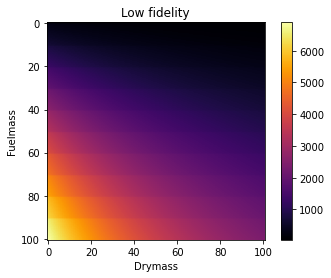

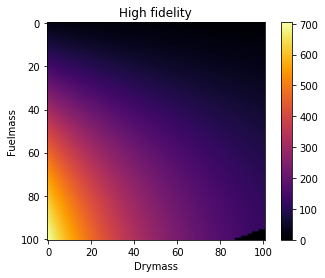

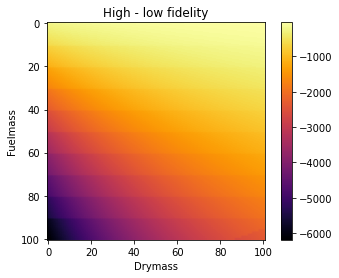

In [409]:
y_plot_low = y_plot_low.reshape(num_points**2, 1)
y_plot_hihg = y_plot_high.reshape(num_points**2, 1)
print(y_plot_low.shape)

# Low-fidelity plot original
y_plot_low_im = y_plot_low.reshape(num_points, num_points)
fig, ax = plt.subplots()
ax.set_xlabel('Drymass')
ax.set_ylabel('Fuelmass')
ax.set_title('Low fidelity')
im_low = ax.imshow(y_plot_low_im, cmap='inferno')
fig.colorbar(im_low, ax=ax)

# High-fidelity plot original
y_plot_high_im = y_plot_high.reshape(num_points, num_points)
fig, ax = plt.subplots()
ax.set_xlabel('Drymass')
ax.set_ylabel('Fuelmass')
ax.set_title('High fidelity')
im_high = ax.imshow(y_plot_high_im, cmap='inferno')
x_th_scaled = np.array([(x_train_fuel-500)/(5500)*101, (x_train_dry-1000)/2000*100]).reshape(12,2)
fig.colorbar(im_high, ax=ax)
plt.show()

# Difference
fig, ax = plt.subplots()
ax.set_xlabel('Drymass')
ax.set_ylabel('Fuelmass')
ax.set_title('High - low fidelity')
divnorm=colors.TwoSlopeNorm(vcenter=0.)
im_diff = ax.imshow(y_plot_high_im - y_plot_low_im, cmap='inferno')
fig.colorbar(im_diff, ax=ax)
plt.show()


The difference is not smooth

## Creating LINEAR multifidelity model

In [410]:
# Smooth -> exponentiated quadratic kernel
X_train, Y_train = convert_xy_lists_to_arrays([x_train_low, x_train_high], 
                                                    [y_train_low, y_train_high])

m2_kern = (GPy.kern.RBF(2, lengthscale=500) * \
           GPy.kern.RBF(2, lengthscale=100)) + \
            GPy.kern.Linear(2)
#m2_kern = GPy.kern.Linear(2)

kernels = [m2_kern.copy(), GPy.kern.Linear(2)]
lin_mf_kernel = LinearMultiFidelityKernel(kernels)
gpy_lin_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_mf_kernel, n_fidelities=2)
gpy_lin_mf_model.mixed_noise.Gaussian_noise.fix(0)
gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.fix(0)

array([0])

In [411]:
# Wrapping the model to emukit
lin_mf_model = GPyMultiOutputWrapper(gpy_lin_mf_model, 2, n_optimization_restarts=5)
# Fit the model
lin_mf_model.optimize()

Optimization restart 1/5, f = 1121940595.1546562
Optimization restart 2/5, f = 1117242806.960357
Optimization restart 3/5, f = 1268981593.325049
Optimization restart 4/5, f = 1279410309.8082156
Optimization restart 5/5, f = 1068350557.4633712


In [412]:
# Convert to ndarray representation
X_plot = convert_x_list_to_array([x_plot, x_plot])
X_plot_l = X_plot[:len(x_plot)]
X_plot_h = X_plot[len(x_plot):]

# Find mean and variances
lf_mean_lin_mf_model, lf_var_lin_mf_model = lin_mf_model.predict(X_plot_l)
#lf_std_lin_mf_model = np.sqrt(lf_var_lin_mf_model)
hf_mean_lin_mf_model, hf_var_lin_mf_model = lin_mf_model.predict(X_plot_h)
#hf_std_lin_mf_model = np.sqrt(hf_var_lin_mf_model)

#### Plot of posteriors

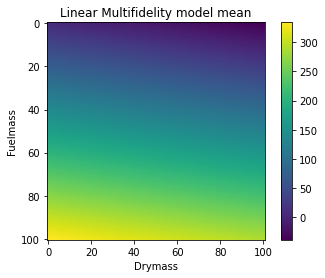

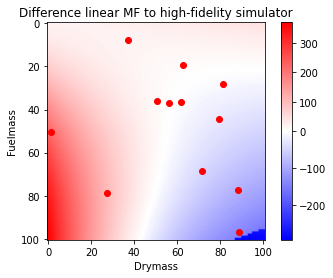

In [413]:
lf_mean_lin_plot = lf_mean_lin_mf_model.reshape(num_points, num_points)
hf_mean_lin_plot = hf_mean_lin_mf_model.reshape(num_points, num_points)

x_tl_scaled = x_train_high.copy()
x_tl_scaled[:,0] = (x_tl_scaled[:,0]-500)/(5500)*101
x_tl_scaled[:,1] = (x_tl_scaled[:,1]-1000)/(2000)*101

# Mean
fig, ax = plt.subplots()
ax.set_xlabel('Drymass')
ax.set_ylabel('Fuelmass')
ax.set_title('Linear Multifidelity model mean')
im_h_mean = ax.imshow(hf_mean_lin_plot)
fig.colorbar(im_h_mean, ax=ax)
plt.show()

# Difference
fig, ax = plt.subplots()
ax.set_xlabel('Drymass')
ax.set_ylabel('Fuelmass')
ax.set_title('Difference linear MF to high-fidelity simulator')
divnorm=colors.TwoSlopeNorm(vcenter=0.)
im_diff = ax.imshow(y_plot_high_im - hf_mean_lin_plot, cmap='bwr', norm=divnorm)

x_t_scaled = np.array([(x_train_fuel-500)/(5500)*101, (x_train_dry-1000)/2000*100]).reshape(12,2)
ax.plot(x_tlow_scaled[:,1], x_tlow_scaled[:,0], 'ro') #Drymass,fuelmass
fig.colorbar(im_diff, ax=ax)
plt.show()

In [414]:
rmse_mf_lin = np.mean(np.square(y_plot_high_im - hf_mean_lin_plot))
print(rmse_mf_lin)
print(7904)

8633.848419932983
7904


### A standard GP w only high-fidelity data

In [415]:
kernel = m2_kern.copy()
high_gp_model = GPy.models.GPRegression(x_train_high, y_train_high, kernel)
high_gp_model.Gaussian_noise.fix(0)
high_gp_model.optimize_restarts(5)
hf_mean_high_gp_model, hf_var_high_gp_model  = high_gp_model.predict(x_plot)
hf_std_hf_gp_model = np.sqrt(hf_var_high_gp_model)

Optimization restart 1/5, f = 27.295328678078352
Optimization restart 2/5, f = 33.972027551706226
Optimization restart 3/5, f = 33.97202755231075
Optimization restart 4/5, f = 33.97202755169121
Optimization restart 5/5, f = 33.97202755379598


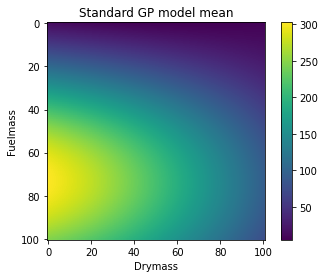

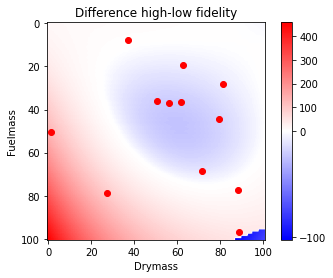

In [416]:
# plot the posterior mean for the high-fidelity GP
hf_mean_gp = hf_mean_high_gp_model.reshape(num_points, num_points)

x_th_scaled = x_train_high.copy()
x_th_scaled[:,0] = (x_th_scaled[:,0]-500)/(5500)*101
x_th_scaled[:,1] = (x_th_scaled[:,1]-1000)/(2000)*101

# Mean
fig, ax = plt.subplots()
ax.set_xlabel('Drymass')
ax.set_ylabel('Fuelmass')
ax.set_title('Standard GP model mean')
im_high_mean = ax.imshow(hf_mean_gp)
fig.colorbar(im_high_mean, ax=ax)
plt.show()

# Difference
fig, ax = plt.subplots()
ax.set_xlabel('Drymass')
ax.set_ylabel('Fuelmass')
ax.set_title('Difference high-low fidelity')
divnorm=colors.TwoSlopeNorm(vcenter=0.)
im_diff = ax.imshow(y_plot_high_im - hf_mean_gp, cmap='bwr', norm=divnorm)

x_t_scaled = np.array([(x_train_fuel-500)/(5500)*101, (x_train_dry-1000)/2000*100]).reshape(12,2)
ax.plot(x_tlow_scaled[:,1], x_tlow_scaled[:,0], 'ro')
fig.colorbar(im_diff, ax=ax)
plt.show()

In [417]:
rmse_gp = np.mean(np.square(y_plot_high_im - hf_mean_gp))
print(rmse_mf_lin, rmse_gp)

8633.848419932983 6326.156456611642


## Non-linear multifidelity model

In [418]:
from emukit.multi_fidelity.models.non_linear_multi_fidelity_model import make_non_linear_kernels, NonLinearMultiFidelityModel

base_kernel = GPy.kern.Linear
#base_kernel = GPy.kern.LinearSlopeBasisFuncKernel(2, start=0, stop=1e10)
kernels = make_non_linear_kernels(base_kernel, 2, X_train.shape[1] - 1)

In [419]:
nonlin_mf_model = NonLinearMultiFidelityModel(X_train, Y_train, n_fidelities=2, kernels=kernels, 
                                              verbose=True, optimization_restarts=5)

for m in nonlin_mf_model.models:
    m.Gaussian_noise.variance.fix(0)
nonlin_mf_model.optimize()

# Mean and variance predictions
hf_mean_nonlin_mf_model, hf_var_nonlin_mf_model = nonlin_mf_model.predict(X_plot_h)
#hf_std_nonlin_mf_model = np.sqrt(hf_var_nonlin_mf_model)
lf_mean_nonlin_mf_model, lf_var_nonlin_mf_model = nonlin_mf_model.predict(X_plot_l)
#lf_std_nonlin_mf_model = np.sqrt(lf_var_nonlin_mf_model)

Optimization restart 1/5, f = 18993.12258430033
Optimization restart 2/5, f = 101.04436290778229
Optimization restart 3/5, f = 57854976616305.65
Optimization restart 4/5, f = 23585.755568115812
Optimization restart 5/5, f = 24214.491954661782
Optimization restart 1/5, f = 53.73402425732058
Optimization restart 2/5, f = 52.839076643676115
Optimization restart 3/5, f = 54.83320134363596
Optimization restart 4/5, f = 50.25252351641965
Optimization restart 5/5, f = 50.61784267967273


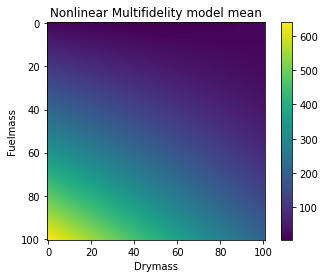

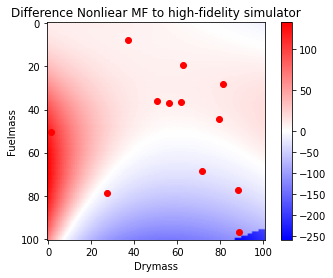

In [420]:
# Plot non-linear multifidelity model
hf_mean_hplot = hf_mean_nonlin_mf_model.reshape(num_points, num_points)

x_th_scaled = x_train_high.copy()
x_th_scaled[:,0] = (x_th_scaled[:,0]-500)/(5500)*101
x_th_scaled[:,1] = (x_th_scaled[:,1]-1000)/(2000)*101

# Mean
fig, ax = plt.subplots()
ax.set_xlabel('Drymass')
ax.set_ylabel('Fuelmass')
ax.set_title('Nonlinear Multifidelity model mean')
im_high_mean = ax.imshow(hf_mean_hplot)
fig.colorbar(im_high_mean, ax=ax)
plt.show()

# Difference
fig, ax = plt.subplots()
ax.set_xlabel('Drymass')
ax.set_ylabel('Fuelmass')
ax.set_title('Difference Nonliear MF to high-fidelity simulator')
divnorm=colors.TwoSlopeNorm(vcenter=0.)
im_diff = ax.imshow(y_plot_high_im - hf_mean_hplot, cmap='bwr', norm=divnorm)

x_t_scaled = np.array([(x_train_fuel-500)/(5500)*101, (x_train_dry-1000)/2000*100]).reshape(12,2)
ax.plot(x_tlow_scaled[:,1], x_tlow_scaled[:,0], 'ro')
fig.colorbar(im_diff, ax=ax)
plt.show()

In [421]:
rmse_mf_nonlin = np.mean(np.square(y_plot_high_im - hf_mean_hplot))
print(rmse_mf_lin)
print(rmse_gp)
print(rmse_mf_nonlin)

8633.848419932983
6326.156456611642
2079.778335348798
